In [1]:
!nvidia-smi

Thu Feb 29 02:36:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   41C    P8    14W / 170W |    335MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/bunny/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
data_dir = '../data/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [8]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [9]:
labels = ['ang', 'neu', 'sad', 'hap']
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [11]:
import traceback
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13ser.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [13]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [14]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [15]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                 | 0.0005714285714285715/10 [00:02<11:30:12, 4141.46s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.421521
Mem before-during-after: 1820160 5321924096 44929536


  0%|▏                                                                   | 0.023428571428571413/10 [00:20<2:28:09, 891.03s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.639889
Mem before-during-after: 44953088 5332742144 44976640


  0%|▎                                                                   | 0.046285714285714215/10 [00:39<2:37:24, 948.81s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.665418
Mem before-during-after: 45757952 5332086784 45352448


  1%|▍                                                                    | 0.06914285714285702/10 [00:58<2:29:32, 903.52s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.384583
Mem before-during-after: 44981760 5332678656 44953088


  1%|▋                                                                    | 0.09199999999999982/10 [01:17<2:26:24, 886.63s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.630695
Mem before-during-after: 44929536 5331663872 44929536


  1%|▊                                                                    | 0.11485714285714262/10 [01:36<2:34:22, 937.02s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 1.329003
Mem before-during-after: 44929536 5333056512 45352448


  1%|▉                                                                    | 0.13771428571428573/10 [01:56<2:42:14, 987.07s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.422553
Mem before-during-after: 45352448 5331806720 45072384


  2%|█                                                                     | 0.1605714285714291/10 [02:15<2:31:28, 923.66s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.291359
Mem before-during-after: 45352448 5332300288 45166592


  2%|█▎                                                                   | 0.18342857142857244/10 [02:35<2:26:09, 893.31s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 1.371770
Mem before-during-after: 44953088 5332609536 45190144


  2%|█▍                                                                    | 0.2062857142857158/10 [02:54<2:30:22, 921.21s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 1.392811
Mem before-during-after: 45166592 5332733952 44929536


  2%|█▌                                                                   | 0.22914285714285915/10 [03:13<2:39:22, 978.70s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.377515
Mem before-during-after: 44929536 4751577088 44953088


  3%|█▊                                                                    | 0.2520000000000024/10 [03:32<2:29:36, 920.87s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.093946
Mem before-during-after: 44929536 5255735296 45155840


  3%|█▉                                                                   | 0.27485714285714463/10 [03:52<2:25:54, 900.19s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 1.199965
Mem before-during-after: 44929536 5332695040 44929536


  3%|██                                                                    | 0.2977142857142869/10 [04:10<2:21:51, 877.28s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 1.390142
Mem before-during-after: 44929536 5333380608 45166592


  3%|██▏                                                                   | 0.3205714285714291/10 [04:29<2:22:05, 880.78s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 1.276055
Mem before-during-after: 44929536 5334085120 45166592


  3%|██▎                                                                  | 0.34342857142857136/10 [04:48<2:20:45, 874.57s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 1.306476
Mem before-during-after: 44953088 5331687424 44953088


  4%|██▌                                                                   | 0.3662857142857136/10 [05:06<2:21:14, 879.64s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.446312
Mem before-during-after: 44929536 5331663872 44929536


  4%|██▋                                                                  | 0.38914285714285585/10 [05:25<2:38:50, 991.60s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 1.409490
Mem before-during-after: 44953088 5336584192 45655552


  4%|██▊                                                                  | 0.4119999999999981/10 [05:45<3:01:32, 1136.11s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 2.002520
Mem before-during-after: 44953088 5337241088 45352448


  4%|██▉                                                                 | 0.43485714285714033/10 [06:05<2:41:11, 1011.08s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 1.373039
Mem before-during-after: 44929536 5336526848 45598208


  5%|███▏                                                                  | 0.4577142857142826/10 [06:23<2:23:35, 902.92s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 1.231095
Mem before-during-after: 45166592 5332285440 44929536


  5%|███▎                                                                  | 0.4805714285714248/10 [06:42<2:23:58, 907.48s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 1.376775
Mem before-during-after: 44929536 5332237824 44929536


  5%|███▌                                                                  | 0.5034285714285671/10 [07:01<2:28:59, 941.29s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 1.474347
Mem before-during-after: 45352448 5331663872 44929536


  5%|███▋                                                                  | 0.5262857142857094/10 [07:20<2:21:39, 897.18s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.257420
Mem before-during-after: 45824512 5332135936 45401600


  5%|███▊                                                                  | 0.5491428571428516/10 [07:39<2:24:27, 917.12s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 1.113404
Mem before-during-after: 45166592 5332285440 44929536


  6%|████                                                                  | 0.5719999999999938/10 [07:58<2:33:21, 976.03s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 1.226784
Mem before-during-after: 44929536 5338772480 45352448


  6%|████▏                                                                 | 0.5948571428571361/10 [08:16<2:21:08, 900.42s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 1.418879
Mem before-during-after: 44929536 5331663872 44929536


  6%|████▎                                                                 | 0.6177142857142783/10 [08:35<2:30:41, 963.64s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 1.269810
Mem before-during-after: 45100544 5332391936 45352448


  6%|████▍                                                                 | 0.6405714285714206/10 [08:55<2:18:57, 890.78s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 1.168821
Mem before-during-after: 45166592 5333015040 45401600


  7%|████▋                                                                 | 0.6634285714285628/10 [09:13<2:15:57, 873.69s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 0.950738
Mem before-during-after: 44929536 5332932096 45166592


  7%|████▊                                                                 | 0.6862857142857051/10 [09:33<2:31:18, 974.71s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 1.341034
Mem before-during-after: 45775360 5332909056 45775360


  7%|████▉                                                                 | 0.7091428571428473/10 [09:53<2:19:59, 904.10s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 1.126105
Mem before-during-after: 45166592 4670154240 45483520


  7%|█████                                                                 | 0.7319999999999895/10 [10:11<2:18:52, 899.09s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 1.373522
Mem before-during-after: 45352448 5270397952 44929536


  8%|█████▎                                                                | 0.7548571428571318/10 [10:30<2:30:35, 977.32s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 1.193261
Mem before-during-after: 45280768 5336207872 45279232


  8%|█████▌                                                                 | 0.777714285714274/10 [10:49<2:20:12, 912.24s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 1.233507
Mem before-during-after: 45425152 5083463168 44953088


 10%|██████▉                                                               | 0.9999999999999823/10 [12:32<1:03:47, 425.26s/it]


Test Epoch: 1	Accuracy: 2008/5600 (36%)



 10%|███████                                                                | 1.000571428571411/10 [12:32<1:19:57, 533.07s/it]

Train Epoch: 2 [0/22400 (0%)]	Loss: 1.379457
Mem before-during-after: 44922368 5337804800 44929536


 10%|███████▏                                                              | 1.0234285714285576/10 [12:51<2:25:36, 973.24s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 1.114600
Mem before-during-after: 44953088 4919832064 45377024


 10%|███████▎                                                              | 1.0462857142857043/10 [13:10<2:09:04, 864.95s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 1.027662
Mem before-during-after: 45844992 5332372992 45190144


 11%|███████▌                                                               | 1.069142857142851/10 [13:29<2:13:20, 895.88s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 1.454636
Mem before-during-after: 44929536 5331687424 44953088


 11%|███████▋                                                              | 1.0919999999999976/10 [13:48<2:24:41, 974.58s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 1.208476
Mem before-during-after: 45834752 5336281088 45352448


 11%|███████▊                                                              | 1.1148571428571443/10 [14:07<2:18:07, 932.68s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 1.239566
Mem before-during-after: 44953088 5333613568 45376000


 11%|████████                                                               | 1.137714285714291/10 [14:25<2:11:26, 889.90s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 1.243841
Mem before-during-after: 44953088 5331663872 44929536


 12%|████████                                                              | 1.1605714285714377/10 [14:44<2:11:39, 893.64s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 1.356340
Mem before-during-after: 45166592 5331663872 44929536


 12%|████████▎                                                             | 1.1834285714285844/10 [15:02<2:07:35, 868.33s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 1.244081
Mem before-during-after: 45401600 5332135936 44953088


 12%|████████▌                                                              | 1.206285714285731/10 [15:20<2:21:03, 962.43s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 1.263116
Mem before-during-after: 44929536 5336475648 45547008


 12%|████████▌                                                             | 1.2291428571428777/10 [15:39<2:08:19, 877.89s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 1.230776
Mem before-during-after: 44929536 5332695040 44929536


 13%|████████▊                                                             | 1.2520000000000244/10 [15:58<2:12:44, 910.47s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 1.067341
Mem before-during-after: 44929536 5331663872 44929536


 13%|█████████                                                              | 1.274857142857171/10 [16:16<2:05:37, 863.92s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 1.159448
Mem before-during-after: 44929536 5333404160 45190144


 13%|█████████                                                             | 1.2977142857143178/10 [16:34<2:05:50, 867.70s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 1.172065
Mem before-during-after: 44929536 5332955648 45190144


 13%|█████████▏                                                            | 1.3205714285714645/10 [16:53<2:05:13, 865.63s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 0.976914
Mem before-during-after: 45166592 5331663872 44929536


 13%|█████████▍                                                            | 1.3434285714286112/10 [17:12<2:07:59, 887.10s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 1.061185
Mem before-during-after: 44929536 5332695040 44929536


 14%|█████████▌                                                            | 1.3662857142857578/10 [17:30<2:16:53, 951.34s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 1.299600
Mem before-during-after: 45081088 5336264704 45336064


 14%|█████████▋                                                            | 1.3891428571429045/10 [17:49<2:05:53, 877.21s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 1.034284
Mem before-during-after: 44929536 5333293056 45619712


 14%|█████████▉                                                            | 1.4120000000000512/10 [18:07<2:06:32, 884.05s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 1.149822
Mem before-during-after: 45401600 5332135936 44953088


 14%|██████████▏                                                            | 1.434857142857198/10 [18:26<2:03:47, 867.18s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 1.225232
Mem before-during-after: 44929536 5331663872 44929536


 15%|██████████▏                                                           | 1.4577142857143446/10 [18:44<2:08:38, 903.54s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 1.330536
Mem before-during-after: 46383616 5040736768 44929536


 15%|██████████▎                                                           | 1.4805714285714913/10 [19:03<2:03:20, 868.72s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 1.171590
Mem before-during-after: 45892096 5332626432 45892096


 15%|██████████▋                                                            | 1.503428571428638/10 [19:22<2:07:01, 896.95s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 1.660219
Mem before-during-after: 45425152 5332372992 45190144


 15%|██████████▋                                                           | 1.5262857142857846/10 [19:40<2:15:13, 957.45s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 1.020583
Mem before-during-after: 45824512 5332772352 45638656


 15%|██████████▊                                                           | 1.5491428571429313/10 [19:58<2:03:08, 874.25s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 0.904227
Mem before-during-after: 44929536 5331687424 44953088


 16%|███████████▏                                                           | 1.572000000000078/10 [20:17<2:04:21, 885.29s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 1.088982
Mem before-during-after: 44929536 5332602880 45868544


 16%|███████████▏                                                          | 1.5948571428572247/10 [20:35<2:02:02, 871.25s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 1.100370
Mem before-during-after: 44953088 5299910144 44929536


 16%|███████████▎                                                          | 1.6177142857143714/10 [20:54<2:10:05, 931.14s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 1.221520
Mem before-during-after: 44929536 5087556608 45539840


 16%|███████████▋                                                           | 1.640571428571518/10 [21:13<2:10:13, 934.66s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 1.474521
Mem before-during-after: 45486592 5332830720 45486592


 17%|███████████▋                                                          | 1.6634285714286647/10 [21:32<2:12:55, 956.69s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 1.097903
Mem before-during-after: 44929536 5333540352 45072384


 17%|███████████▊                                                          | 1.6862857142858114/10 [21:50<2:07:17, 918.61s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 1.427110
Mem before-during-after: 44929536 5043586560 45919232


 17%|████████████▏                                                          | 1.709142857142958/10 [22:09<2:01:49, 881.63s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 1.479534
Mem before-during-after: 44953088 5331900928 45166592


 17%|████████████                                                          | 1.7320000000001048/10 [22:27<2:03:50, 898.65s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 1.314794
Mem before-during-after: 45058560 5332486144 45352448


 18%|████████████▎                                                         | 1.7548571428572515/10 [22:46<2:14:07, 976.09s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 1.200568
Mem before-during-after: 45843968 5336793600 45184512


 18%|████████████▍                                                         | 1.7777142857143982/10 [23:05<2:04:25, 907.95s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 1.046366
Mem before-during-after: 44929536 5331663872 44929536


 20%|██████████████▍                                                         | 2.0000000000001497/10 [24:48<57:01, 427.66s/it]


Test Epoch: 2	Accuracy: 2423/5600 (43%)



 20%|██████████████▏                                                        | 2.000571428571578/10 [24:49<1:10:57, 532.24s/it]

Train Epoch: 3 [0/22400 (0%)]	Loss: 1.032682
Mem before-during-after: 44922368 5337804800 44929536


 20%|██████████████▎                                                        | 2.023428571428716/10 [25:07<1:54:55, 864.45s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 0.875105
Mem before-during-after: 44929536 5332955648 45190144


 20%|██████████████▎                                                       | 2.0462857142858537/10 [25:25<1:55:46, 873.41s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 0.966544
Mem before-during-after: 44953088 5331900928 45166592


 21%|██████████████▍                                                       | 2.0691428571429915/10 [25:44<1:59:14, 902.13s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 1.415113
Mem before-during-after: 44953088 4918547968 44953088


 21%|██████████████▋                                                       | 2.0920000000001293/10 [26:03<1:59:43, 908.36s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 1.404361
Mem before-during-after: 45166592 5332086784 45352448


 21%|███████████████                                                        | 2.114857142857267/10 [26:21<1:53:59, 867.39s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 1.318470
Mem before-during-after: 44953088 5334515200 45810688


 21%|███████████████▏                                                       | 2.137714285714405/10 [26:40<1:54:36, 874.66s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 1.109422
Mem before-during-after: 44929536 5332718592 44953088


 22%|███████████████                                                       | 2.1605714285715427/10 [26:58<1:54:11, 873.99s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 1.081731
Mem before-during-after: 44929536 5331663872 44929536


 22%|███████████████▎                                                      | 2.1834285714286805/10 [27:18<2:00:17, 923.32s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 1.048489
Mem before-during-after: 45907456 5331663872 44929536


 22%|███████████████▍                                                      | 2.2062857142858183/10 [27:36<1:56:59, 900.66s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 1.146577
Mem before-during-after: 44953088 5247862784 45937152


 22%|███████████████▊                                                       | 2.229142857142956/10 [27:54<1:52:20, 867.37s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 0.921572
Mem before-during-after: 45213696 5333166592 45425152


 23%|███████████████▉                                                       | 2.252000000000094/10 [28:13<1:54:55, 889.95s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 1.403450
Mem before-during-after: 44929536 5331663872 44929536


 23%|███████████████▉                                                      | 2.2748571428572317/10 [28:31<1:55:23, 896.20s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 1.088219
Mem before-during-after: 44929536 5083392000 44929536


 23%|████████████████                                                      | 2.2977142857143695/10 [28:50<2:04:05, 966.61s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 1.119269
Mem before-during-after: 44929536 5337072640 45352448


 23%|████████████████▏                                                     | 2.3205714285715073/10 [29:08<1:52:57, 882.59s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 1.393735
Mem before-during-after: 45868544 5332602880 45868544


 23%|████████████████▋                                                      | 2.343428571428645/10 [29:27<1:56:33, 913.36s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 1.220825
Mem before-during-after: 44929536 5332579328 44929536


 24%|████████████████▌                                                     | 2.366285714285783/10 [29:47<2:17:07, 1077.85s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 1.068792
Mem before-during-after: 45942272 5337491456 45757952


 24%|████████████████▋                                                     | 2.3891428571429207/10 [30:05<1:49:36, 864.07s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 1.228666
Mem before-during-after: 44929536 5332695040 44929536


 24%|████████████████▉                                                     | 2.4120000000000585/10 [30:23<1:51:31, 881.83s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 1.434004
Mem before-during-after: 45352448 5331687424 44929536


 24%|█████████████████                                                     | 2.4348571428571963/10 [30:41<2:02:13, 969.44s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 1.537577
Mem before-during-after: 45310464 5336095232 45166592


 25%|█████████████████▍                                                     | 2.457714285714334/10 [31:00<2:04:54, 993.73s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 1.215707
Mem before-during-after: 44929536 5335858176 44929536


 25%|█████████████████▌                                                     | 2.480571428571472/10 [31:19<1:53:46, 907.79s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 1.232577
Mem before-during-after: 45352448 5331663872 44929536


 25%|█████████████████▌                                                    | 2.5034285714286098/10 [31:38<1:57:32, 940.81s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 1.072149
Mem before-during-after: 45352448 5332086784 45352448


 25%|█████████████████▋                                                    | 2.5262857142857476/10 [31:56<1:48:31, 871.25s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 1.090755
Mem before-during-after: 44953088 5331663872 44929536


 25%|█████████████████▊                                                    | 2.5491428571428854/10 [32:15<1:57:13, 943.97s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 1.329005
Mem before-during-after: 45352448 5333051392 45166592


 26%|██████████████████▎                                                    | 2.572000000000023/10 [32:34<1:56:35, 941.78s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 1.003818
Mem before-during-after: 44929536 5333436928 45352448


 26%|██████████████████▍                                                    | 2.594857142857161/10 [32:52<1:47:55, 874.43s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 1.593447
Mem before-during-after: 44929536 5331663872 44929536


 26%|██████████████████▎                                                   | 2.6177142857142988/10 [33:12<1:47:12, 871.36s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 1.060474
Mem before-during-after: 44929536 5331663872 44929536


 26%|██████████████████▍                                                   | 2.6405714285714366/10 [33:30<1:50:59, 904.87s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 1.281608
Mem before-during-after: 45352448 5332086784 45352448


 27%|██████████████████▋                                                   | 2.6634285714285744/10 [33:49<1:52:42, 921.75s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 1.314047
Mem before-during-after: 45352448 5331900928 45166592


 27%|███████████████████                                                    | 2.686285714285712/10 [34:07<1:47:04, 878.38s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 1.260665
Mem before-during-after: 44929536 5331663872 44929536


 27%|███████████████████▌                                                    | 2.70914285714285/10 [34:25<1:45:34, 868.78s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 0.950862
Mem before-during-after: 44929536 5331687424 44953088


 27%|███████████████████                                                   | 2.7319999999999878/10 [34:45<1:50:37, 913.28s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 1.048625
Mem before-during-after: 46291456 5332133888 44953088


 28%|███████████████████▎                                                  | 2.7548571428571256/10 [35:03<1:46:40, 883.46s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 0.976659
Mem before-during-after: 44929536 5331968000 44929536


 28%|███████████████████▍                                                  | 2.7777142857142634/10 [35:22<1:52:13, 932.35s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 1.173957
Mem before-during-after: 45861376 5004796928 45978112


 30%|█████████████████████▌                                                  | 2.9999999999999285/10 [37:07<50:10, 430.03s/it]


Test Epoch: 3	Accuracy: 2546/5600 (45%)



 30%|█████████████████████▎                                                 | 3.000571428571357/10 [37:07<1:02:27, 535.42s/it]

Train Epoch: 4 [0/22400 (0%)]	Loss: 0.999281
Mem before-during-after: 44922368 5337804800 44929536


 30%|█████████████████████▏                                                | 3.0234285714284947/10 [37:25<1:41:03, 869.14s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 1.052101
Mem before-during-after: 44929536 5331663872 44929536


 30%|█████████████████████▎                                                | 3.0462857142856326/10 [37:43<1:40:50, 870.09s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 1.115096
Mem before-during-after: 44929536 5331663872 44929536


 31%|█████████████████████▍                                                | 3.0691428571427704/10 [38:02<1:43:12, 893.41s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 1.278985
Mem before-during-after: 45190144 5332670976 44929536


 31%|█████████████████████▉                                                 | 3.091999999999908/10 [38:20<1:43:12, 896.36s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 1.144928
Mem before-during-after: 44929536 4665015808 45483520


 31%|██████████████████████                                                 | 3.114857142857046/10 [38:39<1:43:44, 904.03s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 0.967519
Mem before-during-after: 45352448 5331663872 44929536


 31%|█████████████████████▉                                                | 3.1377142857141838/10 [38:57<1:44:59, 918.02s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 1.095177
Mem before-during-after: 45352448 5332358656 45352448


 32%|██████████████████████                                                | 3.1605714285713216/10 [39:15<1:40:45, 883.97s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 0.940313
Mem before-during-after: 45958144 5331694592 44960256


 32%|██████████████████████▎                                               | 3.1834285714284594/10 [39:34<1:38:38, 868.18s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 1.046997
Mem before-during-after: 44929536 5332955648 45190144


 32%|██████████████████████▊                                                | 3.206285714285597/10 [39:53<1:48:08, 955.12s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 1.325172
Mem before-during-after: 44929536 5046245888 44953088


 32%|██████████████████████▉                                                | 3.229142857142735/10 [40:12<1:49:20, 968.87s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 1.069222
Mem before-during-after: 44929536 5332429824 45352448


 33%|██████████████████████▊                                               | 3.2519999999998728/10 [40:30<1:38:04, 872.10s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 1.202350
Mem before-during-after: 45150208 5332566016 44929536


 33%|██████████████████████▉                                               | 3.2748571428570106/10 [40:48<1:37:06, 866.37s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 1.080322
Mem before-during-after: 44929536 5331663872 44929536


 33%|███████████████████████                                               | 3.2977142857141484/10 [41:07<1:41:25, 908.02s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 1.121989
Mem before-during-after: 44929536 5124322816 46278656


 33%|███████████████████████▌                                               | 3.320571428571286/10 [41:27<1:41:20, 910.38s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 1.165278
Mem before-during-after: 45352448 5332300288 45166592


 33%|███████████████████████▋                                               | 3.343428571428424/10 [41:45<1:37:17, 876.99s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 1.093293
Mem before-during-after: 44929536 5332695040 44929536


 34%|███████████████████████▉                                               | 3.366285714285562/10 [42:03<1:45:17, 952.34s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 1.614777
Mem before-during-after: 44953088 5335905280 44953088


 34%|███████████████████████▋                                              | 3.3891428571426996/10 [42:22<1:36:11, 873.02s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 1.121273
Mem before-during-after: 44929536 5332718592 44953088


 34%|███████████████████████▉                                              | 3.4119999999998374/10 [42:40<1:35:21, 868.52s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 1.158316
Mem before-during-after: 44929536 5331663872 44929536


 34%|████████████████████████▍                                              | 3.434857142856975/10 [42:58<1:36:19, 880.32s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 0.990352
Mem before-during-after: 45166592 5331663872 44929536


 35%|████████████████████████▌                                              | 3.457714285714113/10 [43:17<1:36:06, 881.34s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 0.951637
Mem before-during-after: 45868544 5332602880 45868544


 35%|████████████████████████▋                                              | 3.480571428571251/10 [43:37<1:48:18, 996.74s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 0.929869
Mem before-during-after: 44929536 5336281088 45352448


 35%|████████████████████████▌                                             | 3.5034285714283886/10 [43:55<1:39:22, 917.81s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 1.158355
Mem before-during-after: 44929536 5332955648 45190144


 35%|████████████████████████▋                                             | 3.5262857142855264/10 [44:13<1:33:34, 867.31s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 1.021975
Mem before-during-after: 44953088 5332742144 44976640


 35%|█████████████████████████▏                                             | 3.549142857142664/10 [44:32<1:33:27, 869.27s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 1.203626
Mem before-during-after: 44929536 5332758528 44976640


 36%|█████████████████████████▎                                             | 3.571999999999802/10 [44:50<1:33:32, 873.07s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 0.934707
Mem before-during-after: 44993024 5333396480 45190144


 36%|█████████████████████████▉                                              | 3.59485714285694/10 [45:08<1:32:24, 865.67s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 0.764936
Mem before-during-after: 44929536 5332167680 44929536


 36%|█████████████████████████▎                                            | 3.6177142857140776/10 [45:26<1:32:22, 868.42s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 1.032841
Mem before-during-after: 44953088 5332250624 45516288


 36%|█████████████████████████▍                                            | 3.6405714285712154/10 [45:45<1:36:38, 911.80s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 0.985267
Mem before-during-after: 45352448 5331663872 44929536


 37%|██████████████████████████                                             | 3.663428571428353/10 [46:03<1:31:48, 869.33s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 1.447699
Mem before-during-after: 45868544 5332602880 45868544


 37%|██████████████████████████▏                                            | 3.686285714285491/10 [46:22<1:33:07, 884.92s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 1.335232
Mem before-during-after: 44953088 5331900928 45166592


 37%|██████████████████████████▎                                            | 3.709142857142629/10 [46:41<1:35:04, 906.73s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 0.878542
Mem before-during-after: 45166592 5332086784 45352448


 37%|██████████████████████████                                            | 3.7319999999997666/10 [47:00<1:42:07, 977.54s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 1.224404
Mem before-during-after: 45352448 5332264960 45530624


 38%|██████████████████████████▎                                           | 3.7548571428569044/10 [47:18<1:32:54, 892.53s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 1.206332
Mem before-during-after: 45376000 5332832768 45190144


 38%|██████████████████████████▊                                            | 3.777714285714042/10 [47:37<1:35:26, 920.33s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 0.882349
Mem before-during-after: 45352448 5332300288 45166592


 40%|████████████████████████████▊                                           | 3.9999999999997073/10 [49:21<43:01, 430.18s/it]


Test Epoch: 4	Accuracy: 2494/5600 (45%)



 40%|█████████████████████████████▏                                           | 4.000571428571136/10 [49:21<53:26, 534.54s/it]

Train Epoch: 5 [0/22400 (0%)]	Loss: 0.991288
Mem before-during-after: 44922368 5337804800 44929536


 40%|████████████████████████████▌                                          | 4.023428571428291/10 [49:41<1:38:36, 989.90s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 0.826053
Mem before-during-after: 44929536 5335935488 45006848


 40%|████████████████████████████▋                                          | 4.046285714285447/10 [50:01<1:36:51, 976.07s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 1.182898
Mem before-during-after: 46052864 5337079296 45352448


 41%|████████████████████████████▍                                         | 4.0691428571426025/10 [50:19<1:35:53, 970.02s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 1.380121
Mem before-during-after: 44929536 5327566336 45115904


 41%|█████████████████████████████                                          | 4.091999999999758/10 [50:38<1:34:49, 962.95s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 1.186721
Mem before-during-after: 45757952 4878777856 45647360


 41%|█████████████████████████████▏                                         | 4.114857142856914/10 [50:57<1:25:55, 876.00s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 1.316602
Mem before-during-after: 44929536 5332695040 44929536


 41%|█████████████████████████████▍                                         | 4.137714285714069/10 [51:16<1:24:35, 865.83s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 1.338103
Mem before-during-after: 44929536 5331663872 44929536


 42%|█████████████████████████████▌                                         | 4.160571428571225/10 [51:34<1:26:22, 887.53s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 1.296059
Mem before-during-after: 44929536 5332955648 45190144


 42%|█████████████████████████████▋                                         | 4.18342857142838/10 [51:54<1:38:30, 1016.17s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 0.970481
Mem before-during-after: 44929536 5337502720 45775360


 42%|█████████████████████████████▊                                         | 4.206285714285536/10 [52:13<1:23:58, 869.69s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 1.114686
Mem before-during-after: 44953088 5331687424 44953088


 42%|█████████████████████████████▌                                        | 4.2291428571426914/10 [52:31<1:23:32, 868.64s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 1.124890
Mem before-during-after: 44929536 5331663872 44929536


 43%|██████████████████████████████▏                                        | 4.251999999999847/10 [52:50<1:34:26, 985.78s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 1.257291
Mem before-during-after: 44953088 5337645568 44976640


 43%|██████████████████████████████▎                                        | 4.274857142857003/10 [53:08<1:24:21, 884.08s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 1.166352
Mem before-during-after: 44929536 5331663872 44929536


 43%|██████████████████████████████▌                                        | 4.297714285714158/10 [53:26<1:22:21, 866.63s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 1.227751
Mem before-during-after: 44953088 5332191232 44953088


 43%|██████████████████████████████▋                                        | 4.320571428571314/10 [53:45<1:24:06, 888.56s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 1.125970
Mem before-during-after: 44929536 5332840448 46106112


 43%|██████████████████████████████▊                                        | 4.343428571428469/10 [54:04<1:21:41, 866.52s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 0.992021
Mem before-during-after: 44929536 5331687424 44953088


 44%|███████████████████████████████                                        | 4.366285714285625/10 [54:23<1:21:46, 870.92s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 0.980021
Mem before-during-after: 44929536 5332695040 44929536


 44%|███████████████████████████████▌                                        | 4.38914285714278/10 [54:42<1:26:07, 920.97s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 1.076260
Mem before-during-after: 44929536 5332695040 44929536


 44%|███████████████████████████████▎                                       | 4.411999999999936/10 [55:02<1:22:38, 887.38s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 1.119615
Mem before-during-after: 44929536 5332440064 45401600


 44%|███████████████████████████████                                       | 4.4348571428570915/10 [55:21<1:28:19, 952.26s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 1.225294
Mem before-during-after: 45352448 4329813504 44953088


 45%|███████████████████████████████▋                                       | 4.457714285714247/10 [55:39<1:21:00, 876.99s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 1.367895
Mem before-during-after: 44929536 5303558144 44953088


 45%|███████████████████████████████▊                                       | 4.480571428571403/10 [55:59<1:28:43, 964.49s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 1.013271
Mem before-during-after: 44929536 5333775872 45190144


 45%|███████████████████████████████▉                                       | 4.503428571428558/10 [56:17<1:23:58, 916.69s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 1.043337
Mem before-during-after: 45286912 5332086784 45352448


 45%|████████████████████████████████▏                                      | 4.526285714285714/10 [56:35<1:19:50, 875.12s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 1.059926
Mem before-during-after: 44929536 5331663872 44929536


 45%|████████████████████████████████▎                                      | 4.549142857142869/10 [56:53<1:19:03, 870.18s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 1.089784
Mem before-during-after: 44929536 5332526080 44953088


 46%|████████████████████████████████▍                                      | 4.572000000000025/10 [57:11<1:18:50, 871.54s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 0.979186
Mem before-during-after: 44953088 5331687424 44953088


 46%|████████████████████████████████▏                                     | 4.5948571428571805/10 [57:30<1:18:29, 871.27s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 0.966229
Mem before-during-after: 45166592 5331663872 44929536


 46%|████████████████████████████████▊                                      | 4.617714285714336/10 [57:48<1:17:47, 867.14s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 1.015895
Mem before-during-after: 45401600 5332112384 44929536


 46%|████████████████████████████████▉                                      | 4.640571428571492/10 [58:06<1:17:22, 866.27s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 1.064332
Mem before-during-after: 44953088 5331663872 44929536


 47%|█████████████████████████████████                                      | 4.663428571428647/10 [58:25<1:17:00, 865.90s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 0.920124
Mem before-during-after: 44929536 5332955648 45190144


 47%|█████████████████████████████████▎                                     | 4.686285714285803/10 [58:43<1:17:19, 873.15s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 1.279922
Mem before-during-after: 44953088 5332038656 45304320


 47%|█████████████████████████████████▍                                     | 4.709142857142958/10 [59:02<1:25:06, 965.23s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 1.700069
Mem before-during-after: 45352448 5331687424 44953088


 47%|█████████████████████████████████▌                                     | 4.732000000000114/10 [59:20<1:24:40, 964.49s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 1.393021
Mem before-during-after: 45564928 5335858176 44929536


 48%|█████████████████████████████████▎                                    | 4.7548571428572695/10 [59:39<1:22:02, 938.54s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 1.090099
Mem before-during-after: 44929536 5336642048 45713408


 48%|█████████████████████████████████▉                                     | 4.777714285714425/10 [59:57<1:18:33, 902.54s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 1.148933
Mem before-during-after: 44929536 5332135936 45401600


 50%|███████████████████████████████████▌                                   | 5.000000000000263/10 [1:01:40<35:53, 430.79s/it]


Test Epoch: 5	Accuracy: 2915/5600 (52%)



 50%|███████████████████████████████████▌                                   | 5.000571428571692/10 [1:01:41<44:33, 534.67s/it]

Train Epoch: 6 [0/22400 (0%)]	Loss: 1.224347
Mem before-during-after: 44922368 5337804800 44929536


 50%|██████████████████████████████████▋                                  | 5.023428571428847/10 [1:02:00<1:15:05, 905.25s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 1.050678
Mem before-during-after: 45376000 4877447680 45166592


 50%|██████████████████████████████████▊                                  | 5.046285714286003/10 [1:02:18<1:11:41, 868.24s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 1.156117
Mem before-during-after: 45401600 5332584448 45401600


 51%|██████████████████████████████████▍                                 | 5.0691428571431585/10 [1:02:37<1:21:45, 994.79s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 1.253940
Mem before-during-after: 44929536 4498150400 45675008


 51%|███████████████████████████████████▏                                 | 5.092000000000314/10 [1:02:56<1:11:32, 874.68s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 1.481929
Mem before-during-after: 44929536 5241869824 44929536


 51%|███████████████████████████████████▊                                  | 5.11485714285747/10 [1:03:15<1:15:31, 927.70s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 0.953376
Mem before-during-after: 45775360 5332781568 45775360


 51%|███████████████████████████████████▍                                 | 5.137714285714625/10 [1:03:34<1:11:11, 878.47s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 1.002389
Mem before-during-after: 45960704 5332626432 45892096


 52%|███████████████████████████████████▌                                 | 5.160571428571781/10 [1:03:53<1:11:31, 886.78s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 1.045698
Mem before-during-after: 45915648 5331687424 44953088


 52%|███████████████████████████████████▊                                 | 5.183428571428936/10 [1:04:12<1:10:45, 881.39s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 1.034770
Mem before-during-after: 44929536 5331687424 44953088


 52%|███████████████████████████████████▉                                 | 5.206285714286092/10 [1:04:31<1:14:54, 937.62s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 1.256998
Mem before-during-after: 45376000 5332110336 45376000


 52%|███████████████████████████████████▌                                | 5.2291428571432474/10 [1:04:50<1:13:45, 927.68s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 1.187642
Mem before-during-after: 45775360 5332676096 45542400


 53%|████████████████████████████████████▏                                | 5.252000000000403/10 [1:05:08<1:11:58, 909.64s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 1.260250
Mem before-during-after: 44976640 5331663872 44929536


 53%|████████████████████████████████████▍                                | 5.274857142857559/10 [1:05:26<1:13:34, 934.23s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 1.433312
Mem before-during-after: 44929536 5332535296 45352448


 53%|████████████████████████████████████▌                                | 5.297714285714714/10 [1:05:45<1:13:06, 932.88s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 0.883473
Mem before-during-after: 44929536 5332086784 45352448


 53%|█████████████████████████████████████▏                                | 5.32057142857187/10 [1:06:04<1:12:03, 923.95s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 1.243683
Mem before-during-after: 44929536 4502013440 44929536


 53%|████████████████████████████████████▊                                | 5.343428571429025/10 [1:06:23<1:08:36, 884.12s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 0.696619
Mem before-during-after: 45958144 5332015104 44929536


 54%|█████████████████████████████████████                                | 5.366285714286181/10 [1:06:41<1:08:25, 886.10s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 1.270205
Mem before-during-after: 45352448 5331687424 44953088


 54%|█████████████████████████████████████▏                               | 5.389142857143336/10 [1:07:00<1:06:39, 867.50s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 0.832517
Mem before-during-after: 45815296 5331833856 44929536


 54%|█████████████████████████████████████▎                               | 5.412000000000492/10 [1:07:18<1:12:58, 954.32s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 1.382800
Mem before-during-after: 45513216 5337160704 45671936


 54%|████████████████████████████████████▉                               | 5.4348571428576475/10 [1:07:38<1:07:41, 889.74s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 0.778525
Mem before-during-after: 44929536 5331687424 44953088


 55%|█████████████████████████████████████▋                               | 5.457714285714803/10 [1:07:57<1:07:52, 896.57s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 1.388615
Mem before-during-after: 44953088 5331900928 45166592


 55%|█████████████████████████████████████▎                              | 5.480571428571959/10 [1:08:16<1:21:02, 1075.94s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 1.124715
Mem before-during-after: 45811200 5337597952 45775360


 55%|█████████████████████████████████████▉                               | 5.503428571429114/10 [1:08:35<1:08:51, 918.80s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 1.119168
Mem before-during-after: 44976640 5332724736 45190144


 55%|██████████████████████████████████████▋                               | 5.52628571428627/10 [1:08:53<1:06:18, 889.23s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 1.109621
Mem before-during-after: 44929536 5332687360 44929536


 55%|██████████████████████████████████████▎                              | 5.549142857143425/10 [1:09:12<1:04:41, 872.14s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 1.151065
Mem before-during-after: 44953088 5331900928 45166592


 56%|██████████████████████████████████████▍                              | 5.572000000000581/10 [1:09:30<1:04:16, 870.85s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 0.897336
Mem before-during-after: 44953088 5331663872 44929536


 56%|██████████████████████████████████████                              | 5.5948571428577365/10 [1:09:49<1:06:18, 903.18s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 0.905352
Mem before-during-after: 44929536 5331663872 44929536


 56%|██████████████████████████████████████▊                              | 5.617714285714892/10 [1:10:07<1:03:27, 868.89s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 1.192252
Mem before-during-after: 44953088 5331687424 44953088


 56%|██████████████████████████████████████▎                             | 5.640571428572048/10 [1:10:26<1:13:40, 1014.06s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 1.149099
Mem before-during-after: 45539840 5336624128 45352448


 57%|███████████████████████████████████████                              | 5.663428571429203/10 [1:10:45<1:02:41, 867.30s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 1.069360
Mem before-during-after: 45190144 5332414464 45680128


 57%|███████████████████████████████████████▏                             | 5.686285714286359/10 [1:11:03<1:10:23, 979.07s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 1.126489
Mem before-during-after: 44929536 5335876608 44929536


 57%|███████████████████████████████████████▍                             | 5.709142857143514/10 [1:11:21<1:02:23, 872.33s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 0.893376
Mem before-during-after: 44929536 5331663872 44929536


 57%|████████████████████████████████████████                              | 5.73200000000067/10 [1:11:40<1:09:35, 978.30s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 1.056778
Mem before-during-after: 45352448 5331663872 44929536


 58%|███████████████████████████████████████▏                            | 5.7548571428578255/10 [1:11:58<1:02:00, 876.36s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 1.102245
Mem before-during-after: 44929536 5331991552 44929536


 58%|███████████████████████████████████████▊                             | 5.777714285714981/10 [1:12:18<1:03:53, 907.93s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 1.209319
Mem before-during-after: 45775360 5334129664 45589504


 60%|██████████████████████████████████████████▌                            | 6.000000000000819/10 [1:14:01<28:33, 428.28s/it]


Test Epoch: 6	Accuracy: 2939/5600 (52%)



 60%|██████████████████████████████████████████▌                            | 6.000571428572248/10 [1:14:01<35:31, 532.98s/it]

Train Epoch: 7 [0/22400 (0%)]	Loss: 1.441277
Mem before-during-after: 44922368 5337828352 45868544


 60%|██████████████████████████████████████████▊                            | 6.023428571429403/10 [1:14:20<58:41, 885.64s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 0.665683
Mem before-during-after: 44976640 5333093888 44929536


 60%|██████████████████████████████████████████▉                            | 6.046285714286559/10 [1:14:39<57:44, 876.39s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 1.197253
Mem before-during-after: 44929536 5331808256 44929536


 61%|██████████████████████████████████████████▍                           | 6.0691428571437145/10 [1:14:58<56:53, 868.28s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 0.916637
Mem before-during-after: 45190144 5332670976 44929536


 61%|███████████████████████████████████████████▊                            | 6.09200000000087/10 [1:15:16<56:25, 866.31s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 0.885676
Mem before-during-after: 44953088 5331900928 45166592


 61%|███████████████████████████████████████████▍                           | 6.114857142858026/10 [1:15:34<56:13, 868.40s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 1.097947
Mem before-during-after: 44929536 5331663872 44929536


 61%|███████████████████████████████████████████▌                           | 6.137714285715181/10 [1:15:52<59:04, 917.60s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 1.327498
Mem before-during-after: 45166592 5336731136 45401600


 62%|███████████████████████████████████████████▋                           | 6.160571428572337/10 [1:16:11<56:30, 883.17s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 1.066678
Mem before-during-after: 45892096 5245847552 44929536


 62%|███████████████████████████████████████████▉                           | 6.183428571429492/10 [1:16:29<55:53, 878.63s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 1.545363
Mem before-during-after: 45352448 4788366336 44929536


 62%|████████████████████████████████████████████                           | 6.206285714286648/10 [1:16:48<55:54, 884.22s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 0.868167
Mem before-during-after: 44929536 5331968000 44929536


 62%|███████████████████████████████████████████▌                          | 6.2291428571438034/10 [1:17:07<58:03, 923.83s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 0.859485
Mem before-during-after: 45942272 5337578496 45757952


 63%|████████████████████████████████████████████▍                          | 6.252000000000959/10 [1:17:26<59:01, 944.92s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 1.017525
Mem before-during-after: 45352448 5331663872 44929536


 63%|████████████████████████████████████████████▌                          | 6.274857142858115/10 [1:17:44<57:54, 932.66s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 1.270587
Mem before-during-after: 45352448 5332754432 45352448


 63%|█████████████████████████████████████████████▎                          | 6.29771428571527/10 [1:18:03<58:46, 952.38s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 0.892991
Mem before-during-after: 44929536 5082441728 44929536


 63%|████████████████████████████████████████████▉                          | 6.320571428572426/10 [1:18:22<54:08, 882.87s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 0.945136
Mem before-during-after: 45401600 5333466112 44953088


 63%|███████████████████████████████████████████▊                         | 6.343428571429581/10 [1:18:41<1:00:11, 987.74s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 0.866685
Mem before-during-after: 44953088 5337939968 45352448


 64%|███████████████████████████████████████████▉                         | 6.366285714286737/10 [1:19:01<1:00:04, 991.93s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 1.250828
Mem before-during-after: 45775360 5122606080 44953088


 64%|█████████████████████████████████████████████▎                         | 6.389142857143892/10 [1:19:19<55:52, 928.44s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 0.814868
Mem before-during-after: 44953088 5332979200 45190144


 64%|█████████████████████████████████████████████▌                         | 6.412000000001048/10 [1:19:38<57:56, 969.00s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 1.414475
Mem before-during-after: 44953088 5332910080 45376000


 64%|█████████████████████████████████████████████                         | 6.4348571428582035/10 [1:19:57<55:01, 925.99s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 1.234533
Mem before-during-after: 45352448 5331663872 44929536


 65%|█████████████████████████████████████████████▊                         | 6.457714285715359/10 [1:20:15<51:07, 865.97s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 0.805884
Mem before-during-after: 44929536 5331687424 44953088


 65%|██████████████████████████████████████████████                         | 6.480571428572515/10 [1:20:34<51:08, 871.90s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 1.371177
Mem before-during-after: 44929536 5332910080 45401600


 65%|██████████████████████████████████████████████▊                         | 6.50342857142967/10 [1:20:53<57:51, 992.74s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 1.060191
Mem before-during-after: 45578752 5332761600 45824512


 65%|██████████████████████████████████████████████▎                        | 6.526285714286826/10 [1:21:11<50:21, 869.69s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 1.216849
Mem before-during-after: 44953088 5334515200 45810688


 65%|██████████████████████████████████████████████▍                        | 6.549142857143981/10 [1:21:30<54:07, 940.99s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.821047
Mem before-during-after: 45376000 5331687424 44953088


 66%|██████████████████████████████████████████████▋                        | 6.572000000001137/10 [1:21:48<49:44, 870.69s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 0.939001
Mem before-during-after: 44953088 5332695040 44929536


 66%|██████████████████████████████████████████████▏                       | 6.5948571428582925/10 [1:22:07<49:11, 866.92s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 1.202925
Mem before-during-after: 45213696 5332742144 45984256


 66%|██████████████████████████████████████████████▉                        | 6.617714285715448/10 [1:22:25<48:40, 863.56s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 1.062451
Mem before-during-after: 45775360 5333660160 45775360


 66%|███████████████████████████████████████████████▏                       | 6.640571428572604/10 [1:22:43<50:05, 894.57s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 1.167479
Mem before-during-after: 45213696 5332086784 45352448


 67%|███████████████████████████████████████████████▎                       | 6.663428571429759/10 [1:23:02<54:44, 984.41s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 1.167725
Mem before-during-after: 44929536 5335881728 44953088


 67%|███████████████████████████████████████████████▍                       | 6.686285714286915/10 [1:23:21<48:32, 878.83s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 0.788035
Mem before-during-after: 44953088 5331687424 44953088


 67%|████████████████████████████████████████████████▎                       | 6.70914285714407/10 [1:23:39<48:59, 893.30s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 0.859172
Mem before-during-after: 44953088 5332979200 45190144


 67%|███████████████████████████████████████████████▊                       | 6.732000000001226/10 [1:23:58<47:57, 880.53s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 1.210888
Mem before-during-after: 44953088 5331687424 44953088


 68%|███████████████████████████████████████████████▎                      | 6.7548571428583815/10 [1:24:16<49:35, 916.86s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 0.914234
Mem before-during-after: 45528576 5332239360 44953088


 68%|████████████████████████████████████████████████                       | 6.777714285715537/10 [1:24:35<48:02, 894.61s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 0.839742
Mem before-during-after: 44929536 5332768256 44929536


 70%|█████████████████████████████████████████████████▋                     | 7.000000000001375/10 [1:26:19<21:41, 433.81s/it]


Test Epoch: 7	Accuracy: 2892/5600 (52%)



 70%|█████████████████████████████████████████████████▋                     | 7.000571428572804/10 [1:26:20<26:50, 537.01s/it]

Train Epoch: 8 [0/22400 (0%)]	Loss: 1.089657
Mem before-during-after: 44922368 5337828352 45868544


 70%|█████████████████████████████████████████████████▊                     | 7.023428571429959/10 [1:26:39<42:52, 864.13s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 0.918307
Mem before-during-after: 44929536 5332972032 45206528


 70%|██████████████████████████████████████████████████                     | 7.046285714287115/10 [1:26:58<43:47, 889.41s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 1.060255
Mem before-during-after: 44929536 5331687424 44953088


 71%|█████████████████████████████████████████████████▍                    | 7.0691428571442705/10 [1:27:17<44:38, 913.86s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 1.202124
Mem before-during-after: 45352448 5337085952 45352448


 71%|██████████████████████████████████████████████████▎                    | 7.092000000001426/10 [1:27:36<42:24, 875.09s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 1.363307
Mem before-during-after: 45656576 5331687424 44953088


 71%|██████████████████████████████████████████████████▌                    | 7.114857142858582/10 [1:27:54<41:35, 864.81s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 1.295444
Mem before-during-after: 44929536 5331663872 44929536


 71%|██████████████████████████████████████████████████▋                    | 7.137714285715737/10 [1:28:12<44:14, 927.23s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 1.001338
Mem before-during-after: 45190144 5331687424 44929536


 72%|██████████████████████████████████████████████████▊                    | 7.160571428572893/10 [1:28:30<46:25, 980.99s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 0.971397
Mem before-during-after: 45757952 4582352896 45441536


 72%|███████████████████████████████████████████████████                    | 7.183428571430048/10 [1:28:48<40:48, 869.39s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.971787
Mem before-during-after: 44929536 5331663872 44929536


 72%|███████████████████████████████████████████████████▏                   | 7.206285714287204/10 [1:29:08<44:01, 945.51s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 0.733238
Mem before-during-after: 45376000 5331687424 44953088


 72%|██████████████████████████████████████████████████▌                   | 7.2291428571443594/10 [1:29:27<41:39, 902.14s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 1.236322
Mem before-during-after: 44953088 5331663872 44929536


 73%|███████████████████████████████████████████████████▍                   | 7.252000000001515/10 [1:29:46<40:34, 885.93s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 1.156300
Mem before-during-after: 45815296 5331663872 44929536


 73%|███████████████████████████████████████████████████▋                   | 7.274857142858671/10 [1:30:04<39:35, 871.77s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 0.886899
Mem before-during-after: 44953088 5331687424 44953088


 73%|███████████████████████████████████████████████████▊                   | 7.297714285715826/10 [1:30:22<40:45, 905.08s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 1.352099
Mem before-during-after: 44953088 5331687424 44953088


 73%|███████████████████████████████████████████████████▉                   | 7.320571428572982/10 [1:30:41<44:04, 986.95s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 1.053339
Mem before-during-after: 44929536 5338104320 45369856


 73%|████████████████████████████████████████████████████▏                  | 7.343428571430137/10 [1:31:00<39:06, 883.31s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 1.119045
Mem before-during-after: 45190144 5333143040 45401600


 74%|████████████████████████████████████████████████████▎                  | 7.366285714287293/10 [1:31:19<39:54, 909.23s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 1.252999
Mem before-during-after: 44929536 5331663872 44929536


 74%|███████████████████████████████████████████████████▋                  | 7.389142857144448/10 [1:31:38<43:57, 1010.14s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 1.248478
Mem before-during-after: 44929536 5335858176 44929536


 74%|████████████████████████████████████████████████████▋                  | 7.412000000001604/10 [1:31:56<37:59, 880.91s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 0.907176
Mem before-during-after: 44976640 5331687424 44929536


 74%|████████████████████████████████████████████████████                  | 7.4348571428587595/10 [1:32:14<37:06, 867.83s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 0.822938
Mem before-during-after: 44929536 5332135936 45401600


 75%|████████████████████████████████████████████████████▉                  | 7.457714285715915/10 [1:32:33<37:34, 886.91s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 0.869742
Mem before-during-after: 45775360 5333474304 45589504


 75%|█████████████████████████████████████████████████████                  | 7.480571428573071/10 [1:32:51<36:21, 865.94s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 0.929268
Mem before-during-after: 45213696 5333214208 46456320


 75%|█████████████████████████████████████████████████████▎                 | 7.503428571430226/10 [1:33:09<36:01, 865.61s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 0.842753
Mem before-during-after: 45190144 5332670976 44929536


 75%|█████████████████████████████████████████████████████▍                 | 7.526285714287382/10 [1:33:28<35:46, 867.78s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 1.100488
Mem before-during-after: 44929536 5331687424 44953088


 75%|█████████████████████████████████████████████████████▌                 | 7.549142857144537/10 [1:33:46<35:26, 867.76s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 0.900588
Mem before-during-after: 44929536 5331663872 44929536


 76%|█████████████████████████████████████████████████████▊                 | 7.572000000001693/10 [1:34:05<38:45, 957.93s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 1.431402
Mem before-during-after: 44953088 5332486144 45352448


 76%|█████████████████████████████████████████████████████▏                | 7.5948571428588485/10 [1:34:23<39:06, 975.75s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 1.296625
Mem before-during-after: 44953088 5337939968 45352448


 76%|██████████████████████████████████████████████████████                 | 7.617714285716004/10 [1:34:42<36:41, 924.23s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 0.922440
Mem before-during-after: 44929536 5169152512 45232640


 76%|███████████████████████████████████████████████████████                 | 7.64057142857316/10 [1:35:01<38:56, 990.39s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 1.037960
Mem before-during-after: 45602304 5082242560 44953088


 77%|██████████████████████████████████████████████████████▍                | 7.663428571430315/10 [1:35:19<34:07, 876.30s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 1.140694
Mem before-during-after: 45401600 5332112384 44929536


 77%|██████████████████████████████████████████████████████▌                | 7.686285714287471/10 [1:35:38<33:35, 871.28s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 0.870385
Mem before-during-after: 45401600 5332112384 44929536


 77%|██████████████████████████████████████████████████████▋                | 7.709142857144626/10 [1:35:56<33:29, 877.37s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 1.139829
Mem before-during-after: 44929536 5334491648 45787136


 77%|██████████████████████████████████████████████████████▉                | 7.732000000001782/10 [1:36:15<33:14, 879.41s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 1.351121
Mem before-during-after: 45376000 5331687424 44953088


 78%|██████████████████████████████████████████████████████▎               | 7.7548571428589375/10 [1:36:33<33:46, 902.74s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 1.092709
Mem before-during-after: 44953088 5331951616 45217280


 78%|███████████████████████████████████████████████████████▏               | 7.777714285716093/10 [1:36:52<36:19, 980.60s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 0.811691
Mem before-during-after: 44953088 5332086784 45352448


 80%|████████████████████████████████████████████████████████▊              | 8.000000000001931/10 [1:38:36<14:18, 429.17s/it]


Test Epoch: 8	Accuracy: 2974/5600 (53%)



 80%|████████████████████████████████████████████████████████▊              | 8.000571428573359/10 [1:38:36<17:47, 533.67s/it]

Train Epoch: 9 [0/22400 (0%)]	Loss: 0.780579
Mem before-during-after: 44922368 5337828352 45868544


 80%|████████████████████████████████████████████████████████▉              | 8.023428571430479/10 [1:38:55<30:41, 931.49s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 1.104514
Mem before-during-after: 44953088 5332086784 45352448


 80%|█████████████████████████████████████████████████████████▏             | 8.046285714287599/10 [1:39:13<28:15, 867.88s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 1.059236
Mem before-during-after: 44929536 5331663872 44929536


 81%|█████████████████████████████████████████████████████████▎             | 8.069142857144719/10 [1:39:33<29:21, 912.35s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 0.846915
Mem before-during-after: 45352448 5331687424 44953088


 81%|█████████████████████████████████████████████████████████▍             | 8.092000000001839/10 [1:39:51<29:44, 935.36s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 1.070181
Mem before-during-after: 46330368 5332737024 46002688


 81%|█████████████████████████████████████████████████████████▌             | 8.114857142858959/10 [1:40:11<28:29, 907.07s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 1.132226
Mem before-during-after: 44953088 5332535296 45352448


 81%|█████████████████████████████████████████████████████████▊             | 8.13771428571608/10 [1:40:30<31:28, 1013.92s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 0.944270
Mem before-during-after: 44929536 5335858176 44929536


 82%|███████████████████████████████████████████████████████████▌             | 8.1605714285732/10 [1:40:49<28:04, 915.66s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 1.091590
Mem before-during-after: 45166592 5331687424 44953088


 82%|██████████████████████████████████████████████████████████▉             | 8.18342857143032/10 [1:41:08<28:33, 943.39s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 1.094105
Mem before-during-after: 44929536 5168872960 44953088


 82%|███████████████████████████████████████████████████████████             | 8.20628571428744/10 [1:41:25<25:58, 868.77s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 0.915026
Mem before-during-after: 45787136 5333413376 44929536


 82%|███████████████████████████████████████████████████████████▏            | 8.22914285714456/10 [1:41:44<25:37, 868.43s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 1.152165
Mem before-during-after: 44929536 5332135936 45401600


 83%|███████████████████████████████████████████████████████████▍            | 8.25200000000168/10 [1:42:03<25:31, 876.10s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 1.124045
Mem before-during-after: 45166592 5331663872 44929536


 83%|████████████████████████████████████████████████████████████▍            | 8.2748571428588/10 [1:42:22<25:25, 884.46s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.980563
Mem before-during-after: 44929536 5331968000 44929536


 83%|███████████████████████████████████████████████████████████▋            | 8.29771428571592/10 [1:42:41<26:45, 943.33s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 0.937998
Mem before-during-after: 45775360 4710609920 44953088


 83%|███████████████████████████████████████████████████████████▉            | 8.32057142857304/10 [1:43:00<25:26, 908.81s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 1.115419
Mem before-during-after: 44929536 5331687424 44929536


 83%|████████████████████████████████████████████████████████████            | 8.34342857143016/10 [1:43:18<24:27, 885.60s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.933800
Mem before-during-after: 45166592 5331663872 44929536


 84%|████████████████████████████████████████████████████████████▏           | 8.36628571428728/10 [1:43:37<25:36, 940.55s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.832835
Mem before-during-after: 44953088 5332979200 45213696


 84%|█████████████████████████████████████████████████████████████▏           | 8.3891428571444/10 [1:43:56<24:24, 908.87s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 0.797820
Mem before-during-after: 44929536 5332086784 45352448


 84%|████████████████████████████████████████████████████████████▌           | 8.41200000000152/10 [1:44:14<22:55, 866.32s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 1.019878
Mem before-during-after: 44929536 5331687424 44953088


 84%|████████████████████████████████████████████████████████████▋           | 8.43485714285864/10 [1:44:33<23:01, 882.56s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 0.658743
Mem before-during-after: 44929536 5331663872 44929536


 85%|████████████████████████████████████████████████████████████▉           | 8.45771428571576/10 [1:44:51<24:14, 943.35s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 1.016458
Mem before-during-after: 44929536 5336281088 45352448


 85%|█████████████████████████████████████████████████████████████           | 8.48057142857288/10 [1:45:10<22:17, 880.55s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 1.061936
Mem before-during-after: 44953088 5331703808 44953088


 85%|███████████████████████████████████████████████████████████████▊           | 8.50342857143/10 [1:45:28<21:49, 874.73s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 1.015117
Mem before-during-after: 44953088 5331663872 44929536


 85%|█████████████████████████████████████████████████████████████▍          | 8.52628571428712/10 [1:45:47<21:56, 893.40s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.828755
Mem before-during-after: 44929536 5331687424 44953088


 85%|█████████████████████████████████████████████████████████████▌          | 8.54914285714424/10 [1:46:06<23:44, 981.54s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 2.271122
Mem before-during-after: 45913600 4543392768 45817344


 86%|█████████████████████████████████████████████████████████████▋          | 8.57200000000136/10 [1:46:25<20:57, 880.45s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.925688
Mem before-during-after: 44953088 5331900928 45166592


 86%|█████████████████████████████████████████████████████████████▉          | 8.59485714285848/10 [1:46:43<20:29, 875.18s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 1.336582
Mem before-during-after: 45190144 5332086784 45352448


 86%|██████████████████████████████████████████████████████████████▉          | 8.6177142857156/10 [1:47:02<22:02, 956.79s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 1.017050
Mem before-during-after: 44929536 4669376000 44929536


 86%|██████████████████████████████████████████████████████████████▏         | 8.64057142857272/10 [1:47:21<20:04, 885.94s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 0.771254
Mem before-during-after: 45352448 5331687424 44929536


 87%|██████████████████████████████████████████████████████████████▍         | 8.66342857142984/10 [1:47:39<19:28, 874.58s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 1.086826
Mem before-during-after: 44953088 5332159488 45425152


 87%|██████████████████████████████████████████████████████████████▌         | 8.68628571428696/10 [1:47:59<19:06, 872.74s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 1.018854
Mem before-during-after: 44953088 5331663872 44929536


 87%|██████████████████████████████████████████████████████████████▋         | 8.70914285714408/10 [1:48:17<18:44, 871.32s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 1.151820
Mem before-during-after: 44953088 5332349440 45166592


 87%|███████████████████████████████████████████████████████████████▋         | 8.7320000000012/10 [1:48:36<19:33, 925.36s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 1.116962
Mem before-during-after: 44953088 5087121408 45539840


 88%|███████████████████████████████████████████████████████████████         | 8.75485714285832/10 [1:48:54<18:01, 868.48s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 1.192429
Mem before-during-after: 45868544 5331877376 44929536


 88%|███████████████████████████████████████████████████████████████▏        | 8.77771428571544/10 [1:49:12<18:08, 890.56s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 1.160450
Mem before-during-after: 44953088 5331900928 45166592


 90%|███████████████████████████████████████████████████████████████▉       | 9.000000000000933/10 [1:50:56<07:10, 430.27s/it]


Test Epoch: 9	Accuracy: 2661/5600 (48%)



 90%|████████████████████████████████████████████████████████████████▊       | 9.00057142857236/10 [1:50:57<08:54, 534.72s/it]

Train Epoch: 10 [0/22400 (0%)]	Loss: 1.040345
Mem before-during-after: 44922368 5337828352 45868544


 90%|████████████████████████████████████████████████████████████████▉       | 9.02342857142948/10 [1:51:15<14:05, 865.97s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 0.947481
Mem before-during-after: 44953088 5331687424 44953088


 90%|██████████████████████████████████████████████████████████████████       | 9.0462857142866/10 [1:51:34<15:40, 986.65s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 1.181870
Mem before-during-after: 45745664 5336650752 44929536


 91%|█████████████████████████████████████████████████████████████████▎      | 9.06914285714372/10 [1:51:52<13:27, 867.77s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 0.915649
Mem before-during-after: 44929536 5332955648 45190144


 91%|█████████████████████████████████████████████████████████████████▍      | 9.09200000000084/10 [1:52:11<14:32, 961.43s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 1.067437
Mem before-during-after: 45680128 5336281088 45352448


 91%|█████████████████████████████████████████████████████████████████▋      | 9.11485714285796/10 [1:52:29<12:51, 872.04s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 1.225276
Mem before-during-after: 45425152 5332135936 44953088


 91%|█████████████████████████████████████████████████████████████████▊      | 9.13771428571508/10 [1:52:47<13:35, 945.39s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 1.048896
Mem before-during-after: 45824512 4955356672 44929536


 92%|██████████████████████████████████████████████████████████████████▊      | 9.1605714285722/10 [1:53:06<13:33, 968.84s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 1.308320
Mem before-during-after: 45948416 5338082304 46270976


 92%|█████████████████████████████████████████████████████████████████▏     | 9.183428571429321/10 [1:53:24<12:24, 911.36s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 1.454088
Mem before-during-after: 44976640 5299551744 44953088


 92%|█████████████████████████████████████████████████████████████████▎     | 9.206285714286441/10 [1:53:43<12:06, 915.92s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 0.983106
Mem before-during-after: 45352448 5332086784 45352448


 92%|█████████████████████████████████████████████████████████████████▌     | 9.229142857143561/10 [1:54:01<11:08, 866.71s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 1.049131
Mem before-during-after: 44929536 5331663872 44929536


 93%|█████████████████████████████████████████████████████████████████▋     | 9.252000000000681/10 [1:54:20<10:50, 869.15s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 1.083339
Mem before-during-after: 44953088 5331687424 44953088


 93%|█████████████████████████████████████████████████████████████████▊     | 9.274857142857801/10 [1:54:38<11:09, 923.95s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 1.638188
Mem before-during-after: 45775360 5332723200 45589504


 93%|██████████████████████████████████████████████████████████████████     | 9.297714285714921/10 [1:54:57<10:18, 880.75s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 1.126705
Mem before-during-after: 44929536 5331663872 44929536


 93%|██████████████████████████████████████████████████████████████████▏    | 9.320571428572041/10 [1:55:16<10:39, 940.63s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 1.079315
Mem before-during-after: 44929536 5331663872 44929536


 93%|██████████████████████████████████████████████████████████████████▎    | 9.343428571429161/10 [1:55:35<09:35, 876.39s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 1.133892
Mem before-during-after: 45401600 5333466112 44953088


 94%|██████████████████████████████████████████████████████████████████▌    | 9.366285714286281/10 [1:55:53<10:09, 961.58s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 1.220338
Mem before-during-after: 45775360 5332509696 45376000


 94%|██████████████████████████████████████████████████████████████████▋    | 9.389142857143401/10 [1:56:12<09:34, 940.26s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 1.115501
Mem before-during-after: 44929536 5332206080 45072384


 94%|██████████████████████████████████████████████████████████████████▊    | 9.412000000000521/10 [1:56:30<08:33, 873.13s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.828527
Mem before-during-after: 44929536 5331687424 44953088


 94%|██████████████████████████████████████████████████████████████████▉    | 9.434857142857641/10 [1:56:49<08:52, 942.22s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 1.191694
Mem before-during-after: 45775360 4833799680 44929536


 95%|███████████████████████████████████████████████████████████████████▏   | 9.457714285714761/10 [1:57:08<08:18, 919.54s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 0.989680
Mem before-during-after: 45352448 5331663872 44929536


 95%|███████████████████████████████████████████████████████████████████▎   | 9.480571428571881/10 [1:57:27<07:43, 892.87s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 0.966965
Mem before-during-after: 45166592 5331663872 44929536


 95%|██████████████████████████████████████████████████████████████████▌   | 9.503428571429001/10 [1:57:46<08:27, 1021.53s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 1.014249
Mem before-during-after: 45072384 5337220096 46291456


 95%|███████████████████████████████████████████████████████████████████▋   | 9.526285714286121/10 [1:58:04<07:28, 947.05s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 0.951063
Mem before-during-after: 45745664 5336257536 44929536


 95%|███████████████████████████████████████████████████████████████████▊   | 9.549142857143242/10 [1:58:22<06:50, 909.40s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.947749
Mem before-during-after: 44953088 4955248640 44929536


 96%|███████████████████████████████████████████████████████████████████▉   | 9.572000000000362/10 [1:58:40<06:13, 873.26s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 0.940305
Mem before-during-after: 44929536 5331969536 45235200


 96%|████████████████████████████████████████████████████████████████████   | 9.594857142857482/10 [1:58:59<05:57, 883.23s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 1.386468
Mem before-during-after: 44929536 5331687424 44953088


 96%|████████████████████████████████████████████████████████████████████▎  | 9.617714285714602/10 [1:59:18<05:34, 874.85s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 1.250802
Mem before-during-after: 44976640 5331668992 44934656


 96%|████████████████████████████████████████████████████████████████████▍  | 9.640571428571722/10 [1:59:36<05:17, 883.34s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 1.111279
Mem before-during-after: 44929536 5331687424 44929536


 97%|████████████████████████████████████████████████████████████████████▌  | 9.663428571428842/10 [1:59:55<05:31, 985.11s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 1.033176
Mem before-during-after: 44929536 5335858176 44929536


 97%|████████████████████████████████████████████████████████████████████▊  | 9.686285714285962/10 [2:00:13<04:47, 916.78s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 1.069951
Mem before-during-after: 45352448 5331663872 44929536


 97%|████████████████████████████████████████████████████████████████████▉  | 9.709142857143082/10 [2:00:31<04:15, 879.72s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 1.191677
Mem before-during-after: 44929536 5332064768 44929536


 97%|█████████████████████████████████████████████████████████████████████  | 9.732000000000202/10 [2:00:50<03:56, 880.73s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 0.863121
Mem before-during-after: 45352448 5247485952 45937152


 98%|█████████████████████████████████████████████████████████████████████▎ | 9.754857142857322/10 [2:01:10<03:48, 930.41s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 0.730680
Mem before-during-after: 44953088 5331900928 45166592


 98%|█████████████████████████████████████████████████████████████████████▍ | 9.777714285714442/10 [2:01:28<03:26, 926.79s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 1.558160
Mem before-during-after: 44929536 5332660224 45925888


100%|██████████████████████████████████████████████████████████████████████▉| 9.999999999999934/10 [2:03:12<00:00, 739.21s/it]


Test Epoch: 10	Accuracy: 2984/5600 (53%)



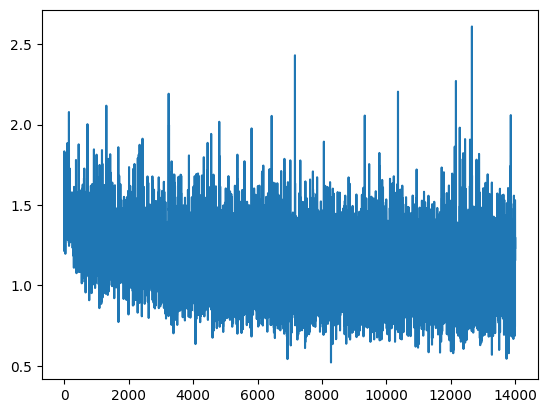

In [16]:
plt.plot(train_losses)

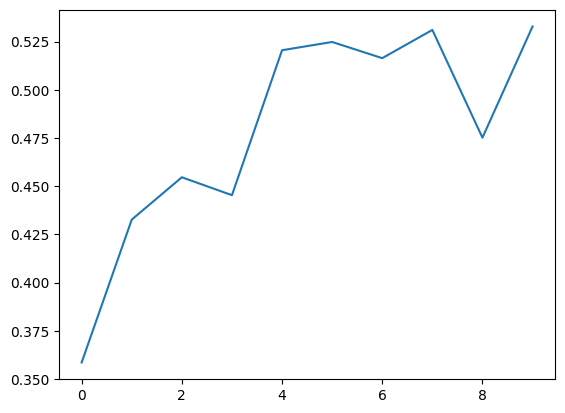

In [17]:
plt.plot(test_accuracy)

In [18]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [19]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 2984/5600 (0.5329)
{'acc_detail': tensor([0.6257, 0.7771, 0.4921, 0.2364], device='cuda:0'),
 'acc_unweighted': tensor(0.5329, device='cuda:0'),
 'acc_weighted': tensor(0.5329, device='cuda:0'),
 'f1s_detail': tensor([0.6046, 0.5820, 0.5775, 0.3041], device='cuda:0'),
 'f1s_unweighted': tensor(0.5170, device='cuda:0'),
 'f1s_weighted': tensor(0.5170, device='cuda:0'),
 'precision_detail': tensor([0.5848, 0.4652, 0.6988, 0.4260], device='cuda:0'),
 'recall_detail': tensor([0.6257, 0.7771, 0.4921, 0.2364], device='cuda:0'),
 'rocauc': tensor(0.8008, device='cuda:0'),
 'rocauc_detail': tensor([0.8391, 0.8183, 0.8399, 0.7058], device='cuda:0'),
 'uar': tensor(0.5329, device='cuda:0'),
 'wap': tensor(0.5437, device='cuda:0')}


tensor([[ 876,  212,   65,  247],
        [  36, 1088,  165,  111],
        [ 111,  512,  689,   88],
        [ 475,  527,   67,  331]], device='cuda:0')

In [20]:
model_path = '../models_esd4/esd4_m13ser_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [21]:
n_epoch = 10
n_epoch2 = 50

best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m13ser_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                  | 0.0005714285714285715/50 [00:00<10:40:25, 768.52s/it]

Train Epoch: 11 [0/22400 (0%)]	Loss: 1.038037
Mem before-during-after: 41695744 5334578176 45312512


  0%|                                                                   | 0.023428571428571413/50 [00:19<12:12:23, 879.28s/it]

Train Epoch: 11 [640/22400 (3%)]	Loss: 0.980816
Mem before-during-after: 45312512 5333500928 45735424


  0%|                                                                  | 0.046285714285714215/50 [00:38<14:58:29, 1079.18s/it]

Train Epoch: 11 [1280/22400 (6%)]	Loss: 1.140211
Mem before-during-after: 45336064 5337844736 46117376


  0%|                                                                    | 0.06914285714285702/50 [00:57<13:09:30, 948.72s/it]

Train Epoch: 11 [1920/22400 (9%)]	Loss: 0.724885
Mem before-during-after: 46165504 5337493504 45735424


  0%|▏                                                                   | 0.09199999999999982/50 [01:16<12:50:12, 925.96s/it]

Train Epoch: 11 [2560/22400 (11%)]	Loss: 1.215044
Mem before-during-after: 45739520 5332985856 45312512


  0%|▏                                                                   | 0.11485714285714262/50 [01:36<12:58:51, 936.79s/it]

Train Epoch: 11 [3200/22400 (14%)]	Loss: 1.252793
Mem before-during-after: 45312512 5041972736 45336064


  0%|▏                                                                   | 0.13771428571428573/50 [01:54<13:38:13, 984.59s/it]

Train Epoch: 11 [3840/22400 (17%)]	Loss: 0.951081
Mem before-during-after: 45312512 5336241152 45312512


  0%|▏                                                                    | 0.1605714285714291/50 [02:14<13:47:11, 995.82s/it]

Train Epoch: 11 [4480/22400 (20%)]	Loss: 1.147092
Mem before-during-after: 45312512 5336437760 45312512


  0%|▏                                                                   | 0.18342857142857244/50 [02:32<13:18:41, 961.96s/it]

Train Epoch: 11 [5120/22400 (23%)]	Loss: 0.972627
Mem before-during-after: 45312512 5327438336 45312512


  0%|▎                                                                    | 0.2062857142857158/50 [02:52<12:56:38, 935.83s/it]

Train Epoch: 11 [5760/22400 (26%)]	Loss: 0.973991
Mem before-during-after: 45735424 5333063680 45336064


  0%|▎                                                                   | 0.22914285714285915/50 [03:11<12:48:42, 926.69s/it]

Train Epoch: 11 [6400/22400 (29%)]	Loss: 0.946040
Mem before-during-after: 45312512 5332046848 45312512


  1%|▎                                                                    | 0.2520000000000024/50 [03:30<12:21:32, 894.35s/it]

Train Epoch: 11 [7040/22400 (31%)]	Loss: 0.870723
Mem before-during-after: 45475328 5304243200 45599232


  1%|▎                                                                   | 0.27485714285714463/50 [03:49<12:18:23, 890.97s/it]

Train Epoch: 11 [7680/22400 (34%)]	Loss: 0.926507
Mem before-during-after: 45312512 5334874624 46170112


  1%|▍                                                                    | 0.2977142857142869/50 [04:08<12:06:04, 876.52s/it]

Train Epoch: 11 [8320/22400 (37%)]	Loss: 0.932283
Mem before-during-after: 45312512 5333787136 45573120


  1%|▍                                                                    | 0.3205714285714291/50 [04:27<13:30:08, 978.44s/it]

Train Epoch: 11 [8960/22400 (40%)]	Loss: 0.999255
Mem before-during-after: 45735424 5332869120 45735424


  1%|▍                                                                   | 0.34342857142857136/50 [04:46<12:15:16, 888.43s/it]

Train Epoch: 11 [9600/22400 (43%)]	Loss: 1.059089
Mem before-during-after: 45312512 5332093952 45336064


  1%|▌                                                                    | 0.3662857142857136/50 [05:04<12:11:46, 884.62s/it]

Train Epoch: 11 [10240/22400 (46%)]	Loss: 0.984122
Mem before-during-after: 45549568 5332046848 45312512


  1%|▌                                                                   | 0.38914285714285585/50 [05:23<12:46:15, 926.73s/it]

Train Epoch: 11 [10880/22400 (49%)]	Loss: 1.076792
Mem before-during-after: 45312512 4540017664 45768192


  1%|▌                                                                    | 0.4119999999999981/50 [05:42<13:30:49, 981.08s/it]

Train Epoch: 11 [11520/22400 (51%)]	Loss: 1.131430
Mem before-during-after: 45312512 4666279424 45728256


  1%|▌                                                                   | 0.43485714285714033/50 [06:02<13:06:58, 952.65s/it]

Train Epoch: 11 [12160/22400 (54%)]	Loss: 0.893862
Mem before-during-after: 45735424 5332683264 45549568


  1%|▋                                                                    | 0.4577142857142826/50 [06:20<13:40:18, 993.47s/it]

Train Epoch: 11 [12800/22400 (57%)]	Loss: 0.894533
Mem before-during-after: 45336064 5336664064 45735424


  1%|▋                                                                    | 0.4805714285714248/50 [06:40<12:31:43, 910.82s/it]

Train Epoch: 11 [13440/22400 (60%)]	Loss: 0.922028
Mem before-during-after: 45336064 5332903936 45336064


  1%|▋                                                                    | 0.5034285714285671/50 [06:58<12:51:06, 934.74s/it]

Train Epoch: 11 [14080/22400 (63%)]	Loss: 0.736617
Mem before-during-after: 45735424 5332070400 45336064


  1%|▋                                                                    | 0.5262857142857094/50 [07:17<12:48:54, 932.51s/it]

Train Epoch: 11 [14720/22400 (66%)]	Loss: 1.120772
Mem before-during-after: 45735424 5332046848 45312512


  1%|▊                                                                    | 0.5491428571428516/50 [07:36<12:07:17, 882.44s/it]

Train Epoch: 11 [15360/22400 (69%)]	Loss: 0.906120
Mem before-during-after: 45312512 5270780928 45312512


  1%|▊                                                                    | 0.5719999999999938/50 [07:55<12:31:47, 912.59s/it]

Train Epoch: 11 [16000/22400 (71%)]	Loss: 1.093288
Mem before-during-after: 45332992 5333550080 45784576


  1%|▊                                                                    | 0.5948571428571361/50 [08:14<12:04:59, 880.47s/it]

Train Epoch: 11 [16640/22400 (74%)]	Loss: 1.010473
Mem before-during-after: 45312512 5333787136 45573120


  1%|▊                                                                    | 0.6177142857142783/50 [08:32<12:02:18, 877.61s/it]

Train Epoch: 11 [17280/22400 (77%)]	Loss: 0.765279
Mem before-during-after: 45312512 5332046848 45312512


  1%|▉                                                                    | 0.6405714285714206/50 [08:51<13:09:44, 959.98s/it]

Train Epoch: 11 [17920/22400 (80%)]	Loss: 0.866668
Mem before-during-after: 45312512 5337069568 46140928


  1%|▉                                                                    | 0.6634285714285628/50 [09:09<13:02:17, 951.37s/it]

Train Epoch: 11 [18560/22400 (83%)]	Loss: 0.986827
Mem before-during-after: 46292480 4502621184 45758976


  1%|▉                                                                    | 0.6862857142857051/50 [09:28<12:04:10, 881.10s/it]

Train Epoch: 11 [19200/22400 (86%)]	Loss: 0.977617
Mem before-during-after: 45972480 5334698496 46158336


  1%|▉                                                                    | 0.7091428571428473/50 [09:47<13:14:27, 967.07s/it]

Train Epoch: 11 [19840/22400 (89%)]	Loss: 1.516744
Mem before-during-after: 45312512 5336299520 45336064


  1%|█                                                                    | 0.7319999999999895/50 [10:06<12:36:20, 921.09s/it]

Train Epoch: 11 [20480/22400 (91%)]	Loss: 1.036394
Mem before-during-after: 45312512 5332070400 45336064


  2%|█                                                                    | 0.7548571428571318/50 [10:25<12:31:12, 915.27s/it]

Train Epoch: 11 [21120/22400 (94%)]	Loss: 0.974283
Mem before-during-after: 45972480 5332046848 45312512


  2%|█                                                                     | 0.777714285714274/50 [10:43<12:31:18, 915.81s/it]

Train Epoch: 11 [21760/22400 (97%)]	Loss: 0.960594
Mem before-during-after: 45312512 5333338624 45573120


  2%|█▍                                                                    | 0.9999999999999823/50 [12:29<6:00:03, 440.88s/it]


Test Epoch: 11	Accuracy: 3036/5600 (54%)

saved model: ../models_esd4/esd4_m13ser_best_11epoch.pt


  2%|█▍                                                                     | 1.000571428571411/50 [12:29<7:25:15, 545.21s/it]

Train Epoch: 12 [0/22400 (0%)]	Loss: 1.080430
Mem before-during-after: 45305344 5338211328 46251520


  2%|█▍                                                                  | 1.0234285714285576/50 [12:48<13:43:06, 1008.37s/it]

Train Epoch: 12 [640/22400 (3%)]	Loss: 0.793287
Mem before-during-after: 45548032 5374885376 45516800


  2%|█▍                                                                   | 1.0462857142857043/50 [13:08<13:19:30, 979.91s/it]

Train Epoch: 12 [1280/22400 (6%)]	Loss: 1.329861
Mem before-during-after: 45312512 5276041216 46116352


  2%|█▍                                                                    | 1.069142857142851/50 [13:27<12:29:08, 918.61s/it]

Train Epoch: 12 [1920/22400 (9%)]	Loss: 1.082467
Mem before-during-after: 45336064 5333035008 45549568


  2%|█▌                                                                   | 1.0919999999999976/50 [13:46<11:57:46, 880.57s/it]

Train Epoch: 12 [2560/22400 (11%)]	Loss: 0.749988
Mem before-during-after: 45784576 5332495360 45312512


  2%|█▌                                                                   | 1.1148571428571443/50 [14:06<12:22:19, 911.11s/it]

Train Epoch: 12 [3200/22400 (14%)]	Loss: 0.585141
Mem before-during-after: 46343680 5333009408 46275072


  2%|█▌                                                                    | 1.137714285714291/50 [14:24<12:06:55, 892.62s/it]

Train Epoch: 12 [3840/22400 (17%)]	Loss: 0.871975
Mem before-during-after: 45312512 5333078016 45312512


  2%|█▌                                                                   | 1.1605714285714377/50 [14:43<12:04:26, 889.99s/it]

Train Epoch: 12 [4480/22400 (20%)]	Loss: 1.466786
Mem before-during-after: 45312512 5332046848 45312512


  2%|█▋                                                                   | 1.1834285714285844/50 [15:02<11:56:16, 880.36s/it]

Train Epoch: 12 [5120/22400 (23%)]	Loss: 0.929642
Mem before-during-after: 45336064 5333009408 46275072


  2%|█▋                                                                    | 1.206285714285731/50 [15:20<11:56:43, 881.33s/it]

Train Epoch: 12 [5760/22400 (26%)]	Loss: 0.602307
Mem before-during-after: 46251520 5332495360 45312512


  2%|█▋                                                                  | 1.2291428571428777/50 [15:39<13:47:28, 1018.00s/it]

Train Epoch: 12 [6400/22400 (29%)]	Loss: 1.096463
Mem before-during-after: 45312512 5336241152 45312512


  3%|█▋                                                                   | 1.2520000000000244/50 [15:58<13:13:26, 976.58s/it]

Train Epoch: 12 [7040/22400 (31%)]	Loss: 1.362074
Mem before-during-after: 45312512 5336264704 45336064


  3%|█▊                                                                    | 1.274857142857171/50 [16:17<12:25:07, 917.54s/it]

Train Epoch: 12 [7680/22400 (34%)]	Loss: 0.906411
Mem before-during-after: 45312512 5332046848 45312512


  3%|█▊                                                                   | 1.2977142857143178/50 [16:36<12:07:38, 896.44s/it]

Train Epoch: 12 [8320/22400 (37%)]	Loss: 0.943100
Mem before-during-after: 45573120 5333292032 46158336


  3%|█▊                                                                   | 1.3205714285714645/50 [16:54<11:52:58, 878.77s/it]

Train Epoch: 12 [8960/22400 (40%)]	Loss: 0.715284
Mem before-during-after: 45312512 5333078016 45312512


  3%|█▊                                                                   | 1.3434285714286112/50 [17:13<11:57:51, 885.20s/it]

Train Epoch: 12 [9600/22400 (43%)]	Loss: 1.199973
Mem before-during-after: 45808128 5333038080 45808128


  3%|█▉                                                                   | 1.3662857142857578/50 [17:32<13:26:58, 995.58s/it]

Train Epoch: 12 [10240/22400 (46%)]	Loss: 0.884589
Mem before-during-after: 45312512 5337562112 45718016


  3%|█▉                                                                   | 1.3891428571429045/50 [17:51<12:36:25, 933.64s/it]

Train Epoch: 12 [10880/22400 (49%)]	Loss: 1.322443
Mem before-during-after: 45312512 5332046848 45312512


  3%|█▉                                                                   | 1.4120000000000512/50 [18:10<12:20:09, 914.00s/it]

Train Epoch: 12 [11520/22400 (51%)]	Loss: 1.667554
Mem before-during-after: 45336064 4878601216 45336064


  3%|██                                                                    | 1.434857142857198/50 [18:28<11:54:02, 882.16s/it]

Train Epoch: 12 [12160/22400 (54%)]	Loss: 0.726378
Mem before-during-after: 45336064 5332070400 45336064


  3%|██                                                                   | 1.4577142857143446/50 [18:48<12:54:34, 957.41s/it]

Train Epoch: 12 [12800/22400 (57%)]	Loss: 0.796052
Mem before-during-after: 45336064 5332046848 45312512


  3%|██                                                                   | 1.4805714285714913/50 [19:06<11:52:57, 881.66s/it]

Train Epoch: 12 [13440/22400 (60%)]	Loss: 0.984910
Mem before-during-after: 45336064 5332542464 45808128


  3%|██                                                                    | 1.503428571428638/50 [19:25<11:52:07, 881.05s/it]

Train Epoch: 12 [14080/22400 (63%)]	Loss: 1.083613
Mem before-during-after: 45312512 5332046848 45312512


  3%|██                                                                   | 1.5262857142857846/50 [19:44<12:19:07, 914.89s/it]

Train Epoch: 12 [14720/22400 (66%)]	Loss: 1.023665
Mem before-during-after: 46367232 5332518912 45784576


  3%|██▏                                                                  | 1.5491428571429313/50 [20:03<11:51:45, 881.42s/it]

Train Epoch: 12 [15360/22400 (69%)]	Loss: 0.770385
Mem before-during-after: 45312512 5332070400 45336064


  3%|██▏                                                                   | 1.572000000000078/50 [20:22<11:51:58, 882.11s/it]

Train Epoch: 12 [16000/22400 (71%)]	Loss: 0.854779
Mem before-during-after: 45312512 5332046848 45312512


  3%|██▏                                                                 | 1.5948571428572247/50 [20:41<13:46:23, 1024.35s/it]

Train Epoch: 12 [16640/22400 (74%)]	Loss: 1.315890
Mem before-during-after: 45336064 5336741376 45413376


  3%|██▏                                                                  | 1.6177142857143714/50 [21:01<12:55:53, 962.20s/it]

Train Epoch: 12 [17280/22400 (77%)]	Loss: 0.760390
Mem before-during-after: 45955584 5332469760 45735424


  3%|██▎                                                                   | 1.640571428571518/50 [21:20<11:49:38, 880.46s/it]

Train Epoch: 12 [17920/22400 (80%)]	Loss: 1.054930
Mem before-during-after: 45312512 5332070400 45336064


  3%|██▎                                                                  | 1.6634285714286647/50 [21:39<12:33:11, 934.93s/it]

Train Epoch: 12 [18560/22400 (83%)]	Loss: 0.873951
Mem before-during-after: 45611008 5332046848 45312512


  3%|██▎                                                                  | 1.6862857142858114/50 [21:58<11:53:37, 886.23s/it]

Train Epoch: 12 [19200/22400 (86%)]	Loss: 0.831954
Mem before-during-after: 45312512 5332046848 45312512


  3%|██▍                                                                   | 1.709142857142958/50 [22:17<11:56:38, 890.40s/it]

Train Epoch: 12 [19840/22400 (89%)]	Loss: 1.171307
Mem before-during-after: 45549568 5332046848 45312512


  3%|██▎                                                                 | 1.7320000000001048/50 [22:37<13:37:30, 1016.20s/it]

Train Epoch: 12 [20480/22400 (91%)]	Loss: 0.985726
Mem before-during-after: 45312512 5337738752 45659648


  4%|██▍                                                                  | 1.7548571428572515/50 [22:55<11:43:07, 874.45s/it]

Train Epoch: 12 [21120/22400 (94%)]	Loss: 1.063487
Mem before-during-after: 45312512 5332046848 45312512


  4%|██▍                                                                  | 1.7777142857143982/50 [23:14<12:43:51, 950.43s/it]

Train Epoch: 12 [21760/22400 (97%)]	Loss: 1.109463
Mem before-during-after: 45312512 5337133056 45312512


  4%|██▊                                                                   | 2.0000000000001497/50 [25:00<5:51:40, 439.60s/it]


Test Epoch: 12	Accuracy: 3065/5600 (55%)

saved model: ../models_esd4/esd4_m13ser_best_12epoch.pt


  4%|██▊                                                                    | 2.000571428571578/50 [25:00<7:17:08, 546.44s/it]

Train Epoch: 13 [0/22400 (0%)]	Loss: 1.075727
Mem before-during-after: 45305344 5169142784 45312512


  4%|██▊                                                                   | 2.023428571428716/50 [25:19<12:32:00, 940.47s/it]

Train Epoch: 13 [640/22400 (3%)]	Loss: 1.014536
Mem before-during-after: 45336064 4919382528 45787648


  4%|██▊                                                                  | 2.0462857142858537/50 [25:38<11:42:53, 879.46s/it]

Train Epoch: 13 [1280/22400 (6%)]	Loss: 1.077783
Mem before-during-after: 45336064 5332046848 45312512


  4%|██▊                                                                  | 2.0691428571429915/50 [25:56<12:55:01, 970.17s/it]

Train Epoch: 13 [1920/22400 (9%)]	Loss: 1.135248
Mem before-during-after: 45995520 5333521920 46388224


  4%|██▉                                                                  | 2.0920000000001293/50 [26:15<12:11:27, 916.08s/it]

Train Epoch: 13 [2560/22400 (11%)]	Loss: 1.052260
Mem before-during-after: 45808128 5333434368 46251520


  4%|██▉                                                                   | 2.114857142857267/50 [26:34<12:16:37, 922.99s/it]

Train Epoch: 13 [3200/22400 (14%)]	Loss: 1.257481
Mem before-during-after: 45573120 4710666752 45312512


  4%|██▉                                                                   | 2.137714285714405/50 [26:54<13:00:29, 978.42s/it]

Train Epoch: 13 [3840/22400 (17%)]	Loss: 0.999465
Mem before-during-after: 45336064 5336415232 45486592


  4%|██▉                                                                  | 2.1605714285715427/50 [27:13<12:09:19, 914.71s/it]

Train Epoch: 13 [4480/22400 (20%)]	Loss: 0.977263
Mem before-during-after: 46300160 5332941824 46207488


  4%|███                                                                  | 2.1834285714286805/50 [27:32<11:41:32, 880.28s/it]

Train Epoch: 13 [5120/22400 (23%)]	Loss: 1.244032
Mem before-during-after: 46298624 5332070400 45336064


  4%|███                                                                  | 2.2062857142858183/50 [27:51<11:46:31, 886.98s/it]

Train Epoch: 13 [5760/22400 (26%)]	Loss: 1.064779
Mem before-during-after: 45312512 5333293056 45784576


  4%|███                                                                   | 2.229142857142956/50 [28:09<12:44:10, 959.80s/it]

Train Epoch: 13 [6400/22400 (29%)]	Loss: 1.633490
Mem before-during-after: 45312512 4919700992 46106112


  5%|███▏                                                                  | 2.252000000000094/50 [28:28<11:44:39, 885.48s/it]

Train Epoch: 13 [7040/22400 (31%)]	Loss: 1.362022
Mem before-during-after: 45312512 5332518912 45312512


  5%|███▏                                                                 | 2.2748571428572317/50 [28:47<12:08:54, 916.38s/it]

Train Epoch: 13 [7680/22400 (34%)]	Loss: 1.073072
Mem before-during-after: 45758976 5332070400 45336064


  5%|███▏                                                                 | 2.2977142857143695/50 [29:06<12:02:27, 908.72s/it]

Train Epoch: 13 [8320/22400 (37%)]	Loss: 0.743843
Mem before-during-after: 45549568 5332046848 45312512


  5%|███▏                                                                | 2.3205714285715073/50 [29:25<13:20:58, 1007.95s/it]

Train Epoch: 13 [8960/22400 (40%)]	Loss: 0.986462
Mem before-during-after: 45312512 5337063424 45735424


  5%|███▎                                                                  | 2.343428571428645/50 [29:44<11:51:29, 895.78s/it]

Train Epoch: 13 [9600/22400 (43%)]	Loss: 0.976863
Mem before-during-after: 45312512 5332236800 45502464


  5%|███▎                                                                 | 2.366285714285783/50 [30:03<13:18:56, 1006.35s/it]

Train Epoch: 13 [10240/22400 (46%)]	Loss: 1.057129
Mem before-during-after: 46158336 5328683520 46158336


  5%|███▏                                                                | 2.3891428571429207/50 [30:23<14:42:36, 1112.27s/it]

Train Epoch: 13 [10880/22400 (49%)]	Loss: 1.384962
Mem before-during-after: 45727232 5337486336 46158336


  5%|███▎                                                                 | 2.4120000000000585/50 [30:42<11:34:30, 875.66s/it]

Train Epoch: 13 [11520/22400 (51%)]	Loss: 1.056058
Mem before-during-after: 45312512 5332070400 45336064


  5%|███▎                                                                 | 2.4348571428571963/50 [31:01<11:38:11, 880.72s/it]

Train Epoch: 13 [12160/22400 (54%)]	Loss: 0.820263
Mem before-during-after: 45359616 5332070400 45336064


  5%|███▍                                                                  | 2.457714285714334/50 [31:20<12:25:33, 940.91s/it]

Train Epoch: 13 [12800/22400 (57%)]	Loss: 1.173174
Mem before-during-after: 46338560 5332469760 45735424


  5%|███▍                                                                  | 2.480571428571472/50 [31:39<11:38:15, 881.66s/it]

Train Epoch: 13 [13440/22400 (60%)]	Loss: 1.075752
Mem before-during-after: 45312512 5333920768 47186432


  5%|███▍                                                                 | 2.5034285714286098/50 [31:59<12:30:08, 947.62s/it]

Train Epoch: 13 [14080/22400 (63%)]	Loss: 0.735674
Mem before-during-after: 45735424 5332046848 45312512


  5%|███▍                                                                 | 2.5262857142857476/50 [32:17<12:36:51, 956.57s/it]

Train Epoch: 13 [14720/22400 (66%)]	Loss: 0.814071
Mem before-during-after: 46170112 5327438336 45312512


  5%|███▌                                                                 | 2.5491428571428854/50 [32:36<11:32:57, 876.22s/it]

Train Epoch: 13 [15360/22400 (69%)]	Loss: 0.888927
Mem before-during-after: 45312512 5332046848 45312512


  5%|███▌                                                                  | 2.572000000000023/50 [32:55<11:40:42, 886.45s/it]

Train Epoch: 13 [16000/22400 (71%)]	Loss: 0.983786
Mem before-during-after: 45359616 5332046848 45312512


  5%|███▋                                                                  | 2.594857142857161/50 [33:14<11:56:00, 906.24s/it]

Train Epoch: 13 [16640/22400 (74%)]	Loss: 0.811699
Mem before-during-after: 46262784 5332070400 45336064


  5%|███▌                                                                 | 2.6177142857142988/50 [33:33<11:51:00, 900.35s/it]

Train Epoch: 13 [17280/22400 (77%)]	Loss: 0.808289
Mem before-during-after: 45455360 5333663744 46231040


  5%|███▋                                                                 | 2.6405714285714366/50 [33:52<12:11:04, 926.21s/it]

Train Epoch: 13 [17920/22400 (80%)]	Loss: 1.177292
Mem before-during-after: 45549568 5332046848 45312512


  5%|███▋                                                                 | 2.6634285714285744/50 [34:10<11:34:26, 880.22s/it]

Train Epoch: 13 [18560/22400 (83%)]	Loss: 0.808959
Mem before-during-after: 46158336 5333857280 45972480


  5%|███▊                                                                  | 2.686285714285712/50 [34:29<11:43:03, 891.57s/it]

Train Epoch: 13 [19200/22400 (86%)]	Loss: 0.869287
Mem before-during-after: 45735424 5332046848 45312512


  5%|███▊                                                                   | 2.70914285714285/50 [34:49<11:49:37, 900.34s/it]

Train Epoch: 13 [19840/22400 (89%)]	Loss: 0.927798
Mem before-during-after: 45336064 5332283904 45549568


  5%|███▊                                                                 | 2.7319999999999878/50 [35:08<11:35:09, 882.41s/it]

Train Epoch: 13 [20480/22400 (91%)]	Loss: 0.928865
Mem before-during-after: 45359616 5332070400 45336064


  6%|███▊                                                                 | 2.7548571428571256/50 [35:28<12:46:11, 973.03s/it]

Train Epoch: 13 [21120/22400 (94%)]	Loss: 0.870245
Mem before-during-after: 45312512 5332869120 45735424


  6%|███▊                                                                 | 2.7777142857142634/50 [35:46<11:31:00, 877.98s/it]

Train Epoch: 13 [21760/22400 (97%)]	Loss: 0.909399
Mem before-during-after: 45312512 5332046848 45312512


  6%|████▏                                                                 | 2.9999999999999285/50 [37:32<5:45:23, 440.93s/it]


Test Epoch: 13	Accuracy: 3111/5600 (56%)

saved model: ../models_esd4/esd4_m13ser_best_13epoch.pt


  6%|████▎                                                                  | 3.000571428571357/50 [37:32<7:07:23, 545.61s/it]

Train Epoch: 14 [0/22400 (0%)]	Loss: 0.901014
Mem before-during-after: 45305344 5338211328 46251520


  6%|████▏                                                                | 3.0234285714284947/50 [37:51<12:50:34, 984.20s/it]

Train Epoch: 14 [640/22400 (3%)]	Loss: 1.066951
Mem before-during-after: 45735424 5334819840 45735424


  6%|████▏                                                                | 3.0462857142856326/50 [38:09<12:43:05, 975.13s/it]

Train Epoch: 14 [1280/22400 (6%)]	Loss: 0.967349
Mem before-during-after: 46839296 5336804352 45875712


  6%|████▏                                                                | 3.0691428571427704/50 [38:28<12:33:32, 963.38s/it]

Train Epoch: 14 [1920/22400 (9%)]	Loss: 0.899149
Mem before-during-after: 45758976 5332070400 45336064


  6%|████▎                                                                 | 3.091999999999908/50 [38:47<13:00:25, 998.23s/it]

Train Epoch: 14 [2560/22400 (11%)]	Loss: 1.067949
Mem before-during-after: 45312512 5337035776 46107136


  6%|████▎                                                                 | 3.114857142857046/50 [39:06<12:41:24, 974.39s/it]

Train Epoch: 14 [3200/22400 (14%)]	Loss: 1.014934
Mem before-during-after: 45312512 5344761344 45735424


  6%|████▎                                                                | 3.1377142857141838/50 [39:24<12:21:27, 949.33s/it]

Train Epoch: 14 [3840/22400 (17%)]	Loss: 1.003698
Mem before-during-after: 45336064 5332088832 45354496


  6%|████▎                                                                | 3.1605714285713216/50 [39:43<11:40:50, 897.76s/it]

Train Epoch: 14 [4480/22400 (20%)]	Loss: 1.083230
Mem before-during-after: 45858304 5333542912 45312512


  6%|████▎                                                               | 3.1834285714284594/50 [40:02<13:23:13, 1029.42s/it]

Train Epoch: 14 [5120/22400 (23%)]	Loss: 0.704773
Mem before-during-after: 45312512 5336241152 45312512


  6%|████▍                                                                 | 3.206285714285597/50 [40:22<12:59:03, 998.93s/it]

Train Epoch: 14 [5760/22400 (26%)]	Loss: 1.063262
Mem before-during-after: 45336064 5338089984 45758976


  6%|████▌                                                                 | 3.229142857142735/50 [40:42<12:42:24, 978.05s/it]

Train Epoch: 14 [6400/22400 (29%)]	Loss: 0.955313
Mem before-during-after: 45758976 5332706816 45573120


  7%|████▍                                                               | 3.2519999999998728/50 [41:01<13:12:13, 1016.81s/it]

Train Epoch: 14 [7040/22400 (31%)]	Loss: 0.935299
Mem before-during-after: 45312512 5344226304 46158336


  7%|████▌                                                                | 3.2748571428570106/50 [41:19<11:31:27, 887.91s/it]

Train Epoch: 14 [7680/22400 (34%)]	Loss: 1.162495
Mem before-during-after: 45357568 5332046848 45312512


  7%|████▌                                                                | 3.2977142857141484/50 [41:38<11:28:52, 885.01s/it]

Train Epoch: 14 [8320/22400 (37%)]	Loss: 0.750741
Mem before-during-after: 45735424 5332518912 45336064


  7%|████▋                                                                 | 3.320571428571286/50 [41:57<11:24:13, 879.47s/it]

Train Epoch: 14 [8960/22400 (40%)]	Loss: 0.994206
Mem before-during-after: 45336064 5333810688 45596672


  7%|████▋                                                                 | 3.343428571428424/50 [42:16<12:23:25, 956.04s/it]

Train Epoch: 14 [9600/22400 (43%)]	Loss: 0.708531
Mem before-during-after: 45735424 4921269760 45692928


  7%|████▋                                                                 | 3.366285714285562/50 [42:35<12:06:54, 935.26s/it]

Train Epoch: 14 [10240/22400 (46%)]	Loss: 0.772899
Mem before-during-after: 45735424 5332469760 45735424


  7%|████▋                                                                | 3.3891428571426996/50 [42:53<11:34:33, 894.07s/it]

Train Epoch: 14 [10880/22400 (49%)]	Loss: 0.881629
Mem before-during-after: 45312512 5332209664 45475328


  7%|████▋                                                                | 3.4119999999998374/50 [43:12<12:09:14, 939.17s/it]

Train Epoch: 14 [11520/22400 (51%)]	Loss: 0.889429
Mem before-during-after: 45735424 5332046848 45312512


  7%|████▊                                                                 | 3.434857142856975/50 [43:31<12:16:09, 948.56s/it]

Train Epoch: 14 [12160/22400 (54%)]	Loss: 0.918262
Mem before-during-after: 45752832 5332986368 45758976


  7%|████▊                                                                 | 3.457714285714113/50 [43:50<12:01:29, 930.11s/it]

Train Epoch: 14 [12800/22400 (57%)]	Loss: 1.194985
Mem before-during-after: 45312512 4587530240 45800960


  7%|████▊                                                                 | 3.480571428571251/50 [44:09<12:00:47, 929.66s/it]

Train Epoch: 14 [13440/22400 (60%)]	Loss: 1.294977
Mem before-during-after: 45336064 4915073024 46086656


  7%|████▊                                                                | 3.5034285714283886/50 [44:28<11:55:51, 923.77s/it]

Train Epoch: 14 [14080/22400 (63%)]	Loss: 1.068110
Mem before-during-after: 45573120 5333101568 46343680


  7%|████▊                                                               | 3.5262857142855264/50 [44:47<13:18:46, 1031.26s/it]

Train Epoch: 14 [14720/22400 (66%)]	Loss: 0.805809
Mem before-during-after: 45758976 5332869120 45735424


  7%|████▉                                                                | 3.549142857142664/50 [45:07<13:02:52, 1011.23s/it]

Train Epoch: 14 [15360/22400 (69%)]	Loss: 1.038196
Mem before-during-after: 45336064 5166307840 45988864


  7%|█████                                                                 | 3.571999999999802/50 [45:26<11:34:42, 897.80s/it]

Train Epoch: 14 [16000/22400 (71%)]	Loss: 0.910699
Mem before-during-after: 45573120 5333053952 45312512


  7%|█████                                                                  | 3.59485714285694/50 [45:46<11:22:25, 882.35s/it]

Train Epoch: 14 [16640/22400 (74%)]	Loss: 0.792517
Mem before-during-after: 45784576 5332495360 45312512


  7%|████▉                                                                | 3.6177142857140776/50 [46:04<11:29:33, 892.00s/it]

Train Epoch: 14 [17280/22400 (77%)]	Loss: 1.163375
Mem before-during-after: 45336064 5332283904 45549568


  7%|████▉                                                               | 3.6405714285712154/50 [46:23<13:00:20, 1009.95s/it]

Train Epoch: 14 [17920/22400 (80%)]	Loss: 0.781621
Mem before-during-after: 46251520 5332962304 45336064


  7%|█████▏                                                                | 3.663428571428353/50 [46:42<11:51:37, 921.46s/it]

Train Epoch: 14 [18560/22400 (83%)]	Loss: 1.029727
Mem before-during-after: 45312512 5332046848 45312512


  7%|█████▏                                                                | 3.686285714285491/50 [47:01<12:21:06, 960.12s/it]

Train Epoch: 14 [19200/22400 (86%)]	Loss: 1.097286
Mem before-during-after: 45645312 5332779008 45735424


  7%|█████▏                                                                | 3.709142857142629/50 [47:20<11:40:13, 907.61s/it]

Train Epoch: 14 [19840/22400 (89%)]	Loss: 0.735439
Mem before-during-after: 46021632 5332889088 45784576


  7%|█████▏                                                               | 3.7319999999997666/50 [47:39<11:17:34, 878.67s/it]

Train Epoch: 14 [20480/22400 (91%)]	Loss: 0.940452
Mem before-during-after: 45573120 5333526016 45784576


  8%|█████▏                                                               | 3.7548571428569044/50 [47:58<12:30:00, 973.09s/it]

Train Epoch: 14 [21120/22400 (94%)]	Loss: 0.782738
Mem before-during-after: 45312512 5332914688 45312512


  8%|█████▎                                                                | 3.777714285714042/50 [48:17<12:35:57, 981.30s/it]

Train Epoch: 14 [21760/22400 (97%)]	Loss: 0.774403
Mem before-during-after: 45924864 5336241152 45312512


  8%|█████▌                                                                | 3.9999999999997073/50 [50:04<5:37:56, 440.78s/it]


Test Epoch: 14	Accuracy: 3051/5600 (54%)



  8%|█████▋                                                                 | 4.000571428571136/50 [50:04<6:57:26, 544.50s/it]

Train Epoch: 15 [0/22400 (0%)]	Loss: 0.926701
Mem before-during-after: 45305344 5338211328 46251520


  8%|█████▋                                                                | 4.023428571428291/50 [50:23<11:35:52, 908.13s/it]

Train Epoch: 15 [640/22400 (3%)]	Loss: 0.755981
Mem before-during-after: 45735424 5328407552 45735424


  8%|█████▋                                                                | 4.046285714285447/50 [50:43<11:26:07, 895.84s/it]

Train Epoch: 15 [1280/22400 (6%)]	Loss: 1.282172
Mem before-during-after: 45573120 5332542464 45808128


  8%|█████▌                                                              | 4.0691428571426025/50 [51:03<12:53:59, 1011.07s/it]

Train Epoch: 15 [1920/22400 (9%)]	Loss: 1.272815
Mem before-during-after: 45312512 5333033984 45735424


  8%|█████▋                                                                | 4.091999999999758/50 [51:22<11:56:51, 936.91s/it]

Train Epoch: 15 [2560/22400 (11%)]	Loss: 1.040323
Mem before-during-after: 45312512 5332046848 45312512


  8%|█████▊                                                                | 4.114857142856914/50 [51:41<11:34:37, 908.29s/it]

Train Epoch: 15 [3200/22400 (14%)]	Loss: 1.024148
Mem before-during-after: 45735424 5332046848 45312512


  8%|█████▊                                                                | 4.137714285714069/50 [52:00<12:06:29, 950.44s/it]

Train Epoch: 15 [3840/22400 (17%)]	Loss: 1.024670
Mem before-during-after: 45312512 4628160512 45833728


  8%|█████▋                                                               | 4.160571428571225/50 [52:19<13:13:33, 1038.69s/it]

Train Epoch: 15 [4480/22400 (20%)]	Loss: 1.155350
Mem before-during-after: 45336064 5336397312 45468672


  8%|█████▉                                                                 | 4.18342857142838/50 [52:38<11:12:39, 880.90s/it]

Train Epoch: 15 [5120/22400 (23%)]	Loss: 1.006153
Mem before-during-after: 45312512 5332046848 45312512


  8%|█████▉                                                                | 4.206285714285536/50 [52:56<12:09:48, 956.21s/it]

Train Epoch: 15 [5760/22400 (26%)]	Loss: 0.680074
Mem before-during-after: 45312512 5336664064 45735424


  8%|█████▊                                                               | 4.2291428571426914/50 [53:15<12:09:42, 956.57s/it]

Train Epoch: 15 [6400/22400 (29%)]	Loss: 0.875612
Mem before-during-after: 45735424 5332283904 45549568


  9%|█████▉                                                                | 4.251999999999847/50 [53:34<11:42:54, 921.90s/it]

Train Epoch: 15 [7040/22400 (31%)]	Loss: 1.141235
Mem before-during-after: 45336064 4878601216 45336064


  9%|█████▉                                                                | 4.274857142857003/50 [53:52<11:32:22, 908.52s/it]

Train Epoch: 15 [7680/22400 (34%)]	Loss: 0.923490
Mem before-during-after: 45735424 5332070400 45312512


  9%|██████                                                                | 4.297714285714158/50 [54:10<11:08:34, 877.73s/it]

Train Epoch: 15 [8320/22400 (37%)]	Loss: 1.189735
Mem before-during-after: 45312512 5333338624 45573120


  9%|██████                                                                | 4.320571428571314/50 [54:29<11:55:10, 939.39s/it]

Train Epoch: 15 [8960/22400 (40%)]	Loss: 0.744458
Mem before-during-after: 45336064 5334676480 46446592


  9%|██████                                                                | 4.343428571428469/50 [54:48<12:29:19, 984.74s/it]

Train Epoch: 15 [9600/22400 (43%)]	Loss: 0.827395
Mem before-during-after: 45312512 5332046848 45312512


  9%|██████                                                                | 4.366285714285625/50 [55:08<12:13:36, 964.57s/it]

Train Epoch: 15 [10240/22400 (46%)]	Loss: 0.660696
Mem before-during-after: 46320128 4999512576 46128640


  9%|██████▏                                                                | 4.38914285714278/50 [55:27<11:30:48, 908.74s/it]

Train Epoch: 15 [10880/22400 (49%)]	Loss: 1.495647
Mem before-during-after: 45312512 5332046848 45312512


  9%|██████▏                                                               | 4.411999999999936/50 [55:45<11:07:46, 878.88s/it]

Train Epoch: 15 [11520/22400 (51%)]	Loss: 0.960078
Mem before-during-after: 45549568 5332046848 45312512


  9%|██████                                                               | 4.4348571428570915/50 [56:04<11:08:16, 879.99s/it]

Train Epoch: 15 [12160/22400 (54%)]	Loss: 0.876654
Mem before-during-after: 45312512 5332962304 45312512


  9%|██████▏                                                              | 4.457714285714247/50 [56:23<12:44:21, 1007.01s/it]

Train Epoch: 15 [12800/22400 (57%)]	Loss: 1.365745
Mem before-during-after: 45312512 5336664064 45735424


  9%|██████▎                                                               | 4.480571428571403/50 [56:43<12:10:33, 962.97s/it]

Train Epoch: 15 [13440/22400 (60%)]	Loss: 1.195231
Mem before-during-after: 45758976 5332869120 45735424


  9%|██████▎                                                               | 4.503428571428558/50 [57:02<11:37:16, 919.56s/it]

Train Epoch: 15 [14080/22400 (63%)]	Loss: 0.930238
Mem before-during-after: 45312512 4955979264 45312512


  9%|██████▎                                                               | 4.526285714285714/50 [57:21<11:07:35, 880.86s/it]

Train Epoch: 15 [14720/22400 (66%)]	Loss: 1.129813
Mem before-during-after: 45336064 5332046848 45312512


  9%|██████▎                                                               | 4.549142857142869/50 [57:40<11:47:05, 933.43s/it]

Train Epoch: 15 [15360/22400 (69%)]	Loss: 0.682391
Mem before-during-after: 45312512 5332469760 45735424


  9%|██████▍                                                               | 4.572000000000025/50 [57:59<11:05:32, 879.03s/it]

Train Epoch: 15 [16000/22400 (71%)]	Loss: 0.995732
Mem before-during-after: 45312512 5333078016 45312512


  9%|██████▎                                                              | 4.5948571428571805/50 [58:18<11:09:00, 884.05s/it]

Train Epoch: 15 [16640/22400 (74%)]	Loss: 0.913210
Mem before-during-after: 45549568 5332070400 45336064


  9%|██████▍                                                               | 4.617714285714336/50 [58:37<11:27:52, 909.43s/it]

Train Epoch: 15 [17280/22400 (77%)]	Loss: 1.065899
Mem before-during-after: 45312512 5046348800 45312512


  9%|██████▍                                                               | 4.640571428571492/50 [58:55<11:06:34, 881.73s/it]

Train Epoch: 15 [17920/22400 (80%)]	Loss: 0.922357
Mem before-during-after: 45336064 5332046848 45312512


  9%|██████▌                                                               | 4.663428571428647/50 [59:14<11:37:51, 923.56s/it]

Train Epoch: 15 [18560/22400 (83%)]	Loss: 0.598507
Mem before-during-after: 45735424 5332070400 45312512


  9%|██████▌                                                               | 4.686285714285803/50 [59:33<11:19:02, 899.13s/it]

Train Epoch: 15 [19200/22400 (86%)]	Loss: 0.657901
Mem before-during-after: 45312512 5332070400 45336064


  9%|██████▌                                                               | 4.709142857142958/50 [59:52<11:02:49, 878.08s/it]

Train Epoch: 15 [19840/22400 (89%)]	Loss: 1.065980
Mem before-during-after: 45573120 5333053952 45312512


  9%|██████▍                                                             | 4.732000000000114/50 [1:00:10<11:03:02, 878.82s/it]

Train Epoch: 15 [20480/22400 (91%)]	Loss: 1.048030
Mem before-during-after: 45972480 5334299136 46158336


 10%|██████▎                                                            | 4.7548571428572695/50 [1:00:29<11:04:04, 880.63s/it]

Train Epoch: 15 [21120/22400 (94%)]	Loss: 1.111976
Mem before-during-after: 45972480 5334698496 46158336


 10%|██████▍                                                             | 4.777714285714425/50 [1:00:48<11:22:22, 905.36s/it]

Train Epoch: 15 [21760/22400 (97%)]	Loss: 0.966698
Mem before-during-after: 46158336 5333292032 46158336


 10%|██████▉                                                              | 5.000000000000263/50 [1:02:34<5:30:04, 440.10s/it]


Test Epoch: 15	Accuracy: 3066/5600 (55%)



 10%|██████▉                                                              | 5.000571428571692/50 [1:02:34<6:46:07, 541.51s/it]

Train Epoch: 16 [0/22400 (0%)]	Loss: 0.869929
Mem before-during-after: 45305344 5082772992 45312512


 10%|██████▋                                                            | 5.023428571428847/50 [1:02:54<13:21:41, 1069.47s/it]

Train Epoch: 16 [640/22400 (3%)]	Loss: 0.975545
Mem before-during-after: 46142976 5337695232 45735424


 10%|██████▊                                                             | 5.046285714286003/50 [1:03:13<11:05:43, 888.54s/it]

Train Epoch: 16 [1280/22400 (6%)]	Loss: 0.815558
Mem before-during-after: 45312512 5333078016 45312512


 10%|██████▊                                                            | 5.0691428571431585/50 [1:03:32<11:56:04, 956.23s/it]

Train Epoch: 16 [1920/22400 (9%)]	Loss: 0.779542
Mem before-during-after: 45972480 5334698496 46158336


 10%|██████▉                                                             | 5.092000000000314/50 [1:03:52<11:36:48, 930.98s/it]

Train Epoch: 16 [2560/22400 (11%)]	Loss: 1.057769
Mem before-during-after: 45758976 5333070848 45758976


 10%|███████                                                              | 5.11485714285747/50 [1:04:11<11:20:45, 910.01s/it]

Train Epoch: 16 [3200/22400 (14%)]	Loss: 0.997406
Mem before-during-after: 45808128 5332518912 45336064


 10%|██████▉                                                             | 5.137714285714625/50 [1:04:30<11:47:33, 946.31s/it]

Train Epoch: 16 [3840/22400 (17%)]	Loss: 1.499466
Mem before-during-after: 45758976 5333457920 45573120


 10%|███████                                                             | 5.160571428571781/50 [1:04:49<11:13:38, 901.41s/it]

Train Epoch: 16 [4480/22400 (20%)]	Loss: 0.799314
Mem before-during-after: 45312512 5332046848 45312512


 10%|███████                                                             | 5.183428571428936/50 [1:05:08<11:27:28, 920.38s/it]

Train Epoch: 16 [5120/22400 (23%)]	Loss: 0.858085
Mem before-during-after: 45336064 5332469760 45735424


 10%|███████                                                             | 5.206285714286092/50 [1:05:27<11:40:19, 938.07s/it]

Train Epoch: 16 [5760/22400 (26%)]	Loss: 0.958063
Mem before-during-after: 45500928 5333471744 45312512


 10%|██████▉                                                           | 5.2291428571432474/50 [1:05:47<12:59:52, 1045.15s/it]

Train Epoch: 16 [6400/22400 (29%)]	Loss: 0.969518
Mem before-during-after: 45336064 5336241152 45312512


 11%|███████▏                                                            | 5.252000000000403/50 [1:06:06<11:12:22, 901.54s/it]

Train Epoch: 16 [7040/22400 (31%)]	Loss: 1.017295
Mem before-during-after: 45808128 4121391616 45549568


 11%|███████                                                            | 5.274857142857559/50 [1:06:25<12:39:40, 1019.12s/it]

Train Epoch: 16 [7680/22400 (34%)]	Loss: 0.754859
Mem before-during-after: 45727232 5336664064 45735424


 11%|███████▏                                                            | 5.297714285714714/50 [1:06:44<10:54:33, 878.55s/it]

Train Epoch: 16 [8320/22400 (37%)]	Loss: 1.241314
Mem before-during-after: 45312512 5332990976 46256640


 11%|███████▎                                                             | 5.32057142857187/50 [1:07:04<10:59:49, 886.08s/it]

Train Epoch: 16 [8960/22400 (40%)]	Loss: 0.892940
Mem before-during-after: 45312512 5333500928 45735424


 11%|███████▎                                                            | 5.343428571429025/50 [1:07:23<11:19:58, 913.60s/it]

Train Epoch: 16 [9600/22400 (43%)]	Loss: 1.141631
Mem before-during-after: 45972480 5332869120 45735424


 11%|███████▎                                                            | 5.366285714286181/50 [1:07:42<11:20:32, 914.84s/it]

Train Epoch: 16 [10240/22400 (46%)]	Loss: 0.999342
Mem before-during-after: 45735424 5332283904 45549568


 11%|███████▏                                                           | 5.389142857143336/50 [1:08:01<13:06:40, 1058.05s/it]

Train Epoch: 16 [10880/22400 (49%)]	Loss: 0.984246
Mem before-during-after: 45693440 5000529408 45312512


 11%|███████▎                                                            | 5.412000000000492/50 [1:08:20<11:45:21, 949.18s/it]

Train Epoch: 16 [11520/22400 (51%)]	Loss: 0.977920
Mem before-during-after: 45312512 5338112512 45735424


 11%|███████▎                                                           | 5.4348571428576475/50 [1:08:39<11:24:39, 921.79s/it]

Train Epoch: 16 [12160/22400 (54%)]	Loss: 1.032596
Mem before-during-after: 45758976 5332706816 45573120


 11%|███████▍                                                            | 5.457714285714803/50 [1:08:58<10:51:43, 877.90s/it]

Train Epoch: 16 [12800/22400 (57%)]	Loss: 0.949781
Mem before-during-after: 45972480 5333292032 46158336


 11%|███████▍                                                            | 5.480571428571959/50 [1:09:17<12:00:43, 971.34s/it]

Train Epoch: 16 [13440/22400 (60%)]	Loss: 1.016950
Mem before-during-after: 45312512 5337099264 45501952


 11%|███████▍                                                            | 5.503428571429114/50 [1:09:35<11:34:10, 936.03s/it]

Train Epoch: 16 [14080/22400 (63%)]	Loss: 1.149457
Mem before-during-after: 45362688 5332496384 45735424


 11%|███████▋                                                             | 5.52628571428627/50 [1:09:54<11:01:05, 891.89s/it]

Train Epoch: 16 [14720/22400 (66%)]	Loss: 1.118860
Mem before-during-after: 45336064 5332542464 45312512


 11%|███████▍                                                           | 5.549142857143425/50 [1:10:14<12:41:29, 1027.87s/it]

Train Epoch: 16 [15360/22400 (69%)]	Loss: 0.890857
Mem before-during-after: 45312512 5337341952 45811200


 11%|███████▌                                                            | 5.572000000000581/50 [1:10:32<10:49:35, 877.28s/it]

Train Epoch: 16 [16000/22400 (71%)]	Loss: 0.829083
Mem before-during-after: 45312512 5332046848 45312512


 11%|███████▍                                                           | 5.5948571428577365/50 [1:10:51<11:15:23, 912.59s/it]

Train Epoch: 16 [16640/22400 (74%)]	Loss: 1.000388
Mem before-during-after: 45573120 5332518912 45336064


 11%|███████▋                                                            | 5.617714285714892/50 [1:11:10<10:58:27, 890.16s/it]

Train Epoch: 16 [17280/22400 (77%)]	Loss: 0.579262
Mem before-during-after: 45336064 5332046848 45312512


 11%|███████▌                                                           | 5.640571428572048/50 [1:11:29<12:28:48, 1012.82s/it]

Train Epoch: 16 [17920/22400 (80%)]	Loss: 1.155324
Mem before-during-after: 45312512 5336241152 45312512


 11%|███████▋                                                            | 5.663428571429203/50 [1:11:48<11:15:24, 914.03s/it]

Train Epoch: 16 [18560/22400 (83%)]	Loss: 0.786009
Mem before-during-after: 45735424 5332070400 45336064


 11%|███████▋                                                            | 5.686285714286359/50 [1:12:07<10:55:42, 887.81s/it]

Train Epoch: 16 [19200/22400 (86%)]	Loss: 1.102774
Mem before-during-after: 45312512 5332162560 45312512


 11%|███████▊                                                            | 5.709142857143514/50 [1:12:26<11:54:41, 968.17s/it]

Train Epoch: 16 [19840/22400 (89%)]	Loss: 0.823522
Mem before-during-after: 45312512 5336258560 45329920


 11%|███████▉                                                             | 5.73200000000067/50 [1:12:46<11:03:36, 899.43s/it]

Train Epoch: 16 [20480/22400 (91%)]	Loss: 1.134600
Mem before-during-after: 45898240 5332046848 45312512


 12%|███████▌                                                          | 5.7548571428578255/50 [1:13:05<12:41:28, 1032.63s/it]

Train Epoch: 16 [21120/22400 (94%)]	Loss: 1.165837
Mem before-during-after: 45312512 5337063424 45735424


 12%|███████▊                                                            | 5.777714285714981/50 [1:13:24<10:58:31, 893.47s/it]

Train Epoch: 16 [21760/22400 (97%)]	Loss: 0.861883
Mem before-during-after: 45549568 5332046848 45312512


 12%|████████▎                                                            | 6.000000000000819/50 [1:15:09<5:24:37, 442.66s/it]


Test Epoch: 16	Accuracy: 3092/5600 (55%)



 12%|████████▎                                                            | 6.000571428572248/50 [1:15:10<6:40:15, 545.81s/it]

Train Epoch: 17 [0/22400 (0%)]	Loss: 1.269062
Mem before-during-after: 45305344 5338211328 46251520


 12%|████████▏                                                           | 6.023428571429403/50 [1:15:29<11:05:14, 907.63s/it]

Train Epoch: 17 [640/22400 (3%)]	Loss: 0.877358
Mem before-during-after: 45312512 5332046848 45312512


 12%|████████▏                                                           | 6.046285714286559/50 [1:15:48<11:08:07, 912.03s/it]

Train Epoch: 17 [1280/22400 (6%)]	Loss: 1.302031
Mem before-during-after: 46292480 4880275456 46030336


 12%|████████▏                                                          | 6.0691428571437145/50 [1:16:08<10:44:08, 879.76s/it]

Train Epoch: 17 [1920/22400 (9%)]	Loss: 0.810881
Mem before-during-after: 45596672 5333125120 46367232


 12%|████████▍                                                            | 6.09200000000087/50 [1:16:27<11:12:33, 919.06s/it]

Train Epoch: 17 [2560/22400 (11%)]	Loss: 1.094307
Mem before-during-after: 45735424 5332070400 45312512


 12%|████████▎                                                           | 6.114857142858026/50 [1:16:46<10:57:38, 899.13s/it]

Train Epoch: 17 [3200/22400 (14%)]	Loss: 0.798956
Mem before-during-after: 45312512 5332046848 45312512


 12%|████████▎                                                           | 6.137714285715181/50 [1:17:04<10:40:33, 876.23s/it]

Train Epoch: 17 [3840/22400 (17%)]	Loss: 0.829121
Mem before-during-after: 45312512 5332046848 45312512


 12%|████████▍                                                           | 6.160571428572337/50 [1:17:23<10:57:28, 899.84s/it]

Train Epoch: 17 [4480/22400 (20%)]	Loss: 0.663472
Mem before-during-after: 45336064 5332046848 45312512


 12%|████████▍                                                           | 6.183428571429492/50 [1:17:42<10:42:11, 879.38s/it]

Train Epoch: 17 [5120/22400 (23%)]	Loss: 1.061592
Mem before-during-after: 45573120 5333053952 45312512


 12%|████████▍                                                           | 6.206285714286648/50 [1:18:01<10:43:31, 881.68s/it]

Train Epoch: 17 [5760/22400 (26%)]	Loss: 0.897736
Mem before-during-after: 45312512 5332046848 45312512


 12%|████████▎                                                          | 6.2291428571438034/50 [1:18:20<10:46:13, 885.84s/it]

Train Epoch: 17 [6400/22400 (29%)]	Loss: 0.763348
Mem before-during-after: 45596672 5333549568 45808128


 13%|████████▌                                                           | 6.252000000000959/50 [1:18:39<11:14:20, 924.85s/it]

Train Epoch: 17 [7040/22400 (31%)]	Loss: 1.112679
Mem before-during-after: 45336064 5332283904 45549568


 13%|████████▌                                                           | 6.274857142858115/50 [1:18:57<10:40:43, 879.21s/it]

Train Epoch: 17 [7680/22400 (34%)]	Loss: 1.100153
Mem before-during-after: 45573120 5333053952 45312512


 13%|████████▋                                                            | 6.29771428571527/50 [1:19:16<10:48:36, 890.50s/it]

Train Epoch: 17 [8320/22400 (37%)]	Loss: 1.167238
Mem before-during-after: 45312512 5332542464 45359616


 13%|████████▌                                                           | 6.320571428572426/50 [1:19:35<11:23:35, 939.01s/it]

Train Epoch: 17 [8960/22400 (40%)]	Loss: 0.732362
Mem before-during-after: 45549568 5332046848 45312512


 13%|████████▋                                                           | 6.343428571429581/50 [1:19:53<10:38:07, 877.02s/it]

Train Epoch: 17 [9600/22400 (43%)]	Loss: 1.070099
Mem before-during-after: 45573120 5333053952 45312512


 13%|████████▋                                                           | 6.366285714286737/50 [1:20:12<10:40:09, 880.28s/it]

Train Epoch: 17 [10240/22400 (46%)]	Loss: 0.836745
Mem before-during-after: 46068224 5332046848 45312512


 13%|████████▋                                                           | 6.389142857143892/50 [1:20:32<10:56:18, 902.95s/it]

Train Epoch: 17 [10880/22400 (49%)]	Loss: 0.969183
Mem before-during-after: 45758976 5332046848 45312512


 13%|████████▋                                                           | 6.412000000001048/50 [1:20:51<11:07:07, 918.30s/it]

Train Epoch: 17 [11520/22400 (51%)]	Loss: 0.986425
Mem before-during-after: 46343680 4956406784 45336064


 13%|████████▍                                                         | 6.4348571428582035/50 [1:21:10<12:16:04, 1013.77s/it]

Train Epoch: 17 [12160/22400 (54%)]	Loss: 0.923287
Mem before-during-after: 45735424 5332046848 45312512


 13%|████████▊                                                           | 6.457714285715359/50 [1:21:29<10:53:02, 899.86s/it]

Train Epoch: 17 [12800/22400 (57%)]	Loss: 0.965575
Mem before-during-after: 46140928 5332046848 45312512


 13%|████████▊                                                           | 6.480571428572515/50 [1:21:47<10:38:34, 880.41s/it]

Train Epoch: 17 [13440/22400 (60%)]	Loss: 1.069576
Mem before-during-after: 45312512 5332046848 45312512


 13%|████████▉                                                            | 6.50342857142967/50 [1:22:06<10:40:11, 883.09s/it]

Train Epoch: 17 [14080/22400 (63%)]	Loss: 1.040928
Mem before-during-after: 45549568 5333943808 45312512


 13%|████████▋                                                          | 6.526285714286826/50 [1:22:25<12:07:52, 1004.56s/it]

Train Epoch: 17 [14720/22400 (66%)]	Loss: 0.671538
Mem before-during-after: 46756352 5337486336 46158336


 13%|████████▉                                                           | 6.549142857143981/50 [1:22:43<10:40:34, 884.54s/it]

Train Epoch: 17 [15360/22400 (69%)]	Loss: 1.166760
Mem before-during-after: 45312512 5332046848 45312512


 13%|████████▉                                                           | 6.572000000001137/50 [1:23:02<11:10:26, 926.28s/it]

Train Epoch: 17 [16000/22400 (71%)]	Loss: 1.331902
Mem before-during-after: 45782528 5333481472 45596672


 13%|████████▊                                                          | 6.5948571428582925/50 [1:23:21<11:04:25, 918.45s/it]

Train Epoch: 17 [16640/22400 (74%)]	Loss: 0.984339
Mem before-during-after: 45359616 5332070400 45336064


 13%|█████████                                                           | 6.617714285715448/50 [1:23:40<10:36:34, 880.41s/it]

Train Epoch: 17 [17280/22400 (77%)]	Loss: 0.867277
Mem before-during-after: 45312512 5332046848 45312512


 13%|█████████                                                           | 6.640571428572604/50 [1:23:59<10:46:09, 894.15s/it]

Train Epoch: 17 [17920/22400 (80%)]	Loss: 0.713952
Mem before-during-after: 45359616 5333078016 46343680


 13%|█████████                                                           | 6.663428571429759/50 [1:24:17<10:37:42, 882.90s/it]

Train Epoch: 17 [18560/22400 (83%)]	Loss: 0.884977
Mem before-during-after: 45573120 5333053952 45312512


 13%|█████████                                                           | 6.686285714286915/50 [1:24:37<11:35:15, 963.10s/it]

Train Epoch: 17 [19200/22400 (86%)]	Loss: 0.850272
Mem before-during-after: 45758976 5332493312 45758976


 13%|█████████▎                                                           | 6.70914285714407/50 [1:24:55<11:00:24, 915.30s/it]

Train Epoch: 17 [19840/22400 (89%)]	Loss: 0.972761
Mem before-during-after: 45312512 5333338624 45573120


 13%|█████████▏                                                          | 6.732000000001226/50 [1:25:14<10:34:21, 879.67s/it]

Train Epoch: 17 [20480/22400 (91%)]	Loss: 1.083315
Mem before-during-after: 45312512 5333078016 45312512


 14%|█████████                                                          | 6.7548571428583815/50 [1:25:32<10:33:48, 879.36s/it]

Train Epoch: 17 [21120/22400 (94%)]	Loss: 0.831444
Mem before-during-after: 45312512 5332070400 45336064


 14%|█████████▏                                                          | 6.777714285715537/50 [1:25:51<10:38:05, 885.78s/it]

Train Epoch: 17 [21760/22400 (97%)]	Loss: 0.651405
Mem before-during-after: 45784576 5332967424 45784576


 14%|█████████▋                                                           | 7.000000000001375/50 [1:27:38<5:17:03, 442.41s/it]


Test Epoch: 17	Accuracy: 3142/5600 (56%)

saved model: ../models_esd4/esd4_m13ser_best_17epoch.pt


 14%|█████████▋                                                           | 7.000571428572804/50 [1:27:38<6:31:38, 546.47s/it]

Train Epoch: 18 [0/22400 (0%)]	Loss: 0.877083
Mem before-during-after: 45305344 5338211328 46251520


 14%|█████████▌                                                          | 7.023428571429959/50 [1:27:58<11:14:46, 942.07s/it]

Train Epoch: 18 [640/22400 (3%)]	Loss: 0.845793
Mem before-during-after: 45312512 5332918272 45735424


 14%|█████████▌                                                          | 7.046285714287115/50 [1:28:17<10:35:36, 887.86s/it]

Train Epoch: 18 [1280/22400 (6%)]	Loss: 1.006457
Mem before-during-after: 45312512 5333338624 45573120


 14%|█████████▍                                                         | 7.0691428571442705/50 [1:28:36<11:37:31, 974.87s/it]

Train Epoch: 18 [1920/22400 (9%)]	Loss: 0.810726
Mem before-during-after: 46165504 4791106048 45988352


 14%|█████████▋                                                          | 7.092000000001426/50 [1:28:55<11:24:37, 957.33s/it]

Train Epoch: 18 [2560/22400 (11%)]	Loss: 0.975860
Mem before-during-after: 45735424 5333014528 45735424


 14%|█████████▋                                                          | 7.114857142858582/50 [1:29:15<10:47:31, 905.95s/it]

Train Epoch: 18 [3200/22400 (14%)]	Loss: 0.777632
Mem before-during-after: 46158336 5333106176 45972480


 14%|█████████▋                                                          | 7.137714285715737/50 [1:29:33<11:10:00, 937.90s/it]

Train Epoch: 18 [3840/22400 (17%)]	Loss: 0.709843
Mem before-during-after: 45312512 5333463040 45735424


 14%|█████████▋                                                          | 7.160571428572893/50 [1:29:52<10:40:40, 897.32s/it]

Train Epoch: 18 [4480/22400 (20%)]	Loss: 0.915128
Mem before-during-after: 45312512 5333787136 45573120


 14%|█████████▊                                                          | 7.183428571430048/50 [1:30:11<11:34:13, 972.84s/it]

Train Epoch: 18 [5120/22400 (23%)]	Loss: 0.775060
Mem before-during-after: 45312512 5333620224 45455360


 14%|█████████▊                                                          | 7.206285714287204/50 [1:30:30<10:31:06, 884.86s/it]

Train Epoch: 18 [5760/22400 (26%)]	Loss: 1.096693
Mem before-during-after: 46170112 5333796352 45312512


 14%|█████████▋                                                         | 7.2291428571443594/50 [1:30:49<11:05:27, 933.52s/it]

Train Epoch: 18 [6400/22400 (29%)]	Loss: 1.126088
Mem before-during-after: 45336064 5332070400 45336064


 15%|█████████▊                                                          | 7.252000000001515/50 [1:31:08<10:40:42, 899.28s/it]

Train Epoch: 18 [7040/22400 (31%)]	Loss: 1.323791
Mem before-during-after: 45312512 5332046848 45312512


 15%|█████████▉                                                          | 7.274857142858671/50 [1:31:26<10:26:56, 880.43s/it]

Train Epoch: 18 [7680/22400 (34%)]	Loss: 0.969264
Mem before-during-after: 45336064 5332283904 45549568


 15%|█████████▉                                                          | 7.297714285715826/50 [1:31:45<11:25:57, 963.83s/it]

Train Epoch: 18 [8320/22400 (37%)]	Loss: 1.081112
Mem before-during-after: 45735424 5333995520 45455360


 15%|█████████▉                                                          | 7.320571428572982/50 [1:32:04<10:30:26, 886.30s/it]

Train Epoch: 18 [8960/22400 (40%)]	Loss: 1.162692
Mem before-during-after: 45312512 5334874624 46170112


 15%|█████████▉                                                          | 7.343428571430137/50 [1:32:23<10:43:38, 905.33s/it]

Train Epoch: 18 [9600/22400 (43%)]	Loss: 1.004905
Mem before-during-after: 45312512 5332070400 45336064


 15%|██████████                                                          | 7.366285714287293/50 [1:32:42<10:25:33, 880.38s/it]

Train Epoch: 18 [10240/22400 (46%)]	Loss: 1.227159
Mem before-during-after: 45336064 5332283904 45549568


 15%|██████████                                                          | 7.389142857144448/50 [1:33:01<10:34:03, 892.82s/it]

Train Epoch: 18 [10880/22400 (49%)]	Loss: 0.950865
Mem before-during-after: 45312512 5333125120 45359616


 15%|██████████                                                          | 7.412000000001604/50 [1:33:20<10:41:57, 904.42s/it]

Train Epoch: 18 [11520/22400 (51%)]	Loss: 1.047086
Mem before-during-after: 45312512 5333078016 45312512


 15%|█████████▉                                                         | 7.4348571428587595/50 [1:33:39<10:33:34, 893.09s/it]

Train Epoch: 18 [12160/22400 (54%)]	Loss: 0.863987
Mem before-during-after: 45937152 5332647936 45336064


 15%|██████████▏                                                         | 7.457714285715915/50 [1:33:58<10:29:13, 887.43s/it]

Train Epoch: 18 [12800/22400 (57%)]	Loss: 1.040081
Mem before-during-after: 45336064 5332046848 45312512


 15%|██████████▏                                                         | 7.480571428573071/50 [1:34:16<10:23:04, 879.24s/it]

Train Epoch: 18 [13440/22400 (60%)]	Loss: 0.930748
Mem before-during-after: 45312512 5189063168 46312960


 15%|██████████▏                                                         | 7.503428571430226/50 [1:34:35<10:54:07, 923.56s/it]

Train Epoch: 18 [14080/22400 (63%)]	Loss: 0.981131
Mem before-during-after: 45312512 5332070400 45336064


 15%|██████████▏                                                         | 7.526285714287382/50 [1:34:55<10:27:30, 886.45s/it]

Train Epoch: 18 [14720/22400 (66%)]	Loss: 1.087845
Mem before-during-after: 45336064 5332046848 45312512


 15%|██████████▎                                                         | 7.549142857144537/50 [1:35:13<10:47:15, 914.84s/it]

Train Epoch: 18 [15360/22400 (69%)]	Loss: 0.743709
Mem before-during-after: 45336064 5332046848 45312512


 15%|██████████▎                                                         | 7.572000000001693/50 [1:35:32<10:41:30, 907.19s/it]

Train Epoch: 18 [16000/22400 (71%)]	Loss: 0.814364
Mem before-during-after: 46158336 5333584384 46158336


 15%|██████████▏                                                        | 7.5948571428588485/50 [1:35:51<11:36:48, 985.94s/it]

Train Epoch: 18 [16640/22400 (74%)]	Loss: 0.952386
Mem before-during-after: 46095872 5336664064 45735424


 15%|██████████▏                                                        | 7.617714285716004/50 [1:36:10<12:01:07, 1020.88s/it]

Train Epoch: 18 [17280/22400 (77%)]	Loss: 1.152857
Mem before-during-after: 45336064 5336700928 45441536


 15%|██████████▌                                                          | 7.64057142857316/50 [1:36:29<11:14:01, 954.73s/it]

Train Epoch: 18 [17920/22400 (80%)]	Loss: 0.756778
Mem before-during-after: 46566912 5332996096 45312512


 15%|██████████▍                                                         | 7.663428571430315/50 [1:36:48<10:56:00, 929.70s/it]

Train Epoch: 18 [18560/22400 (83%)]	Loss: 0.921350
Mem before-during-after: 45312512 5333500928 45735424


 15%|██████████▍                                                         | 7.686285714287471/50 [1:37:07<10:22:25, 882.59s/it]

Train Epoch: 18 [19200/22400 (86%)]	Loss: 0.815365
Mem before-during-after: 45735424 5332469760 45735424


 15%|██████████▍                                                         | 7.709142857144626/50 [1:37:27<11:05:34, 944.28s/it]

Train Epoch: 18 [19840/22400 (89%)]	Loss: 1.053700
Mem before-during-after: 45549568 5332070400 45336064


 15%|██████████▌                                                         | 7.732000000001782/50 [1:37:46<11:13:45, 956.41s/it]

Train Epoch: 18 [20480/22400 (91%)]	Loss: 0.888271
Mem before-during-after: 45735424 5165320192 45312512


 16%|██████████▍                                                        | 7.7548571428589375/50 [1:38:06<11:17:15, 961.91s/it]

Train Epoch: 18 [21120/22400 (94%)]	Loss: 0.827698
Mem before-during-after: 46158336 5332892672 45758976


 16%|██████████▌                                                         | 7.777714285716093/50 [1:38:24<10:30:41, 896.24s/it]

Train Epoch: 18 [21760/22400 (97%)]	Loss: 0.989446
Mem before-during-after: 45336064 5332557824 45336064


 16%|███████████                                                          | 8.000000000001931/50 [1:40:11<5:08:09, 440.22s/it]


Test Epoch: 18	Accuracy: 3115/5600 (56%)



 16%|███████████                                                          | 8.000571428573359/50 [1:40:11<6:03:42, 519.60s/it]

Train Epoch: 19 [0/22400 (0%)]	Loss: 1.436951
Mem before-during-after: 45305344 4417922560 45312512


 16%|██████████▉                                                         | 8.023428571430479/50 [1:40:31<10:21:07, 887.82s/it]

Train Epoch: 19 [640/22400 (3%)]	Loss: 1.034635
Mem before-during-after: 45631488 5247051776 45312512


 16%|██████████▉                                                         | 8.046285714287599/50 [1:40:50<10:28:38, 899.05s/it]

Train Epoch: 19 [1280/22400 (6%)]	Loss: 0.720198
Mem before-during-after: 45312512 5333125120 45359616


 16%|██████████▉                                                         | 8.069142857144719/50 [1:41:09<11:08:56, 957.20s/it]

Train Epoch: 19 [1920/22400 (9%)]	Loss: 1.143594
Mem before-during-after: 45808128 5332755968 45573120


 16%|███████████                                                         | 8.092000000001839/50 [1:41:28<11:01:59, 947.77s/it]

Train Epoch: 19 [2560/22400 (11%)]	Loss: 1.000546
Mem before-during-after: 45312512 5332918272 45735424


 16%|███████████                                                         | 8.114857142858959/50 [1:41:47<10:16:30, 883.14s/it]

Train Epoch: 19 [3200/22400 (14%)]	Loss: 0.812167
Mem before-during-after: 45312512 5332152320 45312512


 16%|███████████▏                                                         | 8.13771428571608/50 [1:42:05<10:20:22, 889.17s/it]

Train Epoch: 19 [3840/22400 (17%)]	Loss: 0.992610
Mem before-during-after: 45312512 5332046848 45312512


 16%|███████████▍                                                          | 8.1605714285732/50 [1:42:25<10:57:28, 942.85s/it]

Train Epoch: 19 [4480/22400 (20%)]	Loss: 1.036396
Mem before-during-after: 46384640 5337674752 46746112


 16%|███████████▏                                                        | 8.18342857143032/50 [1:42:44<12:30:06, 1076.28s/it]

Train Epoch: 19 [5120/22400 (23%)]	Loss: 1.076359
Mem before-during-after: 46259712 5337092096 45735424


 16%|███████████▎                                                         | 8.20628571428744/50 [1:43:03<11:35:28, 998.44s/it]

Train Epoch: 19 [5760/22400 (26%)]	Loss: 1.003004
Mem before-during-after: 46086656 5336687616 45758976


 16%|███████████▎                                                         | 8.22914285714456/50 [1:43:21<10:32:00, 907.82s/it]

Train Epoch: 19 [6400/22400 (29%)]	Loss: 0.714840
Mem before-during-after: 45336064 5332283904 45549568


 17%|███████████▍                                                         | 8.25200000000168/50 [1:43:40<10:14:55, 883.77s/it]

Train Epoch: 19 [7040/22400 (31%)]	Loss: 1.050703
Mem before-during-after: 45312512 5332046848 45312512


 17%|███████████▌                                                          | 8.2748571428588/50 [1:43:59<10:29:45, 905.58s/it]

Train Epoch: 19 [7680/22400 (34%)]	Loss: 1.176214
Mem before-during-after: 46275072 5332283904 45336064


 17%|███████████▍                                                         | 8.29771428571592/50 [1:44:18<11:23:04, 982.79s/it]

Train Epoch: 19 [8320/22400 (37%)]	Loss: 0.965143
Mem before-during-after: 45312512 5337048576 45312512


 17%|███████████▍                                                         | 8.32057142857304/50 [1:44:36<10:58:40, 948.20s/it]

Train Epoch: 19 [8960/22400 (40%)]	Loss: 0.978203
Mem before-during-after: 45312512 5332962304 45312512


 17%|███████████▌                                                         | 8.34342857143016/50 [1:44:55<11:28:37, 991.86s/it]

Train Epoch: 19 [9600/22400 (43%)]	Loss: 0.858642
Mem before-during-after: 46207488 5334747648 46158336


 17%|███████████▌                                                         | 8.36628571428728/50 [1:45:14<10:42:23, 925.77s/it]

Train Epoch: 19 [10240/22400 (46%)]	Loss: 0.786649
Mem before-during-after: 45312512 5332840960 45312512


 17%|███████████▋                                                          | 8.3891428571444/50 [1:45:33<10:29:04, 907.09s/it]

Train Epoch: 19 [10880/22400 (49%)]	Loss: 0.949596
Mem before-during-after: 45631488 5332962304 45312512


 17%|███████████▌                                                         | 8.41200000000152/50 [1:45:52<10:37:42, 920.03s/it]

Train Epoch: 19 [11520/22400 (51%)]	Loss: 0.854382
Mem before-during-after: 45312512 5042756096 45312512


 17%|███████████▋                                                         | 8.43485714285864/50 [1:46:11<10:32:58, 913.70s/it]

Train Epoch: 19 [12160/22400 (54%)]	Loss: 1.093440
Mem before-during-after: 45359616 5333009408 46275072


 17%|███████████▋                                                         | 8.45771428571576/50 [1:46:30<10:29:59, 909.91s/it]

Train Epoch: 19 [12800/22400 (57%)]	Loss: 0.949400
Mem before-during-after: 45359616 5332493312 45758976


 17%|███████████▌                                                        | 8.48057142857288/50 [1:46:49<11:46:22, 1020.78s/it]

Train Epoch: 19 [13440/22400 (60%)]	Loss: 0.851130
Mem before-during-after: 45990400 5333292032 46158336


 17%|████████████▏                                                           | 8.50342857143/50 [1:47:08<11:22:03, 986.18s/it]

Train Epoch: 19 [14080/22400 (63%)]	Loss: 0.772031
Mem before-during-after: 45312512 5336878080 45949440


 17%|███████████▊                                                         | 8.52628571428712/50 [1:47:29<10:38:43, 924.04s/it]

Train Epoch: 19 [14720/22400 (66%)]	Loss: 1.164359
Mem before-during-after: 45312512 5332070400 45336064


 17%|███████████▊                                                         | 8.54914285714424/50 [1:47:48<10:10:44, 884.04s/it]

Train Epoch: 19 [15360/22400 (69%)]	Loss: 1.149583
Mem before-during-after: 45312512 5333338624 45573120


 17%|███████████▊                                                         | 8.57200000000136/50 [1:48:07<10:26:39, 907.58s/it]

Train Epoch: 19 [16000/22400 (71%)]	Loss: 1.231410
Mem before-during-after: 45312512 5332046848 45312512


 17%|███████████▊                                                         | 8.59485714285848/50 [1:48:26<11:16:53, 980.88s/it]

Train Epoch: 19 [16640/22400 (74%)]	Loss: 1.181440
Mem before-during-after: 45735424 5332046848 45312512


 17%|████████████                                                          | 8.6177142857156/50 [1:48:45<10:27:41, 910.09s/it]

Train Epoch: 19 [17280/22400 (77%)]	Loss: 0.867052
Mem before-during-after: 45312512 5332046848 45312512


 17%|███████████▉                                                         | 8.64057142857272/50 [1:49:03<10:05:50, 878.90s/it]

Train Epoch: 19 [17920/22400 (80%)]	Loss: 1.195990
Mem before-during-after: 45312512 5333338624 45573120


 17%|███████████▉                                                         | 8.66342857142984/50 [1:49:23<11:07:10, 968.40s/it]

Train Epoch: 19 [18560/22400 (83%)]	Loss: 0.930161
Mem before-during-after: 45312512 5337063424 45735424


 17%|███████████▉                                                         | 8.68628571428696/50 [1:49:42<10:04:53, 878.48s/it]

Train Epoch: 19 [19200/22400 (86%)]	Loss: 0.992074
Mem before-during-after: 45312512 5332046848 45312512


 17%|████████████                                                         | 8.70914285714408/50 [1:50:00<10:12:03, 889.39s/it]

Train Epoch: 19 [19840/22400 (89%)]	Loss: 0.718883
Mem before-during-after: 45784576 5333427200 45312512


 17%|████████████▏                                                         | 8.7320000000012/50 [1:50:19<10:53:52, 950.68s/it]

Train Epoch: 19 [20480/22400 (91%)]	Loss: 0.897260
Mem before-during-after: 46338560 5333254144 45735424


 18%|████████████                                                         | 8.75485714285832/50 [1:50:39<10:10:42, 888.40s/it]

Train Epoch: 19 [21120/22400 (94%)]	Loss: 0.897498
Mem before-during-after: 45312512 5333078016 45312512


 18%|████████████                                                         | 8.77771428571544/50 [1:50:58<10:20:51, 903.68s/it]

Train Epoch: 19 [21760/22400 (97%)]	Loss: 0.931671
Mem before-during-after: 45336064 4829597696 45336064


 18%|████████████▍                                                        | 9.000000000000933/50 [1:52:44<5:00:51, 440.29s/it]


Test Epoch: 19	Accuracy: 3095/5600 (55%)



 18%|████████████▌                                                         | 9.00057142857236/50 [1:52:44<6:11:31, 543.71s/it]

Train Epoch: 20 [0/22400 (0%)]	Loss: 0.829161
Mem before-during-after: 45305344 5338211328 46251520


 18%|████████████▍                                                        | 9.02342857142948/50 [1:53:03<10:22:35, 911.63s/it]

Train Epoch: 20 [640/22400 (3%)]	Loss: 1.312408
Mem before-during-after: 45312512 5332046848 45312512


 18%|████████████▍                                                        | 9.0462857142866/50 [1:53:23<11:36:17, 1020.12s/it]

Train Epoch: 20 [1280/22400 (6%)]	Loss: 1.076142
Mem before-during-after: 45312512 4914540544 45312512


 18%|████████████▌                                                        | 9.06914285714372/50 [1:53:42<10:42:37, 942.01s/it]

Train Epoch: 20 [1920/22400 (9%)]	Loss: 1.075947
Mem before-during-after: 45312512 5002403840 46180864


 18%|████████████▌                                                        | 9.09200000000084/50 [1:54:00<11:18:55, 995.78s/it]

Train Epoch: 20 [2560/22400 (11%)]	Loss: 0.778356
Mem before-during-after: 45735424 5336241152 45312512


 18%|████████████▊                                                         | 9.11485714285796/50 [1:54:19<9:59:50, 880.29s/it]

Train Epoch: 20 [3200/22400 (14%)]	Loss: 1.212611
Mem before-during-after: 45336064 5332283904 45549568


 18%|████████████▌                                                        | 9.13771428571508/50 [1:54:39<10:33:05, 929.59s/it]

Train Epoch: 20 [3840/22400 (17%)]	Loss: 0.997984
Mem before-during-after: 45758976 5332070400 45336064


 18%|████████████▊                                                         | 9.1605714285722/50 [1:54:57<10:25:11, 918.50s/it]

Train Epoch: 20 [4480/22400 (20%)]	Loss: 0.988084
Mem before-during-after: 46158336 5333106176 45972480


 18%|████████████▍                                                       | 9.183428571429321/50 [1:55:16<10:09:16, 895.62s/it]

Train Epoch: 20 [5120/22400 (23%)]	Loss: 0.752640
Mem before-during-after: 45312512 5333078016 45312512


 18%|████████████▌                                                       | 9.206285714286441/50 [1:55:35<10:24:29, 918.51s/it]

Train Epoch: 20 [5760/22400 (26%)]	Loss: 0.894622
Mem before-during-after: 45336064 5332046848 45312512


 18%|████████████▌                                                       | 9.229142857143561/50 [1:55:54<10:30:49, 928.34s/it]

Train Epoch: 20 [6400/22400 (29%)]	Loss: 0.974609
Mem before-during-after: 45312512 5332046848 45312512


 19%|████████████▍                                                      | 9.252000000000681/50 [1:56:14<11:42:45, 1034.78s/it]

Train Epoch: 20 [7040/22400 (31%)]	Loss: 0.959965
Mem before-during-after: 46408192 5337063424 45735424


 19%|████████████▌                                                       | 9.274857142857801/50 [1:56:33<10:50:15, 958.03s/it]

Train Epoch: 20 [7680/22400 (34%)]	Loss: 1.012625
Mem before-during-after: 45735424 5274584576 45312512


 19%|████████████▊                                                        | 9.297714285714921/50 [1:56:52<9:55:40, 878.09s/it]

Train Epoch: 20 [8320/22400 (37%)]	Loss: 1.039869
Mem before-during-after: 45784576 5333396992 45312512


 19%|████████████▊                                                        | 9.320571428572041/50 [1:57:11<9:59:14, 883.85s/it]

Train Epoch: 20 [8960/22400 (40%)]	Loss: 0.981268
Mem before-during-after: 45312512 5332046848 45312512


 19%|████████████▋                                                       | 9.343428571429161/50 [1:57:30<10:01:32, 887.75s/it]

Train Epoch: 20 [9600/22400 (43%)]	Loss: 0.874593
Mem before-during-after: 46162432 5332518912 45784576


 19%|████████████▋                                                       | 9.366285714286281/50 [1:57:49<10:10:20, 901.24s/it]

Train Epoch: 20 [10240/22400 (46%)]	Loss: 0.859115
Mem before-during-after: 45312512 5332070400 45336064


 19%|████████████▉                                                        | 9.389142857143401/50 [1:58:07<9:53:25, 876.75s/it]

Train Epoch: 20 [10880/22400 (49%)]	Loss: 1.028870
Mem before-during-after: 45359616 5332046848 45312512


 19%|████████████▊                                                       | 9.412000000000521/50 [1:58:27<11:08:19, 987.97s/it]

Train Epoch: 20 [11520/22400 (51%)]	Loss: 0.680653
Mem before-during-after: 45312512 5336241152 45312512


 19%|████████████▊                                                       | 9.434857142857641/50 [1:58:45<10:00:52, 888.76s/it]

Train Epoch: 20 [12160/22400 (54%)]	Loss: 0.822685
Mem before-during-after: 45573120 5333053952 45312512


 19%|████████████▋                                                      | 9.457714285714761/50 [1:59:04<11:39:14, 1034.83s/it]

Train Epoch: 20 [12800/22400 (57%)]	Loss: 0.984921
Mem before-during-after: 45800960 5337063424 45735424


 19%|████████████▉                                                       | 9.480571428571881/50 [1:59:23<10:45:30, 955.85s/it]

Train Epoch: 20 [13440/22400 (60%)]	Loss: 1.017477
Mem before-during-after: 45735424 5334138880 45549568


 19%|█████████████                                                        | 9.503428571429001/50 [1:59:41<9:56:09, 883.26s/it]

Train Epoch: 20 [14080/22400 (63%)]	Loss: 1.189402
Mem before-during-after: 45312512 5333763072 46278144


 19%|████████████▉                                                       | 9.526285714286121/50 [2:00:00<10:29:23, 933.04s/it]

Train Epoch: 20 [14720/22400 (66%)]	Loss: 0.984120
Mem before-during-after: 45312512 5333078016 45312512


 19%|█████████████▏                                                       | 9.549142857143242/50 [2:00:19<9:53:29, 880.31s/it]

Train Epoch: 20 [15360/22400 (69%)]	Loss: 1.043283
Mem before-during-after: 45312512 5333125120 45312512


 19%|█████████████                                                       | 9.572000000000362/50 [2:00:37<10:55:20, 972.60s/it]

Train Epoch: 20 [16000/22400 (71%)]	Loss: 0.912811
Mem before-during-after: 45747712 5128379904 45727232


 19%|█████████████                                                       | 9.594857142857482/50 [2:00:57<10:21:34, 923.01s/it]

Train Epoch: 20 [16640/22400 (74%)]	Loss: 1.021197
Mem before-during-after: 46158336 5333275136 46158336


 19%|████████████▉                                                      | 9.617714285714602/50 [2:01:16<11:17:40, 1006.89s/it]

Train Epoch: 20 [17280/22400 (77%)]	Loss: 0.902461
Mem before-during-after: 45336064 5338237440 46158336


 19%|█████████████                                                       | 9.640571428571722/50 [2:01:35<10:09:31, 906.15s/it]

Train Epoch: 20 [17920/22400 (80%)]	Loss: 1.007089
Mem before-during-after: 45312512 5332196864 45312512


 19%|█████████████▏                                                      | 9.663428571428842/50 [2:01:54<10:15:47, 915.99s/it]

Train Epoch: 20 [18560/22400 (83%)]	Loss: 1.054235
Mem before-during-after: 45312512 5303965696 45360640


 19%|████████████▉                                                      | 9.686285714285962/50 [2:02:13<11:26:09, 1021.24s/it]

Train Epoch: 20 [19200/22400 (86%)]	Loss: 0.762780
Mem before-during-after: 46152192 5336242176 45313536


 19%|█████████████▏                                                      | 9.709142857143082/50 [2:02:32<10:27:50, 934.97s/it]

Train Epoch: 20 [19840/22400 (89%)]	Loss: 0.807997
Mem before-during-after: 45312512 4412884480 45312512


 19%|█████████████▏                                                      | 9.732000000000202/50 [2:02:51<10:33:30, 943.93s/it]

Train Epoch: 20 [20480/22400 (91%)]	Loss: 0.851376
Mem before-during-after: 45312512 5332589056 45455360


 20%|█████████████▎                                                      | 9.754857142857322/50 [2:03:10<10:15:31, 917.66s/it]

Train Epoch: 20 [21120/22400 (94%)]	Loss: 1.066867
Mem before-during-after: 46207488 5332755968 46021632


 20%|█████████████▎                                                      | 9.777714285714442/50 [2:03:28<10:49:10, 968.38s/it]

Train Epoch: 20 [21760/22400 (97%)]	Loss: 0.822737
Mem before-during-after: 45312512 5127988736 45727232


 20%|█████████████▊                                                       | 9.999999999999934/50 [2:05:15<4:53:02, 439.56s/it]


Test Epoch: 20	Accuracy: 3108/5600 (56%)



 20%|█████████████▌                                                      | 10.000571428571362/50 [2:05:16<6:02:32, 543.81s/it]

Train Epoch: 21 [0/22400 (0%)]	Loss: 0.905595
Mem before-during-after: 45305344 5338211328 46251520


 20%|█████████████▍                                                     | 10.023428571428482/50 [2:05:35<10:28:34, 943.41s/it]

Train Epoch: 21 [640/22400 (3%)]	Loss: 0.855332
Mem before-during-after: 45359616 5333713920 45573120


 20%|█████████████▍                                                     | 10.046285714285602/50 [2:05:54<10:19:31, 930.37s/it]

Train Epoch: 21 [1280/22400 (6%)]	Loss: 0.938285
Mem before-during-after: 45735424 5332070400 45336064


 20%|█████████████▎                                                    | 10.069142857142722/50 [2:06:13<11:10:01, 1006.77s/it]

Train Epoch: 21 [1920/22400 (9%)]	Loss: 0.941156
Mem before-during-after: 46250496 5337709568 45758976


 20%|█████████████▋                                                      | 10.091999999999842/50 [2:06:31<9:46:08, 881.25s/it]

Train Epoch: 21 [2560/22400 (11%)]	Loss: 0.897321
Mem before-during-after: 45549568 5332046848 45312512


 20%|█████████████▊                                                      | 10.114857142856962/50 [2:06:50<9:52:27, 891.26s/it]

Train Epoch: 21 [3200/22400 (14%)]	Loss: 0.584462
Mem before-during-after: 45312512 5332046848 45312512


 20%|█████████████▊                                                      | 10.137714285714083/50 [2:07:09<9:58:29, 900.83s/it]

Train Epoch: 21 [3840/22400 (17%)]	Loss: 1.166943
Mem before-during-after: 45312512 5332070400 45336064


 20%|█████████████▌                                                     | 10.160571428571203/50 [2:07:28<10:03:40, 909.17s/it]

Train Epoch: 21 [4480/22400 (20%)]	Loss: 0.944880
Mem before-during-after: 46377984 5336264704 45336064


 20%|█████████████▋                                                     | 10.183428571428323/50 [2:07:47<10:15:13, 927.08s/it]

Train Epoch: 21 [5120/22400 (23%)]	Loss: 1.180624
Mem before-during-after: 45549568 5333292032 46158336


 20%|█████████████▉                                                      | 10.206285714285443/50 [2:08:06<9:45:50, 883.32s/it]

Train Epoch: 21 [5760/22400 (26%)]	Loss: 0.960998
Mem before-during-after: 45549568 5332046848 45312512


 20%|█████████████▌                                                    | 10.229142857142563/50 [2:08:25<11:11:20, 1012.80s/it]

Train Epoch: 21 [6400/22400 (29%)]	Loss: 0.867292
Mem before-during-after: 45775360 5336856576 45927936


 21%|█████████████▋                                                     | 10.251999999999683/50 [2:08:45<10:36:32, 960.87s/it]

Train Epoch: 21 [7040/22400 (31%)]	Loss: 1.056056
Mem before-during-after: 46341120 5332469760 45735424


 21%|█████████████▌                                                    | 10.274857142856803/50 [2:09:04<11:06:47, 1007.12s/it]

Train Epoch: 21 [7680/22400 (34%)]	Loss: 0.727996
Mem before-during-after: 45336064 5336919040 45359616


 21%|██████████████                                                      | 10.297714285713923/50 [2:09:23<9:41:16, 878.45s/it]

Train Epoch: 21 [8320/22400 (37%)]	Loss: 1.213264
Mem before-during-after: 46367232 5333862400 46298624


 21%|██████████████                                                      | 10.320571428571043/50 [2:09:42<9:45:41, 885.65s/it]

Train Epoch: 21 [8960/22400 (40%)]	Loss: 1.033999
Mem before-during-after: 45312512 4417563648 45336064


 21%|██████████████                                                      | 10.343428571428163/50 [2:10:01<9:44:28, 884.30s/it]

Train Epoch: 21 [9600/22400 (43%)]	Loss: 0.596277
Mem before-during-after: 45312512 5333078016 45312512


 21%|██████████████                                                      | 10.366285714285283/50 [2:10:20<9:44:05, 884.23s/it]

Train Epoch: 21 [10240/22400 (46%)]	Loss: 1.538969
Mem before-during-after: 46251520 5332985856 46251520


 21%|██████████████▏                                                     | 10.389142857142403/50 [2:10:39<9:56:35, 903.67s/it]

Train Epoch: 21 [10880/22400 (49%)]	Loss: 1.152290
Mem before-during-after: 45475328 5332046848 45312512


 21%|█████████████▉                                                     | 10.411999999999523/50 [2:10:59<10:51:12, 986.99s/it]

Train Epoch: 21 [11520/22400 (51%)]	Loss: 0.827313
Mem before-during-after: 46158336 5333106176 45972480


 21%|█████████████▉                                                     | 10.434857142856643/50 [2:11:18<10:13:31, 930.39s/it]

Train Epoch: 21 [12160/22400 (54%)]	Loss: 1.528805
Mem before-during-after: 45312512 4746969600 45336064


 21%|██████████████                                                     | 10.457714285713763/50 [2:11:37<10:06:26, 920.19s/it]

Train Epoch: 21 [12800/22400 (57%)]	Loss: 0.864192
Mem before-during-after: 45359616 5332553728 45808128


 21%|█████████████▊                                                    | 10.480571428570883/50 [2:11:56<11:17:06, 1028.02s/it]

Train Epoch: 21 [13440/22400 (60%)]	Loss: 1.241060
Mem before-during-after: 46268928 5336664064 45735424


 21%|██████████████▎                                                     | 10.503428571428003/50 [2:12:15<9:41:52, 883.94s/it]

Train Epoch: 21 [14080/22400 (63%)]	Loss: 1.277784
Mem before-during-after: 45312512 5333787136 45573120


 21%|█████████████▉                                                    | 10.526285714285123/50 [2:12:35<11:19:23, 1032.67s/it]

Train Epoch: 21 [14720/22400 (66%)]	Loss: 0.988133
Mem before-during-after: 45312512 5337591808 45971968


 21%|██████████████▎                                                     | 10.549142857142243/50 [2:12:54<9:47:56, 894.18s/it]

Train Epoch: 21 [15360/22400 (69%)]	Loss: 0.854854
Mem before-during-after: 45580800 5332291584 45336064


 21%|██████████████▏                                                    | 10.571999999999363/50 [2:13:12<10:13:50, 934.12s/it]

Train Epoch: 21 [16000/22400 (71%)]	Loss: 0.768387
Mem before-during-after: 45735424 5332469760 45735424


 21%|██████████████▏                                                    | 10.594857142856483/50 [2:13:32<10:31:32, 961.62s/it]

Train Epoch: 21 [16640/22400 (74%)]	Loss: 0.933471
Mem before-during-after: 45312512 5332469760 45735424


 21%|██████████████▍                                                     | 10.617714285713603/50 [2:13:51<9:38:03, 880.70s/it]

Train Epoch: 21 [17280/22400 (77%)]	Loss: 0.867897
Mem before-during-after: 45336064 5332802048 45336064


 21%|██████████████▎                                                    | 10.640571428570723/50 [2:14:11<10:14:01, 936.03s/it]

Train Epoch: 21 [17920/22400 (80%)]	Loss: 1.001626
Mem before-during-after: 45750784 5334348288 45758976


 21%|██████████████▎                                                    | 10.663428571427843/50 [2:14:30<10:22:22, 949.31s/it]

Train Epoch: 21 [18560/22400 (83%)]	Loss: 1.029970
Mem before-during-after: 45735424 5332469760 45336064


 21%|██████████████▌                                                     | 10.686285714284963/50 [2:14:49<9:38:52, 883.47s/it]

Train Epoch: 21 [19200/22400 (86%)]	Loss: 1.220310
Mem before-during-after: 46275072 5332046848 45312512


 21%|██████████████▏                                                   | 10.709142857142083/50 [2:15:08<11:10:52, 1024.47s/it]

Train Epoch: 21 [19840/22400 (89%)]	Loss: 0.950532
Mem before-during-after: 45312512 5336664064 45735424


 21%|██████████████▌                                                     | 10.731999999999204/50 [2:15:27<9:35:49, 879.83s/it]

Train Epoch: 21 [20480/22400 (91%)]	Loss: 0.904994
Mem before-during-after: 45312512 5334874624 46170112


 22%|██████████████▋                                                     | 10.754857142856324/50 [2:15:45<9:51:19, 904.04s/it]

Train Epoch: 21 [21120/22400 (94%)]	Loss: 1.042503
Mem before-during-after: 45312512 5332046848 45312512


 22%|██████████████▍                                                    | 10.777714285713444/50 [2:16:04<10:11:13, 935.01s/it]

Train Epoch: 21 [21760/22400 (97%)]	Loss: 0.854262
Mem before-during-after: 45735424 5332683264 45549568


 22%|██████████████▉                                                     | 10.999999999998936/50 [2:17:50<4:47:53, 442.92s/it]


Test Epoch: 21	Accuracy: 3118/5600 (56%)



 22%|██████████████▉                                                     | 11.000571428570364/50 [2:17:51<5:53:50, 544.38s/it]

Train Epoch: 22 [0/22400 (0%)]	Loss: 1.042076
Mem before-during-after: 45305344 5338211328 46251520


 22%|██████████████▊                                                    | 11.023428571427484/50 [2:18:09<10:04:26, 930.48s/it]

Train Epoch: 22 [640/22400 (3%)]	Loss: 0.738272
Mem before-during-after: 45549568 5332070400 45336064


 22%|███████████████                                                     | 11.046285714284604/50 [2:18:28<9:31:26, 880.19s/it]

Train Epoch: 22 [1280/22400 (6%)]	Loss: 0.707182
Mem before-during-after: 45336064 5332283904 45549568


 22%|██████████████▊                                                    | 11.069142857141724/50 [2:18:47<10:11:00, 941.68s/it]

Train Epoch: 22 [1920/22400 (9%)]	Loss: 0.629571
Mem before-during-after: 45735424 5332070400 45336064


 22%|███████████████                                                     | 11.091999999998844/50 [2:19:06<9:34:28, 885.89s/it]

Train Epoch: 22 [2560/22400 (11%)]	Loss: 0.983128
Mem before-during-after: 45336064 5332070400 45336064


 22%|███████████████                                                     | 11.114857142855964/50 [2:19:26<9:30:38, 880.51s/it]

Train Epoch: 22 [3200/22400 (14%)]	Loss: 0.895739
Mem before-during-after: 45336064 5271817216 46348800


 22%|██████████████▉                                                    | 11.137714285713084/50 [2:19:45<10:40:54, 989.51s/it]

Train Epoch: 22 [3840/22400 (17%)]	Loss: 0.924618
Mem before-during-after: 45336064 5337652736 45353472


 22%|██████████████▋                                                   | 11.160571428570204/50 [2:20:04<11:16:35, 1045.21s/it]

Train Epoch: 22 [4480/22400 (20%)]	Loss: 0.810676
Mem before-during-after: 46194176 5337486848 45735424


 22%|███████████████▏                                                    | 11.183428571427324/50 [2:20:23<9:31:09, 882.85s/it]

Train Epoch: 22 [5120/22400 (23%)]	Loss: 1.062035
Mem before-during-after: 45312512 5332046848 45312512


 22%|███████████████                                                    | 11.206285714284444/50 [2:20:41<10:07:48, 940.06s/it]

Train Epoch: 22 [5760/22400 (26%)]	Loss: 0.926309
Mem before-during-after: 45336064 5332070400 45312512


 22%|███████████████                                                    | 11.229142857141564/50 [2:21:01<10:18:19, 956.90s/it]

Train Epoch: 22 [6400/22400 (29%)]	Loss: 1.124001
Mem before-during-after: 45312512 5332284928 45312512


 23%|███████████████                                                    | 11.251999999998684/50 [2:21:20<10:12:48, 948.90s/it]

Train Epoch: 22 [7040/22400 (31%)]	Loss: 1.161548
Mem before-during-after: 45735424 5045775872 45312512


 23%|███████████████▎                                                    | 11.274857142855804/50 [2:21:39<9:27:12, 878.81s/it]

Train Epoch: 22 [7680/22400 (34%)]	Loss: 0.667579
Mem before-during-after: 45312512 5333338624 45573120


 23%|███████████████▎                                                    | 11.297714285712924/50 [2:21:57<9:27:44, 880.16s/it]

Train Epoch: 22 [8320/22400 (37%)]	Loss: 0.763785
Mem before-during-after: 45336064 5332283904 45549568


 23%|███████████████▍                                                    | 11.320571428570045/50 [2:22:16<9:41:26, 901.95s/it]

Train Epoch: 22 [8960/22400 (40%)]	Loss: 0.638416
Mem before-during-after: 45312512 5332046848 45312512


 23%|███████████████▏                                                   | 11.343428571427165/50 [2:22:35<10:12:39, 950.92s/it]

Train Epoch: 22 [9600/22400 (43%)]	Loss: 0.844697
Mem before-during-after: 45359616 5332542464 45808128


 23%|███████████████                                                   | 11.366285714284285/50 [2:22:54<10:47:07, 1005.01s/it]

Train Epoch: 22 [10240/22400 (46%)]	Loss: 1.015058
Mem before-during-after: 45931008 5337314304 46385664


 23%|███████████████▍                                                    | 11.389142857141405/50 [2:23:12<9:56:13, 926.51s/it]

Train Epoch: 22 [10880/22400 (49%)]	Loss: 1.155264
Mem before-during-after: 45312512 5332046848 45312512


 23%|███████████████▌                                                    | 11.411999999998525/50 [2:23:31<9:30:21, 886.84s/it]

Train Epoch: 22 [11520/22400 (51%)]	Loss: 0.877887
Mem before-during-after: 45312512 5333078016 45312512


 23%|███████████████▌                                                    | 11.434857142855645/50 [2:23:50<9:28:35, 884.62s/it]

Train Epoch: 22 [12160/22400 (54%)]	Loss: 1.030769
Mem before-during-after: 45336064 5332283904 45549568


 23%|███████████████▎                                                   | 11.457714285712765/50 [2:24:09<10:06:15, 943.79s/it]

Train Epoch: 22 [12800/22400 (57%)]	Loss: 1.148097
Mem before-during-after: 46158336 5333292032 46158336


 23%|███████████████▍                                                   | 11.480571428569885/50 [2:24:28<10:08:34, 947.96s/it]

Train Epoch: 22 [13440/22400 (60%)]	Loss: 0.658493
Mem before-during-after: 45735424 5332683264 45549568


 23%|███████████████▋                                                    | 11.503428571427005/50 [2:24:47<9:26:09, 882.40s/it]

Train Epoch: 22 [14080/22400 (63%)]	Loss: 1.370028
Mem before-during-after: 45336064 5332046848 45312512


 23%|███████████████▋                                                    | 11.526285714284125/50 [2:25:06<9:59:36, 935.08s/it]

Train Epoch: 22 [14720/22400 (66%)]	Loss: 0.936294
Mem before-during-after: 45312512 5332070400 45336064


 23%|███████████████▋                                                    | 11.549142857141245/50 [2:25:24<9:25:07, 881.83s/it]

Train Epoch: 22 [15360/22400 (69%)]	Loss: 1.055227
Mem before-during-after: 45312512 5332070400 45336064


 23%|███████████████▌                                                   | 11.571999999998365/50 [2:25:43<10:05:22, 945.22s/it]

Train Epoch: 22 [16000/22400 (71%)]	Loss: 1.264279
Mem before-during-after: 45735424 4834541568 45336064


 23%|███████████████▌                                                   | 11.594857142855485/50 [2:26:02<10:10:06, 953.18s/it]

Train Epoch: 22 [16640/22400 (74%)]	Loss: 1.202837
Mem before-during-after: 46275072 5124851712 46250496


 23%|███████████████▊                                                    | 11.617714285712605/50 [2:26:21<9:24:17, 882.11s/it]

Train Epoch: 22 [17280/22400 (77%)]	Loss: 0.925775
Mem before-during-after: 45336064 5332550656 45336064


 23%|███████████████▊                                                    | 11.640571428569725/50 [2:26:40<9:37:42, 903.62s/it]

Train Epoch: 22 [17920/22400 (80%)]	Loss: 0.898823
Mem before-during-after: 45549568 5332046848 45312512


 23%|███████████████▊                                                    | 11.663428571426845/50 [2:26:58<9:32:12, 895.56s/it]

Train Epoch: 22 [18560/22400 (83%)]	Loss: 0.972407
Mem before-during-after: 45735424 5332070400 45312512


 23%|███████████████▉                                                    | 11.686285714283965/50 [2:27:17<9:44:53, 915.96s/it]

Train Epoch: 22 [19200/22400 (86%)]	Loss: 0.858593
Mem before-during-after: 45336064 5332734976 45336064


 23%|███████████████▋                                                   | 11.709142857141085/50 [2:27:36<10:03:48, 946.13s/it]

Train Epoch: 22 [19840/22400 (89%)]	Loss: 1.138011
Mem before-during-after: 45312512 4877593600 45312512


 23%|███████████████▉                                                    | 11.731999999998205/50 [2:27:55<9:21:56, 881.06s/it]

Train Epoch: 22 [20480/22400 (91%)]	Loss: 0.831984
Mem before-during-after: 45784576 5332495360 45312512


 24%|███████████████▉                                                    | 11.754857142855325/50 [2:28:13<9:52:11, 929.05s/it]

Train Epoch: 22 [21120/22400 (94%)]	Loss: 0.689271
Mem before-during-after: 45312512 5333101568 45336064


 24%|████████████████                                                    | 11.777714285712445/50 [2:28:32<9:24:23, 885.96s/it]

Train Epoch: 22 [21760/22400 (97%)]	Loss: 1.484842
Mem before-during-after: 45549568 5332046848 45312512


 24%|████████████████▎                                                   | 11.999999999997938/50 [2:30:19<4:40:13, 442.46s/it]


Test Epoch: 22	Accuracy: 3151/5600 (56%)

saved model: ../models_esd4/esd4_m13ser_best_22epoch.pt


 24%|████████████████▎                                                   | 12.000571428569366/50 [2:30:19<5:46:00, 546.34s/it]

Train Epoch: 23 [0/22400 (0%)]	Loss: 1.261628
Mem before-during-after: 45305344 5338187776 45312512


 24%|████████████████                                                   | 12.023428571426486/50 [2:30:39<10:29:53, 995.18s/it]

Train Epoch: 23 [640/22400 (3%)]	Loss: 0.873462
Mem before-during-after: 45735424 5333291008 45455360


 24%|████████████████▍                                                   | 12.046285714283606/50 [2:30:58<9:29:07, 899.73s/it]

Train Epoch: 23 [1280/22400 (6%)]	Loss: 1.427008
Mem before-during-after: 45336064 5333165056 45399552


 24%|████████████████▍                                                   | 12.069142857140726/50 [2:31:16<9:25:52, 895.12s/it]

Train Epoch: 23 [1920/22400 (9%)]	Loss: 0.835456
Mem before-during-after: 45312512 5333078016 45312512


 24%|████████████████▏                                                  | 12.091999999997846/50 [2:31:36<10:24:19, 988.18s/it]

Train Epoch: 23 [2560/22400 (11%)]	Loss: 1.548251
Mem before-during-after: 45312512 4540168192 45312512


 24%|███████████████▉                                                  | 12.114857142854966/50 [2:31:55<10:49:47, 1029.11s/it]

Train Epoch: 23 [3200/22400 (14%)]	Loss: 0.934902
Mem before-during-after: 46176256 5337112576 45735424


 24%|████████████████                                                  | 12.137714285712086/50 [2:32:13<10:31:14, 1000.32s/it]

Train Epoch: 23 [3840/22400 (17%)]	Loss: 1.162969
Mem before-during-after: 45312512 5336246272 45317632


 24%|████████████████▌                                                   | 12.160571428569206/50 [2:32:32<9:34:37, 911.14s/it]

Train Epoch: 23 [4480/22400 (20%)]	Loss: 0.741736
Mem before-during-after: 45312512 5332046848 45312512


 24%|████████████████▌                                                   | 12.183428571426326/50 [2:32:51<9:12:58, 877.34s/it]

Train Epoch: 23 [5120/22400 (23%)]	Loss: 1.329628
Mem before-during-after: 45549568 5332046848 45312512


 24%|████████████████▌                                                   | 12.206285714283446/50 [2:33:10<9:28:04, 901.85s/it]

Train Epoch: 23 [5760/22400 (26%)]	Loss: 0.909262
Mem before-during-after: 45336064 5333362176 45573120


 24%|████████████████▋                                                   | 12.229142857140566/50 [2:33:29<9:23:12, 894.68s/it]

Train Epoch: 23 [6400/22400 (29%)]	Loss: 0.863219
Mem before-during-after: 46343680 5333093888 45312512


 25%|████████████████▋                                                   | 12.251999999997686/50 [2:33:48<9:17:14, 885.72s/it]

Train Epoch: 23 [7040/22400 (31%)]	Loss: 0.973562
Mem before-during-after: 45969920 5332070400 45336064


 25%|████████████████▋                                                   | 12.274857142854806/50 [2:34:07<9:17:43, 887.03s/it]

Train Epoch: 23 [7680/22400 (34%)]	Loss: 0.891572
Mem before-during-after: 45359616 5333526016 45312512


 25%|████████████████▋                                                   | 12.297714285711926/50 [2:34:26<9:40:15, 923.43s/it]

Train Epoch: 23 [8320/22400 (37%)]	Loss: 0.826541
Mem before-during-after: 45312512 5333338624 45573120


 25%|████████████████▊                                                   | 12.320571428569046/50 [2:34:45<9:26:40, 902.35s/it]

Train Epoch: 23 [8960/22400 (40%)]	Loss: 0.871409
Mem before-during-after: 45573120 5333526016 45784576


 25%|████████████████▊                                                   | 12.343428571426166/50 [2:35:04<9:17:26, 888.19s/it]

Train Epoch: 23 [9600/22400 (43%)]	Loss: 1.126446
Mem before-during-after: 45336064 5303941120 45336064


 25%|████████████████▎                                                 | 12.366285714283286/50 [2:35:23<10:55:23, 1044.89s/it]

Train Epoch: 23 [10240/22400 (46%)]	Loss: 0.929187
Mem before-during-after: 45336064 5338276352 45758976


 25%|████████████████▊                                                   | 12.389142857140406/50 [2:35:42<9:53:09, 946.27s/it]

Train Epoch: 23 [10880/22400 (49%)]	Loss: 1.115494
Mem before-during-after: 45758976 5332070400 45336064


 25%|████████████████▉                                                   | 12.411999999997526/50 [2:36:01<9:15:34, 886.85s/it]

Train Epoch: 23 [11520/22400 (51%)]	Loss: 0.904131
Mem before-during-after: 45312512 5332350976 45312512


 25%|████████████████▉                                                   | 12.434857142854646/50 [2:36:19<9:11:16, 880.50s/it]

Train Epoch: 23 [12160/22400 (54%)]	Loss: 0.708285
Mem before-during-after: 45312512 5333078016 45312512


 25%|████████████████▉                                                   | 12.457714285711766/50 [2:36:38<9:11:58, 882.17s/it]

Train Epoch: 23 [12800/22400 (57%)]	Loss: 0.951686
Mem before-during-after: 45336064 5332046848 45312512


 25%|████████████████▋                                                  | 12.480571428568886/50 [2:36:57<10:01:33, 961.98s/it]

Train Epoch: 23 [13440/22400 (60%)]	Loss: 1.264833
Mem before-during-after: 45312512 5332918272 45735424


 25%|█████████████████                                                   | 12.503428571426006/50 [2:37:16<9:14:25, 887.15s/it]

Train Epoch: 23 [14080/22400 (63%)]	Loss: 0.709765
Mem before-during-after: 45336064 5332283904 45549568


 25%|█████████████████                                                   | 12.526285714283127/50 [2:37:35<9:28:02, 909.51s/it]

Train Epoch: 23 [14720/22400 (66%)]	Loss: 0.868750
Mem before-during-after: 45312512 5332405248 45336064


 25%|█████████████████                                                   | 12.549142857140247/50 [2:37:55<9:35:02, 921.29s/it]

Train Epoch: 23 [15360/22400 (69%)]	Loss: 1.203825
Mem before-during-after: 45782528 5332070400 45336064


 25%|█████████████████                                                   | 12.571999999997367/50 [2:38:14<9:14:24, 888.77s/it]

Train Epoch: 23 [16000/22400 (71%)]	Loss: 1.126507
Mem before-during-after: 45784576 5333245952 45312512


 25%|█████████████████▏                                                  | 12.594857142854487/50 [2:38:33<9:33:33, 920.03s/it]

Train Epoch: 23 [16640/22400 (74%)]	Loss: 1.046406
Mem before-during-after: 45573120 4919455744 45312512


 25%|█████████████████▏                                                  | 12.617714285711607/50 [2:38:52<9:20:14, 899.21s/it]

Train Epoch: 23 [17280/22400 (77%)]	Loss: 1.328675
Mem before-during-after: 45312512 5303917568 45312512


 25%|█████████████████▏                                                  | 12.640571428568727/50 [2:39:11<9:46:08, 941.34s/it]

Train Epoch: 23 [17920/22400 (80%)]	Loss: 1.215049
Mem before-during-after: 45312512 5332098560 45340672


 25%|█████████████████▏                                                  | 12.663428571425847/50 [2:39:29<9:06:50, 878.78s/it]

Train Epoch: 23 [18560/22400 (83%)]	Loss: 1.028764
Mem before-during-after: 45549568 5332046848 45312512


 25%|█████████████████▎                                                  | 12.686285714282967/50 [2:39:48<9:07:51, 880.95s/it]

Train Epoch: 23 [19200/22400 (86%)]	Loss: 0.914191
Mem before-during-after: 45312512 5332046848 45312512


 25%|█████████████████▎                                                  | 12.709142857140087/50 [2:40:06<9:07:26, 880.82s/it]

Train Epoch: 23 [19840/22400 (89%)]	Loss: 0.975237
Mem before-during-after: 45312512 5332046848 45312512


 25%|█████████████████▎                                                  | 12.731999999997207/50 [2:40:26<9:26:16, 911.67s/it]

Train Epoch: 23 [20480/22400 (91%)]	Loss: 0.839901
Mem before-during-after: 45573120 5333292032 46158336


 26%|█████████████████▎                                                  | 12.754857142854327/50 [2:40:44<9:49:05, 948.99s/it]

Train Epoch: 23 [21120/22400 (94%)]	Loss: 0.786876
Mem before-during-after: 45675008 5336956928 46028288


 26%|█████████████████▍                                                  | 12.777714285711447/50 [2:41:03<9:05:06, 878.67s/it]

Train Epoch: 23 [21760/22400 (97%)]	Loss: 1.124646
Mem before-during-after: 45336064 5332471296 45336064


 26%|█████████████████▉                                                   | 12.99999999999694/50 [2:42:50<4:33:03, 442.80s/it]


Test Epoch: 23	Accuracy: 3086/5600 (55%)



 26%|█████████████████▋                                                  | 13.000571428568367/50 [2:42:50<5:36:29, 545.66s/it]

Train Epoch: 24 [0/22400 (0%)]	Loss: 0.693242
Mem before-during-after: 45305344 5338211328 46251520


 26%|█████████████████▋                                                  | 13.023428571425487/50 [2:43:09<9:03:46, 882.36s/it]

Train Epoch: 24 [640/22400 (3%)]	Loss: 0.591318
Mem before-during-after: 45312512 5332070400 45336064


 26%|█████████████████▋                                                  | 13.046285714282607/50 [2:43:28<9:10:34, 893.94s/it]

Train Epoch: 24 [1280/22400 (6%)]	Loss: 1.023847
Mem before-during-after: 45336064 5332283904 45549568


 26%|█████████████████▎                                                | 13.069142857139727/50 [2:43:47<10:31:43, 1026.34s/it]

Train Epoch: 24 [1920/22400 (9%)]	Loss: 0.889450
Mem before-during-after: 45502976 5336664064 45735424


 26%|█████████████████▊                                                  | 13.091999999996847/50 [2:44:06<9:49:25, 958.21s/it]

Train Epoch: 24 [2560/22400 (11%)]	Loss: 0.832912
Mem before-during-after: 46323200 4915309568 45336064


 26%|█████████████████▊                                                  | 13.114857142853968/50 [2:44:25<9:32:19, 931.00s/it]

Train Epoch: 24 [3200/22400 (14%)]	Loss: 0.997711
Mem before-during-after: 45735424 5332046848 45312512


 26%|█████████████████▊                                                  | 13.137714285711088/50 [2:44:43<9:07:16, 890.79s/it]

Train Epoch: 24 [3840/22400 (17%)]	Loss: 1.159472
Mem before-during-after: 45312512 5332093952 45336064


 26%|█████████████████▉                                                  | 13.160571428568208/50 [2:45:02<9:14:42, 903.46s/it]

Train Epoch: 24 [4480/22400 (20%)]	Loss: 0.688859
Mem before-during-after: 45312512 5333787136 45573120


 26%|█████████████████▋                                                 | 13.183428571425328/50 [2:45:21<10:13:11, 999.32s/it]

Train Epoch: 24 [5120/22400 (23%)]	Loss: 0.939486
Mem before-during-after: 45312512 5164901888 45484544


 26%|█████████████████▉                                                  | 13.206285714282448/50 [2:45:41<9:56:58, 973.49s/it]

Train Epoch: 24 [5760/22400 (26%)]	Loss: 1.365915
Mem before-during-after: 45312512 4628655104 45336064


 26%|█████████████████▉                                                  | 13.229142857139568/50 [2:46:00<9:04:34, 888.60s/it]

Train Epoch: 24 [6400/22400 (29%)]	Loss: 0.887116
Mem before-during-after: 45312512 5333078016 45312512


 27%|██████████████████                                                  | 13.251999999996688/50 [2:46:19<8:58:45, 879.65s/it]

Train Epoch: 24 [7040/22400 (31%)]	Loss: 0.985226
Mem before-during-after: 45312512 5332046848 45312512


 27%|██████████████████                                                  | 13.274857142853808/50 [2:46:38<9:27:59, 927.96s/it]

Train Epoch: 24 [7680/22400 (34%)]	Loss: 0.772842
Mem before-during-after: 45735424 5333434368 45549568


 27%|██████████████████                                                  | 13.297714285710928/50 [2:46:56<8:57:17, 878.34s/it]

Train Epoch: 24 [8320/22400 (37%)]	Loss: 0.821654
Mem before-during-after: 45312512 5333101568 45336064


 27%|██████████████████                                                  | 13.320571428568048/50 [2:47:15<9:01:17, 885.44s/it]

Train Epoch: 24 [8960/22400 (40%)]	Loss: 1.101805
Mem before-during-after: 46159360 5332518912 45336064


 27%|██████████████████▏                                                 | 13.343428571425168/50 [2:47:35<9:02:12, 887.51s/it]

Train Epoch: 24 [9600/22400 (43%)]	Loss: 0.766790
Mem before-during-after: 46170112 5333796352 45312512


 27%|██████████████████▏                                                 | 13.366285714282288/50 [2:47:54<9:27:37, 929.68s/it]

Train Epoch: 24 [10240/22400 (46%)]	Loss: 0.870572
Mem before-during-after: 45312512 5333775360 46290432


 27%|██████████████████▏                                                 | 13.389142857139408/50 [2:48:13<9:00:09, 885.25s/it]

Train Epoch: 24 [10880/22400 (49%)]	Loss: 1.101379
Mem before-during-after: 45312512 5333125120 45359616


 27%|██████████████████▏                                                 | 13.411999999996528/50 [2:48:31<9:29:36, 934.08s/it]

Train Epoch: 24 [11520/22400 (51%)]	Loss: 0.869076
Mem before-during-after: 45735424 5332070400 45336064


 27%|██████████████████▎                                                 | 13.434857142853648/50 [2:48:50<9:06:12, 896.27s/it]

Train Epoch: 24 [12160/22400 (54%)]	Loss: 0.972567
Mem before-during-after: 45312512 5332046848 45312512


 27%|██████████████████▎                                                 | 13.457714285710768/50 [2:49:09<8:56:18, 880.58s/it]

Train Epoch: 24 [12800/22400 (57%)]	Loss: 0.812970
Mem before-during-after: 45758976 5332493312 45758976


 27%|█████████████████▊                                                | 13.480571428567888/50 [2:49:28<10:13:03, 1007.22s/it]

Train Epoch: 24 [13440/22400 (60%)]	Loss: 1.023765
Mem before-during-after: 45312512 4920265216 45978624


 27%|█████████████████▊                                                | 13.503428571425008/50 [2:49:48<10:14:00, 1009.43s/it]

Train Epoch: 24 [14080/22400 (63%)]	Loss: 1.092942
Mem before-during-after: 45312512 5373732864 45312512


 27%|██████████████████▍                                                 | 13.526285714282128/50 [2:50:06<8:47:56, 868.47s/it]

Train Epoch: 24 [14720/22400 (66%)]	Loss: 1.415240
Mem before-during-after: 45703680 4251593216 45312512


 27%|██████████████████▍                                                 | 13.549142857139248/50 [2:50:25<8:55:33, 881.55s/it]

Train Epoch: 24 [15360/22400 (69%)]	Loss: 0.707737
Mem before-during-after: 45336064 5333362176 45596672


 27%|██████████████████▍                                                 | 13.571999999996368/50 [2:50:44<9:34:18, 945.95s/it]

Train Epoch: 24 [16000/22400 (71%)]	Loss: 0.789647
Mem before-during-after: 45336064 5084925440 46167552


 27%|██████████████████▍                                                 | 13.594857142853488/50 [2:51:03<9:15:57, 916.27s/it]

Train Epoch: 24 [16640/22400 (74%)]	Loss: 0.593032
Mem before-during-after: 45312512 5333338624 45573120


 27%|██████████████████▌                                                 | 13.617714285710608/50 [2:51:22<9:00:31, 891.41s/it]

Train Epoch: 24 [17280/22400 (77%)]	Loss: 1.014709
Mem before-during-after: 45312512 5332070400 45336064


 27%|██████████████████▌                                                 | 13.640571428567728/50 [2:51:40<9:08:39, 905.38s/it]

Train Epoch: 24 [17920/22400 (80%)]	Loss: 1.146575
Mem before-during-after: 45573120 5333053952 45312512


 27%|██████████████████▎                                                | 13.663428571424848/50 [2:51:59<10:00:42, 991.90s/it]

Train Epoch: 24 [18560/22400 (83%)]	Loss: 1.205977
Mem before-during-after: 45312512 5337493504 45735424


 27%|██████████████████▌                                                 | 13.686285714281968/50 [2:52:18<8:51:25, 878.06s/it]

Train Epoch: 24 [19200/22400 (86%)]	Loss: 0.922159
Mem before-during-after: 45336064 5332283904 45549568


 27%|██████████████████▋                                                 | 13.709142857139089/50 [2:52:37<9:11:08, 911.21s/it]

Train Epoch: 24 [19840/22400 (89%)]	Loss: 0.758216
Mem before-during-after: 45533184 4956362752 45312512


 27%|██████████████████▋                                                 | 13.731999999996209/50 [2:52:56<9:24:15, 933.48s/it]

Train Epoch: 24 [20480/22400 (91%)]	Loss: 0.810251
Mem before-during-after: 45735424 5333001216 45312512


 28%|██████████████████▋                                                 | 13.754857142853329/50 [2:53:16<9:04:00, 900.54s/it]

Train Epoch: 24 [21120/22400 (94%)]	Loss: 1.037164
Mem before-during-after: 45336064 5332093952 45336064


 28%|██████████████████▍                                                | 13.777714285710449/50 [2:53:36<10:02:39, 998.26s/it]

Train Epoch: 24 [21760/22400 (97%)]	Loss: 0.888099
Mem before-during-after: 46287360 5339062784 45359616


 28%|███████████████████                                                 | 13.999999999995941/50 [2:55:22<4:26:13, 443.71s/it]


Test Epoch: 24	Accuracy: 3157/5600 (56%)

saved model: ../models_esd4/esd4_m13ser_best_24epoch.pt


 28%|███████████████████                                                 | 14.000571428567369/50 [2:55:23<5:28:19, 547.22s/it]

Train Epoch: 25 [0/22400 (0%)]	Loss: 1.172020
Mem before-during-after: 45305344 5338211328 46251520


 28%|███████████████████                                                 | 14.023428571424489/50 [2:55:41<8:48:36, 881.58s/it]

Train Epoch: 25 [640/22400 (3%)]	Loss: 0.829383
Mem before-during-after: 45549568 5332046848 45312512


 28%|██████████████████▌                                               | 14.046285714281609/50 [2:56:00<10:19:25, 1033.69s/it]

Train Epoch: 25 [1280/22400 (6%)]	Loss: 0.897410
Mem before-during-after: 45312512 5338211840 46097920


 28%|███████████████████▍                                                 | 14.06914285713873/50 [2:56:20<9:09:02, 916.84s/it]

Train Epoch: 25 [1920/22400 (9%)]	Loss: 0.813208
Mem before-during-after: 45784576 5333245952 45312512


 28%|███████████████████▍                                                 | 14.09199999999585/50 [2:56:39<9:25:49, 945.46s/it]

Train Epoch: 25 [2560/22400 (11%)]	Loss: 0.784877
Mem before-during-after: 45312512 5334033408 46267904


 28%|███████████████████▍                                                 | 14.11485714285297/50 [2:56:57<8:46:18, 880.00s/it]

Train Epoch: 25 [3200/22400 (14%)]	Loss: 0.970374
Mem before-during-after: 45312512 5332070400 45336064


 28%|███████████████████▌                                                 | 14.13771428571009/50 [2:57:16<9:06:55, 915.05s/it]

Train Epoch: 25 [3840/22400 (17%)]	Loss: 0.885094
Mem before-during-after: 45312512 5332070400 45336064


 28%|███████████████████▌                                                 | 14.16057142856721/50 [2:57:36<9:08:51, 918.86s/it]

Train Epoch: 25 [4480/22400 (20%)]	Loss: 1.002663
Mem before-during-after: 45312512 5332070400 45336064


 28%|███████████████████▌                                                 | 14.18342857142433/50 [2:57:55<9:11:48, 924.39s/it]

Train Epoch: 25 [5120/22400 (23%)]	Loss: 0.817773
Mem before-during-after: 45312512 5333078016 45312512


 28%|███████████████████▌                                                 | 14.20628571428145/50 [2:58:14<9:25:57, 948.71s/it]

Train Epoch: 25 [5760/22400 (26%)]	Loss: 0.975075
Mem before-during-after: 45312512 4834182656 45312512


 28%|███████████████████                                                | 14.22914285713857/50 [2:58:33<10:00:54, 1007.93s/it]

Train Epoch: 25 [6400/22400 (29%)]	Loss: 0.661147
Mem before-during-after: 45735424 5272741888 46140928


 29%|███████████████████▋                                                 | 14.25199999999569/50 [2:58:52<8:44:12, 879.84s/it]

Train Epoch: 25 [7040/22400 (31%)]	Loss: 1.271258
Mem before-during-after: 45336064 5333009408 46275072


 29%|███████████████████▋                                                 | 14.27485714285281/50 [2:59:11<9:07:45, 919.95s/it]

Train Epoch: 25 [7680/22400 (34%)]	Loss: 1.347484
Mem before-during-after: 45319680 5333557248 45784576


 29%|███████████████████▋                                                 | 14.29771428570993/50 [2:59:29<8:58:45, 905.43s/it]

Train Epoch: 25 [8320/22400 (37%)]	Loss: 0.664060
Mem before-during-after: 45549568 5332469760 45735424


 29%|███████████████████▊                                                 | 14.32057142856705/50 [2:59:48<9:24:50, 949.86s/it]

Train Epoch: 25 [8960/22400 (40%)]	Loss: 0.846033
Mem before-during-after: 45336064 5332046848 45312512


 29%|███████████████████▊                                                 | 14.34342857142417/50 [3:00:07<8:50:09, 892.10s/it]

Train Epoch: 25 [9600/22400 (43%)]	Loss: 0.971319
Mem before-during-after: 45312512 5332046848 45312512


 29%|███████████████████▊                                                 | 14.36628571428129/50 [3:00:26<9:07:28, 921.84s/it]

Train Epoch: 25 [10240/22400 (46%)]	Loss: 1.209378
Mem before-during-after: 45383168 5046628864 46165504


 29%|███████████████████▊                                                 | 14.38914285713841/50 [3:00:45<8:48:21, 890.23s/it]

Train Epoch: 25 [10880/22400 (49%)]	Loss: 0.705809
Mem before-during-after: 45312512 5332812800 45735424


 29%|███████████████████▉                                                 | 14.41199999999553/50 [3:01:04<9:09:58, 927.22s/it]

Train Epoch: 25 [11520/22400 (51%)]	Loss: 0.966530
Mem before-during-after: 45336064 5332046848 45312512


 29%|███████████████████▉                                                 | 14.43485714285265/50 [3:01:23<9:11:24, 930.24s/it]

Train Epoch: 25 [12160/22400 (54%)]	Loss: 0.844002
Mem before-during-after: 45312512 5333819904 45735424


 29%|███████████████████▋                                                | 14.45771428570977/50 [3:01:42<9:56:52, 1007.60s/it]

Train Epoch: 25 [12800/22400 (57%)]	Loss: 0.894043
Mem before-during-after: 45312512 5336241152 45312512


 29%|███████████████████▉                                                 | 14.48057142856689/50 [3:02:00<9:08:01, 925.72s/it]

Train Epoch: 25 [13440/22400 (60%)]	Loss: 1.063879
Mem before-during-after: 45312512 5332741632 45735424


 29%|████████████████████                                                 | 14.50342857142401/50 [3:02:19<8:46:03, 889.19s/it]

Train Epoch: 25 [14080/22400 (63%)]	Loss: 1.022700
Mem before-during-after: 45336064 5333125120 45359616


 29%|████████████████████                                                 | 14.52628571428113/50 [3:02:38<9:11:54, 933.50s/it]

Train Epoch: 25 [14720/22400 (66%)]	Loss: 0.691648
Mem before-during-after: 45735424 5332046848 45312512


 29%|████████████████████                                                 | 14.54914285713825/50 [3:02:58<9:23:21, 953.47s/it]

Train Epoch: 25 [15360/22400 (69%)]	Loss: 0.766787
Mem before-during-after: 45573120 5083774976 45312512


 29%|████████████████████                                                 | 14.57199999999537/50 [3:03:17<9:07:23, 927.05s/it]

Train Epoch: 25 [16000/22400 (71%)]	Loss: 0.900196
Mem before-during-after: 45312512 4918907392 45312512


 29%|████████████████████▏                                                | 14.59485714285249/50 [3:03:36<9:07:18, 927.52s/it]

Train Epoch: 25 [16640/22400 (74%)]	Loss: 1.203192
Mem before-during-after: 46343680 5332469760 45735424


 29%|████████████████████▏                                                | 14.61771428570961/50 [3:03:54<9:17:56, 946.15s/it]

Train Epoch: 25 [17280/22400 (77%)]	Loss: 0.813606
Mem before-during-after: 45312512 5338228736 46292480


 29%|████████████████████▏                                                | 14.64057142856673/50 [3:04:14<9:25:05, 958.89s/it]

Train Epoch: 25 [17920/22400 (80%)]	Loss: 0.896749
Mem before-during-after: 45735424 5332070400 45336064


 29%|████████████████████▏                                                | 14.66342857142385/50 [3:04:33<9:23:28, 956.76s/it]

Train Epoch: 25 [18560/22400 (83%)]	Loss: 0.753845
Mem before-during-after: 45312512 5332960256 46225920


 29%|████████████████████▎                                                | 14.68628571428097/50 [3:04:51<8:58:26, 914.85s/it]

Train Epoch: 25 [19200/22400 (86%)]	Loss: 0.891157
Mem before-during-after: 45312512 4962035712 46095872


 29%|████████████████████▎                                                | 14.70914285713809/50 [3:05:11<9:11:37, 937.86s/it]

Train Epoch: 25 [19840/22400 (89%)]	Loss: 1.253586
Mem before-during-after: 45735424 4877593600 45312512


 29%|████████████████████▎                                                | 14.73199999999521/50 [3:05:30<8:58:42, 916.48s/it]

Train Epoch: 25 [20480/22400 (91%)]	Loss: 1.184316
Mem before-during-after: 45312512 5333796352 45312512


 30%|████████████████████▎                                                | 14.75485714285233/50 [3:05:49<9:12:10, 939.99s/it]

Train Epoch: 25 [21120/22400 (94%)]	Loss: 0.826700
Mem before-during-after: 45910528 5333536768 45312512


 30%|████████████████████                                                | 14.77771428570945/50 [3:06:08<9:48:14, 1002.05s/it]

Train Epoch: 25 [21760/22400 (97%)]	Loss: 0.892263
Mem before-during-after: 45312512 5336728576 45799936


 30%|████████████████████▍                                               | 14.999999999994943/50 [3:07:55<4:18:23, 442.96s/it]


Test Epoch: 25	Accuracy: 3151/5600 (56%)



 30%|████████████████████▋                                                | 15.00057142856637/50 [3:07:55<5:18:12, 545.50s/it]

Train Epoch: 26 [0/22400 (0%)]	Loss: 0.940920
Mem before-during-after: 45305344 5338211328 46251520


 30%|████████████████████▋                                                | 15.02342857142349/50 [3:08:14<9:32:32, 982.15s/it]

Train Epoch: 26 [640/22400 (3%)]	Loss: 1.060708
Mem before-during-after: 46158336 5333292032 46158336


 30%|████████████████████▊                                                | 15.04628571428061/50 [3:08:33<8:50:46, 911.11s/it]

Train Epoch: 26 [1280/22400 (6%)]	Loss: 0.666378
Mem before-during-after: 45312512 5333338624 45573120


 30%|████████████████████▊                                                | 15.06914285713773/50 [3:08:52<8:41:28, 895.72s/it]

Train Epoch: 26 [1920/22400 (9%)]	Loss: 1.108266
Mem before-during-after: 45312512 5332909056 45359616


 30%|████████████████████▏                                              | 15.09199999999485/50 [3:09:11<10:25:07, 1074.46s/it]

Train Epoch: 26 [2560/22400 (11%)]	Loss: 1.154340
Mem before-during-after: 47300096 5337197568 45312512


 30%|████████████████████▌                                               | 15.114857142851971/50 [3:09:31<9:16:31, 957.19s/it]

Train Epoch: 26 [3200/22400 (14%)]	Loss: 0.872544
Mem before-during-after: 45591040 5334246912 45706752


 30%|████████████████████▌                                               | 15.137714285709091/50 [3:09:50<8:55:34, 921.75s/it]

Train Epoch: 26 [3840/22400 (17%)]	Loss: 0.957661
Mem before-during-after: 45434880 5336241152 45312512


 30%|████████████████████▌                                               | 15.160571428566211/50 [3:10:09<9:30:39, 982.79s/it]

Train Epoch: 26 [4480/22400 (20%)]	Loss: 0.937062
Mem before-during-after: 45336064 5332469760 45735424


 30%|████████████████████▋                                               | 15.183428571423331/50 [3:10:28<9:21:53, 968.33s/it]

Train Epoch: 26 [5120/22400 (23%)]	Loss: 1.144936
Mem before-during-after: 46161408 5337493504 45735424


 30%|████████████████████▋                                               | 15.206285714280451/50 [3:10:47<8:37:03, 891.65s/it]

Train Epoch: 26 [5760/22400 (26%)]	Loss: 1.058246
Mem before-during-after: 45336064 5332283904 45549568


 30%|████████████████████▋                                               | 15.229142857137571/50 [3:11:06<8:43:48, 903.89s/it]

Train Epoch: 26 [6400/22400 (29%)]	Loss: 1.057626
Mem before-during-after: 45376000 5332046848 45312512


 31%|████████████████████▋                                               | 15.251999999994691/50 [3:11:25<8:43:17, 903.58s/it]

Train Epoch: 26 [7040/22400 (31%)]	Loss: 0.991412
Mem before-during-after: 45312512 5333078016 45312512


 31%|████████████████████▊                                               | 15.274857142851811/50 [3:11:44<9:07:26, 945.90s/it]

Train Epoch: 26 [7680/22400 (34%)]	Loss: 0.821661
Mem before-during-after: 46152192 5337470976 45353472


 31%|████████████████████▊                                               | 15.297714285708931/50 [3:12:04<8:52:57, 921.48s/it]

Train Epoch: 26 [8320/22400 (37%)]	Loss: 0.705305
Mem before-during-after: 46364672 5332315136 45573120


 31%|████████████████████▊                                               | 15.320571428566051/50 [3:12:23<8:59:17, 933.05s/it]

Train Epoch: 26 [8960/22400 (40%)]	Loss: 0.996109
Mem before-during-after: 45784576 5332959232 45312512


 31%|████████████████████▊                                               | 15.343428571423171/50 [3:12:42<8:28:26, 880.24s/it]

Train Epoch: 26 [9600/22400 (43%)]	Loss: 1.199948
Mem before-during-after: 45336064 5333009408 46275072


 31%|████████████████████▉                                               | 15.366285714280291/50 [3:13:01<8:30:01, 883.56s/it]

Train Epoch: 26 [10240/22400 (46%)]	Loss: 0.736748
Mem before-during-after: 45549568 5332046848 45312512


 31%|████████████████████▉                                               | 15.389142857137411/50 [3:13:19<8:46:50, 913.30s/it]

Train Epoch: 26 [10880/22400 (49%)]	Loss: 0.697089
Mem before-during-after: 45312512 5043148800 45563392


 31%|████████████████████▉                                               | 15.411999999994531/50 [3:13:38<8:40:21, 902.66s/it]

Train Epoch: 26 [11520/22400 (51%)]	Loss: 1.223871
Mem before-during-after: 45336064 5333810688 45596672


 31%|████████████████████▉                                               | 15.434857142851651/50 [3:13:57<8:31:37, 888.12s/it]

Train Epoch: 26 [12160/22400 (54%)]	Loss: 0.854136
Mem before-during-after: 45312512 5332046848 45312512


 31%|█████████████████████                                               | 15.457714285708771/50 [3:14:16<8:52:44, 925.37s/it]

Train Epoch: 26 [12800/22400 (57%)]	Loss: 0.786769
Mem before-during-after: 46111232 5332046848 45312512


 31%|█████████████████████                                               | 15.480571428565892/50 [3:14:35<8:29:53, 886.27s/it]

Train Epoch: 26 [13440/22400 (60%)]	Loss: 1.096598
Mem before-during-after: 45336064 5332070400 45336064


 31%|█████████████████████                                               | 15.503428571423012/50 [3:14:54<8:32:09, 890.80s/it]

Train Epoch: 26 [14080/22400 (63%)]	Loss: 0.803667
Mem before-during-after: 45336064 5332283904 45549568


 31%|█████████████████████                                               | 15.526285714280132/50 [3:15:13<8:28:16, 884.63s/it]

Train Epoch: 26 [14720/22400 (66%)]	Loss: 0.737530
Mem before-during-after: 45336064 5332070400 45312512


 31%|█████████████████████▏                                              | 15.549142857137252/50 [3:15:31<8:36:00, 898.67s/it]

Train Epoch: 26 [15360/22400 (69%)]	Loss: 1.073511
Mem before-during-after: 45312512 5332070400 45336064


 31%|█████████████████████▏                                              | 15.571999999994372/50 [3:15:50<8:30:56, 890.44s/it]

Train Epoch: 26 [16000/22400 (71%)]	Loss: 1.022909
Mem before-during-after: 45312512 5332046848 45312512


 31%|█████████████████████▏                                              | 15.594857142851492/50 [3:16:09<8:40:48, 908.25s/it]

Train Epoch: 26 [16640/22400 (74%)]	Loss: 0.753228
Mem before-during-after: 45735424 5332046848 45312512


 31%|█████████████████████▏                                              | 15.617714285708612/50 [3:16:28<8:24:00, 879.53s/it]

Train Epoch: 26 [17280/22400 (77%)]	Loss: 0.843418
Mem before-during-after: 46275072 5332046848 45312512


 31%|█████████████████████▎                                              | 15.640571428565732/50 [3:16:46<9:02:57, 948.12s/it]

Train Epoch: 26 [17920/22400 (80%)]	Loss: 0.682797
Mem before-during-after: 45312512 5332589056 45455360


 31%|█████████████████████▎                                              | 15.663428571422852/50 [3:17:06<8:43:53, 915.44s/it]

Train Epoch: 26 [18560/22400 (83%)]	Loss: 0.978538
Mem before-during-after: 45336064 5333761536 45573120


 31%|█████████████████████▎                                              | 15.686285714279972/50 [3:17:25<8:46:32, 920.71s/it]

Train Epoch: 26 [19200/22400 (86%)]	Loss: 0.912296
Mem before-during-after: 45312512 5333078016 45312512


 31%|█████████████████████▎                                              | 15.709142857137092/50 [3:17:44<8:25:26, 884.39s/it]

Train Epoch: 26 [19840/22400 (89%)]	Loss: 0.880985
Mem before-during-after: 45336064 5332283904 45549568


 31%|█████████████████████▍                                              | 15.731999999994212/50 [3:18:04<8:36:30, 904.37s/it]

Train Epoch: 26 [20480/22400 (91%)]	Loss: 1.166658
Mem before-during-after: 46341120 5231089152 45312512


 32%|█████████████████████▍                                              | 15.754857142851332/50 [3:18:23<8:47:26, 924.13s/it]

Train Epoch: 26 [21120/22400 (94%)]	Loss: 0.762615
Mem before-during-after: 45336064 5333362176 45596672


 32%|████████████████████▊                                             | 15.777714285708452/50 [3:18:42<10:12:42, 1074.23s/it]

Train Epoch: 26 [21760/22400 (97%)]	Loss: 1.042928
Mem before-during-after: 45336064 5373815808 45336064


 32%|█████████████████████▊                                              | 15.999999999993944/50 [3:20:29<4:11:32, 443.91s/it]


Test Epoch: 26	Accuracy: 3176/5600 (57%)

saved model: ../models_esd4/esd4_m13ser_best_26epoch.pt


 32%|█████████████████████▊                                              | 16.000571428565372/50 [3:20:29<5:12:54, 552.21s/it]

Train Epoch: 27 [0/22400 (0%)]	Loss: 0.974452
Mem before-during-after: 45305344 5254692352 45312512


 32%|█████████████████████▊                                              | 16.023428571422563/50 [3:20:49<8:50:17, 936.47s/it]

Train Epoch: 27 [640/22400 (3%)]	Loss: 0.702805
Mem before-during-after: 45336064 5332046848 45312512


 32%|█████████████████████▊                                              | 16.046285714279755/50 [3:21:07<8:29:00, 899.47s/it]

Train Epoch: 27 [1280/22400 (6%)]	Loss: 0.925924
Mem before-during-after: 45336064 5332283904 45549568


 32%|█████████████████████▊                                              | 16.069142857136946/50 [3:21:27<8:31:00, 903.63s/it]

Train Epoch: 27 [1920/22400 (9%)]	Loss: 0.641321
Mem before-during-after: 45312512 5332046848 45312512


 32%|█████████████████████▉                                              | 16.091999999994137/50 [3:21:45<8:19:17, 883.49s/it]

Train Epoch: 27 [2560/22400 (11%)]	Loss: 0.973823
Mem before-during-after: 46298624 5332070400 45336064


 32%|█████████████████████▉                                              | 16.114857142851328/50 [3:22:05<8:41:55, 924.17s/it]

Train Epoch: 27 [3200/22400 (14%)]	Loss: 0.607574
Mem before-during-after: 45549568 5332469760 45735424


 32%|██████████████████████▎                                              | 16.13771428570852/50 [3:22:23<8:17:14, 881.06s/it]

Train Epoch: 27 [3840/22400 (17%)]	Loss: 0.938036
Mem before-during-after: 45312512 5332046848 45312512


 32%|██████████████████████▎                                              | 16.16057142856571/50 [3:22:43<8:21:31, 889.25s/it]

Train Epoch: 27 [4480/22400 (20%)]	Loss: 0.881227
Mem before-during-after: 45784576 5332518912 45336064


 32%|██████████████████████▋                                               | 16.1834285714229/50 [3:23:02<8:22:01, 890.74s/it]

Train Epoch: 27 [5120/22400 (23%)]	Loss: 1.002186
Mem before-during-after: 45336064 5332283904 45549568


 32%|██████████████████████                                              | 16.206285714280092/50 [3:23:20<8:14:33, 878.06s/it]

Train Epoch: 27 [5760/22400 (26%)]	Loss: 1.172567
Mem before-during-after: 45312512 5333101568 45336064


 32%|██████████████████████                                              | 16.229142857137283/50 [3:23:40<8:22:19, 892.47s/it]

Train Epoch: 27 [6400/22400 (29%)]	Loss: 1.125962
Mem before-during-after: 45359616 5332070400 45312512


 33%|██████████████████████                                              | 16.251999999994474/50 [3:23:58<8:41:24, 927.01s/it]

Train Epoch: 27 [7040/22400 (31%)]	Loss: 1.040275
Mem before-during-after: 45312512 5332046848 45312512


 33%|██████████████████████▏                                             | 16.274857142851666/50 [3:24:17<8:19:55, 889.41s/it]

Train Epoch: 27 [7680/22400 (34%)]	Loss: 0.882992
Mem before-during-after: 45312512 5333338624 45573120


 33%|██████████████████████▏                                             | 16.297714285708857/50 [3:24:35<8:17:21, 885.43s/it]

Train Epoch: 27 [8320/22400 (37%)]	Loss: 0.803806
Mem before-during-after: 45336064 5332574208 45336064


 33%|██████████████████████▏                                             | 16.320571428566048/50 [3:24:53<8:30:21, 909.20s/it]

Train Epoch: 27 [8960/22400 (40%)]	Loss: 0.953240
Mem before-during-after: 45312512 5332070400 45336064


 33%|██████████████████████▌                                              | 16.34342857142324/50 [3:25:13<8:40:35, 928.08s/it]

Train Epoch: 27 [9600/22400 (43%)]	Loss: 1.040619
Mem before-during-after: 45573120 5333643776 45758976


 33%|██████████████████████▌                                              | 16.36628571428043/50 [3:25:33<8:58:55, 961.39s/it]

Train Epoch: 27 [10240/22400 (46%)]	Loss: 1.431048
Mem before-during-after: 45768704 4829598208 45336064


 33%|██████████████████████▌                                              | 16.38914285713762/50 [3:25:53<8:48:15, 943.01s/it]

Train Epoch: 27 [10880/22400 (49%)]	Loss: 1.104494
Mem before-during-after: 46127616 5332214272 45312512


 33%|██████████████████████▎                                             | 16.411999999994812/50 [3:26:12<8:19:23, 892.09s/it]

Train Epoch: 27 [11520/22400 (51%)]	Loss: 0.863453
Mem before-during-after: 45312512 5334874624 46170112


 33%|██████████████████████                                             | 16.434857142852003/50 [3:26:32<9:30:08, 1019.16s/it]

Train Epoch: 27 [12160/22400 (54%)]	Loss: 0.864253
Mem before-during-after: 46140928 5332070400 45336064


 33%|██████████████████████▍                                             | 16.457714285709194/50 [3:26:51<8:42:54, 935.36s/it]

Train Epoch: 27 [12800/22400 (57%)]	Loss: 1.014839
Mem before-during-after: 45336064 5332283904 45549568


 33%|██████████████████████▍                                             | 16.480571428566385/50 [3:27:09<8:11:27, 879.72s/it]

Train Epoch: 27 [13440/22400 (60%)]	Loss: 0.755181
Mem before-during-after: 45312512 5333338624 45573120


 33%|██████████████████████▍                                             | 16.503428571423576/50 [3:27:28<9:08:03, 981.70s/it]

Train Epoch: 27 [14080/22400 (63%)]	Loss: 0.845673
Mem before-during-after: 45621760 5337010176 46081536


 33%|██████████████████████▏                                            | 16.526285714280768/50 [3:27:48<9:19:03, 1002.08s/it]

Train Epoch: 27 [14720/22400 (66%)]	Loss: 0.519391
Mem before-during-after: 45571072 5272506368 45573120


 33%|██████████████████████▊                                              | 16.54914285713796/50 [3:28:07<8:15:28, 888.74s/it]

Train Epoch: 27 [15360/22400 (69%)]	Loss: 1.175057
Mem before-during-after: 45312512 5334874624 46170112


 33%|██████████████████████▊                                              | 16.57199999999515/50 [3:28:27<8:55:16, 960.77s/it]

Train Epoch: 27 [16000/22400 (71%)]	Loss: 0.907838
Mem before-during-after: 45543936 5169291776 45336064


 33%|██████████████████████▉                                              | 16.59485714285234/50 [3:28:45<8:12:49, 885.16s/it]

Train Epoch: 27 [16640/22400 (74%)]	Loss: 0.965265
Mem before-during-after: 45312512 5332046848 45312512


 33%|██████████████████████▌                                             | 16.617714285709532/50 [3:29:04<8:11:58, 884.25s/it]

Train Epoch: 27 [17280/22400 (77%)]	Loss: 0.889309
Mem before-during-after: 45336064 5332070400 45336064


 33%|██████████████████████▋                                             | 16.640571428566723/50 [3:29:23<8:22:11, 903.24s/it]

Train Epoch: 27 [17920/22400 (80%)]	Loss: 1.214727
Mem before-during-after: 45312512 5332046848 45312512


 33%|██████████████████████▋                                             | 16.663428571423914/50 [3:29:42<8:09:12, 880.49s/it]

Train Epoch: 27 [18560/22400 (83%)]	Loss: 0.830327
Mem before-during-after: 45312512 5332070400 45336064


 33%|██████████████████████▎                                            | 16.686285714281105/50 [3:30:01<9:44:03, 1051.92s/it]

Train Epoch: 27 [19200/22400 (86%)]	Loss: 1.283936
Mem before-during-after: 45312512 5083212288 45312512


 33%|██████████████████████▋                                             | 16.709142857138296/50 [3:30:21<8:08:11, 879.86s/it]

Train Epoch: 27 [19840/22400 (89%)]	Loss: 0.719206
Mem before-during-after: 46367232 5333032960 46298624


 33%|██████████████████████▊                                             | 16.731999999995487/50 [3:30:39<8:44:01, 945.10s/it]

Train Epoch: 27 [20480/22400 (91%)]	Loss: 1.199747
Mem before-during-after: 47177216 5337712640 45735424


 34%|███████████████████████                                              | 16.75485714285268/50 [3:30:58<8:54:25, 964.52s/it]

Train Epoch: 27 [21120/22400 (94%)]	Loss: 0.759224
Mem before-during-after: 45972992 5334530048 45336064


 34%|███████████████████████▏                                             | 16.77771428570987/50 [3:31:17<8:24:25, 911.00s/it]

Train Epoch: 27 [21760/22400 (97%)]	Loss: 0.822358
Mem before-during-after: 45312512 5332070400 45336064


 34%|███████████████████████                                             | 16.999999999996053/50 [3:33:04<4:03:52, 443.41s/it]


Test Epoch: 27	Accuracy: 3180/5600 (57%)

saved model: ../models_esd4/esd4_m13ser_best_27epoch.pt


 34%|███████████████████████                                             | 17.000571428567483/50 [3:33:04<5:01:16, 547.77s/it]

Train Epoch: 28 [0/22400 (0%)]	Loss: 0.900874
Mem before-during-after: 45305344 5338211328 46251520


 34%|███████████████████████▏                                            | 17.023428571424674/50 [3:33:23<8:12:06, 895.39s/it]

Train Epoch: 28 [640/22400 (3%)]	Loss: 1.296328
Mem before-during-after: 45573120 5333053952 45312512


 34%|███████████████████████▏                                            | 17.046285714281865/50 [3:33:42<8:04:24, 881.97s/it]

Train Epoch: 28 [1280/22400 (6%)]	Loss: 0.901744
Mem before-during-after: 46275072 5332046848 45312512


 34%|███████████████████████▏                                            | 17.069142857139056/50 [3:34:01<8:43:56, 954.61s/it]

Train Epoch: 28 [1920/22400 (9%)]	Loss: 1.060936
Mem before-during-after: 45549568 5332469760 45735424


 34%|███████████████████████▏                                            | 17.091999999996247/50 [3:34:20<8:04:48, 883.93s/it]

Train Epoch: 28 [2560/22400 (11%)]	Loss: 1.255664
Mem before-during-after: 45336064 5332070400 45336064


 34%|███████████████████████▎                                            | 17.114857142853438/50 [3:34:39<8:07:48, 890.01s/it]

Train Epoch: 28 [3200/22400 (14%)]	Loss: 0.743820
Mem before-during-after: 45336064 5333916160 46174720


 34%|███████████████████████▋                                             | 17.13771428571063/50 [3:34:58<8:09:07, 893.05s/it]

Train Epoch: 28 [3840/22400 (17%)]	Loss: 0.992422
Mem before-during-after: 45312512 5332070400 45336064


 34%|███████████████████████▋                                             | 17.16057142856782/50 [3:35:16<8:02:33, 881.65s/it]

Train Epoch: 28 [4480/22400 (20%)]	Loss: 0.660748
Mem before-during-after: 45312512 5332985856 45312512


 34%|███████████████████████▋                                             | 17.18342857142501/50 [3:35:34<8:00:16, 878.12s/it]

Train Epoch: 28 [5120/22400 (23%)]	Loss: 0.723074
Mem before-during-after: 46170112 5333796352 45312512


 34%|███████████████████████▍                                            | 17.206285714282203/50 [3:35:53<8:47:09, 964.50s/it]

Train Epoch: 28 [5760/22400 (26%)]	Loss: 0.683756
Mem before-during-after: 46251520 5332469760 45735424


 34%|███████████████████████▍                                            | 17.229142857139394/50 [3:36:12<8:34:40, 942.33s/it]

Train Epoch: 28 [6400/22400 (29%)]	Loss: 1.458798
Mem before-during-after: 45758976 5333260800 45735424


 35%|███████████████████████▍                                            | 17.251999999996585/50 [3:36:31<8:19:40, 915.48s/it]

Train Epoch: 28 [7040/22400 (31%)]	Loss: 1.153076
Mem before-during-after: 45549568 5332046848 45312512


 35%|███████████████████████▍                                            | 17.274857142853776/50 [3:36:50<9:01:46, 993.32s/it]

Train Epoch: 28 [7680/22400 (34%)]	Loss: 0.896413
Mem before-during-after: 45312512 5336241152 45312512


 35%|███████████████████████▌                                            | 17.297714285710967/50 [3:37:09<8:12:33, 903.72s/it]

Train Epoch: 28 [8320/22400 (37%)]	Loss: 0.892752
Mem before-during-after: 46348800 5334048768 46325248


 35%|███████████████████████▌                                            | 17.320571428568158/50 [3:37:28<8:14:16, 907.48s/it]

Train Epoch: 28 [8960/22400 (40%)]	Loss: 0.826378
Mem before-during-after: 45312512 5306059264 46358016


 35%|███████████████████████▉                                             | 17.34342857142535/50 [3:37:47<8:13:33, 906.82s/it]

Train Epoch: 28 [9600/22400 (43%)]	Loss: 0.687697
Mem before-during-after: 45336064 5332046848 45312512


 35%|███████████████████████▉                                             | 17.36628571428254/50 [3:38:06<8:07:04, 895.52s/it]

Train Epoch: 28 [10240/22400 (46%)]	Loss: 0.938152
Mem before-during-after: 46251520 5332985856 46251520


 35%|███████████████████████▉                                             | 17.38914285713973/50 [3:38:25<8:09:00, 899.71s/it]

Train Epoch: 28 [10880/22400 (49%)]	Loss: 1.133822
Mem before-during-after: 45312512 5332350976 45312512


 35%|███████████████████████▋                                            | 17.411999999996922/50 [3:38:44<7:57:16, 878.75s/it]

Train Epoch: 28 [11520/22400 (51%)]	Loss: 1.258572
Mem before-during-after: 45808128 5332518912 45336064


 35%|███████████████████████▋                                            | 17.434857142854113/50 [3:39:03<8:03:01, 889.95s/it]

Train Epoch: 28 [12160/22400 (54%)]	Loss: 0.856379
Mem before-during-after: 45312512 5333338624 45573120


 35%|███████████████████████▋                                            | 17.457714285711305/50 [3:39:22<8:20:52, 923.50s/it]

Train Epoch: 28 [12800/22400 (57%)]	Loss: 0.723112
Mem before-during-after: 45336064 5332046848 45312512


 35%|███████████████████████▊                                            | 17.480571428568496/50 [3:39:42<8:51:34, 980.79s/it]

Train Epoch: 28 [13440/22400 (60%)]	Loss: 0.904051
Mem before-during-after: 45312512 5333385216 45735424


 35%|███████████████████████▊                                            | 17.503428571425687/50 [3:40:01<8:24:54, 932.24s/it]

Train Epoch: 28 [14080/22400 (63%)]	Loss: 0.931411
Mem before-during-after: 45735424 5332469760 45735424


 35%|███████████████████████▊                                            | 17.526285714282878/50 [3:40:20<7:58:35, 884.27s/it]

Train Epoch: 28 [14720/22400 (66%)]	Loss: 0.974822
Mem before-during-after: 46170112 5333796352 45312512


 35%|████████████████████████▏                                            | 17.54914285714007/50 [3:40:39<7:55:14, 878.69s/it]

Train Epoch: 28 [15360/22400 (69%)]	Loss: 0.766173
Mem before-during-after: 45758976 5332706816 45573120


 35%|████████████████████████▏                                            | 17.57199999999726/50 [3:40:59<8:07:08, 901.33s/it]

Train Epoch: 28 [16000/22400 (71%)]	Loss: 0.840889
Mem before-during-after: 45336064 5333500928 46766592


 35%|███████████████████████▉                                            | 17.59485714285445/50 [3:41:18<9:10:12, 1018.75s/it]

Train Epoch: 28 [16640/22400 (74%)]	Loss: 0.780853
Mem before-during-after: 45336064 5336241152 45312512


 35%|███████████████████████▉                                            | 17.617714285711642/50 [3:41:37<7:59:15, 888.01s/it]

Train Epoch: 28 [17280/22400 (77%)]	Loss: 0.791265
Mem before-during-after: 45312512 5333078016 45312512


 35%|███████████████████████▉                                            | 17.640571428568833/50 [3:41:55<7:57:55, 886.16s/it]

Train Epoch: 28 [17920/22400 (80%)]	Loss: 0.958293
Mem before-during-after: 46251520 5332260352 45312512


 35%|████████████████████████                                            | 17.663428571426024/50 [3:42:14<7:55:12, 881.73s/it]

Train Epoch: 28 [18560/22400 (83%)]	Loss: 1.138686
Mem before-during-after: 45312512 5332046848 45312512


 35%|████████████████████████                                            | 17.686285714283215/50 [3:42:32<7:59:58, 891.21s/it]

Train Epoch: 28 [19200/22400 (86%)]	Loss: 0.912062
Mem before-during-after: 45399552 5332110336 45336064


 35%|████████████████████████                                            | 17.709142857140407/50 [3:42:51<7:53:25, 879.66s/it]

Train Epoch: 28 [19840/22400 (89%)]	Loss: 0.682915
Mem before-during-after: 45312512 5332046848 45312512


 35%|████████████████████████                                            | 17.731999999997598/50 [3:43:10<7:56:49, 886.62s/it]

Train Epoch: 28 [20480/22400 (91%)]	Loss: 0.835647
Mem before-during-after: 45312512 5333338624 45573120


 36%|████████████████████████▌                                            | 17.75485714285479/50 [3:43:29<7:52:49, 879.81s/it]

Train Epoch: 28 [21120/22400 (94%)]	Loss: 1.195373
Mem before-during-after: 46275072 5332283904 45336064


 36%|████████████████████████▌                                            | 17.77771428571198/50 [3:43:48<8:46:49, 980.99s/it]

Train Epoch: 28 [21760/22400 (97%)]	Loss: 0.900219
Mem before-during-after: 45491712 5333486592 45758976


 36%|████████████████████████▍                                           | 17.999999999998163/50 [3:45:35<3:56:15, 442.98s/it]


Test Epoch: 28	Accuracy: 3208/5600 (57%)

saved model: ../models_esd4/esd4_m13ser_best_28epoch.pt


 36%|████████████████████████▍                                           | 18.000571428569593/50 [3:45:36<4:51:25, 546.42s/it]

Train Epoch: 29 [0/22400 (0%)]	Loss: 1.047807
Mem before-during-after: 45305344 5338211328 46251520


 36%|████████████████████████▌                                           | 18.023428571426784/50 [3:45:54<8:28:48, 954.72s/it]

Train Epoch: 29 [640/22400 (3%)]	Loss: 0.936665
Mem before-during-after: 45399040 4955612672 45312512


 36%|████████████████████████▌                                           | 18.046285714283975/50 [3:46:14<8:30:10, 957.95s/it]

Train Epoch: 29 [1280/22400 (6%)]	Loss: 1.050173
Mem before-during-after: 46140928 5337122304 46193664


 36%|████████████████████████▌                                           | 18.069142857141166/50 [3:46:33<8:02:10, 906.02s/it]

Train Epoch: 29 [1920/22400 (9%)]	Loss: 1.079305
Mem before-during-after: 45336064 5332283904 45549568


 36%|████████████████████████▌                                           | 18.091999999998357/50 [3:46:52<8:12:47, 926.65s/it]

Train Epoch: 29 [2560/22400 (11%)]	Loss: 0.799046
Mem before-during-after: 45336064 5333362176 45596672


 36%|████████████████████████▉                                            | 18.11485714285555/50 [3:47:11<8:01:50, 906.69s/it]

Train Epoch: 29 [3200/22400 (14%)]	Loss: 1.128742
Mem before-during-after: 45312512 5332070400 45336064


 36%|█████████████████████████                                            | 18.13771428571274/50 [3:47:30<7:52:59, 890.69s/it]

Train Epoch: 29 [3840/22400 (17%)]	Loss: 0.932049
Mem before-during-after: 45312512 5271414784 45946368


 36%|█████████████████████████                                            | 18.16057142856993/50 [3:47:49<8:21:01, 944.15s/it]

Train Epoch: 29 [4480/22400 (20%)]	Loss: 0.796846
Mem before-during-after: 45836288 5332478464 45744128


 36%|█████████████████████████                                            | 18.18342857142712/50 [3:48:07<7:48:59, 884.44s/it]

Train Epoch: 29 [5120/22400 (23%)]	Loss: 1.034048
Mem before-during-after: 45312512 5332518912 45784576


 36%|████████████████████████▊                                           | 18.206285714284313/50 [3:48:27<7:50:03, 887.07s/it]

Train Epoch: 29 [5760/22400 (26%)]	Loss: 0.910294
Mem before-during-after: 45336064 5332070400 45336064


 36%|████████████████████████▊                                           | 18.229142857141504/50 [3:48:46<8:37:38, 977.57s/it]

Train Epoch: 29 [6400/22400 (29%)]	Loss: 0.618533
Mem before-during-after: 45336064 5336241152 45312512


 37%|████████████████████████▊                                           | 18.251999999998695/50 [3:49:05<7:51:52, 891.78s/it]

Train Epoch: 29 [7040/22400 (31%)]	Loss: 1.045319
Mem before-during-after: 45312512 5332046848 45312512


 37%|████████████████████████▊                                           | 18.274857142855886/50 [3:49:24<7:55:21, 899.00s/it]

Train Epoch: 29 [7680/22400 (34%)]	Loss: 0.919231
Mem before-during-after: 45336064 5332046848 45312512


 37%|████████████████████████▉                                           | 18.297714285713077/50 [3:49:43<7:43:11, 876.64s/it]

Train Epoch: 29 [8320/22400 (37%)]	Loss: 0.967309
Mem before-during-after: 45336064 5333093888 45312512


 37%|█████████████████████████▎                                           | 18.32057142857027/50 [3:50:01<7:45:01, 880.74s/it]

Train Epoch: 29 [8960/22400 (40%)]	Loss: 0.554886
Mem before-during-after: 45573120 5333526016 45784576


 37%|█████████████████████████▎                                           | 18.34342857142746/50 [3:50:20<7:43:03, 877.64s/it]

Train Epoch: 29 [9600/22400 (43%)]	Loss: 0.866913
Mem before-during-after: 45549568 5332046848 45312512


 37%|█████████████████████████▎                                           | 18.36628571428465/50 [3:50:39<7:49:10, 889.90s/it]

Train Epoch: 29 [10240/22400 (46%)]	Loss: 0.901272
Mem before-during-after: 45336064 5332283904 45549568


 37%|█████████████████████████▍                                           | 18.38914285714184/50 [3:50:59<8:09:05, 928.35s/it]

Train Epoch: 29 [10880/22400 (49%)]	Loss: 1.014863
Mem before-during-after: 45336064 5046557696 45312512


 37%|█████████████████████████                                           | 18.411999999999033/50 [3:51:18<8:03:35, 918.55s/it]

Train Epoch: 29 [11520/22400 (51%)]	Loss: 1.036183
Mem before-during-after: 46275072 5083109376 45946368


 37%|█████████████████████████                                           | 18.434857142856224/50 [3:51:37<7:41:32, 877.31s/it]

Train Epoch: 29 [12160/22400 (54%)]	Loss: 0.959551
Mem before-during-after: 45573120 5332070400 45336064


 37%|█████████████████████████                                           | 18.457714285713415/50 [3:51:56<7:56:27, 906.33s/it]

Train Epoch: 29 [12800/22400 (57%)]	Loss: 0.985110
Mem before-during-after: 45735424 5332070400 45312512


 37%|█████████████████████████▏                                          | 18.480571428570606/50 [3:52:15<7:43:28, 882.27s/it]

Train Epoch: 29 [13440/22400 (60%)]	Loss: 1.063821
Mem before-during-after: 45573120 5332869120 45735424


 37%|█████████████████████████▏                                          | 18.503428571427797/50 [3:52:34<7:49:09, 893.73s/it]

Train Epoch: 29 [14080/22400 (63%)]	Loss: 0.941170
Mem before-during-after: 45312512 5332046848 45312512


 37%|█████████████████████████▏                                          | 18.526285714284988/50 [3:52:53<8:01:41, 918.29s/it]

Train Epoch: 29 [14720/22400 (66%)]	Loss: 1.091469
Mem before-during-after: 45312512 5333636096 46151168


 37%|█████████████████████████▌                                           | 18.54914285714218/50 [3:53:11<7:42:39, 882.62s/it]

Train Epoch: 29 [15360/22400 (69%)]	Loss: 1.093481
Mem before-during-after: 45312512 5333526528 45312512


 37%|█████████████████████████▋                                           | 18.57199999999937/50 [3:53:29<7:41:28, 881.02s/it]

Train Epoch: 29 [16000/22400 (71%)]	Loss: 0.869674
Mem before-during-after: 45312512 5333125120 45312512


 37%|█████████████████████████▋                                           | 18.59485714285656/50 [3:53:48<7:49:34, 897.14s/it]

Train Epoch: 29 [16640/22400 (74%)]	Loss: 0.659455
Mem before-during-after: 46300160 5332070400 45336064


 37%|█████████████████████████▎                                          | 18.617714285713753/50 [3:54:07<7:48:45, 896.21s/it]

Train Epoch: 29 [17280/22400 (77%)]	Loss: 1.045191
Mem before-during-after: 45784576 5334364672 45312512


 37%|█████████████████████████▎                                          | 18.640571428570944/50 [3:54:26<7:53:53, 906.70s/it]

Train Epoch: 29 [17920/22400 (80%)]	Loss: 1.083898
Mem before-during-after: 45336064 5332070400 45336064


 37%|█████████████████████████▍                                          | 18.663428571428135/50 [3:54:45<7:53:16, 906.18s/it]

Train Epoch: 29 [18560/22400 (83%)]	Loss: 1.089870
Mem before-during-after: 45312512 5332046848 45312512


 37%|█████████████████████████▍                                          | 18.686285714285326/50 [3:55:04<8:04:38, 928.61s/it]

Train Epoch: 29 [19200/22400 (86%)]	Loss: 0.977271
Mem before-during-after: 45336064 5332093952 45359616


 37%|█████████████████████████▍                                          | 18.709142857142517/50 [3:55:24<8:30:22, 978.64s/it]

Train Epoch: 29 [19840/22400 (89%)]	Loss: 0.916335
Mem before-during-after: 45833728 5337978880 45735424


 37%|█████████████████████████▍                                          | 18.731999999999708/50 [3:55:42<7:41:17, 885.16s/it]

Train Epoch: 29 [20480/22400 (91%)]	Loss: 0.996405
Mem before-during-after: 45336064 5332046848 45312512


 38%|██████████████████████████▎                                           | 18.7548571428569/50 [3:56:01<7:51:19, 905.08s/it]

Train Epoch: 29 [21120/22400 (94%)]	Loss: 0.713743
Mem before-during-after: 45312512 5333338624 45573120


 38%|█████████████████████████▉                                           | 18.77771428571409/50 [3:56:20<7:37:40, 879.52s/it]

Train Epoch: 29 [21760/22400 (97%)]	Loss: 0.957496
Mem before-during-after: 45549568 5332046848 45312512


 38%|█████████████████████████▊                                          | 19.000000000000274/50 [3:58:07<3:48:12, 441.69s/it]


Test Epoch: 29	Accuracy: 3194/5600 (57%)



 38%|█████████████████████████▊                                          | 19.000571428571703/50 [3:58:07<4:41:18, 544.47s/it]

Train Epoch: 30 [0/22400 (0%)]	Loss: 1.017217
Mem before-during-after: 45305344 5338187776 45312512


 38%|█████████████████████████▊                                          | 19.023428571428894/50 [3:58:27<8:03:58, 937.44s/it]

Train Epoch: 30 [640/22400 (3%)]	Loss: 0.726815
Mem before-during-after: 45549568 5332046848 45312512


 38%|█████████████████████████▉                                          | 19.046285714286086/50 [3:58:45<7:46:16, 903.82s/it]

Train Epoch: 30 [1280/22400 (6%)]	Loss: 0.804169
Mem before-during-after: 45312512 5332773888 45312512


 38%|█████████████████████████▉                                          | 19.069142857143277/50 [3:59:04<7:55:49, 923.02s/it]

Train Epoch: 30 [1920/22400 (9%)]	Loss: 0.534172
Mem before-during-after: 45735424 5332518912 45784576


 38%|█████████████████████████▉                                          | 19.092000000000468/50 [3:59:23<8:15:08, 961.20s/it]

Train Epoch: 30 [2560/22400 (11%)]	Loss: 0.841507
Mem before-during-after: 45312512 5336818688 45890048


 38%|██████████████████████████▍                                          | 19.11485714285766/50 [3:59:41<8:09:14, 950.44s/it]

Train Epoch: 30 [3200/22400 (14%)]	Loss: 0.949835
Mem before-during-after: 45455360 5332070400 45336064


 38%|██████████████████████████▍                                          | 19.13771428571485/50 [4:00:00<7:33:34, 881.79s/it]

Train Epoch: 30 [3840/22400 (17%)]	Loss: 0.860585
Mem before-during-after: 45312512 5333338624 45573120


 38%|██████████████████████████▍                                          | 19.16057142857204/50 [4:00:19<7:36:46, 888.69s/it]

Train Epoch: 30 [4480/22400 (20%)]	Loss: 0.974137
Mem before-during-after: 45312512 5333141504 45359616


 38%|█████████████████████████▋                                         | 19.183428571429232/50 [4:00:38<9:04:26, 1060.02s/it]

Train Epoch: 30 [5120/22400 (23%)]	Loss: 0.700713
Mem before-during-after: 45312512 5337644032 45735424


 38%|██████████████████████████                                          | 19.206285714286423/50 [4:00:58<8:30:04, 993.86s/it]

Train Epoch: 30 [5760/22400 (26%)]	Loss: 0.959750
Mem before-during-after: 45735424 5332469760 45735424


 38%|█████████████████████████▊                                         | 19.229142857143614/50 [4:01:17<8:36:49, 1007.75s/it]

Train Epoch: 30 [6400/22400 (29%)]	Loss: 0.852716
Mem before-during-after: 45336064 5338608640 46158336


 39%|██████████████████████████▏                                         | 19.252000000000805/50 [4:01:37<7:31:54, 881.84s/it]

Train Epoch: 30 [7040/22400 (31%)]	Loss: 0.731302
Mem before-during-after: 45336064 5333827072 45573120


 39%|█████████████████████████▊                                         | 19.274857142857996/50 [4:01:56<8:40:28, 1016.38s/it]

Train Epoch: 30 [7680/22400 (34%)]	Loss: 0.797824
Mem before-during-after: 45758976 5333212160 45758976


 39%|██████████████████████████▏                                         | 19.297714285715188/50 [4:02:15<8:17:40, 972.60s/it]

Train Epoch: 30 [8320/22400 (37%)]	Loss: 1.391763
Mem before-during-after: 45336064 5332965376 45735424


 39%|██████████████████████████▋                                          | 19.32057142857238/50 [4:02:34<8:04:49, 948.16s/it]

Train Epoch: 30 [8960/22400 (40%)]	Loss: 1.121999
Mem before-during-after: 45312512 4788259840 45312512


 39%|██████████████████████████▋                                          | 19.34342857142957/50 [4:02:53<7:32:31, 885.66s/it]

Train Epoch: 30 [9600/22400 (43%)]	Loss: 1.137625
Mem before-during-after: 45784576 5332495360 45312512


 39%|██████████████████████████▋                                          | 19.36628571428676/50 [4:03:12<7:55:40, 931.67s/it]

Train Epoch: 30 [10240/22400 (46%)]	Loss: 1.028150
Mem before-during-after: 45312512 5332046848 45312512


 39%|██████████████████████████▎                                         | 19.389142857143952/50 [4:03:30<7:29:27, 880.99s/it]

Train Epoch: 30 [10880/22400 (49%)]	Loss: 1.152601
Mem before-during-after: 45387776 5332070400 45336064


 39%|██████████████████████████                                         | 19.412000000001143/50 [4:03:49<8:30:08, 1000.66s/it]

Train Epoch: 30 [11520/22400 (51%)]	Loss: 0.781629
Mem before-during-after: 46158336 5334698496 46158336


 39%|██████████████████████████▍                                         | 19.434857142858334/50 [4:04:08<8:09:10, 960.26s/it]

Train Epoch: 30 [12160/22400 (54%)]	Loss: 1.060450
Mem before-during-after: 45549568 5046311424 45312512


 39%|██████████████████████████                                         | 19.457714285715525/50 [4:04:28<9:11:20, 1083.09s/it]

Train Epoch: 30 [12800/22400 (57%)]	Loss: 0.940702
Mem before-during-after: 45312512 5336496128 45567488


 39%|██████████████████████████▍                                         | 19.480571428572716/50 [4:04:46<7:31:21, 887.37s/it]

Train Epoch: 30 [13440/22400 (60%)]	Loss: 1.093614
Mem before-during-after: 45336064 5332046848 45312512


 39%|██████████████████████████▌                                         | 19.503428571429907/50 [4:05:06<7:52:24, 929.44s/it]

Train Epoch: 30 [14080/22400 (63%)]	Loss: 0.871673
Mem before-during-after: 45315584 5332046848 45312512


 39%|███████████████████████████▎                                          | 19.5262857142871/50 [4:05:24<7:45:49, 917.15s/it]

Train Epoch: 30 [14720/22400 (66%)]	Loss: 0.873085
Mem before-during-after: 45312512 5332046848 45312512


 39%|██████████████████████████▉                                          | 19.54914285714429/50 [4:05:44<7:43:31, 913.34s/it]

Train Epoch: 30 [15360/22400 (69%)]	Loss: 0.810100
Mem before-during-after: 45312512 5332046848 45312512


 39%|███████████████████████████                                          | 19.57200000000148/50 [4:06:03<7:24:48, 877.11s/it]

Train Epoch: 30 [16000/22400 (71%)]	Loss: 1.242460
Mem before-during-after: 45312512 5332574208 45312512


 39%|███████████████████████████                                          | 19.59485714285867/50 [4:06:21<7:47:30, 922.55s/it]

Train Epoch: 30 [16640/22400 (74%)]	Loss: 0.903506
Mem before-during-after: 45312512 5332046848 45312512


 39%|██████████████████████████▋                                         | 19.617714285715863/50 [4:06:40<7:24:57, 878.70s/it]

Train Epoch: 30 [17280/22400 (77%)]	Loss: 1.072156
Mem before-during-after: 45312512 5332985856 46251520


 39%|██████████████████████████▋                                         | 19.640571428573054/50 [4:07:00<8:05:44, 959.99s/it]

Train Epoch: 30 [17920/22400 (80%)]	Loss: 1.116433
Mem before-during-after: 45336064 5337068032 45359616


 39%|██████████████████████████▋                                         | 19.663428571430245/50 [4:07:18<7:24:41, 879.52s/it]

Train Epoch: 30 [18560/22400 (83%)]	Loss: 0.968948
Mem before-during-after: 45312512 5332046848 45312512


 39%|██████████████████████████▊                                         | 19.686285714287436/50 [4:07:37<7:29:36, 889.93s/it]

Train Epoch: 30 [19200/22400 (86%)]	Loss: 1.073663
Mem before-during-after: 45312512 5332518912 45312512


 39%|██████████████████████████▊                                         | 19.709142857144627/50 [4:07:56<8:07:40, 965.98s/it]

Train Epoch: 30 [19840/22400 (89%)]	Loss: 1.001152
Mem before-during-after: 45735424 5272622080 47153664


 39%|███████████████████████████▏                                         | 19.73200000000182/50 [4:08:15<7:29:43, 891.47s/it]

Train Epoch: 30 [20480/22400 (91%)]	Loss: 0.830182
Mem before-during-after: 46170112 5333796352 45312512


 40%|███████████████████████████▎                                         | 19.75485714285901/50 [4:08:34<7:55:34, 943.43s/it]

Train Epoch: 30 [21120/22400 (94%)]	Loss: 0.832414
Mem before-during-after: 46021120 5336264704 45336064


 40%|███████████████████████████▎                                         | 19.7777142857162/50 [4:08:53<8:26:03, 1004.68s/it]

Train Epoch: 30 [21760/22400 (97%)]	Loss: 0.978381
Mem before-during-after: 46105600 5336887296 45567488


 40%|███████████████████████████▏                                        | 20.000000000002384/50 [4:10:40<3:41:07, 442.25s/it]


Test Epoch: 30	Accuracy: 3231/5600 (58%)

saved model: ../models_esd4/esd4_m13ser_best_30epoch.pt


 40%|███████████████████████████▏                                        | 20.000571428573814/50 [4:10:40<4:33:23, 546.80s/it]

Train Epoch: 31 [0/22400 (0%)]	Loss: 1.060509
Mem before-during-after: 45305344 5338211328 46251520


 40%|███████████████████████████▏                                        | 20.023428571431005/50 [4:10:59<7:27:37, 895.94s/it]

Train Epoch: 31 [640/22400 (3%)]	Loss: 0.844810
Mem before-during-after: 45312512 5332634624 45336064


 40%|███████████████████████████▎                                        | 20.046285714288196/50 [4:11:20<7:57:52, 957.23s/it]

Train Epoch: 31 [1280/22400 (6%)]	Loss: 1.282811
Mem before-during-after: 45312512 5332797440 45312512


 40%|███████████████████████████▎                                        | 20.069142857145387/50 [4:11:39<7:39:39, 921.45s/it]

Train Epoch: 31 [1920/22400 (9%)]	Loss: 1.053146
Mem before-during-after: 46432768 5332070400 45336064


 40%|██████████████████████████▉                                        | 20.092000000002578/50 [4:11:59<8:38:42, 1040.60s/it]

Train Epoch: 31 [2560/22400 (11%)]	Loss: 0.942498
Mem before-during-after: 45312512 4878641664 45312512


 40%|███████████████████████████▎                                        | 20.11485714285977/50 [4:12:18<8:31:51, 1027.64s/it]

Train Epoch: 31 [3200/22400 (14%)]	Loss: 1.351365
Mem before-during-after: 45336064 5337877504 46158336


 40%|███████████████████████████▊                                         | 20.13771428571696/50 [4:12:37<7:39:32, 923.31s/it]

Train Epoch: 31 [3840/22400 (17%)]	Loss: 0.778192
Mem before-during-after: 45808128 5332542464 45359616


 40%|███████████████████████████▊                                         | 20.16057142857415/50 [4:12:56<7:42:46, 930.52s/it]

Train Epoch: 31 [4480/22400 (20%)]	Loss: 0.843972
Mem before-during-after: 45336064 5304963072 46358016


 40%|███████████████████████████▍                                        | 20.183428571431342/50 [4:13:15<7:17:14, 879.88s/it]

Train Epoch: 31 [5120/22400 (23%)]	Loss: 1.033314
Mem before-during-after: 45312512 5332070400 45336064


 40%|███████████████████████████▍                                        | 20.206285714288533/50 [4:13:34<7:25:08, 896.45s/it]

Train Epoch: 31 [5760/22400 (26%)]	Loss: 0.792637
Mem before-during-after: 45874688 5299834880 45312512


 40%|███████████████████████████                                        | 20.229142857145725/50 [4:13:54<8:32:45, 1033.40s/it]

Train Epoch: 31 [6400/22400 (29%)]	Loss: 1.174178
Mem before-during-after: 45657600 5337319424 46241280


 41%|███████████████████████████▌                                        | 20.252000000002916/50 [4:14:12<7:56:06, 960.29s/it]

Train Epoch: 31 [7040/22400 (31%)]	Loss: 0.829694
Mem before-during-after: 45567488 5333212160 45735424


 41%|███████████████████████████▌                                        | 20.274857142860107/50 [4:14:31<7:29:05, 906.48s/it]

Train Epoch: 31 [7680/22400 (34%)]	Loss: 0.888672
Mem before-during-after: 45336064 5333362176 45573120


 41%|███████████████████████████▌                                        | 20.297714285717298/50 [4:14:50<7:19:13, 887.24s/it]

Train Epoch: 31 [8320/22400 (37%)]	Loss: 0.830204
Mem before-during-after: 45312512 5332046848 45312512


 41%|████████████████████████████                                         | 20.32057142857449/50 [4:15:09<7:26:20, 902.33s/it]

Train Epoch: 31 [8960/22400 (40%)]	Loss: 0.942013
Mem before-during-after: 45312512 5332070400 45336064


 41%|████████████████████████████                                         | 20.34342857143168/50 [4:15:29<8:12:08, 995.70s/it]

Train Epoch: 31 [9600/22400 (43%)]	Loss: 0.866831
Mem before-during-after: 45592064 4711092736 45822464


 41%|████████████████████████████                                         | 20.36628571428887/50 [4:15:48<7:15:16, 881.30s/it]

Train Epoch: 31 [10240/22400 (46%)]	Loss: 0.926400
Mem before-during-after: 45336064 5334009344 45312512


 41%|███████████████████████████▋                                        | 20.389142857146062/50 [4:16:07<7:54:19, 961.10s/it]

Train Epoch: 31 [10880/22400 (49%)]	Loss: 0.757519
Mem before-during-after: 45596672 5170226688 46283264


 41%|███████████████████████████▊                                        | 20.412000000003253/50 [4:16:26<7:13:22, 878.81s/it]

Train Epoch: 31 [11520/22400 (51%)]	Loss: 0.949363
Mem before-during-after: 45549568 5332919808 45784576


 41%|███████████████████████████▊                                        | 20.434857142860444/50 [4:16:45<7:20:25, 893.82s/it]

Train Epoch: 31 [12160/22400 (54%)]	Loss: 0.767456
Mem before-during-after: 45336064 5333362176 45573120


 41%|███████████████████████████▊                                        | 20.457714285717636/50 [4:17:04<7:19:36, 892.84s/it]

Train Epoch: 31 [12800/22400 (57%)]	Loss: 0.849925
Mem before-during-after: 45573120 5333526016 45784576


 41%|███████████████████████████▍                                       | 20.480571428574827/50 [4:17:23<8:29:18, 1035.20s/it]

Train Epoch: 31 [13440/22400 (60%)]	Loss: 1.177024
Mem before-during-after: 45567488 5087329280 45312512


 41%|███████████████████████████▉                                        | 20.503428571432018/50 [4:17:42<7:23:02, 901.21s/it]

Train Epoch: 31 [14080/22400 (63%)]	Loss: 0.988072
Mem before-during-after: 45784576 5332732416 45549568


 41%|████████████████████████████▎                                        | 20.52628571428921/50 [4:18:00<7:12:18, 880.06s/it]

Train Epoch: 31 [14720/22400 (66%)]	Loss: 0.882317
Mem before-during-after: 45312512 5333117952 45312512


 41%|████████████████████████████▊                                         | 20.5491428571464/50 [4:18:19<7:27:18, 911.29s/it]

Train Epoch: 31 [15360/22400 (69%)]	Loss: 0.815582
Mem before-during-after: 45312512 5332070400 45336064


 41%|███████████████████████████▉                                        | 20.57200000000359/50 [4:18:38<8:16:10, 1011.65s/it]

Train Epoch: 31 [16000/22400 (71%)]	Loss: 1.294456
Mem before-during-after: 45835776 5336241152 45312512


 41%|████████████████████████████                                        | 20.594857142860782/50 [4:18:58<7:11:34, 880.61s/it]

Train Epoch: 31 [16640/22400 (74%)]	Loss: 0.711071
Mem before-during-after: 45336064 5332507136 45772800


 41%|████████████████████████████                                        | 20.617714285717973/50 [4:19:16<7:17:58, 894.38s/it]

Train Epoch: 31 [17280/22400 (77%)]	Loss: 0.867787
Mem before-during-after: 45312512 5332350976 45312512


 41%|████████████████████████████                                        | 20.640571428575164/50 [4:19:34<7:17:49, 894.76s/it]

Train Epoch: 31 [17920/22400 (80%)]	Loss: 0.844345
Mem before-during-after: 45312512 5332070400 45336064


 41%|████████████████████████████                                        | 20.663428571432355/50 [4:19:54<7:23:31, 907.12s/it]

Train Epoch: 31 [18560/22400 (83%)]	Loss: 1.087707
Mem before-during-after: 45312512 5337069568 46140928


 41%|████████████████████████████▏                                       | 20.686285714289546/50 [4:20:12<7:10:54, 882.00s/it]

Train Epoch: 31 [19200/22400 (86%)]	Loss: 1.094028
Mem before-during-after: 45312512 5332046848 45312512


 41%|███████████████████████████▊                                       | 20.709142857146738/50 [4:20:31<8:09:46, 1003.26s/it]

Train Epoch: 31 [19840/22400 (89%)]	Loss: 0.856146
Mem before-during-after: 46259712 5336692736 45735424


 41%|████████████████████████████▌                                        | 20.73200000000393/50 [4:20:50<8:01:08, 986.34s/it]

Train Epoch: 31 [20480/22400 (91%)]	Loss: 1.292287
Mem before-during-after: 45857280 5332469760 45434368


 42%|████████████████████████████▋                                        | 20.75485714286112/50 [4:21:10<7:47:05, 958.29s/it]

Train Epoch: 31 [21120/22400 (94%)]	Loss: 0.761350
Mem before-during-after: 45336064 5332283904 45549568


 42%|████████████████████████████▋                                        | 20.77771428571831/50 [4:21:28<7:26:09, 916.08s/it]

Train Epoch: 31 [21760/22400 (97%)]	Loss: 0.725545
Mem before-during-after: 45359616 5060065280 45336064


 42%|████████████████████████████▌                                       | 21.000000000004494/50 [4:23:15<3:33:17, 441.28s/it]


Test Epoch: 31	Accuracy: 3126/5600 (56%)



 42%|████████████████████████████▌                                       | 21.000571428575924/50 [4:23:16<4:23:06, 544.36s/it]

Train Epoch: 32 [0/22400 (0%)]	Loss: 0.695335
Mem before-during-after: 45305344 5338211328 46251520


 42%|████████████████████████████▌                                       | 21.023428571433115/50 [4:23:35<7:19:50, 910.74s/it]

Train Epoch: 32 [640/22400 (3%)]	Loss: 0.891668
Mem before-during-after: 45573120 5332892672 45758976


 42%|████████████████████████████▌                                       | 21.046285714290306/50 [4:23:53<7:01:06, 872.64s/it]

Train Epoch: 32 [1280/22400 (6%)]	Loss: 0.696927
Mem before-during-after: 45808128 5332755968 45573120


 42%|████████████████████████████▋                                       | 21.069142857147497/50 [4:24:12<7:27:29, 928.06s/it]

Train Epoch: 32 [1920/22400 (9%)]	Loss: 0.857671
Mem before-during-after: 45312512 5332046848 45312512


 42%|█████████████████████████████                                        | 21.09200000000469/50 [4:24:31<7:04:12, 880.47s/it]

Train Epoch: 32 [2560/22400 (11%)]	Loss: 0.636243
Mem before-during-after: 45312512 5333338624 45573120


 42%|█████████████████████████████▏                                       | 21.11485714286188/50 [4:24:50<7:10:49, 894.92s/it]

Train Epoch: 32 [3200/22400 (14%)]	Loss: 0.465035
Mem before-during-after: 45312512 5332070400 45336064


 42%|█████████████████████████████▏                                       | 21.13771428571907/50 [4:25:09<7:44:22, 965.34s/it]

Train Epoch: 32 [3840/22400 (17%)]	Loss: 1.200418
Mem before-during-after: 46367232 5328540160 46367232


 42%|█████████████████████████████▏                                       | 21.16057142857626/50 [4:25:28<7:48:42, 975.14s/it]

Train Epoch: 32 [4480/22400 (20%)]	Loss: 0.871682
Mem before-during-after: 46777856 5336241152 45312512


 42%|████████████████████████████▊                                       | 21.183428571433453/50 [4:25:47<7:18:57, 913.98s/it]

Train Epoch: 32 [5120/22400 (23%)]	Loss: 0.972195
Mem before-during-after: 45573120 5333053952 45312512


 42%|████████████████████████████▊                                       | 21.206285714290644/50 [4:26:06<7:41:48, 962.31s/it]

Train Epoch: 32 [5760/22400 (26%)]	Loss: 0.788158
Mem before-during-after: 45312512 5333819904 45735424


 42%|████████████████████████████▊                                       | 21.229142857147835/50 [4:26:25<7:01:55, 879.91s/it]

Train Epoch: 32 [6400/22400 (29%)]	Loss: 0.727473
Mem before-during-after: 45312512 5332046848 45312512


 43%|████████████████████████████▉                                       | 21.252000000005026/50 [4:26:43<7:07:27, 892.16s/it]

Train Epoch: 32 [7040/22400 (31%)]	Loss: 1.165531
Mem before-during-after: 45312512 5332046848 45312512


 43%|████████████████████████████▉                                       | 21.274857142862217/50 [4:27:02<7:03:12, 883.97s/it]

Train Epoch: 32 [7680/22400 (34%)]	Loss: 1.210429
Mem before-during-after: 45784576 5332495360 45312512


 43%|████████████████████████████▉                                       | 21.297714285719408/50 [4:27:21<7:03:06, 884.48s/it]

Train Epoch: 32 [8320/22400 (37%)]	Loss: 0.738111
Mem before-during-after: 45784576 5332518912 45336064


 43%|█████████████████████████████▊                                        | 21.3205714285766/50 [4:27:40<7:33:00, 947.73s/it]

Train Epoch: 32 [8960/22400 (40%)]	Loss: 0.851763
Mem before-during-after: 45336064 5124476928 46250496


 43%|█████████████████████████████▍                                       | 21.34342857143379/50 [4:27:59<7:00:53, 881.26s/it]

Train Epoch: 32 [9600/22400 (43%)]	Loss: 1.014489
Mem before-during-after: 45312512 5334874624 46170112


 43%|█████████████████████████████                                       | 21.36628571429098/50 [4:28:19<7:58:03, 1001.73s/it]

Train Epoch: 32 [10240/22400 (46%)]	Loss: 0.946127
Mem before-during-after: 46150144 5333140992 45735424


 43%|█████████████████████████████                                       | 21.389142857148173/50 [4:28:38<7:18:01, 918.59s/it]

Train Epoch: 32 [10880/22400 (49%)]	Loss: 0.870381
Mem before-during-after: 46358016 5336664064 45735424


 43%|█████████████████████████████                                       | 21.412000000005364/50 [4:28:57<6:59:54, 881.28s/it]

Train Epoch: 32 [11520/22400 (51%)]	Loss: 0.988357
Mem before-during-after: 46251520 5332985856 46251520


 43%|████████████████████████████▋                                      | 21.434857142862555/50 [4:29:16<7:57:27, 1002.87s/it]

Train Epoch: 32 [12160/22400 (54%)]	Loss: 1.088625
Mem before-during-after: 45312512 5332812800 45735424


 43%|█████████████████████████████▏                                      | 21.457714285719746/50 [4:29:36<7:39:41, 966.32s/it]

Train Epoch: 32 [12800/22400 (57%)]	Loss: 0.931164
Mem before-during-after: 45312512 5333447680 46713344


 43%|█████████████████████████████▏                                      | 21.480571428576937/50 [4:29:54<6:59:07, 881.77s/it]

Train Epoch: 32 [13440/22400 (60%)]	Loss: 0.974860
Mem before-during-after: 45336064 5332283904 45549568


 43%|█████████████████████████████▏                                      | 21.503428571434128/50 [4:30:14<7:20:59, 928.51s/it]

Train Epoch: 32 [14080/22400 (63%)]	Loss: 0.921000
Mem before-during-after: 45596672 5332046848 45312512


 43%|█████████████████████████████▋                                       | 21.52628571429132/50 [4:30:32<7:38:39, 966.48s/it]

Train Epoch: 32 [14720/22400 (66%)]	Loss: 1.135174
Mem before-during-after: 45336064 5304550400 45312512


 43%|█████████████████████████████▋                                       | 21.54914285714851/50 [4:30:52<7:48:50, 988.75s/it]

Train Epoch: 32 [15360/22400 (69%)]	Loss: 1.164740
Mem before-during-after: 45336064 5333306368 45758976


 43%|██████████████████████████████▏                                       | 21.5720000000057/50 [4:31:11<7:28:38, 946.90s/it]

Train Epoch: 32 [16000/22400 (71%)]	Loss: 1.109421
Mem before-during-after: 45735424 5332469760 45735424


 43%|█████████████████████████████▎                                      | 21.594857142862892/50 [4:31:29<6:57:07, 881.08s/it]

Train Epoch: 32 [16640/22400 (74%)]	Loss: 0.687072
Mem before-during-after: 45336064 5332093952 45336064


 43%|█████████████████████████████▍                                      | 21.617714285720083/50 [4:31:48<6:58:30, 884.73s/it]

Train Epoch: 32 [17280/22400 (77%)]	Loss: 1.199291
Mem before-during-after: 45336064 5332070400 45336064


 43%|█████████████████████████████▍                                      | 21.640571428577275/50 [4:32:07<7:35:30, 963.71s/it]

Train Epoch: 32 [17920/22400 (80%)]	Loss: 1.255393
Mem before-during-after: 46034432 5333565440 46132736


 43%|█████████████████████████████▍                                      | 21.663428571434466/50 [4:32:26<7:19:42, 931.03s/it]

Train Epoch: 32 [18560/22400 (83%)]	Loss: 0.924886
Mem before-during-after: 45336064 5088947200 45922816


 43%|█████████████████████████████▍                                      | 21.686285714291657/50 [4:32:46<7:11:39, 914.74s/it]

Train Epoch: 32 [19200/22400 (86%)]	Loss: 0.965601
Mem before-during-after: 45312512 4877593600 45312512


 43%|█████████████████████████████▌                                      | 21.709142857148848/50 [4:33:04<7:28:55, 952.10s/it]

Train Epoch: 32 [19840/22400 (89%)]	Loss: 0.898581
Mem before-during-after: 45312512 5332962304 45312512


 43%|█████████████████████████████▉                                       | 21.73200000000604/50 [4:33:23<7:12:36, 918.24s/it]

Train Epoch: 32 [20480/22400 (91%)]	Loss: 0.706964
Mem before-during-after: 45312512 5332046848 45312512


 44%|██████████████████████████████                                       | 21.75485714286323/50 [4:33:42<7:01:09, 894.66s/it]

Train Epoch: 32 [21120/22400 (94%)]	Loss: 0.757882
Mem before-during-after: 45312512 5333338624 45573120


 44%|██████████████████████████████                                       | 21.77771428572042/50 [4:34:00<7:01:18, 895.71s/it]

Train Epoch: 32 [21760/22400 (97%)]	Loss: 0.899727
Mem before-during-after: 45336064 5332046848 45312512


 44%|█████████████████████████████▉                                      | 22.000000000006604/50 [4:35:47<3:25:58, 441.37s/it]


Test Epoch: 32	Accuracy: 3243/5600 (58%)

saved model: ../models_esd4/esd4_m13ser_best_32epoch.pt


 44%|█████████████████████████████▉                                      | 22.000571428578034/50 [4:35:47<4:14:33, 545.51s/it]

Train Epoch: 33 [0/22400 (0%)]	Loss: 0.653132
Mem before-during-after: 45305344 5338187776 45312512


 44%|█████████████████████████████▉                                      | 22.023428571435225/50 [4:36:06<6:51:15, 881.99s/it]

Train Epoch: 33 [640/22400 (3%)]	Loss: 0.999537
Mem before-during-after: 45312512 5333078016 45312512


 44%|█████████████████████████████▉                                      | 22.046285714292416/50 [4:36:26<7:38:26, 983.99s/it]

Train Epoch: 33 [1280/22400 (6%)]	Loss: 0.817888
Mem before-during-after: 46158336 5127988736 45336064


 44%|██████████████████████████████                                      | 22.069142857149608/50 [4:36:44<6:51:24, 883.78s/it]

Train Epoch: 33 [1920/22400 (9%)]	Loss: 1.008787
Mem before-during-after: 45336064 5332283904 45549568


 44%|██████████████████████████████▉                                       | 22.0920000000068/50 [4:37:03<7:34:47, 977.77s/it]

Train Epoch: 33 [2560/22400 (11%)]	Loss: 1.081963
Mem before-during-after: 45891072 5333024768 45735424


 44%|██████████████████████████████▌                                      | 22.11485714286399/50 [4:37:22<7:19:32, 945.74s/it]

Train Epoch: 33 [3200/22400 (14%)]	Loss: 0.932532
Mem before-during-after: 45336064 5332051456 45317120


 44%|██████████████████████████████▌                                      | 22.13771428572118/50 [4:37:41<6:52:11, 887.64s/it]

Train Epoch: 33 [3840/22400 (17%)]	Loss: 1.271211
Mem before-during-after: 45336064 5332070400 45336064


 44%|██████████████████████████████▏                                     | 22.160571428578372/50 [4:38:00<6:50:07, 883.90s/it]

Train Epoch: 33 [4480/22400 (20%)]	Loss: 0.669183
Mem before-during-after: 45312512 5332550656 45312512


 44%|██████████████████████████████▏                                     | 22.183428571435563/50 [4:38:19<7:12:19, 932.51s/it]

Train Epoch: 33 [5120/22400 (23%)]	Loss: 0.847479
Mem before-during-after: 45735424 5332283904 45549568


 44%|██████████████████████████████▏                                     | 22.206285714292754/50 [4:38:37<6:51:32, 888.44s/it]

Train Epoch: 33 [5760/22400 (26%)]	Loss: 0.762029
Mem before-during-after: 45312512 5333078016 45312512


 44%|██████████████████████████████▏                                     | 22.229142857149945/50 [4:38:56<7:00:11, 907.84s/it]

Train Epoch: 33 [6400/22400 (29%)]	Loss: 0.615994
Mem before-during-after: 45336064 5332093952 45312512


 45%|██████████████████████████████▎                                     | 22.252000000007136/50 [4:39:16<7:18:18, 947.78s/it]

Train Epoch: 33 [7040/22400 (31%)]	Loss: 0.622643
Mem before-during-after: 45735424 5332732416 45549568


 45%|██████████████████████████████▎                                     | 22.274857142864327/50 [4:39:35<7:15:00, 941.40s/it]

Train Epoch: 33 [7680/22400 (34%)]	Loss: 0.939407
Mem before-during-after: 46361088 5336935936 45735424


 45%|██████████████████████████████▊                                      | 22.29771428572152/50 [4:39:54<7:26:50, 967.79s/it]

Train Epoch: 33 [8320/22400 (37%)]	Loss: 0.971734
Mem before-during-after: 45735424 5332046848 45312512


 45%|██████████████████████████████▊                                      | 22.32057142857871/50 [4:40:13<6:46:05, 880.26s/it]

Train Epoch: 33 [8960/22400 (40%)]	Loss: 0.710955
Mem before-during-after: 45312512 5333078016 45312512


 45%|███████████████████████████████▎                                      | 22.3434285714359/50 [4:40:32<6:44:52, 878.38s/it]

Train Epoch: 33 [9600/22400 (43%)]	Loss: 0.998652
Mem before-during-after: 45312512 5333338624 45573120


 45%|██████████████████████████████▊                                      | 22.36628571429309/50 [4:40:50<6:55:50, 902.89s/it]

Train Epoch: 33 [10240/22400 (46%)]	Loss: 0.842800
Mem before-during-after: 45972480 5332918272 45735424


 45%|██████████████████████████████▍                                     | 22.389142857150283/50 [4:41:08<6:44:16, 878.51s/it]

Train Epoch: 33 [10880/22400 (49%)]	Loss: 0.824755
Mem before-during-after: 46170112 5333796352 45312512


 45%|██████████████████████████████▍                                     | 22.412000000007474/50 [4:41:27<7:06:50, 928.33s/it]

Train Epoch: 33 [11520/22400 (51%)]	Loss: 1.419708
Mem before-during-after: 45312512 4371528704 45336064


 45%|██████████████████████████████▌                                     | 22.434857142864665/50 [4:41:47<7:05:51, 926.94s/it]

Train Epoch: 33 [12160/22400 (54%)]	Loss: 0.780631
Mem before-during-after: 45808128 5332542464 45336064


 45%|██████████████████████████████▌                                     | 22.457714285721856/50 [4:42:06<7:13:44, 944.90s/it]

Train Epoch: 33 [12800/22400 (57%)]	Loss: 0.876848
Mem before-during-after: 45336064 5332447744 45312512


 45%|██████████████████████████████▌                                     | 22.480571428579047/50 [4:42:25<7:00:41, 917.21s/it]

Train Epoch: 33 [13440/22400 (60%)]	Loss: 0.880159
Mem before-during-after: 45808128 5333604352 45808128


 45%|███████████████████████████████                                      | 22.50342857143624/50 [4:42:44<7:23:28, 967.72s/it]

Train Epoch: 33 [14080/22400 (63%)]	Loss: 0.995526
Mem before-during-after: 45312512 5337535488 46207488


 45%|███████████████████████████████                                      | 22.52628571429343/50 [4:43:03<7:18:37, 957.91s/it]

Train Epoch: 33 [14720/22400 (66%)]	Loss: 1.030500
Mem before-during-after: 45782016 5333082624 45716480


 45%|███████████████████████████████                                      | 22.54914285715062/50 [4:43:21<6:41:28, 877.51s/it]

Train Epoch: 33 [15360/22400 (69%)]	Loss: 0.874030
Mem before-during-after: 45312512 5334089728 46324224


 45%|███████████████████████████████▏                                     | 22.57200000000781/50 [4:43:40<7:06:40, 933.36s/it]

Train Epoch: 33 [16000/22400 (71%)]	Loss: 0.946048
Mem before-during-after: 45312512 5004295168 46384640


 45%|██████████████████████████████▋                                     | 22.594857142865003/50 [4:43:59<6:42:05, 880.33s/it]

Train Epoch: 33 [16640/22400 (74%)]	Loss: 0.842510
Mem before-during-after: 46170112 5333796352 45312512


 45%|██████████████████████████████▊                                     | 22.617714285722194/50 [4:44:18<7:03:22, 927.70s/it]

Train Epoch: 33 [17280/22400 (77%)]	Loss: 0.953986
Mem before-during-after: 45312512 5332046848 45312512


 45%|██████████████████████████████▎                                    | 22.640571428579385/50 [4:44:37<8:20:15, 1097.07s/it]

Train Epoch: 33 [17920/22400 (80%)]	Loss: 0.847234
Mem before-during-after: 45866496 5333473792 45374976


 45%|██████████████████████████████▊                                     | 22.663428571436576/50 [4:44:56<6:51:58, 904.23s/it]

Train Epoch: 33 [18560/22400 (83%)]	Loss: 0.859199
Mem before-during-after: 45336064 5332283904 45549568


 45%|██████████████████████████████▊                                     | 22.686285714293767/50 [4:45:15<6:55:48, 913.41s/it]

Train Epoch: 33 [19200/22400 (86%)]	Loss: 0.797910
Mem before-during-after: 45972480 5334698496 46158336


 45%|██████████████████████████████▉                                     | 22.709142857150958/50 [4:45:33<6:39:01, 877.26s/it]

Train Epoch: 33 [19840/22400 (89%)]	Loss: 0.686140
Mem before-during-after: 45336064 5332869120 45735424


 45%|███████████████████████████████▎                                     | 22.73200000000815/50 [4:45:52<7:07:59, 941.76s/it]

Train Epoch: 33 [20480/22400 (91%)]	Loss: 0.716273
Mem before-during-after: 45312512 5332518912 45784576


 46%|███████████████████████████████▍                                     | 22.75485714286534/50 [4:46:10<7:16:09, 960.53s/it]

Train Epoch: 33 [21120/22400 (94%)]	Loss: 1.261075
Mem before-during-after: 45549568 4878481408 45312512


 46%|███████████████████████████████▍                                     | 22.77771428572253/50 [4:46:30<7:08:12, 943.81s/it]

Train Epoch: 33 [21760/22400 (97%)]	Loss: 0.667806
Mem before-during-after: 45735424 5332683264 45549568


 46%|███████████████████████████████▎                                    | 23.000000000008715/50 [4:48:16<3:19:11, 442.65s/it]


Test Epoch: 33	Accuracy: 3250/5600 (58%)

saved model: ../models_esd4/esd4_m13ser_best_33epoch.pt


 46%|███████████████████████████████▎                                    | 23.000571428580145/50 [4:48:17<4:05:47, 546.21s/it]

Train Epoch: 34 [0/22400 (0%)]	Loss: 1.065127
Mem before-during-after: 45305344 5338211328 46251520


 46%|███████████████████████████████▎                                    | 23.023428571437336/50 [4:48:35<7:19:37, 977.80s/it]

Train Epoch: 34 [640/22400 (3%)]	Loss: 1.127425
Mem before-during-after: 45735424 5003175424 45312512


 46%|███████████████████████████████▎                                    | 23.046285714294527/50 [4:48:54<6:56:53, 928.02s/it]

Train Epoch: 34 [1280/22400 (6%)]	Loss: 0.999384
Mem before-during-after: 45312512 5337069568 46140928


 46%|███████████████████████████████▎                                    | 23.069142857151718/50 [4:49:13<7:00:12, 936.20s/it]

Train Epoch: 34 [1920/22400 (9%)]	Loss: 1.194834
Mem before-during-after: 46815744 5165191680 45336064


 46%|███████████████████████████████▊                                     | 23.09200000000891/50 [4:49:31<6:57:41, 931.39s/it]

Train Epoch: 34 [2560/22400 (11%)]	Loss: 0.961737
Mem before-during-after: 45735424 5332046848 45312512


 46%|████████████████████████████████▎                                     | 23.1148571428661/50 [4:49:51<7:16:09, 973.36s/it]

Train Epoch: 34 [3200/22400 (14%)]	Loss: 0.943677
Mem before-during-after: 46713344 5332697088 45336064


 46%|███████████████████████████████▉                                     | 23.13771428572329/50 [4:50:10<6:41:30, 896.82s/it]

Train Epoch: 34 [3840/22400 (17%)]	Loss: 0.846625
Mem before-during-after: 45312512 5333078016 45312512


 46%|███████████████████████████████▍                                    | 23.160571428580482/50 [4:50:29<6:34:29, 881.88s/it]

Train Epoch: 34 [4480/22400 (20%)]	Loss: 0.670549
Mem before-during-after: 45549568 5332046848 45312512


 46%|███████████████████████████████▌                                    | 23.183428571437673/50 [4:50:47<6:34:05, 881.76s/it]

Train Epoch: 34 [5120/22400 (23%)]	Loss: 1.115521
Mem before-during-after: 45312512 5333338624 45573120


 46%|███████████████████████████████▌                                    | 23.206285714294864/50 [4:51:06<6:36:51, 888.71s/it]

Train Epoch: 34 [5760/22400 (26%)]	Loss: 0.621347
Mem before-during-after: 45312512 5332046848 45312512


 46%|███████████████████████████████▌                                    | 23.229142857152056/50 [4:51:25<6:35:25, 886.24s/it]

Train Epoch: 34 [6400/22400 (29%)]	Loss: 1.004038
Mem before-during-after: 45312512 5332518912 45784576


 47%|███████████████████████████████▌                                    | 23.252000000009247/50 [4:51:44<7:10:29, 965.68s/it]

Train Epoch: 34 [7040/22400 (31%)]	Loss: 0.878321
Mem before-during-after: 46292480 5337272320 45312512


 47%|███████████████████████████████▋                                    | 23.274857142866438/50 [4:52:04<6:47:27, 914.76s/it]

Train Epoch: 34 [7680/22400 (34%)]	Loss: 0.822285
Mem before-during-after: 45549568 5332046848 45312512


 47%|████████████████████████████████▏                                    | 23.29771428572363/50 [4:52:22<6:48:26, 917.78s/it]

Train Epoch: 34 [8320/22400 (37%)]	Loss: 1.062586
Mem before-during-after: 45573120 5333526016 45784576


 47%|███████████████████████████████▋                                    | 23.32057142858082/50 [4:52:41<7:26:08, 1003.34s/it]

Train Epoch: 34 [8960/22400 (40%)]	Loss: 0.919774
Mem before-during-after: 46361088 5336935936 45735424


 47%|████████████████████████████████▏                                    | 23.34342857143801/50 [4:53:00<6:56:54, 938.40s/it]

Train Epoch: 34 [9600/22400 (43%)]	Loss: 1.340323
Mem before-during-after: 46140928 4956442112 45312512


 47%|███████████████████████████████▊                                    | 23.366285714295202/50 [4:53:19<7:07:30, 963.09s/it]

Train Epoch: 34 [10240/22400 (46%)]	Loss: 0.814229
Mem before-during-after: 45312512 5169184768 45312512


 47%|███████████████████████████████▊                                    | 23.389142857152393/50 [4:53:38<6:30:10, 879.75s/it]

Train Epoch: 34 [10880/22400 (49%)]	Loss: 0.759130
Mem before-during-after: 46275072 5333009408 46275072


 47%|███████████████████████████████▊                                    | 23.412000000009584/50 [4:53:57<6:33:06, 887.10s/it]

Train Epoch: 34 [11520/22400 (51%)]	Loss: 1.170101
Mem before-during-after: 46328320 5332985856 46251520


 47%|███████████████████████████████▊                                    | 23.434857142866775/50 [4:54:16<6:37:03, 896.80s/it]

Train Epoch: 34 [12160/22400 (54%)]	Loss: 0.823759
Mem before-during-after: 45312512 5333078016 45312512


 47%|███████████████████████████████▍                                   | 23.457714285723966/50 [4:54:36<7:44:00, 1048.91s/it]

Train Epoch: 34 [12800/22400 (57%)]	Loss: 1.200988
Mem before-during-after: 45312512 5336545792 45336064


 47%|███████████████████████████████▉                                    | 23.480571428581158/50 [4:54:55<6:50:43, 929.25s/it]

Train Epoch: 34 [13440/22400 (60%)]	Loss: 0.871152
Mem before-during-after: 45336064 5332283904 45549568


 47%|████████████████████████████████▍                                    | 23.50342857143835/50 [4:55:14<6:26:26, 875.07s/it]

Train Epoch: 34 [14080/22400 (63%)]	Loss: 0.767390
Mem before-during-after: 45549568 5332046848 45312512


 47%|████████████████████████████████▍                                    | 23.52628571429554/50 [4:55:34<7:14:57, 985.78s/it]

Train Epoch: 34 [14720/22400 (66%)]	Loss: 0.938251
Mem before-during-after: 45735424 5304913408 45455360


 47%|████████████████████████████████▍                                    | 23.54914285715273/50 [4:55:52<6:31:10, 887.34s/it]

Train Epoch: 34 [15360/22400 (69%)]	Loss: 0.745554
Mem before-during-after: 45359616 5332046848 45312512


 47%|████████████████████████████████                                    | 23.572000000009922/50 [4:56:11<6:34:15, 895.08s/it]

Train Epoch: 34 [16000/22400 (71%)]	Loss: 1.126054
Mem before-during-after: 45589504 5333070336 45312512


 47%|████████████████████████████████                                    | 23.594857142867113/50 [4:56:31<6:36:33, 901.08s/it]

Train Epoch: 34 [16640/22400 (74%)]	Loss: 0.810175
Mem before-during-after: 45735424 5333122560 46388224


 47%|████████████████████████████████                                    | 23.617714285724304/50 [4:56:49<6:35:44, 900.03s/it]

Train Epoch: 34 [17280/22400 (77%)]	Loss: 0.636991
Mem before-during-after: 45359616 5332070400 45336064


 47%|████████████████████████████████▏                                   | 23.640571428581495/50 [4:57:08<6:26:50, 880.55s/it]

Train Epoch: 34 [17920/22400 (80%)]	Loss: 0.951584
Mem before-during-after: 45312512 5334874624 46170112


 47%|████████████████████████████████▏                                   | 23.663428571438686/50 [4:57:26<6:25:58, 879.33s/it]

Train Epoch: 34 [18560/22400 (83%)]	Loss: 0.920667
Mem before-during-after: 45549568 5332046848 45312512


 47%|████████████████████████████████▏                                   | 23.686285714295877/50 [4:57:46<7:05:45, 970.82s/it]

Train Epoch: 34 [19200/22400 (86%)]	Loss: 0.818226
Mem before-during-after: 45711872 5337007104 45735424


 47%|████████████████████████████████▋                                    | 23.70914285715307/50 [4:58:05<6:28:10, 885.90s/it]

Train Epoch: 34 [19840/22400 (89%)]	Loss: 0.651607
Mem before-during-after: 45312512 5332985856 46251520


 47%|████████████████████████████████▎                                   | 23.73200000001026/50 [4:58:24<7:30:22, 1028.73s/it]

Train Epoch: 34 [20480/22400 (91%)]	Loss: 0.889791
Mem before-during-after: 46158336 5333292032 46158336


 48%|████████████████████████████████▊                                    | 23.75485714286745/50 [4:58:43<6:36:47, 907.10s/it]

Train Epoch: 34 [21120/22400 (94%)]	Loss: 0.826780
Mem before-during-after: 45312512 5332046848 45312512


 48%|████████████████████████████████▊                                    | 23.77771428572464/50 [4:59:02<6:31:29, 895.77s/it]

Train Epoch: 34 [21760/22400 (97%)]	Loss: 1.344849
Mem before-during-after: 45312512 5332070400 45336064


 48%|████████████████████████████████▋                                   | 24.000000000010825/50 [5:00:48<3:11:18, 441.47s/it]


Test Epoch: 34	Accuracy: 3253/5600 (58%)

saved model: ../models_esd4/esd4_m13ser_best_34epoch.pt


 48%|████████████████████████████████▋                                   | 24.000571428582255/50 [5:00:49<3:56:27, 545.67s/it]

Train Epoch: 35 [0/22400 (0%)]	Loss: 0.787741
Mem before-during-after: 45305344 5338211328 46251520


 48%|████████████████████████████████▋                                   | 24.023428571439446/50 [5:01:07<6:21:21, 880.84s/it]

Train Epoch: 35 [640/22400 (3%)]	Loss: 0.914772
Mem before-during-after: 45549568 5332046848 45312512


 48%|████████████████████████████████▋                                   | 24.046285714296637/50 [5:01:27<7:12:13, 999.22s/it]

Train Epoch: 35 [1280/22400 (6%)]	Loss: 1.176983
Mem before-during-after: 45808128 5327959552 45385216


 48%|████████████████████████████████▋                                   | 24.069142857153828/50 [5:01:46<7:07:12, 988.49s/it]

Train Epoch: 35 [1920/22400 (9%)]	Loss: 0.847146
Mem before-during-after: 45784576 5332790784 45336064


 48%|████████████████████████████████▊                                   | 24.09200000001102/50 [5:02:05<7:39:12, 1063.49s/it]

Train Epoch: 35 [2560/22400 (11%)]	Loss: 0.984768
Mem before-during-after: 46158336 5129010688 45336064


 48%|█████████████████████████████████▎                                   | 24.11485714286821/50 [5:02:25<6:58:06, 969.13s/it]

Train Epoch: 35 [3200/22400 (14%)]	Loss: 0.833133
Mem before-during-after: 45735424 5332046848 45312512


 48%|█████████████████████████████████▊                                    | 24.1377142857254/50 [5:02:44<7:10:14, 998.17s/it]

Train Epoch: 35 [3840/22400 (17%)]	Loss: 0.864838
Mem before-during-after: 46240768 5338542592 45758976


 48%|████████████████████████████████▊                                   | 24.160571428582593/50 [5:03:03<6:36:17, 920.19s/it]

Train Epoch: 35 [4480/22400 (20%)]	Loss: 0.767132
Mem before-during-after: 45735424 5332070400 45336064


 48%|████████████████████████████████▉                                   | 24.183428571439784/50 [5:03:22<6:19:50, 882.77s/it]

Train Epoch: 35 [5120/22400 (23%)]	Loss: 0.850465
Mem before-during-after: 45573120 5333053952 45312512


 48%|████████████████████████████████▉                                   | 24.206285714296975/50 [5:03:41<6:20:32, 885.18s/it]

Train Epoch: 35 [5760/22400 (26%)]	Loss: 0.912792
Mem before-during-after: 45312512 5332070400 45336064


 48%|████████████████████████████████▉                                   | 24.229142857154166/50 [5:04:00<6:29:45, 907.46s/it]

Train Epoch: 35 [6400/22400 (29%)]	Loss: 0.968936
Mem before-during-after: 45336064 4788690432 45312512


 49%|████████████████████████████████▉                                   | 24.252000000011357/50 [5:04:19<6:42:55, 938.92s/it]

Train Epoch: 35 [7040/22400 (31%)]	Loss: 1.437877
Mem before-during-after: 45336064 5332318720 45312512


 49%|█████████████████████████████████                                   | 24.274857142868548/50 [5:04:38<6:46:36, 948.36s/it]

Train Epoch: 35 [7680/22400 (34%)]	Loss: 1.082115
Mem before-during-after: 45312512 5333819904 45735424


 49%|█████████████████████████████████▌                                   | 24.29771428572574/50 [5:04:57<6:19:46, 886.55s/it]

Train Epoch: 35 [8320/22400 (37%)]	Loss: 1.004202
Mem before-during-after: 45312512 5333078016 45312512


 49%|█████████████████████████████████▌                                   | 24.32057142858293/50 [5:05:16<6:21:47, 892.06s/it]

Train Epoch: 35 [8960/22400 (40%)]	Loss: 0.986951
Mem before-during-after: 45312512 5333338624 45573120


 49%|█████████████████████████████████                                   | 24.34342857144012/50 [5:05:35<7:15:09, 1017.67s/it]

Train Epoch: 35 [9600/22400 (43%)]	Loss: 1.178139
Mem before-during-after: 45735424 5332469760 45735424


 49%|████████████████████████████████▋                                  | 24.366285714297312/50 [5:05:54<7:07:25, 1000.47s/it]

Train Epoch: 35 [10240/22400 (46%)]	Loss: 0.788316
Mem before-during-after: 45312512 5336775680 45847040


 49%|█████████████████████████████████▏                                  | 24.389142857154503/50 [5:06:12<6:27:52, 908.71s/it]

Train Epoch: 35 [10880/22400 (49%)]	Loss: 1.134138
Mem before-during-after: 45573120 5332070400 45336064


 49%|█████████████████████████████████▏                                  | 24.412000000011695/50 [5:06:31<6:16:52, 883.71s/it]

Train Epoch: 35 [11520/22400 (51%)]	Loss: 1.196669
Mem before-during-after: 46275072 5332283904 45336064


 49%|█████████████████████████████████▏                                  | 24.434857142868886/50 [5:06:50<6:41:15, 941.72s/it]

Train Epoch: 35 [12160/22400 (54%)]	Loss: 0.813913
Mem before-during-after: 46270464 5332046848 45312512


 49%|█████████████████████████████████▎                                  | 24.457714285726077/50 [5:07:09<6:14:14, 879.12s/it]

Train Epoch: 35 [12800/22400 (57%)]	Loss: 0.820140
Mem before-during-after: 45312512 5332046848 45312512


 49%|█████████████████████████████████▎                                  | 24.480571428583268/50 [5:07:28<6:19:12, 891.56s/it]

Train Epoch: 35 [13440/22400 (60%)]	Loss: 1.001161
Mem before-during-after: 46170112 5333796352 45312512


 49%|█████████████████████████████████▎                                  | 24.50342857144046/50 [5:07:47<7:13:20, 1019.75s/it]

Train Epoch: 35 [14080/22400 (63%)]	Loss: 0.895967
Mem before-during-after: 45808128 5373765632 45312512


 49%|█████████████████████████████████▊                                   | 24.52628571429765/50 [5:08:06<6:25:00, 906.85s/it]

Train Epoch: 35 [14720/22400 (66%)]	Loss: 1.280252
Mem before-during-after: 45333504 5332070400 45336064


 49%|█████████████████████████████████▉                                   | 24.54914285715484/50 [5:08:25<6:27:03, 912.49s/it]

Train Epoch: 35 [15360/22400 (69%)]	Loss: 1.095171
Mem before-during-after: 45312512 5332046848 45312512


 49%|█████████████████████████████████▍                                  | 24.572000000012032/50 [5:08:44<6:29:12, 918.39s/it]

Train Epoch: 35 [16000/22400 (71%)]	Loss: 0.869767
Mem before-during-after: 45336064 5333362176 45596672


 49%|█████████████████████████████████▍                                  | 24.594857142869223/50 [5:09:04<6:48:19, 964.34s/it]

Train Epoch: 35 [16640/22400 (74%)]	Loss: 0.931518
Mem before-during-after: 46170112 5336241152 45312512


 49%|█████████████████████████████████▍                                  | 24.617714285726414/50 [5:09:23<6:47:56, 964.30s/it]

Train Epoch: 35 [17280/22400 (77%)]	Loss: 0.913656
Mem before-during-after: 45336064 5332469760 45735424


 49%|█████████████████████████████████▌                                  | 24.640571428583605/50 [5:09:43<6:26:30, 914.46s/it]

Train Epoch: 35 [17920/22400 (80%)]	Loss: 1.330825
Mem before-during-after: 45312512 5271359488 46695936


 49%|█████████████████████████████████▌                                  | 24.663428571440797/50 [5:10:03<6:51:21, 974.15s/it]

Train Epoch: 35 [18560/22400 (83%)]	Loss: 0.782477
Mem before-during-after: 46158336 5333106176 45972480


 49%|█████████████████████████████████▌                                  | 24.686285714297988/50 [5:10:22<6:18:28, 897.07s/it]

Train Epoch: 35 [19200/22400 (86%)]	Loss: 1.356265
Mem before-during-after: 45312512 5333078016 45312512


 49%|██████████████████████████████████                                   | 24.70914285715518/50 [5:10:40<6:25:05, 913.58s/it]

Train Epoch: 35 [19840/22400 (89%)]	Loss: 0.864906
Mem before-during-after: 45312512 5334874624 46170112


 49%|██████████████████████████████████▏                                  | 24.73200000001237/50 [5:10:59<6:13:14, 886.26s/it]

Train Epoch: 35 [20480/22400 (91%)]	Loss: 0.567069
Mem before-during-after: 45573120 5333053952 45312512


 50%|██████████████████████████████████▏                                  | 24.75485714286956/50 [5:11:18<6:45:06, 962.81s/it]

Train Epoch: 35 [21120/22400 (94%)]	Loss: 0.698374
Mem before-during-after: 46124544 5336968192 45312512


 50%|█████████████████████████████████▋                                  | 24.777714285726752/50 [5:11:38<6:13:20, 888.12s/it]

Train Epoch: 35 [21760/22400 (97%)]	Loss: 0.924258
Mem before-during-after: 45336064 5332070400 45336064


 50%|██████████████████████████████████                                  | 25.000000000012935/50 [5:13:25<3:06:53, 448.52s/it]


Test Epoch: 35	Accuracy: 3233/5600 (58%)



 50%|██████████████████████████████████                                  | 25.000571428584365/50 [5:13:25<3:49:27, 550.71s/it]

Train Epoch: 36 [0/22400 (0%)]	Loss: 1.166556
Mem before-during-after: 45305344 5338211328 46251520


 50%|██████████████████████████████████                                  | 25.023428571441556/50 [5:13:44<6:20:47, 914.76s/it]

Train Epoch: 36 [640/22400 (3%)]	Loss: 0.914829
Mem before-during-after: 45735424 5332493312 45735424


 50%|██████████████████████████████████                                  | 25.046285714298747/50 [5:14:03<6:42:57, 968.88s/it]

Train Epoch: 36 [1280/22400 (6%)]	Loss: 0.862564
Mem before-during-after: 45312512 4961796096 46119424


 50%|██████████████████████████████████▌                                  | 25.06914285715594/50 [5:14:22<6:10:40, 892.07s/it]

Train Epoch: 36 [1920/22400 (9%)]	Loss: 0.625880
Mem before-during-after: 45312512 5303985152 45349376


 50%|██████████████████████████████████▋                                  | 25.09200000001313/50 [5:14:41<6:13:50, 900.52s/it]

Train Epoch: 36 [2560/22400 (11%)]	Loss: 0.953856
Mem before-during-after: 45312512 5300354560 46358016


 50%|██████████████████████████████████▋                                  | 25.11485714287032/50 [5:14:59<6:08:12, 887.80s/it]

Train Epoch: 36 [3200/22400 (14%)]	Loss: 0.938990
Mem before-during-after: 45312512 5332046848 45312512


 50%|██████████████████████████████████▋                                  | 25.13771428572751/50 [5:15:18<6:22:35, 923.32s/it]

Train Epoch: 36 [3840/22400 (17%)]	Loss: 1.356226
Mem before-during-after: 45312512 5332046848 45312512


 50%|██████████████████████████████████▏                                 | 25.160571428584703/50 [5:15:37<6:10:49, 895.74s/it]

Train Epoch: 36 [4480/22400 (20%)]	Loss: 0.585355
Mem before-during-after: 45312512 5333796352 45312512


 50%|██████████████████████████████████▏                                 | 25.183428571441894/50 [5:15:57<6:40:09, 967.49s/it]

Train Epoch: 36 [5120/22400 (23%)]	Loss: 0.780850
Mem before-during-after: 45336064 5332469760 45735424


 50%|██████████████████████████████████▎                                 | 25.206285714299085/50 [5:16:16<6:39:51, 967.64s/it]

Train Epoch: 36 [5760/22400 (26%)]	Loss: 1.065381
Mem before-during-after: 45619200 5332985856 46251520


 50%|██████████████████████████████████▎                                 | 25.229142857156276/50 [5:16:34<6:03:25, 880.31s/it]

Train Epoch: 36 [6400/22400 (29%)]	Loss: 0.769365
Mem before-during-after: 45312512 5332070400 45336064


 51%|██████████████████████████████████▎                                 | 25.252000000013467/50 [5:16:53<6:04:01, 882.54s/it]

Train Epoch: 36 [7040/22400 (31%)]	Loss: 1.168670
Mem before-during-after: 45312512 5332070400 45336064


 51%|██████████████████████████████████▉                                  | 25.27485714287066/50 [5:17:14<6:32:01, 951.32s/it]

Train Epoch: 36 [7680/22400 (34%)]	Loss: 0.674142
Mem before-during-after: 45735424 5332283904 45549568


 51%|██████████████████████████████████▉                                  | 25.29771428572785/50 [5:17:33<6:07:38, 892.99s/it]

Train Epoch: 36 [8320/22400 (37%)]	Loss: 0.598845
Mem before-during-after: 45312512 5333078016 45312512


 51%|██████████████████████████████████▉                                  | 25.32057142858504/50 [5:17:52<6:16:49, 916.13s/it]

Train Epoch: 36 [8960/22400 (40%)]	Loss: 0.908088
Mem before-during-after: 45312512 5332597760 45336064


 51%|██████████████████████████████████▉                                  | 25.34342857144223/50 [5:18:11<6:10:38, 901.93s/it]

Train Epoch: 36 [9600/22400 (43%)]	Loss: 0.858496
Mem before-during-after: 45336064 5245900800 45359616


 51%|██████████████████████████████████▍                                 | 25.366285714299423/50 [5:18:30<6:23:26, 933.96s/it]

Train Epoch: 36 [10240/22400 (46%)]	Loss: 0.935472
Mem before-during-after: 45573120 5333053952 45312512


 51%|██████████████████████████████████▌                                 | 25.389142857156614/50 [5:18:50<6:03:11, 885.46s/it]

Train Epoch: 36 [10880/22400 (49%)]	Loss: 1.099511
Mem before-during-after: 46275072 5332283904 45336064


 51%|██████████████████████████████████▌                                 | 25.412000000013805/50 [5:19:09<6:12:45, 909.61s/it]

Train Epoch: 36 [11520/22400 (51%)]	Loss: 1.070380
Mem before-during-after: 45359616 5332046848 45312512


 51%|██████████████████████████████████                                 | 25.434857142870996/50 [5:19:29<6:50:13, 1001.98s/it]

Train Epoch: 36 [12160/22400 (54%)]	Loss: 1.023408
Mem before-during-after: 45312512 5327559680 45433856


 51%|██████████████████████████████████▌                                 | 25.457714285728187/50 [5:19:48<6:48:31, 998.75s/it]

Train Epoch: 36 [12800/22400 (57%)]	Loss: 0.779800
Mem before-during-after: 45735424 5332070400 45336064


 51%|██████████████████████████████████▋                                 | 25.480571428585378/50 [5:20:07<6:06:40, 897.29s/it]

Train Epoch: 36 [13440/22400 (60%)]	Loss: 0.758671
Mem before-during-after: 45336064 5332283904 45549568


 51%|███████████████████████████████████▏                                 | 25.50342857144257/50 [5:20:26<6:00:39, 883.37s/it]

Train Epoch: 36 [14080/22400 (63%)]	Loss: 0.763014
Mem before-during-after: 45336064 5332070400 45336064


 51%|███████████████████████████████████▏                                 | 25.52628571429976/50 [5:20:45<6:31:58, 960.96s/it]

Train Epoch: 36 [14720/22400 (66%)]	Loss: 0.812940
Mem before-during-after: 45336064 5338119680 45735424


 51%|██████████████████████████████████▋                                 | 25.54914285715695/50 [5:21:04<6:55:38, 1019.96s/it]

Train Epoch: 36 [15360/22400 (69%)]	Loss: 0.597024
Mem before-during-after: 45312512 5337063424 45735424


 51%|██████████████████████████████████▊                                 | 25.572000000014143/50 [5:21:23<6:02:06, 889.42s/it]

Train Epoch: 36 [16000/22400 (71%)]	Loss: 0.809975
Mem before-during-after: 45336064 5333125120 45359616


 51%|██████████████████████████████████▊                                 | 25.594857142871334/50 [5:21:42<6:24:15, 944.70s/it]

Train Epoch: 36 [16640/22400 (74%)]	Loss: 1.399460
Mem before-during-after: 45735424 5332046848 45312512


 51%|██████████████████████████████████▊                                 | 25.617714285728525/50 [5:22:01<5:58:48, 882.95s/it]

Train Epoch: 36 [17280/22400 (77%)]	Loss: 0.874134
Mem before-during-after: 45573120 5333101568 46343680


 51%|██████████████████████████████████▊                                 | 25.640571428585716/50 [5:22:20<6:09:17, 909.59s/it]

Train Epoch: 36 [17920/22400 (80%)]	Loss: 0.859341
Mem before-during-after: 45312512 5332518912 45784576


 51%|██████████████████████████████████▉                                 | 25.663428571442907/50 [5:22:38<5:57:13, 880.70s/it]

Train Epoch: 36 [18560/22400 (83%)]	Loss: 1.172585
Mem before-during-after: 45312512 5332070400 45336064


 51%|██████████████████████████████████▉                                 | 25.686285714300098/50 [5:22:58<6:13:52, 922.64s/it]

Train Epoch: 36 [19200/22400 (86%)]	Loss: 0.760192
Mem before-during-after: 45758976 5333963264 45758976


 51%|███████████████████████████████████▍                                 | 25.70914285715729/50 [5:23:17<6:28:22, 959.31s/it]

Train Epoch: 36 [19840/22400 (89%)]	Loss: 1.014478
Mem before-during-after: 45735424 5332046848 45312512


 51%|███████████████████████████████████▌                                 | 25.73200000001448/50 [5:23:37<6:06:10, 905.34s/it]

Train Epoch: 36 [20480/22400 (91%)]	Loss: 0.909274
Mem before-during-after: 45312512 5333550080 45336064


 52%|███████████████████████████████████▌                                 | 25.75485714287167/50 [5:23:56<5:58:02, 886.07s/it]

Train Epoch: 36 [21120/22400 (94%)]	Loss: 0.779528
Mem before-during-after: 45312512 5333540864 45359616


 52%|███████████████████████████████████                                 | 25.777714285728862/50 [5:24:15<5:57:47, 886.27s/it]

Train Epoch: 36 [21760/22400 (97%)]	Loss: 0.741163
Mem before-during-after: 46002688 5332070400 45336064


 52%|███████████████████████████████████▎                                | 26.000000000015046/50 [5:26:03<2:56:18, 440.77s/it]


Test Epoch: 36	Accuracy: 3290/5600 (59%)

saved model: ../models_esd4/esd4_m13ser_best_36epoch.pt


 52%|███████████████████████████████████▎                                | 26.000571428586476/50 [5:26:03<3:39:04, 547.68s/it]

Train Epoch: 37 [0/22400 (0%)]	Loss: 1.143789
Mem before-during-after: 45305344 5338211328 46251520


 52%|██████████████████████████████████▊                                | 26.023428571443667/50 [5:26:23<6:47:11, 1018.96s/it]

Train Epoch: 37 [640/22400 (3%)]	Loss: 1.227042
Mem before-during-after: 46168576 5337512960 46158336


 52%|██████████████████████████████████▉                                | 26.046285714300858/50 [5:26:43<6:49:57, 1026.86s/it]

Train Epoch: 37 [1280/22400 (6%)]	Loss: 0.972530
Mem before-during-after: 45312512 4878158848 45312512


 52%|███████████████████████████████████▉                                 | 26.06914285715805/50 [5:27:02<5:49:53, 877.25s/it]

Train Epoch: 37 [1920/22400 (9%)]	Loss: 1.295690
Mem before-during-after: 45312512 5333078016 45312512


 52%|████████████████████████████████████                                 | 26.09200000001524/50 [5:27:21<6:08:35, 925.03s/it]

Train Epoch: 37 [2560/22400 (11%)]	Loss: 0.721996
Mem before-during-after: 45972480 5332046848 45312512


 52%|████████████████████████████████████                                 | 26.11485714287243/50 [5:27:40<5:58:15, 899.97s/it]

Train Epoch: 37 [3200/22400 (14%)]	Loss: 0.881601
Mem before-during-after: 45312512 5332070400 45336064


 52%|███████████████████████████████████▌                                | 26.137714285729622/50 [5:27:59<5:48:59, 877.52s/it]

Train Epoch: 37 [3840/22400 (17%)]	Loss: 0.914567
Mem before-during-after: 45312512 5334013952 46248448


 52%|███████████████████████████████████▌                                | 26.160571428586813/50 [5:28:17<5:50:42, 882.67s/it]

Train Epoch: 37 [4480/22400 (20%)]	Loss: 0.661152
Mem before-during-after: 45312512 5332046848 45312512


 52%|███████████████████████████████████▌                                | 26.183428571444004/50 [5:28:36<5:50:31, 883.06s/it]

Train Epoch: 37 [5120/22400 (23%)]	Loss: 0.862336
Mem before-during-after: 45784576 5332518912 45336064


 52%|███████████████████████████████████▋                                | 26.206285714301195/50 [5:28:54<5:51:34, 886.57s/it]

Train Epoch: 37 [5760/22400 (26%)]	Loss: 0.685841
Mem before-during-after: 45549568 5332046848 45312512


 52%|███████████████████████████████████▋                                | 26.229142857158386/50 [5:29:13<5:52:00, 888.50s/it]

Train Epoch: 37 [6400/22400 (29%)]	Loss: 0.716039
Mem before-during-after: 45312512 5332046848 45312512


 53%|███████████████████████████████████▋                                | 26.252000000015578/50 [5:29:32<6:27:38, 979.38s/it]

Train Epoch: 37 [7040/22400 (31%)]	Loss: 1.022962
Mem before-during-after: 45312512 5333830144 45735424


 53%|████████████████████████████████████▎                                | 26.27485714287277/50 [5:29:52<5:55:50, 899.91s/it]

Train Epoch: 37 [7680/22400 (34%)]	Loss: 0.998206
Mem before-during-after: 45312512 5270804480 45336064


 53%|███████████████████████████████████▊                                | 26.29771428572996/50 [5:30:11<6:43:57, 1022.56s/it]

Train Epoch: 37 [8320/22400 (37%)]	Loss: 1.040582
Mem before-during-after: 45336064 5338302464 45758976


 53%|████████████████████████████████████▎                                | 26.32057142858715/50 [5:30:30<5:50:29, 888.09s/it]

Train Epoch: 37 [8960/22400 (40%)]	Loss: 1.054394
Mem before-during-after: 45336064 5333810688 45596672


 53%|███████████████████████████████████▊                                | 26.343428571444342/50 [5:30:50<6:33:54, 999.06s/it]

Train Epoch: 37 [9600/22400 (43%)]	Loss: 1.081376
Mem before-during-after: 46226944 5337176576 45567488


 53%|███████████████████████████████████▊                                | 26.366285714301533/50 [5:31:09<5:46:13, 878.98s/it]

Train Epoch: 37 [10240/22400 (46%)]	Loss: 1.109882
Mem before-during-after: 45336064 5332283904 45549568


 53%|███████████████████████████████████▉                                | 26.389142857158724/50 [5:31:28<6:16:16, 956.18s/it]

Train Epoch: 37 [10880/22400 (49%)]	Loss: 0.705891
Mem before-during-after: 45735424 5332469760 45735424


 53%|███████████████████████████████████▉                                | 26.412000000015915/50 [5:31:47<5:47:45, 884.56s/it]

Train Epoch: 37 [11520/22400 (51%)]	Loss: 1.058417
Mem before-during-after: 45336064 5332046848 45312512


 53%|███████████████████████████████████▉                                | 26.434857142873106/50 [5:32:06<6:29:45, 992.38s/it]

Train Epoch: 37 [12160/22400 (54%)]	Loss: 1.183931
Mem before-during-after: 45312512 5249809408 45312512


 53%|███████████████████████████████████▉                                | 26.457714285730297/50 [5:32:26<6:08:58, 940.36s/it]

Train Epoch: 37 [12800/22400 (57%)]	Loss: 0.967664
Mem before-during-after: 45312512 5333338624 45573120


 53%|████████████████████████████████████▌                                | 26.48057142858749/50 [5:32:45<5:59:58, 918.31s/it]

Train Epoch: 37 [13440/22400 (60%)]	Loss: 0.778878
Mem before-during-after: 45312512 5333338624 45573120


 53%|████████████████████████████████████▌                                | 26.50342857144468/50 [5:33:04<6:01:27, 922.99s/it]

Train Epoch: 37 [14080/22400 (63%)]	Loss: 0.956454
Mem before-during-after: 45758976 5332307456 45573120


 53%|████████████████████████████████████▌                                | 26.52628571430187/50 [5:33:23<6:00:35, 921.70s/it]

Train Epoch: 37 [14720/22400 (66%)]	Loss: 0.893168
Mem before-during-after: 45735424 5332046848 45312512


 53%|████████████████████████████████████▋                                | 26.54914285715906/50 [5:33:42<5:45:03, 882.85s/it]

Train Epoch: 37 [15360/22400 (69%)]	Loss: 1.166833
Mem before-during-after: 45336064 5332283904 45549568


 53%|████████████████████████████████████▏                               | 26.572000000016253/50 [5:34:00<5:44:57, 883.45s/it]

Train Epoch: 37 [16000/22400 (71%)]	Loss: 0.726692
Mem before-during-after: 45573120 5333053952 45312512


 53%|████████████████████████████████████▏                               | 26.594857142873444/50 [5:34:19<6:08:37, 945.00s/it]

Train Epoch: 37 [16640/22400 (74%)]	Loss: 1.020686
Mem before-during-after: 45312512 4664896000 45890048


 53%|███████████████████████████████████▋                               | 26.617714285730635/50 [5:34:39<6:31:06, 1003.58s/it]

Train Epoch: 37 [17280/22400 (77%)]	Loss: 0.683464
Mem before-during-after: 45735424 5332046848 45312512


 53%|████████████████████████████████████▏                               | 26.640571428587826/50 [5:34:58<5:49:21, 897.34s/it]

Train Epoch: 37 [17920/22400 (80%)]	Loss: 0.868836
Mem before-during-after: 45312512 5333078016 45312512


 53%|████████████████████████████████████▎                               | 26.663428571445017/50 [5:35:17<5:53:12, 908.13s/it]

Train Epoch: 37 [18560/22400 (83%)]	Loss: 1.119780
Mem before-during-after: 45336064 5332046848 45312512


 53%|████████████████████████████████████▊                                | 26.68628571430221/50 [5:35:37<6:16:41, 969.47s/it]

Train Epoch: 37 [19200/22400 (86%)]	Loss: 0.835591
Mem before-during-after: 45312512 5334268416 45735424


 53%|█████████████████████████████████████▍                                | 26.7091428571594/50 [5:35:55<5:48:20, 897.38s/it]

Train Epoch: 37 [19840/22400 (89%)]	Loss: 0.854977
Mem before-during-after: 45312512 5332070400 45336064


 53%|████████████████████████████████████▉                                | 26.73200000001659/50 [5:36:14<6:04:44, 940.56s/it]

Train Epoch: 37 [20480/22400 (91%)]	Loss: 1.043106
Mem before-during-after: 45312512 5332331008 45573120


 54%|████████████████████████████████████▉                                | 26.75485714287378/50 [5:36:33<5:42:41, 884.55s/it]

Train Epoch: 37 [21120/22400 (94%)]	Loss: 0.840834
Mem before-during-after: 45312512 5275491840 45414912


 54%|████████████████████████████████████▍                               | 26.777714285730973/50 [5:36:52<5:45:33, 892.83s/it]

Train Epoch: 37 [21760/22400 (97%)]	Loss: 0.666726
Mem before-during-after: 45573120 5333053952 45312512


 54%|████████████████████████████████████▋                               | 27.000000000017156/50 [5:38:39<2:49:56, 443.31s/it]


Test Epoch: 37	Accuracy: 3238/5600 (58%)



 54%|████████████████████████████████████▋                               | 27.000571428588586/50 [5:38:39<3:29:37, 546.88s/it]

Train Epoch: 38 [0/22400 (0%)]	Loss: 0.696026
Mem before-during-after: 45305344 5338211328 46251520


 54%|████████████████████████████████████▊                               | 27.023428571445777/50 [5:38:57<5:38:54, 885.00s/it]

Train Epoch: 38 [640/22400 (3%)]	Loss: 0.854237
Mem before-during-after: 45312512 5332046848 45312512


 54%|████████████████████████████████████▊                               | 27.046285714302968/50 [5:39:17<5:44:24, 900.29s/it]

Train Epoch: 38 [1280/22400 (6%)]	Loss: 0.876362
Mem before-during-after: 46158336 5333106176 45972480


 54%|█████████████████████████████████████▎                               | 27.06914285716016/50 [5:39:36<6:07:29, 961.55s/it]

Train Epoch: 38 [1920/22400 (9%)]	Loss: 0.876461
Mem before-during-after: 47013888 5233410048 48253440


 54%|█████████████████████████████████████▍                               | 27.09200000001735/50 [5:39:55<5:37:37, 884.30s/it]

Train Epoch: 38 [2560/22400 (11%)]	Loss: 0.776280
Mem before-during-after: 45336064 5332070400 45336064


 54%|█████████████████████████████████████▍                               | 27.11485714287454/50 [5:40:13<5:42:37, 898.31s/it]

Train Epoch: 38 [3200/22400 (14%)]	Loss: 0.580957
Mem before-during-after: 45336064 5271187968 45312512


 54%|████████████████████████████████████▉                               | 27.137714285731732/50 [5:40:32<5:34:23, 877.59s/it]

Train Epoch: 38 [3840/22400 (17%)]	Loss: 0.759136
Mem before-during-after: 45312512 5332518912 45784576


 54%|████████████████████████████████████▉                               | 27.160571428588923/50 [5:40:51<5:40:22, 894.20s/it]

Train Epoch: 38 [4480/22400 (20%)]	Loss: 0.708702
Mem before-during-after: 45312512 5332747776 46013440


 54%|████████████████████████████████████▉                               | 27.183428571446115/50 [5:41:10<6:14:57, 986.03s/it]

Train Epoch: 38 [5120/22400 (23%)]	Loss: 1.094299
Mem before-during-after: 45735424 4998074880 45312512


 54%|█████████████████████████████████████                               | 27.206285714303306/50 [5:41:29<6:08:10, 969.14s/it]

Train Epoch: 38 [5760/22400 (26%)]	Loss: 0.932332
Mem before-during-after: 45336064 5164841984 45530624


 54%|█████████████████████████████████████                               | 27.229142857160497/50 [5:41:48<6:02:07, 954.18s/it]

Train Epoch: 38 [6400/22400 (29%)]	Loss: 1.288094
Mem before-during-after: 46021120 5333154816 45735424


 55%|█████████████████████████████████████                               | 27.252000000017688/50 [5:42:07<5:53:22, 932.08s/it]

Train Epoch: 38 [7040/22400 (31%)]	Loss: 1.441634
Mem before-during-after: 45495296 4877593600 45312512


 55%|█████████████████████████████████████▋                               | 27.27485714287488/50 [5:42:26<6:08:49, 973.81s/it]

Train Epoch: 38 [7680/22400 (34%)]	Loss: 1.257033
Mem before-during-after: 46025728 5343777792 45758976


 55%|█████████████████████████████████████                               | 27.29771428573207/50 [5:42:45<6:34:01, 1041.39s/it]

Train Epoch: 38 [8320/22400 (37%)]	Loss: 1.073044
Mem before-during-after: 45336064 5337844736 45907456


 55%|█████████████████████████████████████▋                               | 27.32057142858926/50 [5:43:04<5:52:17, 932.02s/it]

Train Epoch: 38 [8960/22400 (40%)]	Loss: 0.836043
Mem before-during-after: 45336064 5251259904 46037504


 55%|█████████████████████████████████████▏                              | 27.343428571446452/50 [5:43:23<6:03:13, 961.90s/it]

Train Epoch: 38 [9600/22400 (43%)]	Loss: 1.017837
Mem before-during-after: 45735424 5332518912 45784576


 55%|█████████████████████████████████████▏                              | 27.366285714303643/50 [5:43:42<5:44:34, 913.44s/it]

Train Epoch: 38 [10240/22400 (46%)]	Loss: 0.822273
Mem before-during-after: 45455360 5333263360 45808128


 55%|█████████████████████████████████████▏                              | 27.389142857160834/50 [5:44:02<5:33:39, 885.41s/it]

Train Epoch: 38 [10880/22400 (49%)]	Loss: 1.038817
Mem before-during-after: 45573120 5333101568 46343680


 55%|█████████████████████████████████████▎                              | 27.412000000018026/50 [5:44:20<6:11:57, 988.03s/it]

Train Epoch: 38 [11520/22400 (51%)]	Loss: 0.863195
Mem before-during-after: 45336064 5336664064 45735424


 55%|█████████████████████████████████████▎                              | 27.434857142875217/50 [5:44:39<5:36:04, 893.62s/it]

Train Epoch: 38 [12160/22400 (54%)]	Loss: 1.167132
Mem before-during-after: 45336064 5332283904 45549568


 55%|█████████████████████████████████████▎                              | 27.457714285732408/50 [5:44:58<6:04:28, 970.12s/it]

Train Epoch: 38 [12800/22400 (57%)]	Loss: 1.055230
Mem before-during-after: 45312512 5337272320 46343680


 55%|██████████████████████████████████████▍                               | 27.4805714285896/50 [5:45:17<5:39:51, 905.50s/it]

Train Epoch: 38 [13440/22400 (60%)]	Loss: 0.765021
Mem before-during-after: 45312512 5332070400 45336064


 55%|█████████████████████████████████████▉                               | 27.50342857144679/50 [5:45:37<5:56:51, 951.76s/it]

Train Epoch: 38 [14080/22400 (63%)]	Loss: 1.546871
Mem before-during-after: 45312512 4994952704 45336064


 55%|█████████████████████████████████████▉                               | 27.52628571430398/50 [5:45:56<5:30:14, 881.68s/it]

Train Epoch: 38 [14720/22400 (66%)]	Loss: 0.751249
Mem before-during-after: 45312512 5332070400 45336064


 55%|█████████████████████████████████████▍                              | 27.549142857161172/50 [5:46:16<5:47:11, 927.86s/it]

Train Epoch: 38 [15360/22400 (69%)]	Loss: 0.855314
Mem before-during-after: 46621184 5332604928 45336064


 55%|█████████████████████████████████████▍                              | 27.572000000018363/50 [5:46:35<6:02:37, 970.09s/it]

Train Epoch: 38 [16000/22400 (71%)]	Loss: 1.029894
Mem before-during-after: 45359616 5333899776 45758976


 55%|█████████████████████████████████████▌                              | 27.594857142875554/50 [5:46:54<6:12:21, 997.15s/it]

Train Epoch: 38 [16640/22400 (74%)]	Loss: 1.441811
Mem before-during-after: 45336064 5336664064 45735424


 55%|█████████████████████████████████████▌                              | 27.617714285732745/50 [5:47:13<5:31:16, 888.04s/it]

Train Epoch: 38 [17280/22400 (77%)]	Loss: 0.741908
Mem before-during-after: 46251520 5332260352 45312512


 55%|█████████████████████████████████████                              | 27.640571428589936/50 [5:47:32<6:15:47, 1008.42s/it]

Train Epoch: 38 [17920/22400 (80%)]	Loss: 1.377419
Mem before-during-after: 45336064 5338177024 46288384


 55%|█████████████████████████████████████▌                              | 27.663428571447128/50 [5:47:51<5:35:43, 901.80s/it]

Train Epoch: 38 [18560/22400 (83%)]	Loss: 1.055403
Mem before-during-after: 45312512 5271863296 46325248


 55%|██████████████████████████████████████▏                              | 27.68628571430432/50 [5:48:10<5:27:28, 880.56s/it]

Train Epoch: 38 [19200/22400 (86%)]	Loss: 0.973635
Mem before-during-after: 45312512 5332070400 45336064


 55%|██████████████████████████████████████▏                              | 27.70914285716151/50 [5:48:29<5:59:19, 967.20s/it]

Train Epoch: 38 [19840/22400 (89%)]	Loss: 1.241344
Mem before-during-after: 45336064 4588617216 46701056


 55%|██████████████████████████████████████▊                               | 27.7320000000187/50 [5:48:48<5:46:27, 933.52s/it]

Train Epoch: 38 [20480/22400 (91%)]	Loss: 0.720033
Mem before-during-after: 45312512 5332046848 45312512


 56%|█████████████████████████████████████▋                              | 27.754857142875892/50 [5:49:07<5:28:19, 885.58s/it]

Train Epoch: 38 [21120/22400 (94%)]	Loss: 1.033557
Mem before-during-after: 45336064 5332070400 45336064


 56%|█████████████████████████████████████▊                              | 27.777714285733083/50 [5:49:26<5:25:19, 878.36s/it]

Train Epoch: 38 [21760/22400 (97%)]	Loss: 0.872368
Mem before-during-after: 45312512 5332070400 45312512


 56%|██████████████████████████████████████                              | 28.000000000019266/50 [5:51:12<2:42:28, 443.09s/it]


Test Epoch: 38	Accuracy: 3182/5600 (57%)



 56%|██████████████████████████████████████                              | 28.000571428590696/50 [5:51:12<3:20:31, 546.89s/it]

Train Epoch: 39 [0/22400 (0%)]	Loss: 0.960892
Mem before-during-after: 45305344 5338211328 46251520


 56%|██████████████████████████████████████                              | 28.023428571447887/50 [5:51:32<5:26:27, 891.27s/it]

Train Epoch: 39 [640/22400 (3%)]	Loss: 0.696797
Mem before-during-after: 45312512 5333078016 45312512


 56%|██████████████████████████████████████▋                              | 28.04628571430508/50 [5:51:51<5:28:27, 897.66s/it]

Train Epoch: 39 [1280/22400 (6%)]	Loss: 0.824629
Mem before-during-after: 45359616 5332046848 45312512


 56%|██████████████████████████████████████▋                              | 28.06914285716227/50 [5:52:10<5:41:51, 935.27s/it]

Train Epoch: 39 [1920/22400 (9%)]	Loss: 0.982355
Mem before-during-after: 46325248 5337069568 46140928


 56%|██████████████████████████████████████▊                              | 28.09200000001946/50 [5:52:29<6:00:28, 987.23s/it]

Train Epoch: 39 [2560/22400 (11%)]	Loss: 0.892601
Mem before-during-after: 45317632 5333136384 45735424


 56%|██████████████████████████████████████▊                              | 28.11485714287665/50 [5:52:48<5:54:15, 971.23s/it]

Train Epoch: 39 [3200/22400 (14%)]	Loss: 1.329109
Mem before-during-after: 45312512 5345199104 45961728


 56%|██████████████████████████████████████▎                             | 28.137714285733843/50 [5:53:07<5:30:01, 905.73s/it]

Train Epoch: 39 [3840/22400 (17%)]	Loss: 0.992372
Mem before-during-after: 45596672 5333077504 45336064


 56%|██████████████████████████████████████▎                             | 28.160571428591034/50 [5:53:26<5:46:01, 950.65s/it]

Train Epoch: 39 [4480/22400 (20%)]	Loss: 1.012625
Mem before-during-after: 45312512 5337085952 46157312


 56%|██████████████████████████████████████▎                             | 28.183428571448225/50 [5:53:45<5:20:53, 882.51s/it]

Train Epoch: 39 [5120/22400 (23%)]	Loss: 0.853573
Mem before-during-after: 45336064 5332046848 45312512


 56%|██████████████████████████████████████▎                             | 28.206285714305416/50 [5:54:03<5:20:31, 882.45s/it]

Train Epoch: 39 [5760/22400 (26%)]	Loss: 1.002244
Mem before-during-after: 45336064 5333002240 45352448


 56%|█████████████████████████████████████▊                             | 28.229142857162607/50 [5:54:23<6:20:44, 1049.33s/it]

Train Epoch: 39 [6400/22400 (29%)]	Loss: 0.944245
Mem before-during-after: 46165504 5338276352 46207488


 57%|██████████████████████████████████████▍                             | 28.252000000019798/50 [5:54:42<5:34:52, 923.89s/it]

Train Epoch: 39 [7040/22400 (31%)]	Loss: 0.623324
Mem before-during-after: 45549568 5004271616 45312512


 57%|███████████████████████████████████████                              | 28.27485714287699/50 [5:55:01<5:20:00, 883.77s/it]

Train Epoch: 39 [7680/22400 (34%)]	Loss: 1.008424
Mem before-during-after: 45336064 5332046848 45312512


 57%|███████████████████████████████████████                              | 28.29771428573418/50 [5:55:20<5:47:27, 960.62s/it]

Train Epoch: 39 [8320/22400 (37%)]	Loss: 0.784609
Mem before-during-after: 45596672 5123723776 45336064


 57%|███████████████████████████████████████                              | 28.32057142859137/50 [5:55:40<5:25:38, 901.24s/it]

Train Epoch: 39 [8960/22400 (40%)]	Loss: 1.378797
Mem before-during-after: 45573120 5333526016 45784576


 57%|██████████████████████████████████████▌                             | 28.343428571448563/50 [5:55:58<5:19:22, 884.85s/it]

Train Epoch: 39 [9600/22400 (43%)]	Loss: 0.847953
Mem before-during-after: 45336064 5332550656 45336064


 57%|██████████████████████████████████████▌                             | 28.366285714305754/50 [5:56:17<5:26:04, 904.34s/it]

Train Epoch: 39 [10240/22400 (46%)]	Loss: 0.759053
Mem before-during-after: 45312512 5332070400 45336064


 57%|██████████████████████████████████████▌                             | 28.389142857162945/50 [5:56:36<5:19:41, 887.58s/it]

Train Epoch: 39 [10880/22400 (49%)]	Loss: 0.884843
Mem before-during-after: 45359616 5332909056 46151168


 57%|██████████████████████████████████████▋                             | 28.412000000020136/50 [5:56:55<5:34:54, 930.82s/it]

Train Epoch: 39 [11520/22400 (51%)]	Loss: 1.178422
Mem before-during-after: 45312512 5333655552 45890048


 57%|██████████████████████████████████████▋                             | 28.434857142877327/50 [5:57:14<5:30:52, 920.57s/it]

Train Epoch: 39 [12160/22400 (54%)]	Loss: 1.052495
Mem before-during-after: 45336064 5332046848 45312512


 57%|██████████████████████████████████████▋                             | 28.457714285734518/50 [5:57:32<5:17:02, 883.05s/it]

Train Epoch: 39 [12800/22400 (57%)]	Loss: 0.997046
Mem before-during-after: 45312512 5333117952 45312512


 57%|███████████████████████████████████████▎                             | 28.48057142859171/50 [5:57:51<5:16:31, 882.54s/it]

Train Epoch: 39 [13440/22400 (60%)]	Loss: 0.796585
Mem before-during-after: 45336064 5332070400 45336064


 57%|███████████████████████████████████████▉                              | 28.5034285714489/50 [5:58:09<5:16:51, 884.41s/it]

Train Epoch: 39 [14080/22400 (63%)]	Loss: 0.998888
Mem before-during-after: 45359616 5332518912 45784576


 57%|██████████████████████████████████████▊                             | 28.52628571430609/50 [5:58:29<6:05:51, 1022.23s/it]

Train Epoch: 39 [14720/22400 (66%)]	Loss: 0.792442
Mem before-during-after: 45336064 5337055232 45735424


 57%|██████████████████████████████████████▊                             | 28.549142857163282/50 [5:58:47<5:14:38, 880.10s/it]

Train Epoch: 39 [15360/22400 (69%)]	Loss: 1.039335
Mem before-during-after: 45312512 5333338624 45573120


 57%|██████████████████████████████████████▊                             | 28.572000000020473/50 [5:59:06<5:49:02, 977.33s/it]

Train Epoch: 39 [16000/22400 (71%)]	Loss: 1.064816
Mem before-during-after: 45312512 5333819904 45735424


 57%|██████████████████████████████████████▉                             | 28.594857142877665/50 [5:59:25<5:13:56, 880.01s/it]

Train Epoch: 39 [16640/22400 (74%)]	Loss: 0.818340
Mem before-during-after: 45312512 5333101568 45336064


 57%|██████████████████████████████████████▉                             | 28.617714285734856/50 [5:59:43<5:14:46, 883.26s/it]

Train Epoch: 39 [17280/22400 (77%)]	Loss: 0.745389
Mem before-during-after: 45312512 5332046848 45312512


 57%|██████████████████████████████████████▉                             | 28.640571428592047/50 [6:00:03<5:52:41, 990.74s/it]

Train Epoch: 39 [17920/22400 (80%)]	Loss: 1.287133
Mem before-during-after: 46095872 5207608832 45312512


 57%|██████████████████████████████████████▉                             | 28.663428571449238/50 [6:00:22<5:19:04, 897.26s/it]

Train Epoch: 39 [18560/22400 (83%)]	Loss: 1.010341
Mem before-during-after: 45312512 5332070400 45336064


 57%|███████████████████████████████████████▌                             | 28.68628571430643/50 [6:00:41<5:29:21, 927.15s/it]

Train Epoch: 39 [19200/22400 (86%)]	Loss: 0.472643
Mem before-during-after: 45758976 5332307456 45573120


 57%|███████████████████████████████████████▌                             | 28.70914285716362/50 [6:01:00<5:54:12, 998.21s/it]

Train Epoch: 39 [19840/22400 (89%)]	Loss: 1.060091
Mem before-during-after: 46165504 5337493504 45735424


 57%|███████████████████████████████████████▋                             | 28.73200000002081/50 [6:01:19<5:14:44, 887.93s/it]

Train Epoch: 39 [20480/22400 (91%)]	Loss: 0.659497
Mem before-during-after: 45312512 5332046848 45312512


 58%|███████████████████████████████████████                             | 28.754857142878002/50 [6:01:38<5:30:57, 934.71s/it]

Train Epoch: 39 [21120/22400 (94%)]	Loss: 1.282522
Mem before-during-after: 45312512 4211155968 45366784


 58%|███████████████████████████████████████▏                            | 28.777714285735193/50 [6:01:57<5:13:11, 885.46s/it]

Train Epoch: 39 [21760/22400 (97%)]	Loss: 1.009412
Mem before-during-after: 45312512 5332046848 45312512


 58%|███████████████████████████████████████▍                            | 29.000000000021377/50 [6:03:44<2:35:30, 444.31s/it]


Test Epoch: 39	Accuracy: 3271/5600 (58%)



 58%|███████████████████████████████████████▍                            | 29.000571428592806/50 [6:03:44<3:11:42, 547.74s/it]

Train Epoch: 40 [0/22400 (0%)]	Loss: 0.825268
Mem before-during-after: 45305344 5338211328 46251520


 58%|███████████████████████████████████████▍                            | 29.023428571449998/50 [6:04:04<5:28:23, 939.32s/it]

Train Epoch: 40 [640/22400 (3%)]	Loss: 0.844204
Mem before-during-after: 46158336 5334512640 45972480


 58%|████████████████████████████████████████                             | 29.04628571430719/50 [6:04:22<5:12:08, 893.79s/it]

Train Epoch: 40 [1280/22400 (6%)]	Loss: 0.840968
Mem before-during-after: 45336064 5332283904 45549568


 58%|████████████████████████████████████████                             | 29.06914285716438/50 [6:04:41<5:09:07, 886.11s/it]

Train Epoch: 40 [1920/22400 (9%)]	Loss: 0.722695
Mem before-during-after: 45312512 5332046848 45312512


 58%|████████████████████████████████████████▏                            | 29.09200000002157/50 [6:05:00<5:05:43, 877.34s/it]

Train Epoch: 40 [2560/22400 (11%)]	Loss: 0.760340
Mem before-during-after: 45312512 5332046848 45312512


 58%|███████████████████████████████████████▌                            | 29.114857142878762/50 [6:05:19<5:08:28, 886.19s/it]

Train Epoch: 40 [3200/22400 (14%)]	Loss: 0.965357
Mem before-during-after: 45312512 5333141504 45359616


 58%|███████████████████████████████████████▋                            | 29.137714285735953/50 [6:05:38<5:32:50, 957.26s/it]

Train Epoch: 40 [3840/22400 (17%)]	Loss: 0.768128
Mem before-during-after: 45735424 5334877696 46079488


 58%|███████████████████████████████████████▋                            | 29.160571428593144/50 [6:05:57<5:21:07, 924.59s/it]

Train Epoch: 40 [4480/22400 (20%)]	Loss: 0.904616
Mem before-during-after: 45784576 5333629952 45531648


 58%|███████████████████████████████████████                            | 29.183428571450335/50 [6:06:16<5:50:49, 1011.18s/it]

Train Epoch: 40 [5120/22400 (23%)]	Loss: 0.768159
Mem before-during-after: 45312512 5373536256 45312512


 58%|███████████████████████████████████████▋                            | 29.206285714307526/50 [6:06:35<5:43:16, 990.54s/it]

Train Epoch: 40 [5760/22400 (26%)]	Loss: 0.816130
Mem before-during-after: 45312512 5337300992 45735424


 58%|███████████████████████████████████████▊                            | 29.229142857164717/50 [6:06:55<5:42:49, 990.31s/it]

Train Epoch: 40 [6400/22400 (29%)]	Loss: 1.079561
Mem before-during-after: 45735424 5333925376 45336064


 59%|████████████████████████████████████████▎                            | 29.25200000002191/50 [6:07:14<5:09:18, 894.45s/it]

Train Epoch: 40 [7040/22400 (31%)]	Loss: 0.662282
Mem before-during-after: 45336064 5333362176 45596672


 59%|████████████████████████████████████████▍                            | 29.2748571428791/50 [6:07:33<5:47:42, 1006.64s/it]

Train Epoch: 40 [7680/22400 (34%)]	Loss: 1.091204
Mem before-during-after: 45312512 5337144320 46215680


 59%|████████████████████████████████████████▍                            | 29.29771428573629/50 [6:07:52<5:08:56, 895.38s/it]

Train Epoch: 40 [8320/22400 (37%)]	Loss: 0.781368
Mem before-during-after: 46156288 5332495360 45312512


 59%|████████████████████████████████████████▍                            | 29.32057142859348/50 [6:08:11<5:27:45, 950.96s/it]

Train Epoch: 40 [8960/22400 (40%)]	Loss: 0.791084
Mem before-during-after: 45312512 5332046848 45312512


 59%|███████████████████████████████████████▉                            | 29.343428571450673/50 [6:08:30<5:16:33, 919.50s/it]

Train Epoch: 40 [9600/22400 (43%)]	Loss: 0.796869
Mem before-during-after: 45336064 5332283904 45549568


 59%|███████████████████████████████████████▉                            | 29.366285714307864/50 [6:08:50<5:11:03, 904.51s/it]

Train Epoch: 40 [10240/22400 (46%)]	Loss: 1.068941
Mem before-during-after: 45312512 5332046848 45312512


 59%|███████████████████████████████████████▉                            | 29.389142857165055/50 [6:09:08<5:03:14, 882.77s/it]

Train Epoch: 40 [10880/22400 (49%)]	Loss: 1.082910
Mem before-during-after: 45336064 5332070400 45336064


 59%|████████████████████████████████████████                            | 29.412000000022246/50 [6:09:27<5:30:06, 962.06s/it]

Train Epoch: 40 [11520/22400 (51%)]	Loss: 1.006200
Mem before-during-after: 45312512 5327461888 45336064


 59%|████████████████████████████████████████                            | 29.434857142879437/50 [6:09:46<5:23:07, 942.73s/it]

Train Epoch: 40 [12160/22400 (54%)]	Loss: 0.914684
Mem before-during-after: 45312512 5169184768 45312512


 59%|████████████████████████████████████████▋                            | 29.45771428573663/50 [6:10:04<5:00:53, 878.82s/it]

Train Epoch: 40 [12800/22400 (57%)]	Loss: 1.034782
Mem before-during-after: 45312512 5333101568 45336064


 59%|████████████████████████████████████████▋                            | 29.48057142859382/50 [6:10:22<5:01:06, 880.47s/it]

Train Epoch: 40 [13440/22400 (60%)]	Loss: 0.831485
Mem before-during-after: 45312512 5332550656 45312512


 59%|████████████████████████████████████████                            | 29.50342857145101/50 [6:10:41<5:43:15, 1004.81s/it]

Train Epoch: 40 [14080/22400 (63%)]	Loss: 1.238658
Mem before-during-after: 45496832 5337077760 45735424


 59%|█████████████████████████████████████████▎                            | 29.5262857143082/50 [6:10:59<5:00:03, 879.36s/it]

Train Epoch: 40 [14720/22400 (66%)]	Loss: 0.926945
Mem before-during-after: 45573120 5333053952 45312512


 59%|████████████████████████████████████████▏                           | 29.549142857165393/50 [6:11:18<5:09:32, 908.14s/it]

Train Epoch: 40 [15360/22400 (69%)]	Loss: 1.431332
Mem before-during-after: 45336064 4919681536 46086656


 59%|████████████████████████████████████████▏                           | 29.572000000022584/50 [6:11:37<5:07:32, 903.32s/it]

Train Epoch: 40 [16000/22400 (71%)]	Loss: 0.532558
Mem before-during-after: 45359616 5332070400 45312512


 59%|███████████████████████████████████████▋                           | 29.594857142879775/50 [6:11:56<5:43:30, 1010.08s/it]

Train Epoch: 40 [16640/22400 (74%)]	Loss: 0.788749
Mem before-during-after: 46239232 5332070400 45336064


 59%|████████████████████████████████████████▎                           | 29.617714285736966/50 [6:12:15<5:23:48, 953.19s/it]

Train Epoch: 40 [17280/22400 (77%)]	Loss: 1.080015
Mem before-during-after: 45735424 5332469760 45735424


 59%|████████████████████████████████████████▎                           | 29.640571428594157/50 [6:12:34<5:06:53, 904.42s/it]

Train Epoch: 40 [17920/22400 (80%)]	Loss: 0.895127
Mem before-during-after: 45336064 5333761536 45573120


 59%|████████████████████████████████████████▎                           | 29.663428571451348/50 [6:12:53<5:34:13, 986.06s/it]

Train Epoch: 40 [18560/22400 (83%)]	Loss: 1.035732
Mem before-during-after: 45312512 5336241152 45312512


 59%|████████████████████████████████████████▉                            | 29.68628571430854/50 [6:13:12<4:58:41, 882.24s/it]

Train Epoch: 40 [19200/22400 (86%)]	Loss: 1.066641
Mem before-during-after: 46158336 5333292032 46158336


 59%|████████████████████████████████████████▉                            | 29.70914285716573/50 [6:13:32<5:05:34, 903.59s/it]

Train Epoch: 40 [19840/22400 (89%)]	Loss: 0.799853
Mem before-during-after: 45312512 5332070400 45312512


 59%|█████████████████████████████████████████                            | 29.73200000002292/50 [6:13:52<5:20:37, 949.17s/it]

Train Epoch: 40 [20480/22400 (91%)]	Loss: 1.233469
Mem before-during-after: 46367232 5002607616 45336064


 60%|███████████████████████████████████████▊                           | 29.754857142880113/50 [6:14:12<5:58:18, 1061.92s/it]

Train Epoch: 40 [21120/22400 (94%)]	Loss: 0.871455
Mem before-during-after: 45312512 5336241152 45312512


 60%|████████████████████████████████████████▍                           | 29.777714285737304/50 [6:14:32<4:59:22, 888.28s/it]

Train Epoch: 40 [21760/22400 (97%)]	Loss: 0.862575
Mem before-during-after: 45359616 5332046848 45312512


 60%|████████████████████████████████████████▊                           | 30.000000000023487/50 [6:16:19<2:27:21, 442.08s/it]


Test Epoch: 40	Accuracy: 3268/5600 (58%)



 60%|████████████████████████████████████████▊                           | 30.000571428594917/50 [6:16:20<3:02:11, 546.57s/it]

Train Epoch: 41 [0/22400 (0%)]	Loss: 1.041984
Mem before-during-after: 45305344 5338187776 45312512


 60%|████████████████████████████████████████▊                           | 30.023428571452108/50 [6:16:39<4:56:14, 889.77s/it]

Train Epoch: 41 [640/22400 (3%)]	Loss: 0.625828
Mem before-during-after: 45312512 5333078016 45312512


 60%|██████████████████████████████████████████                            | 30.0462857143093/50 [6:16:58<5:08:00, 926.17s/it]

Train Epoch: 41 [1280/22400 (6%)]	Loss: 0.896059
Mem before-during-after: 45312512 5332070400 45312512


 60%|████████████████████████████████████████▉                           | 30.06914285716649/50 [6:17:17<5:35:24, 1009.70s/it]

Train Epoch: 41 [1920/22400 (9%)]	Loss: 0.809001
Mem before-during-after: 45312512 5336385536 45456896


 60%|█████████████████████████████████████████▌                           | 30.09200000002368/50 [6:17:36<5:04:17, 917.10s/it]

Train Epoch: 41 [2560/22400 (11%)]	Loss: 0.674587
Mem before-during-after: 46158336 5334561792 45972480


 60%|████████████████████████████████████████▉                           | 30.114857142880872/50 [6:17:55<4:53:45, 886.38s/it]

Train Epoch: 41 [3200/22400 (14%)]	Loss: 0.998915
Mem before-during-after: 45312512 5332046848 45312512


 60%|████████████████████████████████████████▉                           | 30.137714285738063/50 [6:18:13<5:19:16, 964.45s/it]

Train Epoch: 41 [3840/22400 (17%)]	Loss: 0.883394
Mem before-during-after: 45735424 5332046848 45312512


 60%|█████████████████████████████████████████                           | 30.160571428595254/50 [6:18:33<4:56:49, 897.70s/it]

Train Epoch: 41 [4480/22400 (20%)]	Loss: 0.998072
Mem before-during-after: 45312512 5271793664 46325248


 60%|████████████████████████████████████████▍                          | 30.183428571452446/50 [6:18:51<5:31:48, 1004.66s/it]

Train Epoch: 41 [5120/22400 (23%)]	Loss: 0.705895
Mem before-during-after: 45336064 5336722432 45359616


 60%|█████████████████████████████████████████                           | 30.206285714309637/50 [6:19:11<5:14:35, 953.62s/it]

Train Epoch: 41 [5760/22400 (26%)]	Loss: 0.663990
Mem before-during-after: 45336064 5333362176 45596672


 60%|█████████████████████████████████████████                           | 30.229142857166828/50 [6:19:31<5:09:10, 938.29s/it]

Train Epoch: 41 [6400/22400 (29%)]	Loss: 0.853361
Mem before-during-after: 45784576 5332918272 45735424


 61%|█████████████████████████████████████████▋                           | 30.25200000002402/50 [6:19:51<4:52:25, 888.46s/it]

Train Epoch: 41 [7040/22400 (31%)]	Loss: 0.864830
Mem before-during-after: 45312512 5332046848 45312512


 61%|█████████████████████████████████████████▊                           | 30.27485714288121/50 [6:20:10<4:53:09, 891.74s/it]

Train Epoch: 41 [7680/22400 (34%)]	Loss: 0.811911
Mem before-during-after: 45336064 5332283904 45549568


 61%|██████████████████████████████████████████▍                           | 30.2977142857384/50 [6:20:28<4:49:45, 882.40s/it]

Train Epoch: 41 [8320/22400 (37%)]	Loss: 0.699408
Mem before-during-after: 45336064 5332516864 45383168


 61%|█████████████████████████████████████████▏                          | 30.320571428595592/50 [6:20:47<5:06:09, 933.44s/it]

Train Epoch: 41 [8960/22400 (40%)]	Loss: 1.003464
Mem before-during-after: 45336064 5123771392 45727232


 61%|█████████████████████████████████████████▎                          | 30.343428571452783/50 [6:21:06<4:55:30, 902.02s/it]

Train Epoch: 41 [9600/22400 (43%)]	Loss: 1.051968
Mem before-during-after: 45312512 4628658176 45312512


 61%|█████████████████████████████████████████▎                          | 30.366285714309974/50 [6:21:24<5:03:36, 927.81s/it]

Train Epoch: 41 [10240/22400 (46%)]	Loss: 1.514530
Mem before-during-after: 45336064 4330575872 45549568


 61%|█████████████████████████████████████████▎                          | 30.389142857167165/50 [6:21:44<5:19:34, 977.74s/it]

Train Epoch: 41 [10880/22400 (49%)]	Loss: 0.693170
Mem before-during-after: 45312512 5336241152 45312512


 61%|█████████████████████████████████████████▎                          | 30.412000000024356/50 [6:22:02<4:56:20, 907.70s/it]

Train Epoch: 41 [11520/22400 (51%)]	Loss: 1.200061
Mem before-during-after: 45735424 5332070400 45336064


 61%|█████████████████████████████████████████▍                          | 30.434857142881548/50 [6:22:21<4:46:38, 879.02s/it]

Train Epoch: 41 [12160/22400 (54%)]	Loss: 0.644367
Mem before-during-after: 45312512 5332046848 45312512


 61%|██████████████████████████████████████████                           | 30.45771428573874/50 [6:22:40<5:12:03, 958.08s/it]

Train Epoch: 41 [12800/22400 (57%)]	Loss: 0.733438
Mem before-during-after: 45336064 5327461888 45336064


 61%|██████████████████████████████████████████                           | 30.48057142859593/50 [6:23:00<5:06:36, 942.47s/it]

Train Epoch: 41 [13440/22400 (60%)]	Loss: 1.047678
Mem before-during-after: 45336064 5332965376 45735424


 61%|██████████████████████████████████████████                           | 30.50342857145312/50 [6:23:18<4:45:16, 877.93s/it]

Train Epoch: 41 [14080/22400 (63%)]	Loss: 0.843652
Mem before-during-after: 45312512 5332070400 45336064


 61%|█████████████████████████████████████████▌                          | 30.526285714310312/50 [6:23:37<4:59:17, 922.15s/it]

Train Epoch: 41 [14720/22400 (66%)]	Loss: 0.921492
Mem before-during-after: 45735424 5333122560 46388224


 61%|█████████████████████████████████████████▌                          | 30.549142857167503/50 [6:23:56<4:48:22, 889.53s/it]

Train Epoch: 41 [15360/22400 (69%)]	Loss: 0.813806
Mem before-during-after: 45336064 5332283904 45549568


 61%|████████████████████████████████████████▉                          | 30.572000000024694/50 [6:24:17<5:24:36, 1002.49s/it]

Train Epoch: 41 [16000/22400 (71%)]	Loss: 1.121173
Mem before-during-after: 45735424 5227490816 45312512


 61%|█████████████████████████████████████████▌                          | 30.594857142881885/50 [6:24:35<4:50:07, 897.06s/it]

Train Epoch: 41 [16640/22400 (74%)]	Loss: 0.781818
Mem before-during-after: 45579264 5332495360 45312512


 61%|█████████████████████████████████████████▋                          | 30.617714285739076/50 [6:24:54<5:05:17, 945.07s/it]

Train Epoch: 41 [17280/22400 (77%)]	Loss: 1.354732
Mem before-during-after: 45549568 4418564096 45312512


 61%|█████████████████████████████████████████▋                          | 30.640571428596267/50 [6:25:13<5:18:16, 986.42s/it]

Train Epoch: 41 [17920/22400 (80%)]	Loss: 0.946971
Mem before-during-after: 45312512 5336259584 45312512


 61%|██████████████████████████████████████████▎                          | 30.66342857145346/50 [6:25:33<5:04:18, 944.25s/it]

Train Epoch: 41 [18560/22400 (83%)]	Loss: 0.523590
Mem before-during-after: 45312512 5333078016 45312512


 61%|██████████████████████████████████████████▎                          | 30.68628571431065/50 [6:25:51<4:57:32, 924.33s/it]

Train Epoch: 41 [19200/22400 (86%)]	Loss: 0.950152
Mem before-during-after: 45735424 5332070400 45336064


 61%|██████████████████████████████████████████▍                          | 30.70914285716784/50 [6:26:10<4:59:53, 932.76s/it]

Train Epoch: 41 [19840/22400 (89%)]	Loss: 1.002755
Mem before-during-after: 45758976 4705655808 45336064


 61%|██████████████████████████████████████████▍                          | 30.73200000002503/50 [6:26:30<4:43:59, 884.37s/it]

Train Epoch: 41 [20480/22400 (91%)]	Loss: 1.269831
Mem before-during-after: 45549568 5332046848 45312512


 62%|█████████████████████████████████████████▊                          | 30.754857142882223/50 [6:26:49<5:03:52, 947.39s/it]

Train Epoch: 41 [21120/22400 (94%)]	Loss: 0.973701
Mem before-during-after: 45735424 5332283904 45549568


 62%|█████████████████████████████████████████▊                          | 30.777714285739414/50 [6:27:08<4:47:49, 898.42s/it]

Train Epoch: 41 [21760/22400 (97%)]	Loss: 1.032409
Mem before-during-after: 45573120 5332093952 45359616


 62%|██████████████████████████████████████████▏                         | 31.000000000025597/50 [6:28:55<2:21:39, 447.33s/it]


Test Epoch: 41	Accuracy: 3286/5600 (59%)



 62%|██████████████████████████████████████████▏                         | 31.000571428597027/50 [6:28:55<2:56:04, 556.05s/it]

Train Epoch: 42 [0/22400 (0%)]	Loss: 0.814036
Mem before-during-after: 45305344 5293316096 45336064


 62%|██████████████████████████████████████████▏                         | 31.023428571454218/50 [6:29:15<4:52:40, 925.40s/it]

Train Epoch: 42 [640/22400 (3%)]	Loss: 0.994048
Mem before-during-after: 45972480 5332469760 45735424


 62%|██████████████████████████████████████████▊                          | 31.04628571431141/50 [6:29:34<4:55:32, 935.58s/it]

Train Epoch: 42 [1280/22400 (6%)]	Loss: 0.688223
Mem before-during-after: 45312512 5333101568 45336064


 62%|███████████████████████████████████████████▍                          | 31.0691428571686/50 [6:29:52<4:39:11, 884.86s/it]

Train Epoch: 42 [1920/22400 (9%)]	Loss: 0.790373
Mem before-during-after: 45312512 5333101568 45336064


 62%|██████████████████████████████████████████▉                          | 31.09200000002579/50 [6:30:11<4:39:49, 887.98s/it]

Train Epoch: 42 [2560/22400 (11%)]	Loss: 1.258213
Mem before-during-after: 45312512 5333338624 45573120


 62%|██████████████████████████████████████████▎                         | 31.114857142882983/50 [6:30:30<4:41:53, 895.59s/it]

Train Epoch: 42 [3200/22400 (14%)]	Loss: 1.094078
Mem before-during-after: 45312512 5333338624 45573120


 62%|██████████████████████████████████████████▎                         | 31.137714285740174/50 [6:30:48<4:38:09, 884.82s/it]

Train Epoch: 42 [3840/22400 (17%)]	Loss: 0.710013
Mem before-during-after: 45312512 5332070400 45336064


 62%|██████████████████████████████████████████▍                         | 31.160571428597365/50 [6:31:08<5:01:09, 959.11s/it]

Train Epoch: 42 [4480/22400 (20%)]	Loss: 1.005713
Mem before-during-after: 45312512 5332885504 45640192


 62%|██████████████████████████████████████████▍                         | 31.183428571454556/50 [6:31:26<4:54:14, 938.22s/it]

Train Epoch: 42 [5120/22400 (23%)]	Loss: 0.762906
Mem before-during-after: 45735424 5332283904 45549568


 62%|██████████████████████████████████████████▍                         | 31.206285714311747/50 [6:31:45<4:41:26, 898.53s/it]

Train Epoch: 42 [5760/22400 (26%)]	Loss: 0.724493
Mem before-during-after: 45549568 5332046848 45312512


 62%|██████████████████████████████████████████▍                         | 31.229142857168938/50 [6:32:05<4:37:01, 885.50s/it]

Train Epoch: 42 [6400/22400 (29%)]	Loss: 0.956170
Mem before-during-after: 45312512 5333666816 45455360


 63%|███████████████████████████████████████████▏                         | 31.25200000002613/50 [6:32:24<4:53:35, 939.57s/it]

Train Epoch: 42 [7040/22400 (31%)]	Loss: 0.769531
Mem before-during-after: 45898240 5332899328 45312512


 63%|███████████████████████████████████████████▏                         | 31.27485714288332/50 [6:32:42<4:39:37, 895.98s/it]

Train Epoch: 42 [7680/22400 (34%)]	Loss: 1.016742
Mem before-during-after: 45399552 5332875776 45336064


 63%|███████████████████████████████████████████▏                         | 31.29771428574051/50 [6:33:01<5:11:21, 998.87s/it]

Train Epoch: 42 [8320/22400 (37%)]	Loss: 1.082982
Mem before-during-after: 45735424 5332070400 45336064


 63%|█████████████████████████████████████████▉                         | 31.320571428597702/50 [6:33:21<5:15:16, 1012.71s/it]

Train Epoch: 42 [8960/22400 (40%)]	Loss: 0.894742
Mem before-during-after: 46140928 5083019776 46217728


 63%|██████████████████████████████████████████▋                         | 31.343428571454893/50 [6:33:41<4:48:53, 929.07s/it]

Train Epoch: 42 [9600/22400 (43%)]	Loss: 0.872436
Mem before-during-after: 45735424 5332070400 45336064


 63%|██████████████████████████████████████████▋                         | 31.366285714312085/50 [6:33:59<4:37:54, 894.86s/it]

Train Epoch: 42 [10240/22400 (46%)]	Loss: 1.172018
Mem before-during-after: 45312512 5332449280 45336064


 63%|██████████████████████████████████████████▋                         | 31.389142857169276/50 [6:34:18<4:50:19, 935.96s/it]

Train Epoch: 42 [10880/22400 (49%)]	Loss: 0.824021
Mem before-during-after: 45312512 5332046848 45312512


 63%|██████████████████████████████████████████▋                         | 31.412000000026467/50 [6:34:38<4:44:02, 916.87s/it]

Train Epoch: 42 [11520/22400 (51%)]	Loss: 0.843499
Mem before-during-after: 45312512 5332046848 45312512


 63%|██████████████████████████████████████████▊                         | 31.434857142883658/50 [6:34:56<4:39:56, 904.72s/it]

Train Epoch: 42 [12160/22400 (54%)]	Loss: 0.990395
Mem before-during-after: 45549568 5332046848 45312512


 63%|███████████████████████████████████████████▍                         | 31.45771428574085/50 [6:35:15<4:45:26, 923.64s/it]

Train Epoch: 42 [12800/22400 (57%)]	Loss: 1.171501
Mem before-during-after: 45312512 4872985088 45312512


 63%|███████████████████████████████████████████▍                         | 31.48057142859804/50 [6:35:34<4:32:02, 881.38s/it]

Train Epoch: 42 [13440/22400 (60%)]	Loss: 0.808470
Mem before-during-after: 45336064 5332093952 45359616


 63%|███████████████████████████████████████████▍                         | 31.50342857145523/50 [6:35:53<4:36:24, 896.65s/it]

Train Epoch: 42 [14080/22400 (63%)]	Loss: 0.947215
Mem before-during-after: 45666816 5332070400 45336064


 63%|██████████████████████████████████████████▉                         | 31.526285714312422/50 [6:36:12<4:34:26, 891.35s/it]

Train Epoch: 42 [14720/22400 (66%)]	Loss: 1.356747
Mem before-during-after: 45312512 5332046848 45312512


 63%|██████████████████████████████████████████▉                         | 31.549142857169613/50 [6:36:30<4:46:51, 932.83s/it]

Train Epoch: 42 [15360/22400 (69%)]	Loss: 0.591277
Mem before-during-after: 45735424 5332046848 45312512


 63%|██████████████████████████████████████████▉                         | 31.572000000026804/50 [6:36:49<4:42:41, 920.44s/it]

Train Epoch: 42 [16000/22400 (71%)]	Loss: 1.182423
Mem before-during-after: 45336064 5332046848 45312512


 63%|██████████████████████████████████████████▉                         | 31.594857142883995/50 [6:37:08<4:54:39, 960.59s/it]

Train Epoch: 42 [16640/22400 (74%)]	Loss: 0.980841
Mem before-during-after: 45312512 5336664064 45735424


 63%|███████████████████████████████████████████                         | 31.617714285741187/50 [6:37:27<4:30:26, 882.75s/it]

Train Epoch: 42 [17280/22400 (77%)]	Loss: 0.979303
Mem before-during-after: 45312512 5332070400 45312512


 63%|███████████████████████████████████████████                         | 31.640571428598378/50 [6:37:46<4:46:50, 937.41s/it]

Train Epoch: 42 [17920/22400 (80%)]	Loss: 1.044125
Mem before-during-after: 46170112 5332046848 45312512


 63%|███████████████████████████████████████████▋                         | 31.66342857145557/50 [6:38:05<4:34:38, 898.69s/it]

Train Epoch: 42 [18560/22400 (83%)]	Loss: 1.176339
Mem before-during-after: 45312512 5332046848 45312512


 63%|███████████████████████████████████████████▋                         | 31.68628571431276/50 [6:38:24<4:52:36, 958.64s/it]

Train Epoch: 42 [19200/22400 (86%)]	Loss: 1.210775
Mem before-during-after: 45312512 4960641024 45312512


 63%|███████████████████████████████████████████▊                         | 31.70914285716995/50 [6:38:43<4:32:19, 893.32s/it]

Train Epoch: 42 [19840/22400 (89%)]	Loss: 0.930358
Mem before-during-after: 45336064 5333362176 45573120


 63%|███████████████████████████████████████████▏                        | 31.732000000027142/50 [6:39:03<4:59:47, 984.66s/it]

Train Epoch: 42 [20480/22400 (91%)]	Loss: 0.883243
Mem before-during-after: 45784576 5334211584 46278144


 64%|███████████████████████████████████████████▏                        | 31.754857142884333/50 [6:39:22<4:51:30, 958.62s/it]

Train Epoch: 42 [21120/22400 (94%)]	Loss: 0.777325
Mem before-during-after: 45359616 5332518912 45784576


 64%|██████████████████████████████████████████▌                        | 31.777714285741524/50 [6:39:41<5:19:19, 1051.44s/it]

Train Epoch: 42 [21760/22400 (97%)]	Loss: 0.820955
Mem before-during-after: 46621184 5337573376 45735424


 64%|███████████████████████████████████████████▌                        | 32.000000000027704/50 [6:41:27<2:12:29, 441.64s/it]


Test Epoch: 42	Accuracy: 3285/5600 (59%)



 64%|████████████████████████████████████████████▏                        | 32.00057142859913/50 [6:41:28<2:44:11, 547.33s/it]

Train Epoch: 43 [0/22400 (0%)]	Loss: 0.908982
Mem before-during-after: 45305344 5338211328 46251520


 64%|████████████████████████████████████████████▏                        | 32.02342857145618/50 [6:41:47<4:26:25, 889.26s/it]

Train Epoch: 43 [640/22400 (3%)]	Loss: 1.213331
Mem before-during-after: 45312512 5245954048 45412864


 64%|████████████████████████████████████████████▏                        | 32.04628571431323/50 [6:42:05<4:36:59, 925.71s/it]

Train Epoch: 43 [1280/22400 (6%)]	Loss: 1.179940
Mem before-during-after: 46070784 5334747648 46158336


 64%|████████████████████████████████████████████▎                        | 32.06914285717028/50 [6:42:25<4:25:03, 886.95s/it]

Train Epoch: 43 [1920/22400 (9%)]	Loss: 1.015527
Mem before-during-after: 45336064 5332798976 45784576


 64%|███████████████████████████████████████████▋                        | 32.092000000027326/50 [6:42:44<4:24:35, 886.49s/it]

Train Epoch: 43 [2560/22400 (11%)]	Loss: 0.689791
Mem before-during-after: 45312512 5334083584 46318080


 64%|███████████████████████████████████████████▋                        | 32.114857142884375/50 [6:43:02<4:38:23, 933.91s/it]

Train Epoch: 43 [3200/22400 (14%)]	Loss: 1.496129
Mem before-during-after: 46690816 5333564416 46690816


 64%|███████████████████████████████████████████▋                        | 32.137714285741424/50 [6:43:22<4:26:14, 894.30s/it]

Train Epoch: 43 [3840/22400 (17%)]	Loss: 0.599749
Mem before-during-after: 45312512 5333839872 46074368


 64%|████████████████████████████████████████████▍                        | 32.16057142859847/50 [6:43:40<4:28:52, 904.29s/it]

Train Epoch: 43 [4480/22400 (20%)]	Loss: 1.185826
Mem before-during-after: 45336064 5209068032 45764608


 64%|████████████████████████████████████████████▍                        | 32.18342857145552/50 [6:44:00<4:22:45, 884.90s/it]

Train Epoch: 43 [5120/22400 (23%)]	Loss: 0.901384
Mem before-during-after: 45359616 5332070400 45336064


 64%|████████████████████████████████████████████▍                        | 32.20628571431257/50 [6:44:19<4:24:15, 891.05s/it]

Train Epoch: 43 [5760/22400 (26%)]	Loss: 0.854727
Mem before-during-after: 45784576 5333859328 45784576


 64%|████████████████████████████████████████████▍                        | 32.22914285716962/50 [6:44:39<4:28:24, 906.22s/it]

Train Epoch: 43 [6400/22400 (29%)]	Loss: 0.986434
Mem before-during-after: 45573120 5333526016 45784576


 65%|████████████████████████████████████████████▌                        | 32.25200000002667/50 [6:44:58<4:40:16, 947.52s/it]

Train Epoch: 43 [7040/22400 (31%)]	Loss: 0.794233
Mem before-during-after: 45735424 5332046848 45312512


 65%|████████████████████████████████████████████▌                        | 32.27485714288372/50 [6:45:17<4:29:06, 910.93s/it]

Train Epoch: 43 [7680/22400 (34%)]	Loss: 0.926650
Mem before-during-after: 46158336 5333292032 46158336


 65%|████████████████████████████████████████████▌                        | 32.29771428574077/50 [6:45:36<4:18:54, 877.53s/it]

Train Epoch: 43 [8320/22400 (37%)]	Loss: 0.814566
Mem before-during-after: 45808128 5332518912 45336064


 65%|███████████████████████████████████████████▉                        | 32.320571428597816/50 [6:45:55<4:26:06, 903.13s/it]

Train Epoch: 43 [8960/22400 (40%)]	Loss: 0.948389
Mem before-during-after: 45496832 5090079232 45509632


 65%|███████████████████████████████████████████▉                        | 32.343428571454865/50 [6:46:14<4:23:47, 896.41s/it]

Train Epoch: 43 [9600/22400 (43%)]	Loss: 0.918268
Mem before-during-after: 46358016 5263196160 45932032


 65%|████████████████████████████████████████████                        | 32.366285714311914/50 [6:46:33<4:33:43, 931.37s/it]

Train Epoch: 43 [10240/22400 (46%)]	Loss: 0.824938
Mem before-during-after: 45359616 5041972736 45336064


 65%|████████████████████████████████████████████▋                        | 32.38914285716896/50 [6:46:53<4:38:53, 950.20s/it]

Train Epoch: 43 [10880/22400 (49%)]	Loss: 1.216298
Mem before-during-after: 45735424 5332070400 45336064


 65%|████████████████████████████████████████████▋                        | 32.41200000002601/50 [6:47:12<4:20:49, 889.81s/it]

Train Epoch: 43 [11520/22400 (51%)]	Loss: 0.946494
Mem before-during-after: 45573120 5334618624 45758976


 65%|████████████████████████████████████████████▊                        | 32.43485714288306/50 [6:47:31<4:19:16, 885.63s/it]

Train Epoch: 43 [12160/22400 (54%)]	Loss: 1.265730
Mem before-during-after: 45573120 5333101568 46343680


 65%|████████████████████████████████████████████▊                        | 32.45771428574011/50 [6:47:51<4:43:37, 970.11s/it]

Train Epoch: 43 [12800/22400 (57%)]	Loss: 1.025936
Mem before-during-after: 45735424 5333434368 45549568


 65%|████████████████████████████████████████████▊                        | 32.48057142859716/50 [6:48:10<4:20:18, 891.49s/it]

Train Epoch: 43 [13440/22400 (60%)]	Loss: 0.792524
Mem before-during-after: 45312512 5332985856 45312512


 65%|████████████████████████████████████████████▊                        | 32.50342857145421/50 [6:48:29<4:48:28, 989.26s/it]

Train Epoch: 43 [14080/22400 (63%)]	Loss: 0.921572
Mem before-during-after: 45997568 5336241152 45312512


 65%|████████████████████████████████████████████▉                        | 32.52628571431126/50 [6:48:48<4:40:23, 962.80s/it]

Train Epoch: 43 [14720/22400 (66%)]	Loss: 1.480033
Mem before-during-after: 45336064 4872985088 45312512


 65%|████████████████████████████████████████████▎                       | 32.549142857168306/50 [6:49:08<4:49:54, 996.80s/it]

Train Epoch: 43 [15360/22400 (69%)]	Loss: 1.179685
Mem before-during-after: 46092800 4624026112 45315584


 65%|████████████████████████████████████████████▎                       | 32.572000000025355/50 [6:49:26<4:15:47, 880.60s/it]

Train Epoch: 43 [16000/22400 (71%)]	Loss: 0.810342
Mem before-during-after: 45312512 5332070400 45336064


 65%|████████████████████████████████████████████▎                       | 32.594857142882404/50 [6:49:45<4:25:45, 916.16s/it]

Train Epoch: 43 [16640/22400 (74%)]	Loss: 0.644471
Mem before-during-after: 45784576 4915192832 46206464


 65%|█████████████████████████████████████████████                        | 32.61771428573945/50 [6:50:05<4:39:41, 965.45s/it]

Train Epoch: 43 [17280/22400 (77%)]	Loss: 1.084825
Mem before-during-after: 45812736 5291633152 45312512


 65%|█████████████████████████████████████████████▋                        | 32.6405714285965/50 [6:50:23<4:15:49, 884.19s/it]

Train Epoch: 43 [17920/22400 (80%)]	Loss: 0.935332
Mem before-during-after: 45312512 5333526528 45312512


 65%|█████████████████████████████████████████████                        | 32.66342857145355/50 [6:50:43<4:38:58, 965.48s/it]

Train Epoch: 43 [18560/22400 (83%)]	Loss: 0.841932
Mem before-during-after: 45312512 5327464960 45339136


 65%|█████████████████████████████████████████████▊                        | 32.6862857143106/50 [6:51:01<4:15:38, 885.92s/it]

Train Epoch: 43 [19200/22400 (86%)]	Loss: 0.847158
Mem before-during-after: 45312512 5332046848 45312512


 65%|█████████████████████████████████████████████▏                       | 32.70914285716765/50 [6:51:20<4:27:59, 929.95s/it]

Train Epoch: 43 [19840/22400 (89%)]	Loss: 0.741688
Mem before-during-after: 45573120 4746946048 45312512


 65%|█████████████████████████████████████████████▊                        | 32.7320000000247/50 [6:51:38<4:14:23, 883.90s/it]

Train Epoch: 43 [20480/22400 (91%)]	Loss: 0.853950
Mem before-during-after: 45312512 5332046848 45312512


 66%|█████████████████████████████████████████████▏                       | 32.75485714288175/50 [6:51:57<4:18:35, 899.71s/it]

Train Epoch: 43 [21120/22400 (94%)]	Loss: 1.207899
Mem before-during-after: 45312512 5333338624 45573120


 66%|████████████████████████████████████████████▌                       | 32.777714285738796/50 [6:52:16<4:27:11, 930.86s/it]

Train Epoch: 43 [21760/22400 (97%)]	Loss: 0.984142
Mem before-during-after: 45312512 5333338624 45573120


 66%|██████████████████████████████████████████████▏                       | 33.0000000000236/50 [6:54:02<2:05:07, 441.61s/it]


Test Epoch: 43	Accuracy: 3265/5600 (58%)



 66%|█████████████████████████████████████████████▌                       | 33.00057142859502/50 [6:54:03<2:36:30, 552.41s/it]

Train Epoch: 44 [0/22400 (0%)]	Loss: 0.990206
Mem before-during-after: 45305344 5293316096 45336064


 66%|█████████████████████████████████████████████▌                       | 33.02342857145207/50 [6:54:22<4:07:52, 876.03s/it]

Train Epoch: 44 [640/22400 (3%)]	Loss: 0.853662
Mem before-during-after: 45336064 5333125120 45359616


 66%|█████████████████████████████████████████████▌                       | 33.04628571430912/50 [6:54:41<4:10:13, 885.53s/it]

Train Epoch: 44 [1280/22400 (6%)]	Loss: 0.798616
Mem before-during-after: 45549568 5332869120 45735424


 66%|█████████████████████████████████████████████▋                       | 33.06914285716617/50 [6:55:00<4:10:41, 888.40s/it]

Train Epoch: 44 [1920/22400 (9%)]	Loss: 1.089186
Mem before-during-after: 45336064 5332418560 45684224


 66%|█████████████████████████████████████████████▋                       | 33.09200000002322/50 [6:55:19<4:19:05, 919.40s/it]

Train Epoch: 44 [2560/22400 (11%)]	Loss: 1.106579
Mem before-during-after: 45336064 5333093888 45312512


 66%|█████████████████████████████████████████████▋                       | 33.11485714288027/50 [6:55:38<4:11:22, 893.26s/it]

Train Epoch: 44 [3200/22400 (14%)]	Loss: 0.650429
Mem before-during-after: 45312512 5332046848 45312512


 66%|█████████████████████████████████████████████▋                       | 33.13771428573732/50 [6:55:56<4:08:33, 884.43s/it]

Train Epoch: 44 [3840/22400 (17%)]	Loss: 0.972819
Mem before-during-after: 45336064 5332985856 46251520


 66%|█████████████████████████████████████████████                       | 33.160571428594366/50 [6:56:16<4:27:18, 952.42s/it]

Train Epoch: 44 [4480/22400 (20%)]	Loss: 0.829979
Mem before-during-after: 45312512 5008130560 46128640


 66%|█████████████████████████████████████████████▏                      | 33.183428571451415/50 [6:56:34<4:15:31, 911.70s/it]

Train Epoch: 44 [5120/22400 (23%)]	Loss: 0.860716
Mem before-during-after: 45312512 5332093952 45336064


 66%|█████████████████████████████████████████████▏                      | 33.206285714308464/50 [6:56:53<4:15:48, 913.93s/it]

Train Epoch: 44 [5760/22400 (26%)]	Loss: 0.831308
Mem before-during-after: 46343680 5333009408 46275072


 66%|█████████████████████████████████████████████▊                       | 33.22914285716551/50 [6:57:12<4:14:46, 911.47s/it]

Train Epoch: 44 [6400/22400 (29%)]	Loss: 1.028245
Mem before-during-after: 45336064 5332518912 45784576


 67%|█████████████████████████████████████████████▉                       | 33.25200000002256/50 [6:57:31<4:24:51, 948.86s/it]

Train Epoch: 44 [7040/22400 (31%)]	Loss: 0.582783
Mem before-during-after: 45735424 5332283904 45549568


 67%|█████████████████████████████████████████████▉                       | 33.27485714287961/50 [6:57:51<4:21:20, 937.53s/it]

Train Epoch: 44 [7680/22400 (34%)]	Loss: 1.105344
Mem before-during-after: 46158336 5334512640 45972480


 67%|█████████████████████████████████████████████▉                       | 33.29771428573666/50 [6:58:11<4:13:32, 910.81s/it]

Train Epoch: 44 [8320/22400 (37%)]	Loss: 1.006953
Mem before-during-after: 45312512 5332046848 45312512


 67%|█████████████████████████████████████████████▉                       | 33.32057142859371/50 [6:58:30<4:08:05, 892.44s/it]

Train Epoch: 44 [8960/22400 (40%)]	Loss: 0.816963
Mem before-during-after: 45312512 5333141504 45359616


 67%|██████████████████████████████████████████████                       | 33.34342857145076/50 [6:58:49<4:20:05, 936.88s/it]

Train Epoch: 44 [9600/22400 (43%)]	Loss: 1.003893
Mem before-during-after: 45735424 5332283904 45549568


 67%|██████████████████████████████████████████████                       | 33.36628571430781/50 [6:59:09<4:11:33, 907.39s/it]

Train Epoch: 44 [10240/22400 (46%)]	Loss: 0.897258
Mem before-during-after: 46026240 5332737024 45336064


 67%|█████████████████████████████████████████████▍                      | 33.389142857164856/50 [6:59:27<4:06:04, 888.82s/it]

Train Epoch: 44 [10880/22400 (49%)]	Loss: 1.091618
Mem before-during-after: 45312512 5332046848 45312512


 67%|█████████████████████████████████████████████▍                      | 33.412000000021905/50 [6:59:46<4:04:31, 884.45s/it]

Train Epoch: 44 [11520/22400 (51%)]	Loss: 0.969551
Mem before-during-after: 45336064 5332283904 45549568


 67%|█████████████████████████████████████████████▍                      | 33.434857142878954/50 [7:00:05<4:36:01, 999.78s/it]

Train Epoch: 44 [12160/22400 (54%)]	Loss: 0.702088
Mem before-during-after: 45312512 5336259584 45312512


 67%|███████████████████████████████████████████████▌                       | 33.457714285736/50 [7:00:24<4:20:51, 946.16s/it]

Train Epoch: 44 [12800/22400 (57%)]	Loss: 0.803316
Mem before-during-after: 45312512 5332046848 45312512


 67%|██████████████████████████████████████████████▏                      | 33.48057142859305/50 [7:00:43<4:03:33, 884.65s/it]

Train Epoch: 44 [13440/22400 (60%)]	Loss: 0.679810
Mem before-during-after: 45312512 5332070400 45336064


 67%|██████████████████████████████████████████████▉                       | 33.5034285714501/50 [7:01:02<4:19:02, 942.19s/it]

Train Epoch: 44 [14080/22400 (63%)]	Loss: 0.974695
Mem before-during-after: 45312512 5336241152 45312512


 67%|██████████████████████████████████████████████▎                      | 33.52628571430715/50 [7:01:20<4:03:58, 888.62s/it]

Train Epoch: 44 [14720/22400 (66%)]	Loss: 0.934533
Mem before-during-after: 46251520 5332260352 45312512


 67%|██████████████████████████████████████████████▉                       | 33.5491428571642/50 [7:01:39<4:15:34, 932.15s/it]

Train Epoch: 44 [15360/22400 (69%)]	Loss: 1.274877
Mem before-during-after: 45336064 5129411072 45727232


 67%|██████████████████████████████████████████████▎                      | 33.57200000002125/50 [7:01:58<4:12:37, 922.69s/it]

Train Epoch: 44 [16000/22400 (71%)]	Loss: 1.503507
Mem before-during-after: 45312512 5004295168 46384640


 67%|███████████████████████████████████████████████                       | 33.5948571428783/50 [7:02:17<4:14:25, 930.55s/it]

Train Epoch: 44 [16640/22400 (74%)]	Loss: 1.159377
Mem before-during-after: 45573120 4371552256 45312512


 67%|█████████████████████████████████████████████▋                      | 33.617714285735346/50 [7:02:36<4:25:49, 973.57s/it]

Train Epoch: 44 [17280/22400 (77%)]	Loss: 0.749960
Mem before-during-after: 45312512 5333949440 45735424


 67%|█████████████████████████████████████████████▊                      | 33.640571428592395/50 [7:02:55<4:19:45, 952.68s/it]

Train Epoch: 44 [17920/22400 (80%)]	Loss: 0.840938
Mem before-during-after: 45312512 5332046848 45312512


 67%|█████████████████████████████████████████████▊                      | 33.663428571449444/50 [7:03:14<4:09:08, 915.04s/it]

Train Epoch: 44 [18560/22400 (83%)]	Loss: 0.887145
Mem before-during-after: 45735424 5332070400 45336064


 67%|██████████████████████████████████████████████▍                      | 33.68628571430649/50 [7:03:33<4:17:13, 946.04s/it]

Train Epoch: 44 [19200/22400 (86%)]	Loss: 0.796335
Mem before-during-after: 45735424 5333089280 45549568


 67%|██████████████████████████████████████████████▌                      | 33.70914285716354/50 [7:03:52<4:05:54, 905.70s/it]

Train Epoch: 44 [19840/22400 (89%)]	Loss: 0.855034
Mem before-during-after: 45312512 5332046848 45312512


 67%|█████████████████████████████████████████████▉                      | 33.73200000002059/50 [7:04:11<4:38:54, 1028.65s/it]

Train Epoch: 44 [20480/22400 (91%)]	Loss: 1.159665
Mem before-during-after: 46533120 5336664064 45735424


 68%|█████████████████████████████████████████████▉                      | 33.75485714287764/50 [7:04:30<4:38:58, 1030.34s/it]

Train Epoch: 44 [21120/22400 (94%)]	Loss: 0.848380
Mem before-during-after: 46021120 5336664064 45735424


 68%|██████████████████████████████████████████████▌                      | 33.77771428573469/50 [7:04:49<4:03:48, 901.78s/it]

Train Epoch: 44 [21760/22400 (97%)]	Loss: 1.210358
Mem before-during-after: 46140928 4957016064 45312512


 68%|██████████████████████████████████████████████▉                      | 34.00000000001949/50 [7:06:34<1:58:06, 442.94s/it]


Test Epoch: 44	Accuracy: 3305/5600 (59%)

saved model: ../models_esd4/esd4_m13ser_best_44epoch.pt


 68%|██████████████████████████████████████████████▏                     | 34.000571428590916/50 [7:06:35<2:26:35, 549.72s/it]

Train Epoch: 45 [0/22400 (0%)]	Loss: 0.901944
Mem before-during-after: 45305344 5338211328 46251520


 68%|██████████████████████████████████████████████▎                     | 34.023428571447965/50 [7:06:53<4:09:33, 937.25s/it]

Train Epoch: 45 [640/22400 (3%)]	Loss: 1.114898
Mem before-during-after: 45735424 5334303232 45549568


 68%|█████████████████████████████████████████████▌                     | 34.046285714305014/50 [7:07:13<4:36:46, 1040.92s/it]

Train Epoch: 45 [1280/22400 (6%)]	Loss: 0.955802
Mem before-during-after: 46128640 5373985792 45336064


 68%|███████████████████████████████████████████████                      | 34.06914285716206/50 [7:07:32<3:55:06, 885.49s/it]

Train Epoch: 45 [1920/22400 (9%)]	Loss: 0.752793
Mem before-during-after: 45312512 5333935616 46170112


 68%|███████████████████████████████████████████████                      | 34.09200000001911/50 [7:07:51<3:54:06, 882.99s/it]

Train Epoch: 45 [2560/22400 (11%)]	Loss: 1.141538
Mem before-during-after: 45312512 5333078016 45312512


 68%|███████████████████████████████████████████████                      | 34.11485714287616/50 [7:08:11<3:53:39, 882.54s/it]

Train Epoch: 45 [3200/22400 (14%)]	Loss: 0.660826
Mem before-during-after: 45573120 5333053952 45312512


 68%|██████████████████████████████████████████████▍                     | 34.13771428573321/50 [7:08:30<4:24:57, 1002.19s/it]

Train Epoch: 45 [3840/22400 (17%)]	Loss: 0.753708
Mem before-during-after: 45312512 5337689088 45329920


 68%|███████████████████████████████████████████████▏                     | 34.16057142859026/50 [7:08:49<4:00:08, 909.65s/it]

Train Epoch: 45 [4480/22400 (20%)]	Loss: 0.751652
Mem before-during-after: 45735424 5332732416 45549568


 68%|███████████████████████████████████████████████▏                     | 34.18342857144731/50 [7:09:08<4:07:59, 940.78s/it]

Train Epoch: 45 [5120/22400 (23%)]	Loss: 0.797293
Mem before-during-after: 45784576 5332495360 45312512


 68%|███████████████████████████████████████████████▏                     | 34.20628571430436/50 [7:09:27<3:53:15, 886.12s/it]

Train Epoch: 45 [5760/22400 (26%)]	Loss: 0.829676
Mem before-during-after: 46251520 5332985856 46251520


 68%|██████████████████████████████████████████████▌                     | 34.229142857161406/50 [7:09:46<3:55:15, 895.05s/it]

Train Epoch: 45 [6400/22400 (29%)]	Loss: 0.546463
Mem before-during-after: 45735424 5332493312 45758976


 69%|██████████████████████████████████████████████▌                     | 34.252000000018455/50 [7:10:06<3:51:42, 882.80s/it]

Train Epoch: 45 [7040/22400 (31%)]	Loss: 0.792988
Mem before-during-after: 45312512 5332046848 45312512


 69%|██████████████████████████████████████████████▌                     | 34.274857142875504/50 [7:10:25<4:05:26, 936.47s/it]

Train Epoch: 45 [7680/22400 (34%)]	Loss: 1.052784
Mem before-during-after: 45336064 5333362176 45573120


 69%|███████████████████████████████████████████████▎                     | 34.29771428573255/50 [7:10:44<3:55:49, 901.09s/it]

Train Epoch: 45 [8320/22400 (37%)]	Loss: 0.914720
Mem before-during-after: 45336064 4752387584 45549568


 69%|████████████████████████████████████████████████                      | 34.3205714285896/50 [7:11:03<3:52:40, 890.40s/it]

Train Epoch: 45 [8960/22400 (40%)]	Loss: 0.888448
Mem before-during-after: 45312512 5332070400 45336064


 69%|██████████████████████████████████████████████▋                     | 34.34342857144665/50 [7:11:22<4:22:56, 1007.66s/it]

Train Epoch: 45 [9600/22400 (43%)]	Loss: 1.230483
Mem before-during-after: 45312512 5336862720 45312512


 69%|████████████████████████████████████████████████                      | 34.3662857143037/50 [7:11:40<4:05:55, 943.83s/it]

Train Epoch: 45 [10240/22400 (46%)]	Loss: 0.999087
Mem before-during-after: 45784576 5268021760 45455360


 69%|██████████████████████████████████████████████▊                     | 34.38914285716075/50 [7:12:00<4:32:52, 1048.80s/it]

Train Epoch: 45 [10880/22400 (49%)]	Loss: 0.780039
Mem before-during-after: 45336064 5298457600 45945344


 69%|████████████████████████████████████████████████▏                     | 34.4120000000178/50 [7:12:19<4:16:52, 988.71s/it]

Train Epoch: 45 [11520/22400 (51%)]	Loss: 0.911563
Mem before-during-after: 46226944 5333783552 45735424


 69%|███████████████████████████████████████████████▌                     | 34.43485714287485/50 [7:12:38<3:50:25, 888.22s/it]

Train Epoch: 45 [12160/22400 (54%)]	Loss: 1.031927
Mem before-during-after: 45549568 5332046848 45312512


 69%|██████████████████████████████████████████████▊                     | 34.457714285731896/50 [7:12:56<3:48:18, 881.40s/it]

Train Epoch: 45 [12800/22400 (57%)]	Loss: 1.051489
Mem before-during-after: 45573120 5333053952 45312512


 69%|██████████████████████████████████████████████▉                     | 34.480571428588945/50 [7:13:15<3:57:05, 916.65s/it]

Train Epoch: 45 [13440/22400 (60%)]	Loss: 0.947204
Mem before-during-after: 46292480 5043094528 47061504


 69%|██████████████████████████████████████████████▉                     | 34.503428571445994/50 [7:13:34<3:49:22, 888.09s/it]

Train Epoch: 45 [14080/22400 (63%)]	Loss: 1.067409
Mem before-during-after: 45312512 5332597760 45312512


 69%|██████████████████████████████████████████████▉                     | 34.52628571430304/50 [7:13:54<4:30:06, 1047.33s/it]

Train Epoch: 45 [14720/22400 (66%)]	Loss: 0.591145
Mem before-during-after: 45336064 5337763840 45378048


 69%|███████████████████████████████████████████████▋                     | 34.54914285716009/50 [7:14:12<3:51:40, 899.63s/it]

Train Epoch: 45 [15360/22400 (69%)]	Loss: 0.648784
Mem before-during-after: 45312512 5332070400 45336064


 69%|███████████████████████████████████████████████▋                     | 34.57200000001714/50 [7:14:31<3:46:38, 881.41s/it]

Train Epoch: 45 [16000/22400 (71%)]	Loss: 1.172107
Mem before-during-after: 45312512 5332046848 45312512


 69%|███████████████████████████████████████████████▋                     | 34.59485714287419/50 [7:14:50<3:50:04, 896.10s/it]

Train Epoch: 45 [16640/22400 (74%)]	Loss: 0.910515
Mem before-during-after: 46240256 5332951040 45312512


 69%|███████████████████████████████████████████████▊                     | 34.61771428573124/50 [7:15:08<4:00:08, 936.68s/it]

Train Epoch: 45 [17280/22400 (77%)]	Loss: 0.847587
Mem before-during-after: 45312512 5337248768 45399040


 69%|███████████████████████████████████████████████▊                     | 34.64057142858829/50 [7:15:27<4:02:07, 945.87s/it]

Train Epoch: 45 [17920/22400 (80%)]	Loss: 1.203813
Mem before-during-after: 45336064 5333362176 45596672


 69%|███████████████████████████████████████████████▊                     | 34.66342857144534/50 [7:15:46<3:51:19, 905.00s/it]

Train Epoch: 45 [18560/22400 (83%)]	Loss: 0.870049
Mem before-during-after: 46292480 5178280960 45538816


 69%|███████████████████████████████████████████████▏                    | 34.686285714302386/50 [7:16:06<4:06:57, 967.59s/it]

Train Epoch: 45 [19200/22400 (86%)]	Loss: 0.729537
Mem before-during-after: 45312512 5332046848 45312512


 69%|███████████████████████████████████████████████▏                    | 34.709142857159435/50 [7:16:25<3:54:51, 921.57s/it]

Train Epoch: 45 [19840/22400 (89%)]	Loss: 1.258370
Mem before-during-after: 45736448 5332070400 45336064


 69%|██████████████████████████████████████████████▌                    | 34.732000000016484/50 [7:16:45<4:15:42, 1004.88s/it]

Train Epoch: 45 [20480/22400 (91%)]	Loss: 1.064279
Mem before-during-after: 45554176 5336664064 45735424


 70%|███████████████████████████████████████████████▉                     | 34.75485714287353/50 [7:17:04<4:10:34, 986.19s/it]

Train Epoch: 45 [21120/22400 (94%)]	Loss: 1.298451
Mem before-during-after: 45312512 5088562176 46804480


 70%|███████████████████████████████████████████████▉                     | 34.77771428573058/50 [7:17:23<4:01:23, 951.46s/it]

Train Epoch: 45 [21760/22400 (97%)]	Loss: 0.709803
Mem before-during-after: 46292480 5333849088 45735424


 70%|████████████████████████████████████████████████▎                    | 35.00000000001538/50 [7:19:09<1:50:14, 440.94s/it]


Test Epoch: 45	Accuracy: 3315/5600 (59%)

saved model: ../models_esd4/esd4_m13ser_best_45epoch.pt


 70%|████████████████████████████████████████████████▎                    | 35.00057142858681/50 [7:19:09<2:18:03, 552.27s/it]

Train Epoch: 46 [0/22400 (0%)]	Loss: 0.731307
Mem before-during-after: 45305344 5338211328 46251520


 70%|████████████████████████████████████████████████▎                    | 35.02342857144386/50 [7:19:28<3:42:20, 890.76s/it]

Train Epoch: 46 [640/22400 (3%)]	Loss: 1.144807
Mem before-during-after: 46158336 5334747648 46158336


 70%|████████████████████████████████████████████████▎                    | 35.04628571430091/50 [7:19:47<3:52:45, 933.90s/it]

Train Epoch: 46 [1280/22400 (6%)]	Loss: 0.986823
Mem before-during-after: 45784576 4960728064 45645312


 70%|███████████████████████████████████████████████▋                    | 35.069142857157956/50 [7:20:05<3:38:56, 879.85s/it]

Train Epoch: 46 [1920/22400 (9%)]	Loss: 0.897203
Mem before-during-after: 45573120 5333341184 46207488


 70%|███████████████████████████████████████████████▋                    | 35.092000000015005/50 [7:20:24<3:39:51, 884.83s/it]

Train Epoch: 46 [2560/22400 (11%)]	Loss: 1.076001
Mem before-during-after: 45573120 5333101568 46343680


 70%|███████████████████████████████████████████████▊                    | 35.114857142872054/50 [7:20:43<3:45:07, 907.44s/it]

Train Epoch: 46 [3200/22400 (14%)]	Loss: 1.124884
Mem before-during-after: 45312512 5332854784 45336064


 70%|█████████████████████████████████████████████████▏                    | 35.1377142857291/50 [7:21:02<3:43:28, 902.19s/it]

Train Epoch: 46 [3840/22400 (17%)]	Loss: 0.976830
Mem before-during-after: 45336064 5332070400 45336064


 70%|████████████████████████████████████████████████▌                    | 35.16057142858615/50 [7:21:21<3:42:10, 898.32s/it]

Train Epoch: 46 [4480/22400 (20%)]	Loss: 1.019243
Mem before-during-after: 45312512 5332625408 45891072


 70%|█████████████████████████████████████████████████▎                    | 35.1834285714432/50 [7:21:40<3:45:10, 911.82s/it]

Train Epoch: 46 [5120/22400 (23%)]	Loss: 0.766155
Mem before-during-after: 46343680 5333009408 46275072


 70%|████████████████████████████████████████████████▌                    | 35.20628571430025/50 [7:21:58<3:37:07, 880.64s/it]

Train Epoch: 46 [5760/22400 (26%)]	Loss: 0.661274
Mem before-during-after: 46170112 5333796352 45312512


 70%|█████████████████████████████████████████████████▎                    | 35.2291428571573/50 [7:22:17<3:47:55, 925.86s/it]

Train Epoch: 46 [6400/22400 (29%)]	Loss: 0.815198
Mem before-during-after: 45735424 5332962304 45312512


 71%|███████████████████████████████████████████████▉                    | 35.25200000001435/50 [7:22:37<4:20:23, 1059.37s/it]

Train Epoch: 46 [7040/22400 (31%)]	Loss: 0.852371
Mem before-during-after: 46165504 5337486336 46158336


 71%|█████████████████████████████████████████████████▍                    | 35.2748571428714/50 [7:22:56<3:38:24, 889.96s/it]

Train Epoch: 46 [7680/22400 (34%)]	Loss: 0.914748
Mem before-during-after: 45312512 5333078016 45312512


 71%|████████████████████████████████████████████████                    | 35.297714285728446/50 [7:23:14<3:35:04, 877.72s/it]

Train Epoch: 46 [8320/22400 (37%)]	Loss: 0.871634
Mem before-during-after: 45312512 5332046848 45312512


 71%|████████████████████████████████████████████████                    | 35.320571428585495/50 [7:23:35<3:55:45, 963.63s/it]

Train Epoch: 46 [8960/22400 (40%)]	Loss: 0.997807
Mem before-during-after: 45372928 5337695232 45735424


 71%|████████████████████████████████████████████████                    | 35.343428571442544/50 [7:23:54<3:59:45, 981.49s/it]

Train Epoch: 46 [9600/22400 (43%)]	Loss: 0.785076
Mem before-during-after: 45735424 5164404224 45312512


 71%|████████████████████████████████████████████████▊                    | 35.36628571429959/50 [7:24:12<3:51:38, 949.75s/it]

Train Epoch: 46 [10240/22400 (46%)]	Loss: 1.209616
Mem before-during-after: 45312512 5337272320 45312512


 71%|████████████████████████████████████████████████▊                    | 35.38914285715664/50 [7:24:31<3:43:09, 916.42s/it]

Train Epoch: 46 [10880/22400 (49%)]	Loss: 0.634074
Mem before-during-after: 45549568 5332469760 45735424


 71%|████████████████████████████████████████████████▊                    | 35.41200000001369/50 [7:24:50<3:48:50, 941.19s/it]

Train Epoch: 46 [11520/22400 (51%)]	Loss: 1.187695
Mem before-during-after: 45735424 5332070400 45336064


 71%|████████████████████████████████████████████████▉                    | 35.43485714287074/50 [7:25:09<3:43:13, 919.53s/it]

Train Epoch: 46 [12160/22400 (54%)]	Loss: 0.859447
Mem before-during-after: 45312512 5270780928 45312512


 71%|████████████████████████████████████████████████▉                    | 35.45771428572779/50 [7:25:29<3:41:04, 912.13s/it]

Train Epoch: 46 [12800/22400 (57%)]	Loss: 0.855528
Mem before-during-after: 45735424 5332046848 45312512


 71%|████████████████████████████████████████████████▉                    | 35.48057142858484/50 [7:25:47<3:33:16, 881.35s/it]

Train Epoch: 46 [13440/22400 (60%)]	Loss: 0.751288
Mem before-during-after: 45784576 5333373440 45312512


 71%|████████████████████████████████████████████████▉                    | 35.50342857144189/50 [7:26:06<3:33:14, 882.61s/it]

Train Epoch: 46 [14080/22400 (63%)]	Loss: 0.825722
Mem before-during-after: 45312512 5333078016 45312512


 71%|███████████████████████████████████████████████▌                   | 35.526285714298936/50 [7:26:25<4:05:43, 1018.61s/it]

Train Epoch: 46 [14720/22400 (66%)]	Loss: 1.294583
Mem before-during-after: 46239232 5332070400 45336064


 71%|████████████████████████████████████████████████▎                   | 35.549142857155985/50 [7:26:45<3:33:30, 886.50s/it]

Train Epoch: 46 [15360/22400 (69%)]	Loss: 0.702447
Mem before-during-after: 45549568 5332046848 45312512


 71%|████████████████████████████████████████████████▍                   | 35.572000000013034/50 [7:27:04<3:57:19, 986.95s/it]

Train Epoch: 46 [16000/22400 (71%)]	Loss: 1.027279
Mem before-during-after: 45791744 5334355456 45758976


 71%|█████████████████████████████████████████████████                    | 35.59485714287008/50 [7:27:22<3:50:35, 960.43s/it]

Train Epoch: 46 [16640/22400 (74%)]	Loss: 0.959606
Mem before-during-after: 46301696 5327461888 45336064


 71%|█████████████████████████████████████████████████▏                   | 35.61771428572713/50 [7:27:41<3:32:12, 885.28s/it]

Train Epoch: 46 [17280/22400 (77%)]	Loss: 1.065745
Mem before-during-after: 45784576 5332495360 45312512


 71%|█████████████████████████████████████████████████▏                   | 35.64057142858418/50 [7:28:01<3:36:04, 902.88s/it]

Train Epoch: 46 [17920/22400 (80%)]	Loss: 0.806435
Mem before-during-after: 45312512 5332209664 45475328


 71%|█████████████████████████████████████████████████▏                   | 35.66342857144123/50 [7:28:19<3:37:06, 908.63s/it]

Train Epoch: 46 [18560/22400 (83%)]	Loss: 0.917186
Mem before-during-after: 45475328 5332046848 45312512


 71%|█████████████████████████████████████████████████▏                   | 35.68628571429828/50 [7:28:39<3:54:46, 984.14s/it]

Train Epoch: 46 [19200/22400 (86%)]	Loss: 1.011815
Mem before-during-after: 46320128 5336241152 45312512


 71%|█████████████████████████████████████████████████▎                   | 35.70914285715533/50 [7:28:58<3:45:52, 948.35s/it]

Train Epoch: 46 [19840/22400 (89%)]	Loss: 1.004427
Mem before-during-after: 45836800 5332784640 45549568


 71%|█████████████████████████████████████████████████▎                   | 35.73200000001238/50 [7:29:18<3:57:31, 998.83s/it]

Train Epoch: 46 [20480/22400 (91%)]	Loss: 0.836600
Mem before-during-after: 45336064 5337097216 45955584


 72%|███████████████████████████████████████████████▉                   | 35.754857142869426/50 [7:29:37<4:00:29, 1012.97s/it]

Train Epoch: 46 [21120/22400 (94%)]	Loss: 0.806307
Mem before-during-after: 45735424 5332469760 45735424


 72%|████████████████████████████████████████████████▋                   | 35.777714285726475/50 [7:29:57<3:44:55, 948.89s/it]

Train Epoch: 46 [21760/22400 (97%)]	Loss: 0.863339
Mem before-during-after: 45312512 5333078016 45312512


 72%|████████████████████████████████████████████████▉                   | 36.000000000011276/50 [7:31:44<1:42:39, 439.94s/it]


Test Epoch: 46	Accuracy: 3278/5600 (59%)



 72%|██████████████████████████████████████████████████▍                   | 36.0005714285827/50 [7:31:44<2:07:23, 545.98s/it]

Train Epoch: 47 [0/22400 (0%)]	Loss: 0.817540
Mem before-during-after: 45305344 5338211328 46251520


 72%|████████████████████████████████████████████████▉                   | 36.02342857143975/50 [7:32:03<3:53:15, 1001.32s/it]

Train Epoch: 47 [640/22400 (3%)]	Loss: 0.863575
Mem before-during-after: 45312512 5337272320 45312512


 72%|██████████████████████████████████████████████████▍                   | 36.0462857142968/50 [7:32:22<3:25:02, 881.66s/it]

Train Epoch: 47 [1280/22400 (6%)]	Loss: 0.971627
Mem before-during-after: 45573120 5333101568 46343680


 72%|█████████████████████████████████████████████████▊                   | 36.06914285715385/50 [7:32:41<3:25:58, 887.10s/it]

Train Epoch: 47 [1920/22400 (9%)]	Loss: 0.778062
Mem before-during-after: 45312512 5332070400 45336064


 72%|██████████████████████████████████████████████████▌                   | 36.0920000000109/50 [7:33:00<3:27:58, 897.23s/it]

Train Epoch: 47 [2560/22400 (11%)]	Loss: 0.794890
Mem before-during-after: 45312512 5332070400 45336064


 72%|█████████████████████████████████████████████████▊                   | 36.11485714286795/50 [7:33:19<3:23:52, 880.96s/it]

Train Epoch: 47 [3200/22400 (14%)]	Loss: 0.400754
Mem before-during-after: 45573120 5333101568 46343680


 72%|█████████████████████████████████████████████████▏                  | 36.137714285724996/50 [7:33:38<3:36:57, 939.06s/it]

Train Epoch: 47 [3840/22400 (17%)]	Loss: 1.271086
Mem before-during-after: 46193664 5332070400 45336064


 72%|█████████████████████████████████████████████████▏                  | 36.160571428582045/50 [7:33:57<3:25:09, 889.45s/it]

Train Epoch: 47 [4480/22400 (20%)]	Loss: 0.847266
Mem before-during-after: 45784576 5271121920 46458368


 72%|█████████████████████████████████████████████████▏                  | 36.183428571439094/50 [7:34:16<3:37:01, 942.45s/it]

Train Epoch: 47 [5120/22400 (23%)]	Loss: 0.736184
Mem before-during-after: 45735424 5332469760 45735424


 72%|█████████████████████████████████████████████████▉                   | 36.20628571429614/50 [7:34:35<3:23:28, 885.09s/it]

Train Epoch: 47 [5760/22400 (26%)]	Loss: 0.788230
Mem before-during-after: 45336064 5333078016 46343680


 72%|█████████████████████████████████████████████████▉                   | 36.22914285715319/50 [7:34:54<3:24:33, 891.27s/it]

Train Epoch: 47 [6400/22400 (29%)]	Loss: 1.155948
Mem before-during-after: 45549568 5332070400 45336064


 73%|█████████████████████████████████████████████████▎                  | 36.25200000001024/50 [7:35:14<4:04:35, 1067.47s/it]

Train Epoch: 47 [7040/22400 (31%)]	Loss: 0.904978
Mem before-during-after: 45312512 5337879552 45735424


 73%|██████████████████████████████████████████████████                   | 36.27485714286729/50 [7:35:34<3:44:03, 979.47s/it]

Train Epoch: 47 [7680/22400 (34%)]	Loss: 0.856376
Mem before-during-after: 45336064 5337279488 45343232


 73%|██████████████████████████████████████████████████                   | 36.29771428572434/50 [7:35:52<3:24:11, 894.09s/it]

Train Epoch: 47 [8320/22400 (37%)]	Loss: 0.929749
Mem before-during-after: 45312512 5334874624 46170112


 73%|██████████████████████████████████████████████████                   | 36.32057142858139/50 [7:36:11<3:23:35, 892.99s/it]

Train Epoch: 47 [8960/22400 (40%)]	Loss: 0.641448
Mem before-during-after: 45312512 5299368448 45371904


 73%|██████████████████████████████████████████████████▏                  | 36.34342857143844/50 [7:36:31<3:39:11, 963.00s/it]

Train Epoch: 47 [9600/22400 (43%)]	Loss: 0.705226
Mem before-during-after: 46158336 5334512640 45972480


 73%|████████████████████████████████████████████████▋                  | 36.366285714295486/50 [7:36:49<3:51:08, 1017.21s/it]

Train Epoch: 47 [10240/22400 (46%)]	Loss: 0.883380
Mem before-during-after: 47153664 5337230336 45312512


 73%|█████████████████████████████████████████████████▍                  | 36.389142857152535/50 [7:37:08<3:22:53, 894.37s/it]

Train Epoch: 47 [10880/22400 (49%)]	Loss: 1.434560
Mem before-during-after: 45312512 5332070400 45336064


 73%|█████████████████████████████████████████████████▌                  | 36.412000000009584/50 [7:37:27<3:23:32, 898.78s/it]

Train Epoch: 47 [11520/22400 (51%)]	Loss: 0.955418
Mem before-during-after: 45336064 5333362176 45573120


 73%|██████████████████████████████████████████████████▎                  | 36.43485714286663/50 [7:37:46<3:42:42, 985.07s/it]

Train Epoch: 47 [12160/22400 (54%)]	Loss: 1.028639
Mem before-during-after: 45312512 4543775744 46200320


 73%|██████████████████████████████████████████████████▎                  | 36.45771428572368/50 [7:38:05<3:20:32, 888.48s/it]

Train Epoch: 47 [12800/22400 (57%)]	Loss: 1.030598
Mem before-during-after: 45312512 5332046848 45312512


 73%|██████████████████████████████████████████████████▎                  | 36.48057142858073/50 [7:38:23<3:24:02, 905.53s/it]

Train Epoch: 47 [13440/22400 (60%)]	Loss: 0.676961
Mem before-during-after: 45312512 5333078016 45312512


 73%|██████████████████████████████████████████████████▎                  | 36.50342857143778/50 [7:38:43<3:35:13, 956.77s/it]

Train Epoch: 47 [14080/22400 (63%)]	Loss: 0.794020
Mem before-during-after: 45579776 5337161728 45784576


 73%|██████████████████████████████████████████████████▍                  | 36.52628571429483/50 [7:39:03<3:20:06, 891.13s/it]

Train Epoch: 47 [14720/22400 (66%)]	Loss: 1.093965
Mem before-during-after: 45312512 5332046848 45312512


 73%|██████████████████████████████████████████████████▍                  | 36.54914285715188/50 [7:39:21<3:18:09, 883.91s/it]

Train Epoch: 47 [15360/22400 (69%)]	Loss: 0.778446
Mem before-during-after: 45312512 5333338624 45573120


 73%|██████████████████████████████████████████████████▍                  | 36.57200000000893/50 [7:39:41<3:42:17, 993.27s/it]

Train Epoch: 47 [16000/22400 (71%)]	Loss: 1.049663
Mem before-during-after: 46158336 5333292032 46158336


 73%|█████████████████████████████████████████████████▊                  | 36.594857142865976/50 [7:39:59<3:38:37, 978.53s/it]

Train Epoch: 47 [16640/22400 (74%)]	Loss: 1.058035
Mem before-during-after: 45336064 5332046848 45312512


 73%|█████████████████████████████████████████████████▊                  | 36.617714285723025/50 [7:40:18<3:17:30, 885.56s/it]

Train Epoch: 47 [17280/22400 (77%)]	Loss: 0.676780
Mem before-during-after: 45312512 5332070400 45336064


 73%|█████████████████████████████████████████████████▊                  | 36.640571428580074/50 [7:40:37<3:22:47, 910.77s/it]

Train Epoch: 47 [17920/22400 (80%)]	Loss: 0.647580
Mem before-during-after: 45972480 5332918272 45735424


 73%|█████████████████████████████████████████████████▊                  | 36.66342857143712/50 [7:40:56<3:50:14, 1035.81s/it]

Train Epoch: 47 [18560/22400 (83%)]	Loss: 0.861473
Mem before-during-after: 45312512 5255678976 45816320


 73%|██████████████████████████████████████████████████▋                  | 36.68628571429417/50 [7:41:15<3:39:50, 990.75s/it]

Train Epoch: 47 [19200/22400 (86%)]	Loss: 1.343025
Mem before-during-after: 45312512 4376937984 45336064


 73%|██████████████████████████████████████████████████▋                  | 36.70914285715122/50 [7:41:34<3:32:25, 958.98s/it]

Train Epoch: 47 [19840/22400 (89%)]	Loss: 0.815190
Mem before-during-after: 45735424 5332070400 45336064


 73%|██████████████████████████████████████████████████▋                  | 36.73200000000827/50 [7:41:54<3:27:20, 937.60s/it]

Train Epoch: 47 [20480/22400 (91%)]	Loss: 0.842926
Mem before-during-after: 45312512 5332904448 46170112


 74%|██████████████████████████████████████████████████▋                  | 36.75485714286532/50 [7:42:13<3:35:50, 977.72s/it]

Train Epoch: 47 [21120/22400 (94%)]	Loss: 0.673818
Mem before-during-after: 45735424 5332046848 45312512


 74%|██████████████████████████████████████████████████▊                  | 36.77771428572237/50 [7:42:32<3:15:35, 887.57s/it]

Train Epoch: 47 [21760/22400 (97%)]	Loss: 0.712489
Mem before-during-after: 45336064 5332283904 45549568


 74%|███████████████████████████████████████████████████                  | 37.00000000000717/50 [7:44:18<1:35:38, 441.42s/it]


Test Epoch: 47	Accuracy: 3323/5600 (59%)

saved model: ../models_esd4/esd4_m13ser_best_47epoch.pt


 74%|██████████████████████████████████████████████████▎                 | 37.000571428578596/50 [7:44:18<1:58:43, 548.01s/it]

Train Epoch: 48 [0/22400 (0%)]	Loss: 0.738461
Mem before-during-after: 45305344 5338187776 45312512


 74%|██████████████████████████████████████████████████▎                 | 37.023428571435645/50 [7:44:38<3:13:10, 893.16s/it]

Train Epoch: 48 [640/22400 (3%)]	Loss: 0.945702
Mem before-during-after: 45312512 5332070400 45336064


 74%|██████████████████████████████████████████████████▍                 | 37.046285714292694/50 [7:44:56<3:14:38, 901.53s/it]

Train Epoch: 48 [1280/22400 (6%)]	Loss: 0.932694
Mem before-during-after: 45784576 5332732416 45549568


 74%|███████████████████████████████████████████████████▏                 | 37.06914285714974/50 [7:45:16<3:32:57, 988.11s/it]

Train Epoch: 48 [1920/22400 (9%)]	Loss: 0.729618
Mem before-during-after: 45735424 5332589056 45455360


 74%|██████████████████████████████████████████████████▍                 | 37.09200000000679/50 [7:45:36<3:39:38, 1020.97s/it]

Train Epoch: 48 [2560/22400 (11%)]	Loss: 0.969837
Mem before-during-after: 46384640 5338227712 46158336


 74%|███████████████████████████████████████████████████▏                 | 37.11485714286384/50 [7:45:55<3:19:23, 928.48s/it]

Train Epoch: 48 [3200/22400 (14%)]	Loss: 0.820642
Mem before-during-after: 45312512 5333338624 45573120


 74%|███████████████████████████████████████████████████▎                 | 37.13771428572089/50 [7:46:14<3:10:34, 889.01s/it]

Train Epoch: 48 [3840/22400 (17%)]	Loss: 0.864651
Mem before-during-after: 45312512 5332070400 45336064


 74%|███████████████████████████████████████████████████▎                 | 37.16057142857794/50 [7:46:32<3:11:06, 893.04s/it]

Train Epoch: 48 [4480/22400 (20%)]	Loss: 0.711336
Mem before-during-after: 45312512 5332070400 45336064


 74%|███████████████████████████████████████████████████▎                 | 37.18342857143499/50 [7:46:51<3:12:02, 899.01s/it]

Train Epoch: 48 [5120/22400 (23%)]	Loss: 1.189317
Mem before-during-after: 45312512 5332695552 45512704


 74%|██████████████████████████████████████████████████▌                 | 37.20628571429204/50 [7:47:11<3:38:51, 1026.40s/it]

Train Epoch: 48 [5760/22400 (26%)]	Loss: 1.067401
Mem before-during-after: 45312512 5332189696 45455360


 74%|██████████████████████████████████████████████████▋                 | 37.229142857149085/50 [7:47:30<3:14:01, 911.57s/it]

Train Epoch: 48 [6400/22400 (29%)]	Loss: 1.002577
Mem before-during-after: 45549568 5332070400 45336064


 75%|██████████████████████████████████████████████████▋                 | 37.252000000006134/50 [7:47:49<3:31:21, 994.78s/it]

Train Epoch: 48 [7040/22400 (31%)]	Loss: 0.906020
Mem before-during-after: 45617664 5333502464 45735424


 75%|███████████████████████████████████████████████████▍                 | 37.27485714286318/50 [7:48:08<3:16:58, 928.72s/it]

Train Epoch: 48 [7680/22400 (34%)]	Loss: 1.156320
Mem before-during-after: 45312512 5332046848 45312512


 75%|██████████████████████████████████████████████████▋                 | 37.29771428572023/50 [7:48:27<3:35:06, 1016.06s/it]

Train Epoch: 48 [8320/22400 (37%)]	Loss: 0.836684
Mem before-during-after: 45312512 5373536256 45312512


 75%|███████████████████████████████████████████████████▌                 | 37.32057142857728/50 [7:48:46<3:24:13, 966.37s/it]

Train Epoch: 48 [8960/22400 (40%)]	Loss: 0.976839
Mem before-during-after: 46320128 5336264704 45336064


 75%|███████████████████████████████████████████████████▌                 | 37.34342857143433/50 [7:49:05<3:17:34, 936.60s/it]

Train Epoch: 48 [9600/22400 (43%)]	Loss: 0.888482
Mem before-during-after: 45359616 5332307456 45573120


 75%|███████████████████████████████████████████████████▌                 | 37.36628571429138/50 [7:49:24<3:04:59, 878.59s/it]

Train Epoch: 48 [10240/22400 (46%)]	Loss: 1.381233
Mem before-during-after: 45573120 5333053952 45312512


 75%|███████████████████████████████████████████████████▌                 | 37.38914285714843/50 [7:49:43<3:23:55, 970.20s/it]

Train Epoch: 48 [10880/22400 (49%)]	Loss: 1.360673
Mem before-during-after: 45312512 5337063424 45735424


 75%|███████████████████████████████████████████████████▋                 | 37.41200000000548/50 [7:50:02<3:18:46, 947.47s/it]

Train Epoch: 48 [11520/22400 (51%)]	Loss: 0.583118
Mem before-during-after: 45972992 5333882368 46748672


 75%|██████████████████████████████████████████████████▏                | 37.434857142862526/50 [7:50:21<3:36:01, 1031.52s/it]

Train Epoch: 48 [12160/22400 (54%)]	Loss: 1.079108
Mem before-during-after: 45336064 5336723968 45758976


 75%|██████████████████████████████████████████████████▉                 | 37.457714285719575/50 [7:50:41<3:11:16, 915.01s/it]

Train Epoch: 48 [12800/22400 (57%)]	Loss: 0.918158
Mem before-during-after: 45336064 5332046848 45312512


 75%|██████████████████████████████████████████████████▉                 | 37.480571428576624/50 [7:50:59<3:05:06, 887.12s/it]

Train Epoch: 48 [13440/22400 (60%)]	Loss: 0.975766
Mem before-during-after: 45312512 5333078016 45312512


 75%|███████████████████████████████████████████████████▊                 | 37.50342857143367/50 [7:51:19<3:04:31, 885.94s/it]

Train Epoch: 48 [14080/22400 (63%)]	Loss: 0.853832
Mem before-during-after: 45312512 5332070400 45336064


 75%|███████████████████████████████████████████████████▊                 | 37.52628571429072/50 [7:51:38<3:10:10, 914.77s/it]

Train Epoch: 48 [14720/22400 (66%)]	Loss: 1.069064
Mem before-during-after: 45312512 5333338624 45573120


 75%|███████████████████████████████████████████████████▊                 | 37.54914285714777/50 [7:51:56<3:03:24, 883.82s/it]

Train Epoch: 48 [15360/22400 (69%)]	Loss: 1.046448
Mem before-during-after: 45312512 5333338624 45573120


 75%|███████████████████████████████████████████████████▊                 | 37.57200000000482/50 [7:52:15<3:20:43, 969.07s/it]

Train Epoch: 48 [16000/22400 (71%)]	Loss: 0.976430
Mem before-during-after: 46369280 5332524032 45758976


 75%|███████████████████████████████████████████████████▉                 | 37.59485714286187/50 [7:52:34<3:11:30, 926.30s/it]

Train Epoch: 48 [16640/22400 (74%)]	Loss: 1.375624
Mem before-during-after: 45336064 4956620288 45312512


 75%|███████████████████████████████████████████████████▉                 | 37.61771428571892/50 [7:52:53<3:12:36, 933.30s/it]

Train Epoch: 48 [17280/22400 (77%)]	Loss: 1.349302
Mem before-during-after: 45336064 4961741824 46095872


 75%|███████████████████████████████████████████████████▉                 | 37.64057142857597/50 [7:53:12<3:09:15, 918.74s/it]

Train Epoch: 48 [17920/22400 (80%)]	Loss: 0.848597
Mem before-during-after: 45336064 5332941824 45808128


 75%|███████████████████████████████████████████████████▏                | 37.663428571433016/50 [7:53:31<3:05:00, 899.80s/it]

Train Epoch: 48 [18560/22400 (83%)]	Loss: 0.938210
Mem before-during-after: 45336064 5332046848 45312512


 75%|███████████████████████████████████████████████████▎                | 37.686285714290065/50 [7:53:49<3:01:44, 885.60s/it]

Train Epoch: 48 [19200/22400 (86%)]	Loss: 0.821584
Mem before-during-after: 45312512 5332070400 45336064


 75%|███████████████████████████████████████████████████▎                | 37.709142857147114/50 [7:54:07<3:04:25, 900.27s/it]

Train Epoch: 48 [19840/22400 (89%)]	Loss: 1.304449
Mem before-during-after: 45312512 5332070400 45336064


 75%|████████████████████████████████████████████████████                 | 37.73200000000416/50 [7:54:27<3:00:52, 884.65s/it]

Train Epoch: 48 [20480/22400 (91%)]	Loss: 0.927325
Mem before-during-after: 45312512 5333338624 45573120


 76%|████████████████████████████████████████████████████                 | 37.75485714286121/50 [7:54:46<3:10:45, 934.73s/it]

Train Epoch: 48 [21120/22400 (94%)]	Loss: 0.868729
Mem before-during-after: 45735424 5333245440 46111744


 76%|████████████████████████████████████████████████████▏                | 37.77771428571826/50 [7:55:05<3:17:09, 967.83s/it]

Train Epoch: 48 [21760/22400 (97%)]	Loss: 0.650209
Mem before-during-after: 45735424 5332283904 45549568


 76%|████████████████████████████████████████████████████▍                | 38.00000000000306/50 [7:56:52<1:28:38, 443.23s/it]


Test Epoch: 48	Accuracy: 3336/5600 (60%)

saved model: ../models_esd4/esd4_m13ser_best_48epoch.pt


 76%|████████████████████████████████████████████████████▍                | 38.00057142857449/50 [7:56:52<1:49:55, 549.67s/it]

Train Epoch: 49 [0/22400 (0%)]	Loss: 0.845715
Mem before-during-after: 45305344 5338211328 46251520


 76%|████████████████████████████████████████████████████▍                | 38.02342857143154/50 [7:57:11<2:58:49, 895.88s/it]

Train Epoch: 49 [640/22400 (3%)]	Loss: 0.858195
Mem before-during-after: 45573120 5332070400 45336064


 76%|████████████████████████████████████████████████████▌                | 38.04628571428859/50 [7:57:30<3:07:13, 939.79s/it]

Train Epoch: 49 [1280/22400 (6%)]	Loss: 0.859682
Mem before-during-after: 45312512 5128709120 45712896


 76%|███████████████████████████████████████████████████▊                | 38.069142857145636/50 [7:57:49<2:56:02, 885.27s/it]

Train Epoch: 49 [1920/22400 (9%)]	Loss: 0.779023
Mem before-during-after: 45336064 5332798976 45784576


 76%|███████████████████████████████████████████████████▊                | 38.092000000002685/50 [7:58:08<3:09:12, 953.33s/it]

Train Epoch: 49 [2560/22400 (11%)]	Loss: 0.744040
Mem before-during-after: 46158336 5333292032 46158336


 76%|███████████████████████████████████████████████████▊                | 38.114857142859734/50 [7:58:27<3:05:17, 935.45s/it]

Train Epoch: 49 [3200/22400 (14%)]	Loss: 1.153620
Mem before-during-after: 46158336 5332892672 46158336


 76%|████████████████████████████████████████████████████▋                | 38.13771428571678/50 [7:58:47<2:55:25, 887.28s/it]

Train Epoch: 49 [3840/22400 (17%)]	Loss: 0.802158
Mem before-during-after: 45312512 5332046848 45312512


 76%|████████████████████████████████████████████████████▋                | 38.16057142857383/50 [7:59:06<3:00:08, 912.93s/it]

Train Epoch: 49 [4480/22400 (20%)]	Loss: 0.705919
Mem before-during-after: 45312512 5332490240 45755904


 76%|████████████████████████████████████████████████████▋                | 38.18342857143088/50 [7:59:24<3:00:17, 915.41s/it]

Train Epoch: 49 [5120/22400 (23%)]	Loss: 0.771402
Mem before-during-after: 45336064 5333362176 45573120


 76%|████████████████████████████████████████████████████▋                | 38.20628571428793/50 [7:59:43<3:03:08, 931.72s/it]

Train Epoch: 49 [5760/22400 (26%)]	Loss: 0.869220
Mem before-during-after: 45735424 5332046848 45312512


 76%|███████████████████████████████████████████████████▉                | 38.22914285714498/50 [8:00:03<3:21:25, 1026.74s/it]

Train Epoch: 49 [6400/22400 (29%)]	Loss: 1.046230
Mem before-during-after: 45758976 4915446784 46061056


 77%|████████████████████████████████████████████████████▊                | 38.25200000000203/50 [8:00:22<3:10:21, 972.19s/it]

Train Epoch: 49 [7040/22400 (31%)]	Loss: 0.842404
Mem before-during-after: 45312512 5333862400 45735424


 77%|████████████████████████████████████████████████████▊                | 38.27485714285908/50 [8:00:41<2:52:15, 881.49s/it]

Train Epoch: 49 [7680/22400 (34%)]	Loss: 0.684917
Mem before-during-after: 45312512 5332046848 45312512


 77%|████████████████████████████████████████████████████                | 38.297714285716125/50 [8:01:00<2:57:51, 911.90s/it]

Train Epoch: 49 [8320/22400 (37%)]	Loss: 0.961209
Mem before-during-after: 45549568 5332046848 45312512


 77%|████████████████████████████████████████████████████                | 38.320571428573174/50 [8:01:18<2:53:05, 889.25s/it]

Train Epoch: 49 [8960/22400 (40%)]	Loss: 0.927848
Mem before-during-after: 45312512 5303917568 45312512


 77%|████████████████████████████████████████████████████▏               | 38.34342857143022/50 [8:01:38<3:18:05, 1019.64s/it]

Train Epoch: 49 [9600/22400 (43%)]	Loss: 0.908209
Mem before-during-after: 45735424 5332469760 45735424


 77%|████████████████████████████████████████████████████▉                | 38.36628571428727/50 [8:01:57<3:03:08, 944.58s/it]

Train Epoch: 49 [10240/22400 (46%)]	Loss: 1.051668
Mem before-during-after: 45312512 5165458944 45467136


 77%|████████████████████████████████████████████████████▉                | 38.38914285714432/50 [8:02:16<3:02:31, 943.25s/it]

Train Epoch: 49 [10880/22400 (49%)]	Loss: 0.921335
Mem before-during-after: 45312512 5336241152 45312512


 77%|█████████████████████████████████████████████████████                | 38.41200000000137/50 [8:02:35<3:03:04, 947.92s/it]

Train Epoch: 49 [11520/22400 (51%)]	Loss: 0.817596
Mem before-during-after: 45312512 5332046848 45312512


 77%|█████████████████████████████████████████████████████                | 38.43485714285842/50 [8:02:54<3:07:04, 970.52s/it]

Train Epoch: 49 [12160/22400 (54%)]	Loss: 0.758699
Mem before-during-after: 45312512 5332070400 45336064


 77%|████████████████████████████████████████████████████▎               | 38.45771428571547/50 [8:03:13<3:12:29, 1000.65s/it]

Train Epoch: 49 [12800/22400 (57%)]	Loss: 0.766249
Mem before-during-after: 45312512 5083846144 45336064


 77%|█████████████████████████████████████████████████████                | 38.48057142857252/50 [8:03:32<2:55:33, 914.44s/it]

Train Epoch: 49 [13440/22400 (60%)]	Loss: 0.951603
Mem before-during-after: 45312512 5332046848 45312512


 77%|████████████████████████████████████████████████████▎               | 38.503428571429566/50 [8:03:51<3:00:30, 942.11s/it]

Train Epoch: 49 [14080/22400 (63%)]	Loss: 0.636687
Mem before-during-after: 45312512 5333338624 45573120


 77%|████████████████████████████████████████████████████▍               | 38.526285714286615/50 [8:04:10<3:00:21, 943.17s/it]

Train Epoch: 49 [14720/22400 (66%)]	Loss: 0.824485
Mem before-during-after: 45735424 5332070400 45336064


 77%|████████████████████████████████████████████████████▍               | 38.549142857143664/50 [8:04:29<2:48:39, 883.69s/it]

Train Epoch: 49 [15360/22400 (69%)]	Loss: 0.850663
Mem before-during-after: 45573120 5333101568 46343680


 77%|█████████████████████████████████████████████████████▏               | 38.57200000000071/50 [8:04:48<2:57:01, 929.42s/it]

Train Epoch: 49 [16000/22400 (71%)]	Loss: 0.977389
Mem before-during-after: 45573120 5333053952 45312512


 77%|█████████████████████████████████████████████████████▎               | 38.59485714285776/50 [8:05:06<2:47:32, 881.40s/it]

Train Epoch: 49 [16640/22400 (74%)]	Loss: 1.357413
Mem before-during-after: 45312512 5332833280 45312512


 77%|█████████████████████████████████████████████████████▎               | 38.61771428571481/50 [8:05:25<2:55:51, 927.04s/it]

Train Epoch: 49 [17280/22400 (77%)]	Loss: 0.787225
Mem before-during-after: 45336064 5125770752 45727232


 77%|█████████████████████████████████████████████████████▎               | 38.64057142857186/50 [8:05:45<3:04:36, 975.06s/it]

Train Epoch: 49 [17920/22400 (80%)]	Loss: 0.885326
Mem before-during-after: 45735424 5044946432 45312512


 77%|█████████████████████████████████████████████████████▎               | 38.66342857142891/50 [8:06:04<3:06:37, 987.78s/it]

Train Epoch: 49 [18560/22400 (83%)]	Loss: 1.038589
Mem before-during-after: 46158336 4874097152 45844992


 77%|█████████████████████████████████████████████████████▍               | 38.68628571428596/50 [8:06:23<2:48:28, 893.46s/it]

Train Epoch: 49 [19200/22400 (86%)]	Loss: 0.937159
Mem before-during-after: 45336064 5332070400 45336064


 77%|████████████████████████████████████████████████████▋               | 38.70914285714301/50 [8:06:43<3:09:17, 1005.94s/it]

Train Epoch: 49 [19840/22400 (89%)]	Loss: 0.924747
Mem before-during-after: 45549568 5336713216 45784576


 77%|████████████████████████████████████████████████████▋               | 38.732000000000056/50 [8:07:01<3:00:26, 960.80s/it]

Train Epoch: 49 [20480/22400 (91%)]	Loss: 0.965392
Mem before-during-after: 45312512 5336664064 45735424


 78%|████████████████████████████████████████████████████▋               | 38.754857142857105/50 [8:07:20<2:45:47, 884.65s/it]

Train Epoch: 49 [21120/22400 (94%)]	Loss: 0.819102
Mem before-during-after: 45312512 5332597760 45312512


 78%|████████████████████████████████████████████████████▋               | 38.777714285714154/50 [8:07:39<2:59:55, 961.99s/it]

Train Epoch: 49 [21760/22400 (97%)]	Loss: 0.825462
Mem before-during-after: 45312512 5337075200 45312512


 78%|█████████████████████████████████████████████████████               | 38.999999999998956/50 [8:09:26<1:21:09, 442.69s/it]


Test Epoch: 49	Accuracy: 3300/5600 (59%)



 78%|█████████████████████████████████████████████████████▊               | 39.00057142857038/50 [8:09:26<1:40:19, 547.24s/it]

Train Epoch: 50 [0/22400 (0%)]	Loss: 0.844217
Mem before-during-after: 45305344 5338211328 46251520


 78%|█████████████████████████████████████████████████████▊               | 39.02342857142743/50 [8:09:45<2:41:23, 882.19s/it]

Train Epoch: 50 [640/22400 (3%)]	Loss: 0.793791
Mem before-during-after: 45376000 5333779456 45573120


 78%|█████████████████████████████████████████████████████▉               | 39.04628571428448/50 [8:10:04<2:40:49, 880.92s/it]

Train Epoch: 50 [1280/22400 (6%)]	Loss: 0.780312
Mem before-during-after: 45312512 5332046848 45312512


 78%|█████████████████████████████████████████████████████▉               | 39.06914285714153/50 [8:10:22<2:43:31, 897.61s/it]

Train Epoch: 50 [1920/22400 (9%)]	Loss: 0.519463
Mem before-during-after: 45549568 5332046848 45312512


 78%|█████████████████████████████████████████████████████▉               | 39.09199999999858/50 [8:10:42<2:42:56, 896.23s/it]

Train Epoch: 50 [2560/22400 (11%)]	Loss: 1.247513
Mem before-during-after: 45336064 5333362176 45596672


 78%|█████████████████████████████████████████████████████▉               | 39.11485714285563/50 [8:11:01<2:41:36, 890.80s/it]

Train Epoch: 50 [3200/22400 (14%)]	Loss: 0.939455
Mem before-during-after: 45336064 5333810688 45596672


 78%|█████████████████████████████████████████████████████▏              | 39.137714285712676/50 [8:11:20<2:47:27, 925.02s/it]

Train Epoch: 50 [3840/22400 (17%)]	Loss: 0.728933
Mem before-during-after: 45336064 5332739072 46004736


 78%|█████████████████████████████████████████████████████▎              | 39.160571428569725/50 [8:11:39<2:56:07, 974.95s/it]

Train Epoch: 50 [4480/22400 (20%)]	Loss: 1.031699
Mem before-during-after: 45336064 5333551104 45758976


 78%|████████████████████████████████████████████████████▌              | 39.183428571426774/50 [8:11:59<3:05:52, 1031.02s/it]

Train Epoch: 50 [5120/22400 (23%)]	Loss: 0.890885
Mem before-during-after: 45312512 5336241152 45312512


 78%|██████████████████████████████████████████████████████               | 39.20628571428382/50 [8:12:19<2:40:50, 894.09s/it]

Train Epoch: 50 [5760/22400 (26%)]	Loss: 1.026630
Mem before-during-after: 45336064 5332070400 45312512


 78%|██████████████████████████████████████████████████████▏              | 39.22914285714087/50 [8:12:38<2:55:55, 980.02s/it]

Train Epoch: 50 [6400/22400 (29%)]	Loss: 0.957532
Mem before-during-after: 45735424 5227514368 45336064


 79%|██████████████████████████████████████████████████████▏              | 39.25199999999792/50 [8:12:58<2:45:17, 922.70s/it]

Train Epoch: 50 [7040/22400 (31%)]	Loss: 0.594155
Mem before-during-after: 45336064 5332046848 45312512


 79%|██████████████████████████████████████████████████████▏              | 39.27485714285497/50 [8:13:17<2:51:07, 957.31s/it]

Train Epoch: 50 [7680/22400 (34%)]	Loss: 0.837988
Mem before-during-after: 45312512 5337498112 45735424


 79%|██████████████████████████████████████████████████████▏              | 39.29771428571202/50 [8:13:36<2:54:45, 979.72s/it]

Train Epoch: 50 [8320/22400 (37%)]	Loss: 1.048888
Mem before-during-after: 45312512 5336776704 45848064


 79%|██████████████████████████████████████████████████████▎              | 39.32057142856907/50 [8:13:55<2:45:35, 930.37s/it]

Train Epoch: 50 [8960/22400 (40%)]	Loss: 0.544086
Mem before-during-after: 45336064 5332046848 45312512


 79%|██████████████████████████████████████████████████████▎              | 39.34342857142612/50 [8:14:14<2:39:20, 897.12s/it]

Train Epoch: 50 [9600/22400 (43%)]	Loss: 0.685130
Mem before-during-after: 45972480 5333292032 46158336


 79%|█████████████████████████████████████████████████████▌              | 39.366285714283165/50 [8:14:33<2:38:10, 892.50s/it]

Train Epoch: 50 [10240/22400 (46%)]	Loss: 1.088281
Mem before-during-after: 45312512 5333078016 45312512


 79%|█████████████████████████████████████████████████████▌              | 39.389142857140214/50 [8:14:52<2:37:36, 891.20s/it]

Train Epoch: 50 [10880/22400 (49%)]	Loss: 1.209233
Mem before-during-after: 45312512 5332046848 45312512


 79%|██████████████████████████████████████████████████████▍              | 39.41199999999726/50 [8:15:10<2:42:27, 920.66s/it]

Train Epoch: 50 [11520/22400 (51%)]	Loss: 0.891400
Mem before-during-after: 45758976 5332307456 45573120


 79%|██████████████████████████████████████████████████████▍              | 39.43485714285431/50 [8:15:29<2:40:43, 912.73s/it]

Train Epoch: 50 [12160/22400 (54%)]	Loss: 0.974025
Mem before-during-after: 46298624 5333009408 45312512


 79%|██████████████████████████████████████████████████████▍              | 39.45771428571136/50 [8:15:48<2:35:22, 884.29s/it]

Train Epoch: 50 [12800/22400 (57%)]	Loss: 0.873289
Mem before-during-after: 45312512 5332046848 45312512


 79%|██████████████████████████████████████████████████████▍              | 39.48057142856841/50 [8:16:06<2:33:54, 877.84s/it]

Train Epoch: 50 [13440/22400 (60%)]	Loss: 0.974683
Mem before-during-after: 45548032 5332282368 45548032


 79%|██████████████████████████████████████████████████████▌              | 39.50342857142546/50 [8:16:26<2:39:33, 912.03s/it]

Train Epoch: 50 [14080/22400 (63%)]	Loss: 0.954718
Mem before-during-after: 45336064 5333566464 45797888


 79%|██████████████████████████████████████████████████████▌              | 39.52628571428251/50 [8:16:45<2:44:45, 943.81s/it]

Train Epoch: 50 [14720/22400 (66%)]	Loss: 0.919697
Mem before-during-after: 45312512 5129466880 45960704


 79%|██████████████████████████████████████████████████████▌              | 39.54914285713956/50 [8:17:04<2:46:09, 953.99s/it]

Train Epoch: 50 [15360/22400 (69%)]	Loss: 0.978108
Mem before-during-after: 45312512 5333338624 45573120


 79%|█████████████████████████████████████████████████████▊              | 39.571999999996606/50 [8:17:24<2:42:00, 932.19s/it]

Train Epoch: 50 [16000/22400 (71%)]	Loss: 0.867759
Mem before-during-after: 45312512 5046628864 45336064


 79%|█████████████████████████████████████████████████████              | 39.594857142853655/50 [8:17:44<3:00:40, 1041.86s/it]

Train Epoch: 50 [16640/22400 (74%)]	Loss: 0.756127
Mem before-during-after: 45336064 5336241152 45312512


 79%|█████████████████████████████████████████████████████▉              | 39.617714285710704/50 [8:18:02<2:33:13, 885.53s/it]

Train Epoch: 50 [17280/22400 (77%)]	Loss: 0.941212
Mem before-during-after: 45949440 5332660224 45312512


 79%|██████████████████████████████████████████████████████▋              | 39.64057142856775/50 [8:18:21<2:38:56, 920.60s/it]

Train Epoch: 50 [17920/22400 (80%)]	Loss: 1.294407
Mem before-during-after: 45312512 5129614336 46584832


 79%|███████████████████████████████████████████████████████▌              | 39.6634285714248/50 [8:18:40<2:39:55, 928.30s/it]

Train Epoch: 50 [18560/22400 (83%)]	Loss: 1.053959
Mem before-during-after: 45336064 4371856896 45549568


 79%|██████████████████████████████████████████████████████▊              | 39.68628571428185/50 [8:19:00<2:35:46, 906.25s/it]

Train Epoch: 50 [19200/22400 (86%)]	Loss: 0.894145
Mem before-during-after: 46568960 5332518912 45336064


 79%|███████████████████████████████████████████████████████▌              | 39.7091428571389/50 [8:19:19<2:50:39, 994.99s/it]

Train Epoch: 50 [19840/22400 (89%)]	Loss: 0.791514
Mem before-during-after: 46612992 5332869120 45735424


 79%|██████████████████████████████████████████████████████▊              | 39.73199999999595/50 [8:19:40<2:47:36, 979.45s/it]

Train Epoch: 50 [20480/22400 (91%)]	Loss: 0.695306
Mem before-during-after: 46158336 5332892672 45758976


 80%|████████████████████████████████████████████████████████▍              | 39.754857142853/50 [8:19:59<2:32:22, 892.41s/it]

Train Epoch: 50 [21120/22400 (94%)]	Loss: 0.705349
Mem before-during-after: 45336064 5332518912 45784576


 80%|██████████████████████████████████████████████████████▉              | 39.77771428571005/50 [8:20:18<2:37:07, 922.25s/it]

Train Epoch: 50 [21760/22400 (97%)]	Loss: 0.696407
Mem before-during-after: 45549568 5332892672 45758976


 80%|███████████████████████████████████████████████████████▏             | 39.99999999999485/50 [8:22:04<1:13:53, 443.31s/it]


Test Epoch: 50	Accuracy: 3347/5600 (60%)

saved model: ../models_esd4/esd4_m13ser_best_50epoch.pt


 80%|██████████████████████████████████████████████████████▍             | 40.000571428566275/50 [8:22:05<1:31:33, 549.43s/it]

Train Epoch: 51 [0/22400 (0%)]	Loss: 0.813895
Mem before-during-after: 45305344 5338211328 46251520


 80%|██████████████████████████████████████████████████████▍             | 40.023428571423324/50 [8:22:23<2:26:55, 883.66s/it]

Train Epoch: 51 [640/22400 (3%)]	Loss: 0.889150
Mem before-during-after: 46158336 5333857280 45972480


 80%|███████████████████████████████████████████████████████▎             | 40.04628571428037/50 [8:22:43<2:37:23, 948.77s/it]

Train Epoch: 51 [1280/22400 (6%)]	Loss: 0.827516
Mem before-during-after: 45735424 5333010944 46276608


 80%|██████████████████████████████████████████████████████▍             | 40.06914285713742/50 [8:23:02<2:47:06, 1009.60s/it]

Train Epoch: 51 [1920/22400 (9%)]	Loss: 0.859113
Mem before-during-after: 45735424 5332469760 45735424


 80%|███████████████████████████████████████████████████████▎             | 40.09199999999447/50 [8:23:20<2:43:15, 988.66s/it]

Train Epoch: 51 [2560/22400 (11%)]	Loss: 1.292809
Mem before-during-after: 45735424 5332469760 45735424


 80%|███████████████████████████████████████████████████████▎             | 40.11485714285152/50 [8:23:40<2:25:25, 882.71s/it]

Train Epoch: 51 [3200/22400 (14%)]	Loss: 0.792999
Mem before-during-after: 45312512 5333078016 45312512


 80%|███████████████████████████████████████████████████████▍             | 40.13771428570857/50 [8:23:58<2:29:20, 908.51s/it]

Train Epoch: 51 [3840/22400 (17%)]	Loss: 1.010814
Mem before-during-after: 45312512 5332046848 45312512


 80%|███████████████████████████████████████████████████████▍             | 40.16057142856562/50 [8:24:17<2:34:24, 941.55s/it]

Train Epoch: 51 [4480/22400 (20%)]	Loss: 0.814643
Mem before-during-after: 45549568 5332469760 45735424


 80%|███████████████████████████████████████████████████████▍             | 40.18342857142267/50 [8:24:36<2:37:02, 959.88s/it]

Train Epoch: 51 [5120/22400 (23%)]	Loss: 0.952323
Mem before-during-after: 45336064 5333362176 45573120


 80%|██████████████████████████████████████████████████████▋             | 40.206285714279716/50 [8:24:56<2:29:07, 913.58s/it]

Train Epoch: 51 [5760/22400 (26%)]	Loss: 0.503362
Mem before-during-after: 45312512 5332070400 45336064


 80%|█████████████████████████████████████████████████████▉             | 40.229142857136765/50 [8:25:15<2:44:39, 1011.13s/it]

Train Epoch: 51 [6400/22400 (29%)]	Loss: 0.881199
Mem before-during-after: 45336064 5166840832 46243328


 81%|█████████████████████████████████████████████████████▉             | 40.251999999993814/50 [8:25:35<2:53:41, 1069.09s/it]

Train Epoch: 51 [7040/22400 (31%)]	Loss: 0.658118
Mem before-during-after: 45312512 5337813504 45734400


 81%|███████████████████████████████████████████████████████▌             | 40.27485714285086/50 [8:25:53<2:23:33, 885.69s/it]

Train Epoch: 51 [7680/22400 (34%)]	Loss: 0.819396
Mem before-during-after: 45312512 5275389440 45312512


 81%|███████████████████████████████████████████████████████▌             | 40.29771428570791/50 [8:26:12<2:26:50, 908.07s/it]

Train Epoch: 51 [8320/22400 (37%)]	Loss: 1.037981
Mem before-during-after: 45758976 5332291072 45556736


 81%|███████████████████████████████████████████████████████▋             | 40.32057142856496/50 [8:26:32<2:39:43, 990.09s/it]

Train Epoch: 51 [8960/22400 (40%)]	Loss: 0.867104
Mem before-during-after: 45866496 5336664064 45735424


 81%|███████████████████████████████████████████████████████▋             | 40.34342857142201/50 [8:26:51<2:39:35, 991.57s/it]

Train Epoch: 51 [9600/22400 (43%)]	Loss: 1.005920
Mem before-during-after: 45735424 5332046848 45312512


 81%|███████████████████████████████████████████████████████▋             | 40.36628571427906/50 [8:27:10<2:28:46, 926.62s/it]

Train Epoch: 51 [10240/22400 (46%)]	Loss: 1.163391
Mem before-during-after: 45735424 5332283904 45549568


 81%|███████████████████████████████████████████████████████▋             | 40.38914285713611/50 [8:27:29<2:27:10, 918.78s/it]

Train Epoch: 51 [10880/22400 (49%)]	Loss: 0.714824
Mem before-during-after: 45312512 5333338624 45573120


 81%|███████████████████████████████████████████████████████▊             | 40.41199999999316/50 [8:27:48<2:21:55, 888.14s/it]

Train Epoch: 51 [11520/22400 (51%)]	Loss: 0.536125
Mem before-during-after: 45312512 5333078016 45312512


 81%|██████████████████████████████████████████████████████▉             | 40.434857142850205/50 [8:28:07<2:32:25, 956.09s/it]

Train Epoch: 51 [12160/22400 (54%)]	Loss: 0.909275
Mem before-during-after: 45336064 5332452864 45336064


 81%|███████████████████████████████████████████████████████             | 40.457714285707254/50 [8:28:26<2:35:03, 974.93s/it]

Train Epoch: 51 [12800/22400 (57%)]	Loss: 1.003424
Mem before-during-after: 45312512 5345233408 46158336


 81%|████████████████████████████████████████████████████████▋             | 40.4805714285643/50 [8:28:45<2:20:01, 882.57s/it]

Train Epoch: 51 [13440/22400 (60%)]	Loss: 0.919176
Mem before-during-after: 45312512 5333078016 46343680


 81%|███████████████████████████████████████████████████████▉             | 40.50342857142135/50 [8:29:04<2:20:25, 887.20s/it]

Train Epoch: 51 [14080/22400 (63%)]	Loss: 0.781545
Mem before-during-after: 45336064 5299407872 45312512


 81%|████████████████████████████████████████████████████████▋             | 40.5262857142784/50 [8:29:23<2:20:20, 888.87s/it]

Train Epoch: 51 [14720/22400 (66%)]	Loss: 0.867865
Mem before-during-after: 45312512 5332070400 45336064


 81%|███████████████████████████████████████████████████████▉             | 40.54914285713545/50 [8:29:42<2:24:32, 917.69s/it]

Train Epoch: 51 [15360/22400 (69%)]	Loss: 0.937854
Mem before-during-after: 46170112 4956383232 46083072


 81%|████████████████████████████████████████████████████████▊             | 40.5719999999925/50 [8:30:01<2:21:53, 903.05s/it]

Train Epoch: 51 [16000/22400 (71%)]	Loss: 0.692639
Mem before-during-after: 45312512 5332209664 45475328


 81%|████████████████████████████████████████████████████████             | 40.59485714284955/50 [8:30:21<2:27:01, 937.98s/it]

Train Epoch: 51 [16640/22400 (74%)]	Loss: 0.843374
Mem before-during-after: 45972480 5332046848 45312512


 81%|████████████████████████████████████████████████████████▊             | 40.6177142857066/50 [8:30:40<2:20:34, 898.98s/it]

Train Epoch: 51 [17280/22400 (77%)]	Loss: 1.047384
Mem before-during-after: 45312512 5332209664 45475328


 81%|███████████████████████████████████████████████████████▎            | 40.640571428563646/50 [8:30:59<2:19:43, 895.71s/it]

Train Epoch: 51 [17920/22400 (80%)]	Loss: 0.622510
Mem before-during-after: 45312512 5333737984 45573120


 81%|███████████████████████████████████████████████████████▎            | 40.663428571420695/50 [8:31:18<2:19:14, 894.76s/it]

Train Epoch: 51 [18560/22400 (83%)]	Loss: 1.345944
Mem before-during-after: 45312512 5333498880 45733376


 81%|███████████████████████████████████████████████████████▎            | 40.686285714277744/50 [8:31:36<2:22:56, 920.88s/it]

Train Epoch: 51 [19200/22400 (86%)]	Loss: 0.953485
Mem before-during-after: 45312512 5041417216 46391808


 81%|████████████████████████████████████████████████████████▏            | 40.70914285713479/50 [8:31:56<2:32:17, 983.52s/it]

Train Epoch: 51 [19840/22400 (89%)]	Loss: 0.670420
Mem before-during-after: 45849600 5336664064 45336064


 81%|████████████████████████████████████████████████████████▏            | 40.73199999999184/50 [8:32:15<2:16:54, 886.37s/it]

Train Epoch: 51 [20480/22400 (91%)]	Loss: 0.711277
Mem before-during-after: 45312512 5332070400 45336064


 82%|███████████████████████████████████████████████████████▍            | 40.75485714284889/50 [8:32:34<2:36:45, 1017.37s/it]

Train Epoch: 51 [21120/22400 (94%)]	Loss: 0.913127
Mem before-during-after: 45336064 5332469760 45735424


 82%|████████████████████████████████████████████████████████▎            | 40.77771428570594/50 [8:32:53<2:23:28, 933.42s/it]

Train Epoch: 51 [21760/22400 (97%)]	Loss: 0.587674
Mem before-during-after: 45408768 5332119552 45312512


 82%|████████████████████████████████████████████████████████▌            | 40.99999999999074/50 [8:34:39<1:06:52, 445.80s/it]


Test Epoch: 51	Accuracy: 3361/5600 (60%)

saved model: ../models_esd4/esd4_m13ser_best_51epoch.pt


 82%|████████████████████████████████████████████████████████▌            | 41.00057142856217/50 [8:34:40<1:22:36, 550.80s/it]

Train Epoch: 52 [0/22400 (0%)]	Loss: 1.148373
Mem before-during-after: 45305344 5338187776 45312512


 82%|████████████████████████████████████████████████████████▌            | 41.02342857141922/50 [8:34:59<2:14:43, 900.50s/it]

Train Epoch: 52 [640/22400 (3%)]	Loss: 0.719878
Mem before-during-after: 45312512 5332046848 45312512


 82%|███████████████████████████████████████████████████████▊            | 41.046285714276266/50 [8:35:18<2:13:27, 894.34s/it]

Train Epoch: 52 [1280/22400 (6%)]	Loss: 0.969353
Mem before-during-after: 45312512 5333083136 46325248


 82%|███████████████████████████████████████████████████████▊            | 41.069142857133315/50 [8:35:37<2:20:32, 944.24s/it]

Train Epoch: 52 [1920/22400 (9%)]	Loss: 0.983091
Mem before-during-after: 46390784 5124319232 45727232


 82%|███████████████████████████████████████████████████████▉            | 41.091999999990364/50 [8:35:56<2:24:48, 975.39s/it]

Train Epoch: 52 [2560/22400 (11%)]	Loss: 1.136865
Mem before-during-after: 45312512 4914959872 45502976


 82%|████████████████████████████████████████████████████████▋            | 41.11485714284741/50 [8:36:15<2:17:03, 925.55s/it]

Train Epoch: 52 [3200/22400 (14%)]	Loss: 0.937054
Mem before-during-after: 45312512 5303917568 45312512


 82%|████████████████████████████████████████████████████████▊            | 41.13771428570446/50 [8:36:33<2:15:35, 917.98s/it]

Train Epoch: 52 [3840/22400 (17%)]	Loss: 0.920291
Mem before-during-after: 46193664 5088414720 46397952


 82%|███████████████████████████████████████████████████████▉            | 41.16057142856151/50 [8:36:53<2:41:09, 1093.93s/it]

Train Epoch: 52 [4480/22400 (20%)]	Loss: 0.964191
Mem before-during-after: 45312512 5169444352 45602304


 82%|████████████████████████████████████████████████████████▊            | 41.18342857141856/50 [8:37:13<2:20:17, 954.70s/it]

Train Epoch: 52 [5120/22400 (23%)]	Loss: 1.229046
Mem before-during-after: 45549568 5332324352 45590016


 82%|████████████████████████████████████████████████████████▊            | 41.20628571427561/50 [8:37:32<2:12:00, 900.68s/it]

Train Epoch: 52 [5760/22400 (26%)]	Loss: 0.868980
Mem before-during-after: 45312512 5332046848 45312512


 82%|████████████████████████████████████████████████████████▉            | 41.22914285713266/50 [8:37:51<2:15:38, 927.85s/it]

Train Epoch: 52 [6400/22400 (29%)]	Loss: 1.098415
Mem before-during-after: 45312512 5332343808 45609472


 83%|████████████████████████████████████████████████████████▉            | 41.25199999998971/50 [8:38:10<2:16:25, 935.65s/it]

Train Epoch: 52 [7040/22400 (31%)]	Loss: 0.670756
Mem before-during-after: 46231040 5333413888 46231040


 83%|████████████████████████████████████████████████████████▏           | 41.274857142846756/50 [8:38:30<2:23:28, 986.64s/it]

Train Epoch: 52 [7680/22400 (34%)]	Loss: 0.477800
Mem before-during-after: 45735424 5333995520 45336064


 83%|███████████████████████████████████████████████████████▎           | 41.297714285703805/50 [8:38:48<2:25:21, 1002.26s/it]

Train Epoch: 52 [8320/22400 (37%)]	Loss: 0.965159
Mem before-during-after: 45784576 5165410816 45485568


 83%|████████████████████████████████████████████████████████▏           | 41.320571428560854/50 [8:39:08<2:18:26, 956.99s/it]

Train Epoch: 52 [8960/22400 (40%)]	Loss: 0.891445
Mem before-during-after: 45549568 5000172032 45312512


 83%|█████████████████████████████████████████████████████████▉            | 41.3434285714179/50 [8:39:27<2:07:37, 884.62s/it]

Train Epoch: 52 [9600/22400 (43%)]	Loss: 0.619316
Mem before-during-after: 45336064 5332283904 45549568


 83%|█████████████████████████████████████████████████████████            | 41.36628571427495/50 [8:39:46<2:06:49, 881.40s/it]

Train Epoch: 52 [10240/22400 (46%)]	Loss: 1.090440
Mem before-during-after: 45596672 5333125120 46367232


 83%|██████████████████████████████████████████████████████████▊            | 41.389142857132/50 [8:40:06<2:09:36, 903.05s/it]

Train Epoch: 52 [10880/22400 (49%)]	Loss: 0.771905
Mem before-during-after: 45486080 5333054464 45312512


 83%|█████████████████████████████████████████████████████████▏           | 41.41199999998905/50 [8:40:26<2:08:20, 896.70s/it]

Train Epoch: 52 [11520/22400 (51%)]	Loss: 0.561185
Mem before-during-after: 45336064 5332070400 45336064


 83%|██████████████████████████████████████████████████████████            | 41.4348571428461/50 [8:40:45<2:08:55, 903.18s/it]

Train Epoch: 52 [12160/22400 (54%)]	Loss: 0.643214
Mem before-during-after: 45735424 5332046848 45312512


 83%|█████████████████████████████████████████████████████████▏           | 41.45771428570315/50 [8:41:04<2:11:01, 920.32s/it]

Train Epoch: 52 [12800/22400 (57%)]	Loss: 0.819078
Mem before-during-after: 45549568 5332046848 45312512


 83%|██████████████████████████████████████████████████████████            | 41.4805714285602/50 [8:41:23<2:09:26, 911.62s/it]

Train Epoch: 52 [13440/22400 (60%)]	Loss: 0.843686
Mem before-during-after: 45312512 5333338624 45573120


 83%|████████████████████████████████████████████████████████▍           | 41.503428571417246/50 [8:41:42<2:15:41, 958.22s/it]

Train Epoch: 52 [14080/22400 (63%)]	Loss: 0.732573
Mem before-during-after: 45735424 4877593600 45312512


 83%|████████████████████████████████████████████████████████▍           | 41.526285714274294/50 [8:42:02<2:17:51, 976.15s/it]

Train Epoch: 52 [14720/22400 (66%)]	Loss: 0.678484
Mem before-during-after: 45735424 5332518912 45784576


 83%|████████████████████████████████████████████████████████▌           | 41.54914285713134/50 [8:42:21<2:22:44, 1013.45s/it]

Train Epoch: 52 [15360/22400 (69%)]	Loss: 0.669872
Mem before-during-after: 45312512 5337730048 45735424


 83%|█████████████████████████████████████████████████████████▎           | 41.57199999998839/50 [8:42:40<2:04:05, 883.42s/it]

Train Epoch: 52 [16000/22400 (71%)]	Loss: 0.534766
Mem before-during-after: 45549568 5332046848 45312512


 83%|█████████████████████████████████████████████████████████▍           | 41.59485714284544/50 [8:42:59<2:03:08, 879.10s/it]

Train Epoch: 52 [16640/22400 (74%)]	Loss: 0.920242
Mem before-during-after: 45359616 5332070400 45336064


 83%|█████████████████████████████████████████████████████████▍           | 41.61771428570249/50 [8:43:18<2:03:08, 881.39s/it]

Train Epoch: 52 [17280/22400 (77%)]	Loss: 0.753639
Mem before-during-after: 45312512 5332447744 45312512


 83%|█████████████████████████████████████████████████████████▍           | 41.64057142855954/50 [8:43:37<2:05:02, 897.48s/it]

Train Epoch: 52 [17920/22400 (80%)]	Loss: 1.245391
Mem before-during-after: 46189568 5274584576 45312512


 83%|█████████████████████████████████████████████████████████▍           | 41.66342857141659/50 [8:43:56<2:04:03, 892.85s/it]

Train Epoch: 52 [18560/22400 (83%)]	Loss: 0.788722
Mem before-during-after: 46296576 5332070400 45336064


 83%|█████████████████████████████████████████████████████████▌           | 41.68628571427364/50 [8:44:15<2:11:53, 951.82s/it]

Train Epoch: 52 [19200/22400 (86%)]	Loss: 0.696640
Mem before-during-after: 47369728 5332469760 45735424


 83%|████████████████████████████████████████████████████████▋           | 41.709142857130686/50 [8:44:34<2:09:31, 937.37s/it]

Train Epoch: 52 [19840/22400 (89%)]	Loss: 0.922985
Mem before-during-after: 45840896 4413436416 45312512


 83%|███████████████████████████████████████████████████████▉           | 41.731999999987735/50 [8:44:53<2:34:08, 1118.59s/it]

Train Epoch: 52 [20480/22400 (91%)]	Loss: 0.666219
Mem before-during-after: 45332992 5337333760 46020096


 84%|████████████████████████████████████████████████████████▊           | 41.754857142844784/50 [8:45:12<2:15:28, 985.86s/it]

Train Epoch: 52 [21120/22400 (94%)]	Loss: 0.689271
Mem before-during-after: 45336064 5332542464 45808128


 84%|█████████████████████████████████████████████████████████▋           | 41.77771428570183/50 [8:45:31<2:08:43, 939.34s/it]

Train Epoch: 52 [21760/22400 (97%)]	Loss: 0.880701
Mem before-during-after: 45312512 5333338624 45573120


 84%|██████████████████████████████████████████████████████████▊           | 41.999999999986635/50 [8:47:18<59:01, 442.75s/it]


Test Epoch: 52	Accuracy: 3375/5600 (60%)

saved model: ../models_esd4/esd4_m13ser_best_52epoch.pt


 84%|█████████████████████████████████████████████████████████▉           | 42.00057142855806/50 [8:47:18<1:13:11, 548.93s/it]

Train Epoch: 53 [0/22400 (0%)]	Loss: 0.631054
Mem before-during-after: 45305344 5338211328 46251520


 84%|█████████████████████████████████████████████████████████▉           | 42.02342857141511/50 [8:47:37<2:02:55, 924.60s/it]

Train Epoch: 53 [640/22400 (3%)]	Loss: 0.882527
Mem before-during-after: 45336064 5042043904 46165504


 84%|█████████████████████████████████████████████████████████▏          | 42.04628571427216/50 [8:47:57<2:16:51, 1032.38s/it]

Train Epoch: 53 [1280/22400 (6%)]	Loss: 1.441430
Mem before-during-after: 45312512 4502328832 46067200


 84%|██████████████████████████████████████████████████████████           | 42.06914285712921/50 [8:48:16<1:57:45, 890.86s/it]

Train Epoch: 53 [1920/22400 (9%)]	Loss: 0.900778
Mem before-during-after: 45336064 5332093952 45359616


 84%|██████████████████████████████████████████████████████████           | 42.09199999998626/50 [8:48:36<1:59:57, 910.09s/it]

Train Epoch: 53 [2560/22400 (11%)]	Loss: 0.859745
Mem before-during-after: 45784576 5332518912 45336064


 84%|█████████████████████████████████████████████████████████▎          | 42.114857142843306/50 [8:48:54<1:58:48, 904.05s/it]

Train Epoch: 53 [3200/22400 (14%)]	Loss: 1.384701
Mem before-during-after: 45312512 5332046848 45312512


 84%|█████████████████████████████████████████████████████████▎          | 42.137714285700355/50 [8:49:14<1:56:59, 892.86s/it]

Train Epoch: 53 [3840/22400 (17%)]	Loss: 0.830839
Mem before-during-after: 45336064 5332283904 45549568


 84%|█████████████████████████████████████████████████████████▎          | 42.160571428557404/50 [8:49:34<2:05:20, 959.27s/it]

Train Epoch: 53 [4480/22400 (20%)]	Loss: 0.964961
Mem before-during-after: 45735424 5332070400 45336064


 84%|██████████████████████████████████████████████████████████▏          | 42.18342857141445/50 [8:49:53<1:59:18, 915.76s/it]

Train Epoch: 53 [5120/22400 (23%)]	Loss: 0.897435
Mem before-during-after: 45312512 5247907840 45492224


 84%|███████████████████████████████████████████████████████████           | 42.2062857142715/50 [8:50:12<2:04:35, 959.21s/it]

Train Epoch: 53 [5760/22400 (26%)]	Loss: 0.781315
Mem before-during-after: 45312512 5327438336 45312512


 84%|██████████████████████████████████████████████████████████▎          | 42.22914285712855/50 [8:50:30<1:54:43, 885.85s/it]

Train Epoch: 53 [6400/22400 (29%)]	Loss: 0.634491
Mem before-during-after: 46227968 5332046848 45312512


 85%|███████████████████████████████████████████████████████████▏          | 42.2519999999856/50 [8:50:49<1:55:10, 891.93s/it]

Train Epoch: 53 [7040/22400 (31%)]	Loss: 0.690452
Mem before-during-after: 46275072 5332046848 45312512


 85%|██████████████████████████████████████████████████████████▎          | 42.27485714284265/50 [8:51:07<1:53:28, 881.39s/it]

Train Epoch: 53 [7680/22400 (34%)]	Loss: 0.987140
Mem before-during-after: 46275072 5332046848 45312512


 85%|███████████████████████████████████████████████████████████▏          | 42.2977142856997/50 [8:51:25<1:54:27, 891.60s/it]

Train Epoch: 53 [8320/22400 (37%)]	Loss: 0.914796
Mem before-during-after: 45359616 5332046848 45312512


 85%|██████████████████████████████████████████████████████████▍          | 42.32057142855675/50 [8:51:44<1:58:26, 925.38s/it]

Train Epoch: 53 [8960/22400 (40%)]	Loss: 0.666922
Mem before-during-after: 45312512 5332046848 45312512


 85%|█████████████████████████████████████████████████████████▌          | 42.343428571413796/50 [8:52:04<1:52:53, 884.62s/it]

Train Epoch: 53 [9600/22400 (43%)]	Loss: 0.880611
Mem before-during-after: 45312512 5332070400 45336064


 85%|█████████████████████████████████████████████████████████▌          | 42.366285714270845/50 [8:52:23<2:05:59, 990.23s/it]

Train Epoch: 53 [10240/22400 (46%)]	Loss: 0.713491
Mem before-during-after: 45735424 5304519680 45312512


 85%|█████████████████████████████████████████████████████████▋          | 42.389142857127894/50 [8:52:42<2:00:19, 948.56s/it]

Train Epoch: 53 [10880/22400 (49%)]	Loss: 1.070892
Mem before-during-after: 45735424 5332469760 45735424


 85%|██████████████████████████████████████████████████████████▌          | 42.41199999998494/50 [8:53:01<1:59:14, 942.94s/it]

Train Epoch: 53 [11520/22400 (51%)]	Loss: 0.644525
Mem before-during-after: 45573120 5083774976 45312512


 85%|██████████████████████████████████████████████████████████▌          | 42.43485714284199/50 [8:53:21<1:54:05, 904.83s/it]

Train Epoch: 53 [12160/22400 (54%)]	Loss: 1.114066
Mem before-during-after: 45312512 5334874624 46170112


 85%|██████████████████████████████████████████████████████████▌          | 42.45771428569904/50 [8:53:39<1:51:21, 885.94s/it]

Train Epoch: 53 [12800/22400 (57%)]	Loss: 0.667600
Mem before-during-after: 45312512 5333338624 45573120


 85%|██████████████████████████████████████████████████████████▌          | 42.48057142855609/50 [8:53:58<1:59:39, 954.81s/it]

Train Epoch: 53 [13440/22400 (60%)]	Loss: 1.014633
Mem before-during-after: 45549568 5004271616 45312512


 85%|██████████████████████████████████████████████████████████▋          | 42.50342857141314/50 [8:54:17<2:04:31, 996.70s/it]

Train Epoch: 53 [14080/22400 (63%)]	Loss: 1.080100
Mem before-during-after: 45336064 5332469760 45735424


 85%|██████████████████████████████████████████████████████████▋          | 42.52628571427019/50 [8:54:36<1:51:57, 898.76s/it]

Train Epoch: 53 [14720/22400 (66%)]	Loss: 0.868925
Mem before-during-after: 45758976 5332493312 45758976


 85%|█████████████████████████████████████████████████████████▊          | 42.54914285712724/50 [8:54:55<2:05:14, 1008.49s/it]

Train Epoch: 53 [15360/22400 (69%)]	Loss: 1.063428
Mem before-during-after: 46674432 5332816384 45735424


 85%|█████████████████████████████████████████████████████████▉          | 42.571999999984286/50 [8:55:15<1:55:18, 931.37s/it]

Train Epoch: 53 [16000/22400 (71%)]	Loss: 1.369731
Mem before-during-after: 45336064 4293166080 45571584


 85%|█████████████████████████████████████████████████████████▉          | 42.594857142841335/50 [8:55:35<2:03:05, 997.33s/it]

Train Epoch: 53 [16640/22400 (74%)]	Loss: 0.659873
Mem before-during-after: 45329920 5333292032 46158336


 85%|██████████████████████████████████████████████████████████▊          | 42.61771428569838/50 [8:55:54<1:53:18, 920.86s/it]

Train Epoch: 53 [17280/22400 (77%)]	Loss: 0.603277
Mem before-during-after: 45549568 5332046848 45312512


 85%|██████████████████████████████████████████████████████████▊          | 42.64057142855543/50 [8:56:13<1:56:37, 950.78s/it]

Train Epoch: 53 [17920/22400 (80%)]	Loss: 0.832996
Mem before-during-after: 45312512 5083774976 45312512


 85%|██████████████████████████████████████████████████████████▉          | 42.66342857141248/50 [8:56:32<1:57:57, 964.73s/it]

Train Epoch: 53 [18560/22400 (83%)]	Loss: 1.029407
Mem before-during-after: 45312512 5332469760 45735424


 85%|██████████████████████████████████████████████████████████▉          | 42.68628571426953/50 [8:56:52<1:50:57, 910.33s/it]

Train Epoch: 53 [19200/22400 (86%)]	Loss: 1.103866
Mem before-during-after: 45312512 5332046848 45312512


 85%|██████████████████████████████████████████████████████████▉          | 42.70914285712658/50 [8:57:10<1:47:00, 880.66s/it]

Train Epoch: 53 [19840/22400 (89%)]	Loss: 1.048898
Mem before-during-after: 45312512 5332046848 45312512


 85%|██████████████████████████████████████████████████████████▉          | 42.73199999998363/50 [8:57:30<1:46:57, 882.92s/it]

Train Epoch: 53 [20480/22400 (91%)]	Loss: 0.652405
Mem before-during-after: 45312512 5333787136 45573120


 86%|███████████████████████████████████████████████████████████          | 42.75485714284068/50 [8:57:49<1:51:14, 921.26s/it]

Train Epoch: 53 [21120/22400 (94%)]	Loss: 0.625156
Mem before-during-after: 45735424 5332046848 45312512


 86%|█████████████████████████████████████████████████████████▎         | 42.777714285697726/50 [8:58:08<2:01:33, 1009.86s/it]

Train Epoch: 53 [21760/22400 (97%)]	Loss: 0.807771
Mem before-during-after: 45312512 5336241152 45312512


 86%|█████████████████████████████████████████████████████████████          | 42.99999999998253/50 [8:59:55<51:26, 440.87s/it]


Test Epoch: 53	Accuracy: 3319/5600 (59%)



 86%|██████████████████████████████████████████████████████████▍         | 43.000571428553954/50 [8:59:55<1:03:42, 546.12s/it]

Train Epoch: 54 [0/22400 (0%)]	Loss: 0.835822
Mem before-during-after: 45305344 5338211328 46251520


 86%|████████████████████████████████████████████████████████████▏         | 43.023428571411/50 [9:00:14<1:57:51, 1013.62s/it]

Train Epoch: 54 [640/22400 (3%)]	Loss: 1.005846
Mem before-during-after: 45336064 5337055232 45735424


 86%|███████████████████████████████████████████████████████████▍         | 43.04628571426805/50 [9:00:33<1:48:34, 936.80s/it]

Train Epoch: 54 [1280/22400 (6%)]	Loss: 1.025225
Mem before-during-after: 46343680 5332469760 45735424


 86%|████████████████████████████████████████████████████████████▎         | 43.0691428571251/50 [9:00:52<1:44:10, 901.86s/it]

Train Epoch: 54 [1920/22400 (9%)]	Loss: 0.825430
Mem before-during-after: 45735424 5332070400 45312512


 86%|███████████████████████████████████████████████████████████▍         | 43.09199999998215/50 [9:01:10<1:44:47, 910.18s/it]

Train Epoch: 54 [2560/22400 (11%)]	Loss: 1.323667
Mem before-during-after: 45758976 5271041536 45573120


 86%|████████████████████████████████████████████████████████████▎         | 43.1148571428392/50 [9:01:30<1:41:45, 886.78s/it]

Train Epoch: 54 [3200/22400 (14%)]	Loss: 0.670915
Mem before-during-after: 45359616 5332070400 45336064


 86%|██████████████████████████████████████████████████████████▋         | 43.13771428569625/50 [9:01:49<1:57:31, 1027.63s/it]

Train Epoch: 54 [3840/22400 (17%)]	Loss: 0.578529
Mem before-during-after: 45336064 5338070528 45735424


 86%|████████████████████████████████████████████████████████████▍         | 43.1605714285533/50 [9:02:08<1:44:27, 916.41s/it]

Train Epoch: 54 [4480/22400 (20%)]	Loss: 0.901313
Mem before-during-after: 45336064 5332046848 45312512


 86%|██████████████████████████████████████████████████████████▋         | 43.183428571410346/50 [9:02:28<1:51:48, 984.16s/it]

Train Epoch: 54 [5120/22400 (23%)]	Loss: 0.969189
Mem before-during-after: 46158336 5332469760 45336064


 86%|██████████████████████████████████████████████████████████▊         | 43.206285714267395/50 [9:02:47<1:51:57, 988.80s/it]

Train Epoch: 54 [5760/22400 (26%)]	Loss: 0.863424
Mem before-during-after: 45735424 5332469760 45735424


 86%|██████████████████████████████████████████████████████████▊         | 43.229142857124444/50 [9:03:06<1:42:46, 910.80s/it]

Train Epoch: 54 [6400/22400 (29%)]	Loss: 0.546712
Mem before-during-after: 45573120 5332093952 45359616


 87%|███████████████████████████████████████████████████████████▋         | 43.25199999998149/50 [9:03:25<1:51:34, 992.08s/it]

Train Epoch: 54 [7040/22400 (31%)]	Loss: 0.822661
Mem before-during-after: 45312512 5336687616 45758976


 87%|███████████████████████████████████████████████████████████▋         | 43.27485714283854/50 [9:03:44<1:40:43, 898.57s/it]

Train Epoch: 54 [7680/22400 (34%)]	Loss: 0.729496
Mem before-during-after: 45336064 5332518912 45784576


 87%|███████████████████████████████████████████████████████████▊         | 43.29771428569559/50 [9:04:03<1:42:09, 914.51s/it]

Train Epoch: 54 [8320/22400 (37%)]	Loss: 1.358578
Mem before-during-after: 45312512 5333787136 45573120


 87%|███████████████████████████████████████████████████████████▊         | 43.32057142855264/50 [9:04:22<1:40:51, 905.96s/it]

Train Epoch: 54 [8960/22400 (40%)]	Loss: 0.714691
Mem before-during-after: 45336064 5332283904 45549568


 87%|███████████████████████████████████████████████████████████▊         | 43.34342857140969/50 [9:04:42<1:44:51, 945.23s/it]

Train Epoch: 54 [9600/22400 (43%)]	Loss: 1.160225
Mem before-during-after: 45455360 5333292032 46158336


 87%|███████████████████████████████████████████████████████████▊         | 43.36628571426674/50 [9:05:00<1:39:08, 896.76s/it]

Train Epoch: 54 [10240/22400 (46%)]	Loss: 1.287700
Mem before-during-after: 45336064 5332283904 45549568


 87%|███████████████████████████████████████████████████████████▉         | 43.38914285712379/50 [9:05:19<1:42:29, 930.20s/it]

Train Epoch: 54 [10880/22400 (49%)]	Loss: 1.297289
Mem before-during-after: 45312512 4456710144 45702656


 87%|███████████████████████████████████████████████████████████         | 43.411999999980836/50 [9:05:39<1:39:13, 903.71s/it]

Train Epoch: 54 [11520/22400 (51%)]	Loss: 0.859865
Mem before-during-after: 45758976 4247437312 45336064


 87%|███████████████████████████████████████████████████████████         | 43.434857142837885/50 [9:05:58<1:41:51, 930.93s/it]

Train Epoch: 54 [12160/22400 (54%)]	Loss: 0.737426
Mem before-during-after: 45764096 5303917568 45312512


 87%|███████████████████████████████████████████████████████████         | 43.457714285694934/50 [9:06:17<1:37:46, 896.73s/it]

Train Epoch: 54 [12800/22400 (57%)]	Loss: 1.175676
Mem before-during-after: 45808128 5332755968 45573120


 87%|████████████████████████████████████████████████████████████         | 43.48057142855198/50 [9:06:35<1:43:56, 956.67s/it]

Train Epoch: 54 [13440/22400 (60%)]	Loss: 0.986366
Mem before-during-after: 45735424 5332046848 45312512


 87%|███████████████████████████████████████████████████████████▏        | 43.50342857140903/50 [9:06:55<1:50:59, 1025.06s/it]

Train Epoch: 54 [14080/22400 (63%)]	Loss: 1.078047
Mem before-during-after: 45735424 5226546688 46320128


 87%|████████████████████████████████████████████████████████████         | 43.52628571426608/50 [9:07:14<1:41:17, 938.74s/it]

Train Epoch: 54 [14720/22400 (66%)]	Loss: 1.030744
Mem before-during-after: 45758976 5332307456 45573120


 87%|████████████████████████████████████████████████████████████         | 43.54914285712313/50 [9:07:33<1:43:28, 962.43s/it]

Train Epoch: 54 [15360/22400 (69%)]	Loss: 0.949735
Mem before-during-after: 45784576 5334324736 45735424


 87%|████████████████████████████████████████████████████████████▏        | 43.57199999998018/50 [9:07:52<1:36:09, 897.54s/it]

Train Epoch: 54 [16000/22400 (71%)]	Loss: 0.707443
Mem before-during-after: 45758976 5332542464 45808128


 87%|████████████████████████████████████████████████████████████▏        | 43.59485714283723/50 [9:08:11<1:35:12, 891.79s/it]

Train Epoch: 54 [16640/22400 (74%)]	Loss: 0.810578
Mem before-during-after: 45312512 5332046848 45312512


 87%|████████████████████████████████████████████████████████████▏        | 43.61771428569428/50 [9:08:30<1:38:28, 925.74s/it]

Train Epoch: 54 [17280/22400 (77%)]	Loss: 0.887254
Mem before-during-after: 46111744 5333171712 45735424


 87%|███████████████████████████████████████████████████████████▎        | 43.640571428551326/50 [9:08:48<1:39:05, 934.93s/it]

Train Epoch: 54 [17920/22400 (80%)]	Loss: 0.829570
Mem before-during-after: 45312512 5332869120 45735424


 87%|███████████████████████████████████████████████████████████▍        | 43.663428571408375/50 [9:09:07<1:40:24, 950.82s/it]

Train Epoch: 54 [18560/22400 (83%)]	Loss: 0.871244
Mem before-during-after: 45312512 5332516864 45758976


 87%|████████████████████████████████████████████████████████████▎        | 43.68628571426542/50 [9:09:27<1:36:24, 916.22s/it]

Train Epoch: 54 [19200/22400 (86%)]	Loss: 1.192379
Mem before-during-after: 45312512 5332070400 45336064


 87%|████████████████████████████████████████████████████████████▎        | 43.70914285712247/50 [9:09:46<1:32:37, 883.44s/it]

Train Epoch: 54 [19840/22400 (89%)]	Loss: 0.689425
Mem before-during-after: 45312512 5332046848 45312512


 87%|████████████████████████████████████████████████████████████▎        | 43.73199999997952/50 [9:10:04<1:38:44, 945.15s/it]

Train Epoch: 54 [20480/22400 (91%)]	Loss: 0.967643
Mem before-during-after: 45312512 5333980160 46214656


 88%|████████████████████████████████████████████████████████████▍        | 43.75485714283657/50 [9:10:23<1:31:55, 883.23s/it]

Train Epoch: 54 [21120/22400 (94%)]	Loss: 0.854396
Mem before-during-after: 45312512 5275938304 46666240


 88%|████████████████████████████████████████████████████████████▍        | 43.77771428569362/50 [9:10:42<1:32:36, 893.05s/it]

Train Epoch: 54 [21760/22400 (97%)]	Loss: 0.504448
Mem before-during-after: 45573120 5333101568 46343680


 88%|██████████████████████████████████████████████████████████████▍        | 43.99999999997842/50 [9:12:29<44:10, 441.79s/it]


Test Epoch: 54	Accuracy: 3340/5600 (60%)



 88%|██████████████████████████████████████████████████████████████▍        | 44.00057142854985/50 [9:12:30<54:35, 546.04s/it]

Train Epoch: 55 [0/22400 (0%)]	Loss: 0.888301
Mem before-during-after: 45305344 5338211328 46251520


 88%|███████████████████████████████████████████████████████████▊        | 44.023428571406896/50 [9:12:49<1:30:59, 913.55s/it]

Train Epoch: 55 [640/22400 (3%)]	Loss: 0.596162
Mem before-during-after: 47238656 5332941824 46207488


 88%|███████████████████████████████████████████████████████████▉        | 44.046285714263945/50 [9:13:08<1:35:14, 959.89s/it]

Train Epoch: 55 [1280/22400 (6%)]	Loss: 1.004736
Mem before-during-after: 45312512 5087963136 45336064


 88%|███████████████████████████████████████████████████████████▉        | 44.069142857120994/50 [9:13:28<1:30:25, 914.72s/it]

Train Epoch: 55 [1920/22400 (9%)]	Loss: 0.805277
Mem before-during-after: 45549568 5332046848 45312512


 88%|████████████████████████████████████████████████████████████▊        | 44.09199999997804/50 [9:13:47<1:26:54, 882.56s/it]

Train Epoch: 55 [2560/22400 (11%)]	Loss: 0.925189
Mem before-during-after: 45312512 5332046848 45312512


 88%|████████████████████████████████████████████████████████████▉        | 44.11485714283509/50 [9:14:06<1:26:49, 885.17s/it]

Train Epoch: 55 [3200/22400 (14%)]	Loss: 0.680468
Mem before-during-after: 45336064 5332046848 45312512


 88%|████████████████████████████████████████████████████████████▉        | 44.13771428569214/50 [9:14:25<1:26:26, 884.70s/it]

Train Epoch: 55 [3840/22400 (17%)]	Loss: 0.861960
Mem before-during-after: 45312512 5333778944 45312512


 88%|████████████████████████████████████████████████████████████▉        | 44.16057142854919/50 [9:14:44<1:26:33, 889.33s/it]

Train Epoch: 55 [4480/22400 (20%)]	Loss: 0.681623
Mem before-during-after: 45312512 5332046848 45312512


 88%|████████████████████████████████████████████████████████████▉        | 44.18342857140624/50 [9:15:03<1:30:21, 932.06s/it]

Train Epoch: 55 [5120/22400 (23%)]	Loss: 0.954907
Mem before-during-after: 45573120 5333053952 45312512


 88%|█████████████████████████████████████████████████████████████        | 44.20628571426329/50 [9:15:22<1:31:59, 952.73s/it]

Train Epoch: 55 [5760/22400 (26%)]	Loss: 0.934152
Mem before-during-after: 45312512 5214202880 47135232


 88%|█████████████████████████████████████████████████████████████        | 44.22914285712034/50 [9:15:41<1:29:07, 926.71s/it]

Train Epoch: 55 [6400/22400 (29%)]	Loss: 1.023626
Mem before-during-after: 45312512 5332046848 45312512


 89%|████████████████████████████████████████████████████████████▏       | 44.251999999977386/50 [9:16:00<1:24:31, 882.25s/it]

Train Epoch: 55 [7040/22400 (31%)]	Loss: 0.983313
Mem before-during-after: 45312512 5333338624 45573120


 89%|████████████████████████████████████████████████████████████▏       | 44.274857142834435/50 [9:16:19<1:27:12, 913.98s/it]

Train Epoch: 55 [7680/22400 (34%)]	Loss: 1.134738
Mem before-during-after: 45549568 4873043456 45312512


 89%|████████████████████████████████████████████████████████████▏       | 44.297714285691484/50 [9:16:38<1:24:08, 885.30s/it]

Train Epoch: 55 [8320/22400 (37%)]	Loss: 0.895932
Mem before-during-after: 45524992 5332070912 45336064


 89%|█████████████████████████████████████████████████████████████▏       | 44.32057142854853/50 [9:16:57<1:34:32, 998.71s/it]

Train Epoch: 55 [8960/22400 (40%)]	Loss: 1.074121
Mem before-during-after: 46328320 5337063424 45735424


 89%|█████████████████████████████████████████████████████████████▏       | 44.34342857140558/50 [9:17:16<1:33:32, 992.16s/it]

Train Epoch: 55 [9600/22400 (43%)]	Loss: 1.022617
Mem before-during-after: 46158336 5332892672 46158336


 89%|█████████████████████████████████████████████████████████████▏       | 44.36628571426263/50 [9:17:34<1:23:33, 889.99s/it]

Train Epoch: 55 [10240/22400 (46%)]	Loss: 1.337015
Mem before-during-after: 46158336 5333292032 46158336


 89%|█████████████████████████████████████████████████████████████▎       | 44.38914285711968/50 [9:17:53<1:23:00, 887.73s/it]

Train Epoch: 55 [10880/22400 (49%)]	Loss: 1.106682
Mem before-during-after: 46170112 5333796352 45312512


 89%|█████████████████████████████████████████████████████████████▎       | 44.41199999997673/50 [9:18:13<1:28:01, 945.06s/it]

Train Epoch: 55 [11520/22400 (51%)]	Loss: 1.007632
Mem before-during-after: 45758976 5299858432 45336064


 89%|█████████████████████████████████████████████████████████████▎       | 44.43485714283378/50 [9:18:32<1:22:17, 887.29s/it]

Train Epoch: 55 [12160/22400 (54%)]	Loss: 0.789828
Mem before-during-after: 45312512 5332985856 45312512


 89%|█████████████████████████████████████████████████████████████▎       | 44.45771428569083/50 [9:18:53<1:29:51, 972.87s/it]

Train Epoch: 55 [12800/22400 (57%)]	Loss: 1.075803
Mem before-during-after: 45925888 5332636672 45312512


 89%|████████████████████████████████████████████████████████████▍       | 44.480571428547876/50 [9:19:12<1:21:03, 881.25s/it]

Train Epoch: 55 [13440/22400 (60%)]	Loss: 1.033811
Mem before-during-after: 45312512 5332046848 45312512


 89%|████████████████████████████████████████████████████████████▌       | 44.503428571404925/50 [9:19:31<1:29:58, 982.19s/it]

Train Epoch: 55 [14080/22400 (63%)]	Loss: 0.497697
Mem before-during-after: 45312512 5337534464 45336064


 89%|████████████████████████████████████████████████████████████▌       | 44.526285714261974/50 [9:19:50<1:22:01, 899.14s/it]

Train Epoch: 55 [14720/22400 (66%)]	Loss: 1.292832
Mem before-during-after: 46158336 5333106176 45972480


 89%|█████████████████████████████████████████████████████████████▍       | 44.54914285711902/50 [9:20:08<1:23:14, 916.34s/it]

Train Epoch: 55 [15360/22400 (69%)]	Loss: 0.726529
Mem before-during-after: 45312512 5332209664 45475328


 89%|█████████████████████████████████████████████████████████████▌       | 44.57199999997607/50 [9:20:27<1:19:59, 884.21s/it]

Train Epoch: 55 [16000/22400 (71%)]	Loss: 0.710537
Mem before-during-after: 45312512 5333338624 45573120


 89%|█████████████████████████████████████████████████████████████▌       | 44.59485714283312/50 [9:20:46<1:28:11, 978.93s/it]

Train Epoch: 55 [16640/22400 (74%)]	Loss: 0.694479
Mem before-during-after: 45312512 4879057408 46030336


 89%|█████████████████████████████████████████████████████████████▌       | 44.61771428569017/50 [9:21:06<1:22:33, 920.42s/it]

Train Epoch: 55 [17280/22400 (77%)]	Loss: 1.020170
Mem before-during-after: 45573120 5333526016 45784576


 89%|█████████████████████████████████████████████████████████████▌       | 44.64057142854722/50 [9:21:25<1:28:25, 989.92s/it]

Train Epoch: 55 [17920/22400 (80%)]	Loss: 0.473586
Mem before-during-after: 45735424 5332469760 45735424


 89%|█████████████████████████████████████████████████████████████▋       | 44.66342857140427/50 [9:21:44<1:21:00, 910.81s/it]

Train Epoch: 55 [18560/22400 (83%)]	Loss: 0.807631
Mem before-during-after: 46204416 5332236800 45502464


 89%|█████████████████████████████████████████████████████████████▋       | 44.68628571426132/50 [9:22:03<1:21:27, 919.75s/it]

Train Epoch: 55 [19200/22400 (86%)]	Loss: 0.953408
Mem before-during-after: 45312512 5337063424 45735424


 89%|████████████████████████████████████████████████████████████▊       | 44.709142857118366/50 [9:22:22<1:26:07, 976.65s/it]

Train Epoch: 55 [19840/22400 (89%)]	Loss: 0.863827
Mem before-during-after: 45735424 5332469760 45735424


 89%|████████████████████████████████████████████████████████████▊       | 44.731999999975415/50 [9:22:41<1:26:12, 981.85s/it]

Train Epoch: 55 [20480/22400 (91%)]	Loss: 1.251669
Mem before-during-after: 45312512 4920569856 46086656


 90%|█████████████████████████████████████████████████████████████▊       | 44.75485714283246/50 [9:23:00<1:17:17, 884.12s/it]

Train Epoch: 55 [21120/22400 (94%)]	Loss: 1.225661
Mem before-during-after: 45312512 5333338624 45573120


 90%|█████████████████████████████████████████████████████████████▊       | 44.77771428568951/50 [9:23:19<1:20:15, 922.15s/it]

Train Epoch: 55 [21760/22400 (97%)]	Loss: 0.865773
Mem before-during-after: 45549568 5332046848 45312512


 90%|██████████████████████████████████████████████████████████████▉       | 44.999999999974314/50 [9:25:06<36:46, 441.25s/it]


Test Epoch: 55	Accuracy: 3345/5600 (60%)



 90%|███████████████████████████████████████████████████████████████▉       | 45.00057142854574/50 [9:25:07<45:32, 546.57s/it]

Train Epoch: 56 [0/22400 (0%)]	Loss: 0.843485
Mem before-during-after: 45305344 5338211328 46251520


 90%|█████████████████████████████████████████████████████████████▏      | 45.02342857140279/50 [9:25:26<1:26:33, 1043.59s/it]

Train Epoch: 56 [640/22400 (3%)]	Loss: 1.436095
Mem before-during-after: 45893120 5337063424 45735424


 90%|██████████████████████████████████████████████████████████████▏      | 45.04628571425984/50 [9:25:45<1:21:01, 981.35s/it]

Train Epoch: 56 [1280/22400 (6%)]	Loss: 0.701990
Mem before-during-after: 45735424 5332469760 45735424


 90%|█████████████████████████████████████████████████████████████▎      | 45.06914285711689/50 [9:26:04<1:28:28, 1076.59s/it]

Train Epoch: 56 [1920/22400 (9%)]	Loss: 1.359741
Mem before-during-after: 45336064 5336958464 45336064


 90%|█████████████████████████████████████████████████████████████▎      | 45.091999999973936/50 [9:26:24<1:18:08, 955.29s/it]

Train Epoch: 56 [2560/22400 (11%)]	Loss: 1.228398
Mem before-during-after: 45336064 4956874240 45814272


 90%|████████████████████████████████████████████████████████████▍      | 45.114857142830985/50 [9:26:43<1:25:31, 1050.39s/it]

Train Epoch: 56 [3200/22400 (14%)]	Loss: 1.109796
Mem before-during-after: 45336064 5128427008 45727232


 90%|█████████████████████████████████████████████████████████████▍      | 45.137714285688034/50 [9:27:02<1:11:47, 885.85s/it]

Train Epoch: 56 [3840/22400 (17%)]	Loss: 0.914558
Mem before-during-after: 45336064 5332283904 45549568


 90%|█████████████████████████████████████████████████████████████▍      | 45.16057142854508/50 [9:27:22<1:23:34, 1036.10s/it]

Train Epoch: 56 [4480/22400 (20%)]	Loss: 0.885330
Mem before-during-after: 45336064 5337545728 45735424


 90%|██████████████████████████████████████████████████████████████▎      | 45.18342857140213/50 [9:27:41<1:11:18, 888.20s/it]

Train Epoch: 56 [5120/22400 (23%)]	Loss: 1.014048
Mem before-during-after: 45312512 5333146624 45381120


 90%|██████████████████████████████████████████████████████████████▍      | 45.20628571425918/50 [9:28:00<1:12:34, 908.35s/it]

Train Epoch: 56 [5760/22400 (26%)]	Loss: 0.645772
Mem before-during-after: 45312512 5332518912 45312512


 90%|██████████████████████████████████████████████████████████████▍      | 45.22914285711623/50 [9:28:20<1:10:43, 889.50s/it]

Train Epoch: 56 [6400/22400 (29%)]	Loss: 0.821902
Mem before-during-after: 45312512 5332046848 45312512


 91%|██████████████████████████████████████████████████████████████▍      | 45.25199999997328/50 [9:28:39<1:12:36, 917.55s/it]

Train Epoch: 56 [7040/22400 (31%)]	Loss: 0.863976
Mem before-during-after: 45341184 5332542464 45808128


 91%|██████████████████████████████████████████████████████████████▍      | 45.27485714283033/50 [9:28:58<1:12:04, 915.29s/it]

Train Epoch: 56 [7680/22400 (34%)]	Loss: 0.606972
Mem before-during-after: 45312512 5332046848 45312512


 91%|██████████████████████████████████████████████████████████████▌      | 45.29771428568738/50 [9:29:17<1:10:18, 897.12s/it]

Train Epoch: 56 [8320/22400 (37%)]	Loss: 0.671739
Mem before-during-after: 45312512 5332046848 45312512


 91%|█████████████████████████████████████████████████████████████▋      | 45.320571428544426/50 [9:29:36<1:09:56, 896.71s/it]

Train Epoch: 56 [8960/22400 (40%)]	Loss: 0.953266
Mem before-during-after: 45336064 5332283904 45549568


 91%|█████████████████████████████████████████████████████████████▋      | 45.343428571401475/50 [9:29:55<1:13:53, 952.02s/it]

Train Epoch: 56 [9600/22400 (43%)]	Loss: 1.036478
Mem before-during-after: 45735424 5332070400 45336064


 91%|█████████████████████████████████████████████████████████████▋      | 45.366285714258524/50 [9:30:14<1:08:41, 889.53s/it]

Train Epoch: 56 [10240/22400 (46%)]	Loss: 0.790610
Mem before-during-after: 45336064 5332157440 45423104


 91%|██████████████████████████████████████████████████████████████▋      | 45.38914285711557/50 [9:30:33<1:08:44, 894.51s/it]

Train Epoch: 56 [10880/22400 (49%)]	Loss: 0.753404
Mem before-during-after: 45312512 5334874624 46170112


 91%|██████████████████████████████████████████████████████████████▋      | 45.41199999997262/50 [9:30:53<1:08:57, 901.78s/it]

Train Epoch: 56 [11520/22400 (51%)]	Loss: 0.885467
Mem before-during-after: 45312512 5332046848 45312512


 91%|██████████████████████████████████████████████████████████████▋      | 45.43485714282967/50 [9:31:12<1:08:27, 899.70s/it]

Train Epoch: 56 [12160/22400 (54%)]	Loss: 1.103441
Mem before-during-after: 45312512 5332070400 45336064


 91%|██████████████████████████████████████████████████████████████▋      | 45.45771428568672/50 [9:31:30<1:09:45, 921.46s/it]

Train Epoch: 56 [12800/22400 (57%)]	Loss: 0.714141
Mem before-during-after: 45336064 5000793600 45312512


 91%|██████████████████████████████████████████████████████████████▊      | 45.48057142854377/50 [9:31:49<1:07:20, 893.97s/it]

Train Epoch: 56 [13440/22400 (60%)]	Loss: 0.891595
Mem before-during-after: 45312512 5303362560 45359616


 91%|██████████████████████████████████████████████████████████████▊      | 45.50342857140082/50 [9:32:08<1:13:49, 985.02s/it]

Train Epoch: 56 [14080/22400 (63%)]	Loss: 0.474519
Mem before-during-after: 45336064 5336665600 45736960


 91%|██████████████████████████████████████████████████████████████▊      | 45.52628571425787/50 [9:32:28<1:05:56, 884.44s/it]

Train Epoch: 56 [14720/22400 (66%)]	Loss: 0.858454
Mem before-during-after: 45573120 5333053952 45312512


 91%|█████████████████████████████████████████████████████████████      | 45.549142857114916/50 [9:32:48<1:15:17, 1015.06s/it]

Train Epoch: 56 [15360/22400 (69%)]	Loss: 0.985167
Mem before-during-after: 45336064 5332869120 45735424


 91%|█████████████████████████████████████████████████████████████▉      | 45.571999999971965/50 [9:33:07<1:10:19, 953.00s/it]

Train Epoch: 56 [16000/22400 (71%)]	Loss: 1.107587
Mem before-during-after: 45735424 5332493312 45758976


 91%|██████████████████████████████████████████████████████████████      | 45.594857142829014/50 [9:33:26<1:07:53, 924.73s/it]

Train Epoch: 56 [16640/22400 (74%)]	Loss: 0.873657
Mem before-during-after: 45972480 5332469760 45735424


 91%|██████████████████████████████████████████████████████████████▉      | 45.61771428568606/50 [9:33:45<1:06:44, 913.71s/it]

Train Epoch: 56 [17280/22400 (77%)]	Loss: 1.142624
Mem before-during-after: 45336064 4920018432 46086656


 91%|██████████████████████████████████████████████████████████████▉      | 45.64057142854311/50 [9:34:05<1:06:33, 916.16s/it]

Train Epoch: 56 [17920/22400 (80%)]	Loss: 0.813032
Mem before-during-after: 45336064 5332093952 45336064


 91%|███████████████████████████████████████████████████████████████      | 45.66342857140016/50 [9:34:23<1:04:06, 886.89s/it]

Train Epoch: 56 [18560/22400 (83%)]	Loss: 0.632244
Mem before-during-after: 45336064 5332283904 45549568


 91%|███████████████████████████████████████████████████████████████      | 45.68628571425721/50 [9:34:42<1:03:33, 884.02s/it]

Train Epoch: 56 [19200/22400 (86%)]	Loss: 0.616962
Mem before-during-after: 46275072 5333009408 46275072


 91%|███████████████████████████████████████████████████████████████      | 45.70914285711426/50 [9:35:02<1:05:12, 911.85s/it]

Train Epoch: 56 [19840/22400 (89%)]	Loss: 0.743337
Mem before-during-after: 45312512 5333034496 46300160


 91%|██████████████████████████████████████████████████████████████▏     | 45.73199999997131/50 [9:35:21<1:17:02, 1083.06s/it]

Train Epoch: 56 [20480/22400 (91%)]	Loss: 1.207525
Mem before-during-after: 45312512 5337511936 45735424


 92%|███████████████████████████████████████████████████████████████▏     | 45.75485714282836/50 [9:35:40<1:09:15, 978.87s/it]

Train Epoch: 56 [21120/22400 (94%)]	Loss: 0.971854
Mem before-during-after: 46301696 5336664064 45735424


 92%|██████████████████████████████████████████████████████████████▎     | 45.777714285685406/50 [9:36:00<1:02:14, 884.38s/it]

Train Epoch: 56 [21760/22400 (97%)]	Loss: 0.973487
Mem before-during-after: 45336064 5334009344 45312512


 92%|█████████████████████████████████████████████████████████████████▎     | 45.99999999997021/50 [9:37:47<29:24, 441.09s/it]


Test Epoch: 56	Accuracy: 3339/5600 (60%)



 92%|█████████████████████████████████████████████████████████████████▎     | 46.00057142854163/50 [9:37:48<36:29, 547.57s/it]

Train Epoch: 57 [0/22400 (0%)]	Loss: 0.993086
Mem before-during-after: 45305344 5338187776 45312512


 92%|█████████████████████████████████████████████████████████████████▎     | 46.02342857139868/50 [9:38:06<59:30, 897.77s/it]

Train Epoch: 57 [640/22400 (3%)]	Loss: 0.970714
Mem before-during-after: 45336064 5332046848 45312512


 92%|███████████████████████████████████████████████████████████████▌     | 46.04628571425573/50 [9:38:26<1:00:20, 915.69s/it]

Train Epoch: 57 [1280/22400 (6%)]	Loss: 0.916093
Mem before-during-after: 45735424 5333550080 46815744


 92%|█████████████████████████████████████████████████████████████████▍     | 46.06914285711278/50 [9:38:44<57:59, 885.21s/it]

Train Epoch: 57 [1920/22400 (9%)]	Loss: 0.873793
Mem before-during-after: 46193664 5333819904 45336064


 92%|█████████████████████████████████████████████████████████████████▍     | 46.09199999996983/50 [9:39:03<57:52, 888.55s/it]

Train Epoch: 57 [2560/22400 (11%)]	Loss: 0.729825
Mem before-during-after: 45784576 5332518912 45336064


 92%|█████████████████████████████████████████████████████████████████▍     | 46.11485714282688/50 [9:39:23<59:03, 912.11s/it]

Train Epoch: 57 [3200/22400 (14%)]	Loss: 0.569512
Mem before-during-after: 45336064 5333524480 45758976


 92%|███████████████████████████████████████████████████████████████▋     | 46.13771428568393/50 [9:39:42<1:01:17, 952.14s/it]

Train Epoch: 57 [3840/22400 (17%)]	Loss: 0.881862
Mem before-during-after: 45735424 5332283904 45549568


 92%|████████████████████████████████████████████████████████████████▌     | 46.160571428540976/50 [9:40:01<56:40, 885.55s/it]

Train Epoch: 57 [4480/22400 (20%)]	Loss: 0.721821
Mem before-during-after: 45312512 5332295680 45533184


 92%|████████████████████████████████████████████████████████████████▋     | 46.183428571398025/50 [9:40:20<59:21, 933.05s/it]

Train Epoch: 57 [5120/22400 (23%)]	Loss: 0.657070
Mem before-during-after: 45312512 5333078016 45312512


 92%|████████████████████████████████████████████████████████████████▋     | 46.206285714255074/50 [9:40:40<56:29, 893.55s/it]

Train Epoch: 57 [5760/22400 (26%)]	Loss: 0.848157
Mem before-during-after: 46211584 5332070400 45336064


 92%|█████████████████████████████████████████████████████████████████▋     | 46.22914285711212/50 [9:40:59<55:53, 889.33s/it]

Train Epoch: 57 [6400/22400 (29%)]	Loss: 0.652057
Mem before-during-after: 45312512 5333361664 45784576


 93%|█████████████████████████████████████████████████████████████████▋     | 46.25199999996917/50 [9:41:18<59:44, 956.29s/it]

Train Epoch: 57 [7040/22400 (31%)]	Loss: 0.804709
Mem before-during-after: 45607936 5332070400 45336064


 93%|█████████████████████████████████████████████████████████████████▋     | 46.27485714282622/50 [9:41:38<58:58, 949.87s/it]

Train Epoch: 57 [7680/22400 (34%)]	Loss: 0.870996
Mem before-during-after: 46158336 5332892672 45758976


 93%|█████████████████████████████████████████████████████████████████▋     | 46.29771428568327/50 [9:41:57<57:58, 939.45s/it]

Train Epoch: 57 [8320/22400 (37%)]	Loss: 0.618629
Mem before-during-after: 45784576 5334667776 45735424


 93%|█████████████████████████████████████████████████████████████████▊     | 46.32057142854032/50 [9:42:16<55:16, 901.42s/it]

Train Epoch: 57 [8960/22400 (40%)]	Loss: 0.891906
Mem before-during-after: 46313984 5332518912 45784576


 93%|█████████████████████████████████████████████████████████████████▊     | 46.34342857139737/50 [9:42:35<56:52, 933.26s/it]

Train Epoch: 57 [9600/22400 (43%)]	Loss: 0.781343
Mem before-during-after: 45549568 5332046848 45312512


 93%|█████████████████████████████████████████████████████████████████▊     | 46.36628571425442/50 [9:42:54<53:52, 889.49s/it]

Train Epoch: 57 [10240/22400 (46%)]	Loss: 0.970432
Mem before-during-after: 45336064 5332070400 45336064


 93%|██████████████████████████████████████████████████████████████▏    | 46.389142857111466/50 [9:43:14<1:03:10, 1049.72s/it]

Train Epoch: 57 [10880/22400 (49%)]	Loss: 0.793495
Mem before-during-after: 45312512 5337534464 45735424


 93%|██████████████████████████████████████████████████████████████▏    | 46.411999999968515/50 [9:43:33<1:04:30, 1078.70s/it]

Train Epoch: 57 [11520/22400 (51%)]	Loss: 0.993224
Mem before-during-after: 46325248 5337077248 45336064


 93%|█████████████████████████████████████████████████████████████████     | 46.434857142825564/50 [9:43:51<52:25, 882.25s/it]

Train Epoch: 57 [12160/22400 (54%)]	Loss: 0.867295
Mem before-during-after: 45312512 5332070400 45336064


 93%|█████████████████████████████████████████████████████████████████▉     | 46.45771428568261/50 [9:44:11<53:55, 913.27s/it]

Train Epoch: 57 [12800/22400 (57%)]	Loss: 0.857736
Mem before-during-after: 45549568 5332046848 45312512


 93%|██████████████████████████████████████████████████████████████████     | 46.48057142853966/50 [9:44:30<51:53, 884.64s/it]

Train Epoch: 57 [13440/22400 (60%)]	Loss: 0.979234
Mem before-during-after: 45312512 5332046848 45312512


 93%|██████████████████████████████████████████████████████████████████     | 46.50342857139671/50 [9:44:49<52:51, 907.12s/it]

Train Epoch: 57 [14080/22400 (63%)]	Loss: 0.657665
Mem before-during-after: 45312512 5304963072 45336064


 93%|██████████████████████████████████████████████████████████████████     | 46.52628571425376/50 [9:45:07<52:06, 899.95s/it]

Train Epoch: 57 [14720/22400 (66%)]	Loss: 1.344756
Mem before-during-after: 45312512 5333078016 45312512


 93%|██████████████████████████████████████████████████████████████████     | 46.54914285711081/50 [9:45:26<51:15, 891.23s/it]

Train Epoch: 57 [15360/22400 (69%)]	Loss: 0.846130
Mem before-during-after: 45336064 5332070400 45336064


 93%|██████████████████████████████████████████████████████████████████▏    | 46.57199999996786/50 [9:45:45<54:31, 954.45s/it]

Train Epoch: 57 [16000/22400 (71%)]	Loss: 0.727980
Mem before-during-after: 45336064 5332469760 45735424


 93%|██████████████████████████████████████████████████████████████████▏    | 46.59485714282491/50 [9:46:04<50:31, 890.22s/it]

Train Epoch: 57 [16640/22400 (74%)]	Loss: 0.895511
Mem before-during-after: 45336064 5332283904 45549568


 93%|█████████████████████████████████████████████████████████████████▎    | 46.617714285681956/50 [9:46:23<53:44, 953.26s/it]

Train Epoch: 57 [17280/22400 (77%)]	Loss: 0.856175
Mem before-during-after: 45735424 5332683264 45549568


 93%|█████████████████████████████████████████████████████████████████▎    | 46.640571428539005/50 [9:46:42<51:36, 921.78s/it]

Train Epoch: 57 [17920/22400 (80%)]	Loss: 0.655540
Mem before-during-after: 45336064 5332046848 45312512


 93%|█████████████████████████████████████████████████████████████████▎    | 46.663428571396054/50 [9:47:01<49:23, 888.10s/it]

Train Epoch: 57 [18560/22400 (83%)]	Loss: 0.852635
Mem before-during-after: 45573120 5333053952 45312512


 93%|███████████████████████████████████████████████████████████████████▏    | 46.6862857142531/50 [9:47:20<48:48, 883.79s/it]

Train Epoch: 57 [19200/22400 (86%)]	Loss: 1.005775
Mem before-during-after: 45336064 5332070400 45336064


 93%|██████████████████████████████████████████████████████████████████▎    | 46.70914285711015/50 [9:47:39<51:48, 944.59s/it]

Train Epoch: 57 [19840/22400 (89%)]	Loss: 0.527704
Mem before-during-after: 45312512 5333338624 45573120


 93%|███████████████████████████████████████████████████████████████████▎    | 46.7319999999672/50 [9:47:59<54:17, 996.92s/it]

Train Epoch: 57 [20480/22400 (91%)]	Loss: 0.948494
Mem before-during-after: 45336064 5332493312 45359616


 94%|██████████████████████████████████████████████████████████████████▍    | 46.75485714282425/50 [9:48:19<52:36, 972.61s/it]

Train Epoch: 57 [21120/22400 (94%)]	Loss: 0.718921
Mem before-during-after: 46207488 5333155328 46021632


 94%|███████████████████████████████████████████████████████████████████▎    | 46.7777142856813/50 [9:48:38<49:00, 912.40s/it]

Train Epoch: 57 [21760/22400 (97%)]	Loss: 1.018027
Mem before-during-after: 45336064 4915663872 45669888


 94%|███████████████████████████████████████████████████████████████████▋    | 46.9999999999661/50 [9:50:25<22:06, 442.03s/it]


Test Epoch: 57	Accuracy: 3324/5600 (59%)



 94%|█████████████████████████████████████████████████████████████████▊    | 47.000571428537526/50 [9:50:25<27:19, 546.66s/it]

Train Epoch: 58 [0/22400 (0%)]	Loss: 1.048312
Mem before-during-after: 45305344 5338211328 46251520


 94%|█████████████████████████████████████████████████████████████████▊    | 47.023428571394575/50 [9:50:43<44:02, 887.83s/it]

Train Epoch: 58 [640/22400 (3%)]	Loss: 0.930729
Mem before-during-after: 45336064 5332046848 45312512


 94%|█████████████████████████████████████████████████████████████████▊    | 47.046285714251624/50 [9:51:02<43:16, 879.23s/it]

Train Epoch: 58 [1280/22400 (6%)]	Loss: 0.828865
Mem before-during-after: 45336064 5333516800 45735424


 94%|█████████████████████████████████████████████████████████████████▉    | 47.06914285710867/50 [9:51:21<48:52, 1000.52s/it]

Train Epoch: 58 [1920/22400 (9%)]	Loss: 0.529246
Mem before-during-after: 45312512 5337678848 45735424


 94%|██████████████████████████████████████████████████████████████████▊    | 47.09199999996572/50 [9:51:39<42:44, 882.05s/it]

Train Epoch: 58 [2560/22400 (11%)]	Loss: 0.859903
Mem before-during-after: 46325248 5147777536 46250496


 94%|██████████████████████████████████████████████████████████████████▉    | 47.11485714282277/50 [9:51:58<45:35, 947.99s/it]

Train Epoch: 58 [3200/22400 (14%)]	Loss: 0.722017
Mem before-during-after: 46290432 5332046848 45312512


 94%|██████████████████████████████████████████████████████████████████▉    | 47.13771428567982/50 [9:52:17<42:51, 898.32s/it]

Train Epoch: 58 [3840/22400 (17%)]	Loss: 0.703703
Mem before-during-after: 45784576 5332495360 45312512


 94%|██████████████████████████████████████████████████████████████████▉    | 47.16057142853687/50 [9:52:35<41:42, 881.28s/it]

Train Epoch: 58 [4480/22400 (20%)]	Loss: 1.318243
Mem before-during-after: 45573120 5333053952 45312512


 94%|███████████████████████████████████████████████████████████████████    | 47.18342857139392/50 [9:52:54<41:48, 890.78s/it]

Train Epoch: 58 [5120/22400 (23%)]	Loss: 0.979945
Mem before-during-after: 45336064 5332283904 45549568


 94%|███████████████████████████████████████████████████████████████████    | 47.20628571425097/50 [9:53:14<44:28, 955.31s/it]

Train Epoch: 58 [5760/22400 (26%)]	Loss: 0.891262
Mem before-during-after: 45336064 5332283904 45549568


 94%|██████████████████████████████████████████████████████████████████    | 47.229142857108016/50 [9:53:33<42:06, 911.99s/it]

Train Epoch: 58 [6400/22400 (29%)]	Loss: 1.382040
Mem before-during-after: 45312512 4793859584 46303744


 95%|██████████████████████████████████████████████████████████████████▏   | 47.251999999965065/50 [9:53:52<44:50, 979.11s/it]

Train Epoch: 58 [7040/22400 (31%)]	Loss: 0.870501
Mem before-during-after: 45312512 5337188352 45735424


 95%|█████████████████████████████████████████████████████████████████▏   | 47.274857142822114/50 [9:54:11<48:22, 1065.03s/it]

Train Epoch: 58 [7680/22400 (34%)]	Loss: 1.059479
Mem before-during-after: 45312512 5337097216 46168576


 95%|███████████████████████████████████████████████████████████████████▏   | 47.29771428567916/50 [9:54:30<40:06, 890.60s/it]

Train Epoch: 58 [8320/22400 (37%)]	Loss: 0.554667
Mem before-during-after: 45573120 5332985856 45336064


 95%|███████████████████████████████████████████████████████████████████▏   | 47.32057142853621/50 [9:54:49<40:17, 902.22s/it]

Train Epoch: 58 [8960/22400 (40%)]	Loss: 0.664080
Mem before-during-after: 45735424 5334089728 45549568


 95%|███████████████████████████████████████████████████████████████████▏   | 47.34342857139326/50 [9:55:08<39:06, 883.44s/it]

Train Epoch: 58 [9600/22400 (43%)]	Loss: 0.722694
Mem before-during-after: 45312512 5271211520 45312512


 95%|███████████████████████████████████████████████████████████████████▎   | 47.36628571425031/50 [9:55:26<38:38, 880.40s/it]

Train Epoch: 58 [10240/22400 (46%)]	Loss: 0.679450
Mem before-during-after: 45336064 5332283904 45549568


 95%|███████████████████████████████████████████████████████████████████▎   | 47.38914285710736/50 [9:55:45<39:46, 913.97s/it]

Train Epoch: 58 [10880/22400 (49%)]	Loss: 0.661702
Mem before-during-after: 45312512 5332070400 45336064


 95%|██████████████████████████████████████████████████████████████████▍   | 47.41199999996441/50 [9:56:05<44:04, 1021.94s/it]

Train Epoch: 58 [11520/22400 (51%)]	Loss: 0.605077
Mem before-during-after: 45312512 5374840832 46223872


 95%|███████████████████████████████████████████████████████████████████▎   | 47.43485714282146/50 [9:56:24<38:32, 901.44s/it]

Train Epoch: 58 [12160/22400 (54%)]	Loss: 1.098622
Mem before-during-after: 46158336 5332892672 45758976


 95%|██████████████████████████████████████████████████████████████████▍   | 47.457714285678506/50 [9:56:43<39:00, 920.79s/it]

Train Epoch: 58 [12800/22400 (57%)]	Loss: 0.901391
Mem before-during-after: 45336064 5332046848 45312512


 95%|██████████████████████████████████████████████████████████████████▍   | 47.480571428535555/50 [9:57:02<40:43, 970.00s/it]

Train Epoch: 58 [13440/22400 (60%)]	Loss: 0.871529
Mem before-during-after: 46361600 5337468928 45735424


 95%|██████████████████████████████████████████████████████████████████▌   | 47.503428571392604/50 [9:57:21<38:43, 930.73s/it]

Train Epoch: 58 [14080/22400 (63%)]	Loss: 0.923809
Mem before-during-after: 45735424 5332946432 45549568


 95%|███████████████████████████████████████████████████████████████████▍   | 47.52628571424965/50 [9:57:40<39:22, 954.96s/it]

Train Epoch: 58 [14720/22400 (66%)]	Loss: 0.912644
Mem before-during-after: 45359616 5332493312 45758976


 95%|████████████████████████████████████████████████████████████████████▍   | 47.5491428571067/50 [9:57:59<39:24, 964.95s/it]

Train Epoch: 58 [15360/22400 (69%)]	Loss: 0.906023
Mem before-during-after: 45735424 5170031104 46283264


 95%|███████████████████████████████████████████████████████████████████▌   | 47.57199999996375/50 [9:58:18<38:29, 951.36s/it]

Train Epoch: 58 [16000/22400 (71%)]	Loss: 1.010962
Mem before-during-after: 45735424 5332469760 45735424


 95%|████████████████████████████████████████████████████████████████████▌   | 47.5948571428208/50 [9:58:37<38:58, 972.35s/it]

Train Epoch: 58 [16640/22400 (74%)]	Loss: 0.635569
Mem before-during-after: 46158336 5332892672 46158336


 95%|███████████████████████████████████████████████████████████████████▌   | 47.61771428567785/50 [9:58:56<35:47, 901.35s/it]

Train Epoch: 58 [17280/22400 (77%)]	Loss: 0.886971
Mem before-during-after: 45545984 5332256768 45312512


 95%|████████████████████████████████████████████████████████████████████▌   | 47.6405714285349/50 [9:59:15<34:45, 884.00s/it]

Train Epoch: 58 [17920/22400 (80%)]	Loss: 0.832601
Mem before-during-after: 45784576 5332495360 45312512


 95%|███████████████████████████████████████████████████████████████████▋   | 47.66342857139195/50 [9:59:34<36:22, 934.15s/it]

Train Epoch: 58 [18560/22400 (83%)]	Loss: 0.924831
Mem before-during-after: 46298624 5164647424 45508096


 95%|██████████████████████████████████████████████████████████████████▊   | 47.686285714248996/50 [9:59:53<34:55, 905.66s/it]

Train Epoch: 58 [19200/22400 (86%)]	Loss: 0.922064
Mem before-during-after: 45596672 5333125120 46367232


 95%|█████████████████████████████████████████████████████████████████▊   | 47.709142857106045/50 [10:00:11<36:01, 943.73s/it]

Train Epoch: 58 [19840/22400 (89%)]	Loss: 0.984132
Mem before-during-after: 45735424 5269976064 45312512


 95%|█████████████████████████████████████████████████████████████████▊   | 47.731999999963094/50 [10:00:30<36:49, 974.28s/it]

Train Epoch: 58 [20480/22400 (91%)]	Loss: 1.000472
Mem before-during-after: 45735424 5332046848 45312512


 96%|██████████████████████████████████████████████████████████████████▊   | 47.75485714282014/50 [10:00:49<35:52, 958.87s/it]

Train Epoch: 58 [21120/22400 (94%)]	Loss: 0.910817
Mem before-during-after: 45312512 5336713216 45399552


 96%|██████████████████████████████████████████████████████████████████▉   | 47.77771428567719/50 [10:01:08<32:46, 884.70s/it]

Train Epoch: 58 [21760/22400 (97%)]	Loss: 0.816522
Mem before-during-after: 45312512 5332046848 45312512


 96%|███████████████████████████████████████████████████████████████████▏  | 47.99999999996199/50 [10:02:54<14:45, 442.61s/it]


Test Epoch: 58	Accuracy: 3321/5600 (59%)



 96%|███████████████████████████████████████████████████████████████████▏  | 48.00057142853342/50 [10:02:55<18:12, 546.61s/it]

Train Epoch: 59 [0/22400 (0%)]	Loss: 0.616721
Mem before-during-after: 45305344 5338211328 46251520


 96%|███████████████████████████████████████████████████████████████████▏  | 48.02342857139047/50 [10:03:15<32:50, 997.12s/it]

Train Epoch: 59 [640/22400 (3%)]	Loss: 0.758599
Mem before-during-after: 46158336 5333563904 46158336


 96%|███████████████████████████████████████████████████████████████████▎  | 48.04628571424752/50 [10:03:34<28:50, 885.59s/it]

Train Epoch: 59 [1280/22400 (6%)]	Loss: 0.882307
Mem before-during-after: 45735424 5332469760 45735424


 96%|██████████████████████████████████████████████████████████████████▎  | 48.069142857104566/50 [10:03:53<31:28, 978.01s/it]

Train Epoch: 59 [1920/22400 (9%)]	Loss: 0.754527
Mem before-during-after: 45735424 5332046848 45312512


 96%|██████████████████████████████████████████████████████████████████▎  | 48.091999999961615/50 [10:04:12<28:04, 882.94s/it]

Train Epoch: 59 [2560/22400 (11%)]	Loss: 0.835764
Mem before-during-after: 45336064 5333009408 46275072


 96%|█████████████████████████████████████████████████████████████████▍  | 48.114857142818664/50 [10:04:32<32:04, 1020.90s/it]

Train Epoch: 59 [3200/22400 (14%)]	Loss: 0.984949
Mem before-during-after: 45312512 4583935488 45770240


 96%|██████████████████████████████████████████████████████████████████▍  | 48.13771428567571/50 [10:04:52<32:26, 1045.46s/it]

Train Epoch: 59 [3840/22400 (17%)]	Loss: 0.819466
Mem before-during-after: 45336064 5336264704 45312512


 96%|███████████████████████████████████████████████████████████████████▍  | 48.16057142853276/50 [10:05:11<27:41, 903.50s/it]

Train Epoch: 59 [4480/22400 (20%)]	Loss: 0.975682
Mem before-during-after: 45312512 5333338624 45573120


 96%|███████████████████████████████████████████████████████████████████▍  | 48.18342857138981/50 [10:05:30<27:13, 899.22s/it]

Train Epoch: 59 [5120/22400 (23%)]	Loss: 0.724660
Mem before-during-after: 45573120 5333053952 45312512


 96%|███████████████████████████████████████████████████████████████████▍  | 48.20628571424686/50 [10:05:50<28:01, 937.21s/it]

Train Epoch: 59 [5760/22400 (26%)]	Loss: 0.890860
Mem before-during-after: 46713344 5332697088 45336064


 96%|███████████████████████████████████████████████████████████████████▌  | 48.22914285710391/50 [10:06:08<26:40, 903.53s/it]

Train Epoch: 59 [6400/22400 (29%)]	Loss: 0.962406
Mem before-during-after: 45336064 5275436544 45359616


 97%|███████████████████████████████████████████████████████████████████▌  | 48.25199999996096/50 [10:06:27<26:51, 921.84s/it]

Train Epoch: 59 [7040/22400 (31%)]	Loss: 0.624786
Mem before-during-after: 45735424 5332070400 45336064


 97%|███████████████████████████████████████████████████████████████████▌  | 48.27485714281801/50 [10:06:47<26:38, 926.52s/it]

Train Epoch: 59 [7680/22400 (34%)]	Loss: 0.882271
Mem before-during-after: 45972480 5332046848 45312512


 97%|██████████████████████████████████████████████████████████████████▋  | 48.297714285675056/50 [10:07:06<25:04, 883.52s/it]

Train Epoch: 59 [8320/22400 (37%)]	Loss: 1.064975
Mem before-during-after: 45312512 5332046848 45312512


 97%|██████████████████████████████████████████████████████████████████▋  | 48.320571428532105/50 [10:07:24<24:40, 881.46s/it]

Train Epoch: 59 [8960/22400 (40%)]	Loss: 0.903184
Mem before-during-after: 46275072 5332283904 45336064


 97%|██████████████████████████████████████████████████████████████████▋  | 48.343428571389154/50 [10:07:43<24:21, 882.47s/it]

Train Epoch: 59 [9600/22400 (43%)]	Loss: 1.030903
Mem before-during-after: 45312512 5332518912 45784576


 97%|████████████████████████████████████████████████████████████████████▋  | 48.3662857142462/50 [10:08:02<24:39, 905.71s/it]

Train Epoch: 59 [10240/22400 (46%)]	Loss: 1.026476
Mem before-during-after: 46036992 5332267520 45533184


 97%|██████████████████████████████████████████████████████████████████▊  | 48.38914285710325/50 [10:08:21<27:55, 1040.22s/it]

Train Epoch: 59 [10880/22400 (49%)]	Loss: 0.934587
Mem before-during-after: 45312512 5328278528 46152704


 97%|████████████████████████████████████████████████████████████████████▋  | 48.4119999999603/50 [10:08:41<25:43, 971.69s/it]

Train Epoch: 59 [11520/22400 (51%)]	Loss: 0.955066
Mem before-during-after: 46358016 5337007104 45735424


 97%|███████████████████████████████████████████████████████████████████▊  | 48.43485714281735/50 [10:08:59<23:01, 882.71s/it]

Train Epoch: 59 [12160/22400 (54%)]	Loss: 0.856676
Mem before-during-after: 45312512 5332046848 45312512


 97%|████████████████████████████████████████████████████████████████████▊  | 48.4577142856744/50 [10:09:18<22:44, 885.03s/it]

Train Epoch: 59 [12800/22400 (57%)]	Loss: 0.802661
Mem before-during-after: 45312512 5332046848 45312512


 97%|███████████████████████████████████████████████████████████████████▊  | 48.48057142853145/50 [10:09:37<22:22, 883.36s/it]

Train Epoch: 59 [13440/22400 (60%)]	Loss: 0.795655
Mem before-during-after: 45336064 5332283904 45549568


 97%|████████████████████████████████████████████████████████████████████▊  | 48.5034285713885/50 [10:09:55<23:58, 961.36s/it]

Train Epoch: 59 [14080/22400 (63%)]	Loss: 0.896896
Mem before-during-after: 45336064 4872985088 45312512


 97%|█████████████████████████████████████████████████████████████████▉  | 48.526285714245546/50 [10:10:15<25:38, 1043.88s/it]

Train Epoch: 59 [14720/22400 (66%)]	Loss: 0.828012
Mem before-during-after: 45479936 5124754944 46165504


 97%|██████████████████████████████████████████████████████████████████  | 48.549142857102595/50 [10:10:35<24:45, 1023.93s/it]

Train Epoch: 59 [15360/22400 (69%)]	Loss: 1.092070
Mem before-during-after: 45312512 5336427520 45498880


 97%|███████████████████████████████████████████████████████████████████  | 48.571999999959644/50 [10:10:54<22:13, 933.59s/it]

Train Epoch: 59 [16000/22400 (71%)]	Loss: 0.741638
Mem before-during-after: 45735424 5332046848 45312512


 97%|████████████████████████████████████████████████████████████████████  | 48.59485714281669/50 [10:11:13<22:31, 961.64s/it]

Train Epoch: 59 [16640/22400 (74%)]	Loss: 0.829322
Mem before-during-after: 46158336 5333292032 46158336


 97%|████████████████████████████████████████████████████████████████████  | 48.61771428567374/50 [10:11:33<21:03, 913.88s/it]

Train Epoch: 59 [17280/22400 (77%)]	Loss: 0.887313
Mem before-during-after: 45336064 5332283904 45549568


 97%|████████████████████████████████████████████████████████████████████  | 48.64057142853079/50 [10:11:53<20:49, 918.90s/it]

Train Epoch: 59 [17920/22400 (80%)]	Loss: 1.109994
Mem before-during-after: 45312512 5333338624 45573120


 97%|████████████████████████████████████████████████████████████████████▏ | 48.66342857138784/50 [10:12:11<20:52, 937.36s/it]

Train Epoch: 59 [18560/22400 (83%)]	Loss: 0.627681
Mem before-during-after: 45735424 5332046848 45312512


 97%|████████████████████████████████████████████████████████████████████▏ | 48.68628571424489/50 [10:12:31<20:04, 917.14s/it]

Train Epoch: 59 [19200/22400 (86%)]	Loss: 0.784915
Mem before-during-after: 45312512 5332046848 45312512


 97%|████████████████████████████████████████████████████████████████████▏ | 48.70914285710194/50 [10:12:50<20:24, 948.37s/it]

Train Epoch: 59 [19840/22400 (89%)]	Loss: 1.099310
Mem before-during-after: 45312512 5333819904 45735424


 97%|███████████████████████████████████████████████████████████████████▎ | 48.73199999995899/50 [10:13:09<21:26, 1014.45s/it]

Train Epoch: 59 [20480/22400 (91%)]	Loss: 0.854116
Mem before-during-after: 45312512 5337946112 45336064


 98%|███████████████████████████████████████████████████████████████████▎ | 48.754857142816036/50 [10:13:28<18:54, 911.10s/it]

Train Epoch: 59 [21120/22400 (94%)]	Loss: 1.511781
Mem before-during-after: 45312512 4793261568 45312512


 98%|██████████████████████████████████████████████████████████████████▎ | 48.777714285673085/50 [10:13:47<21:14, 1042.83s/it]

Train Epoch: 59 [21760/22400 (97%)]	Loss: 0.918879
Mem before-during-after: 45336064 4710666752 45312512


 98%|███████████████████████████████████████████████████████████████████▌ | 48.999999999957886/50 [10:15:35<07:34, 454.16s/it]


Test Epoch: 59	Accuracy: 3370/5600 (60%)



 98%|████████████████████████████████████████████████████████████████████▌ | 49.00057142852931/50 [10:15:36<09:15, 555.36s/it]

Train Epoch: 60 [0/22400 (0%)]	Loss: 1.097985
Mem before-during-after: 45305344 5249273344 45312512


 98%|████████████████████████████████████████████████████████████████████▋ | 49.02342857138636/50 [10:15:56<14:50, 912.24s/it]

Train Epoch: 60 [640/22400 (3%)]	Loss: 1.024059
Mem before-during-after: 45735424 5332046848 45312512


 98%|████████████████████████████████████████████████████████████████████▋ | 49.04628571424341/50 [10:16:15<14:09, 890.48s/it]

Train Epoch: 60 [1280/22400 (6%)]	Loss: 1.053450
Mem before-during-after: 45336064 5332070400 45336064


 98%|████████████████████████████████████████████████████████████████████▋ | 49.06914285710046/50 [10:16:34<15:06, 973.35s/it]

Train Epoch: 60 [1920/22400 (9%)]	Loss: 1.007353
Mem before-during-after: 45735424 5333207040 45735424


 98%|████████████████████████████████████████████████████████████████████▋ | 49.09199999995751/50 [10:16:52<15:05, 996.75s/it]

Train Epoch: 60 [2560/22400 (11%)]	Loss: 1.141410
Mem before-during-after: 45549568 5327438336 45312512


 98%|████████████████████████████████████████████████████████████████████▊ | 49.11485714281456/50 [10:17:12<14:16, 967.12s/it]

Train Epoch: 60 [3200/22400 (14%)]	Loss: 1.405043
Mem before-during-after: 45573120 4377463296 45861376


 98%|███████████████████████████████████████████████████████████████████▊ | 49.137714285671606/50 [10:17:31<13:08, 914.31s/it]

Train Epoch: 60 [3840/22400 (17%)]	Loss: 0.794492
Mem before-during-after: 45751808 5332300288 45565952


 98%|██████████████████████████████████████████████████████████████████▊ | 49.160571428528655/50 [10:17:50<14:29, 1035.84s/it]

Train Epoch: 60 [4480/22400 (20%)]	Loss: 1.151648
Mem before-during-after: 46030336 5336664064 45735424


 98%|███████████████████████████████████████████████████████████████████▊ | 49.183428571385704/50 [10:18:09<13:10, 967.65s/it]

Train Epoch: 60 [5120/22400 (23%)]	Loss: 2.057546
Mem before-during-after: 45869568 4418073600 45312512


 98%|████████████████████████████████████████████████████████████████████▉ | 49.20628571424275/50 [10:18:29<12:45, 964.57s/it]

Train Epoch: 60 [5760/22400 (26%)]	Loss: 1.097254
Mem before-during-after: 46341120 5332985856 46251520


 98%|█████████████████████████████████████████████████████████████████████▉ | 49.2291428570998/50 [10:18:48<12:27, 969.87s/it]

Train Epoch: 60 [6400/22400 (29%)]	Loss: 0.791121
Mem before-during-after: 46158336 5334747648 46158336


 99%|████████████████████████████████████████████████████████████████████▉ | 49.25199999995685/50 [10:19:07<11:00, 882.49s/it]

Train Epoch: 60 [7040/22400 (31%)]	Loss: 1.160345
Mem before-during-after: 45784576 5332495360 45312512


 99%|█████████████████████████████████████████████████████████████████████▉ | 49.2748571428139/50 [10:19:26<11:35, 958.58s/it]

Train Epoch: 60 [7680/22400 (34%)]	Loss: 0.722205
Mem before-during-after: 45336064 5046875648 45383168


 99%|█████████████████████████████████████████████████████████████████████ | 49.29771428567095/50 [10:19:45<10:41, 913.18s/it]

Train Epoch: 60 [8320/22400 (37%)]	Loss: 1.044574
Mem before-during-after: 45758976 5332093952 45359616


 99%|███████████████████████████████████████████████████████████████████████ | 49.320571428528/50 [10:20:04<11:06, 980.42s/it]

Train Epoch: 60 [8960/22400 (40%)]	Loss: 0.869727
Mem before-during-after: 45572608 5336241152 45312512


 99%|█████████████████████████████████████████████████████████████████████ | 49.34342857138505/50 [10:20:23<09:43, 889.18s/it]

Train Epoch: 60 [9600/22400 (43%)]	Loss: 0.989269
Mem before-during-after: 45312512 5332046848 45312512


 99%|████████████████████████████████████████████████████████████████████▏| 49.366285714242096/50 [10:20:42<10:29, 993.33s/it]

Train Epoch: 60 [10240/22400 (46%)]	Loss: 1.077138
Mem before-during-after: 45758976 5332493312 45758976


 99%|████████████████████████████████████████████████████████████████████▏| 49.389142857099145/50 [10:21:01<09:47, 962.07s/it]

Train Epoch: 60 [10880/22400 (49%)]	Loss: 0.909116
Mem before-during-after: 46292480 5337272320 45312512


 99%|████████████████████████████████████████████████████████████████████▏| 49.411999999956194/50 [10:21:20<09:28, 966.84s/it]

Train Epoch: 60 [11520/22400 (51%)]	Loss: 0.857860
Mem before-during-after: 46018048 5333151744 45735424


 99%|█████████████████████████████████████████████████████████████████████▏| 49.43485714281324/50 [10:21:39<08:39, 918.96s/it]

Train Epoch: 60 [12160/22400 (54%)]	Loss: 1.185843
Mem before-during-after: 45336064 5333077504 45312512


 99%|█████████████████████████████████████████████████████████████████████▏| 49.45771428567029/50 [10:21:59<08:03, 891.52s/it]

Train Epoch: 60 [12800/22400 (57%)]	Loss: 0.698676
Mem before-during-after: 45336064 5332070400 45336064


 99%|█████████████████████████████████████████████████████████████████████▎| 49.48057142852734/50 [10:22:18<08:26, 975.65s/it]

Train Epoch: 60 [13440/22400 (60%)]	Loss: 1.271408
Mem before-during-after: 45336064 5344129536 45758976


 99%|█████████████████████████████████████████████████████████████████████▎| 49.50342857138439/50 [10:22:38<07:28, 903.59s/it]

Train Epoch: 60 [14080/22400 (63%)]	Loss: 1.060340
Mem before-during-after: 45784576 5304221696 45312512


 99%|█████████████████████████████████████████████████████████████████████▎| 49.52628571424144/50 [10:22:58<07:11, 910.99s/it]

Train Epoch: 60 [14720/22400 (66%)]	Loss: 0.766052
Mem before-during-after: 45312512 5332046848 45312512


 99%|█████████████████████████████████████████████████████████████████████▎| 49.54914285709849/50 [10:23:16<06:39, 886.86s/it]

Train Epoch: 60 [15360/22400 (69%)]	Loss: 0.704001
Mem before-during-after: 45312512 5210717184 46292480


 99%|█████████████████████████████████████████████████████████████████████▍| 49.57199999995554/50 [10:23:35<06:44, 945.40s/it]

Train Epoch: 60 [16000/22400 (71%)]	Loss: 0.894065
Mem before-during-after: 45735424 5332283904 45549568


 99%|████████████████████████████████████████████████████████████████████▍| 49.594857142812586/50 [10:23:53<06:18, 934.31s/it]

Train Epoch: 60 [16640/22400 (74%)]	Loss: 1.040299
Mem before-during-after: 45573120 4746946048 45312512


 99%|████████████████████████████████████████████████████████████████████▍| 49.617714285669635/50 [10:24:12<05:38, 886.11s/it]

Train Epoch: 60 [17280/22400 (77%)]	Loss: 1.095299
Mem before-during-after: 45312512 5332070400 45336064


 99%|████████████████████████████████████████████████████████████████████▌| 49.640571428526684/50 [10:24:31<05:18, 884.92s/it]

Train Epoch: 60 [17920/22400 (80%)]	Loss: 0.736143
Mem before-during-after: 45589504 5276402176 46325248


 99%|█████████████████████████████████████████████████████████████████████▌| 49.66342857138373/50 [10:24:50<04:59, 888.61s/it]

Train Epoch: 60 [18560/22400 (83%)]	Loss: 0.876151
Mem before-during-after: 45312512 5332070400 45336064


 99%|█████████████████████████████████████████████████████████████████████▌| 49.68628571424078/50 [10:25:09<05:02, 965.67s/it]

Train Epoch: 60 [19200/22400 (86%)]	Loss: 1.236092
Mem before-during-after: 45336064 5046604800 45359616


 99%|█████████████████████████████████████████████████████████████████████▌| 49.70914285709783/50 [10:25:28<04:23, 905.64s/it]

Train Epoch: 60 [19840/22400 (89%)]	Loss: 0.762015
Mem before-during-after: 45312512 5332070400 45336064


 99%|█████████████████████████████████████████████████████████████████████▌| 49.73199999995488/50 [10:25:48<04:13, 946.93s/it]

Train Epoch: 60 [20480/22400 (91%)]	Loss: 0.866503
Mem before-during-after: 45312512 5332046848 45312512


100%|█████████████████████████████████████████████████████████████████████▋| 49.75485714281193/50 [10:26:07<03:40, 899.42s/it]

Train Epoch: 60 [21120/22400 (94%)]	Loss: 0.863454
Mem before-during-after: 45312512 5250082304 45380096


100%|█████████████████████████████████████████████████████████████████████▋| 49.77771428566898/50 [10:26:26<03:20, 902.86s/it]

Train Epoch: 60 [21760/22400 (97%)]	Loss: 0.911310
Mem before-during-after: 45312512 5332070400 45312512


100%|█████████████████████████████████████████████████████████████████████▉| 49.99999999995378/50 [10:28:14<00:00, 753.89s/it]


Test Epoch: 60	Accuracy: 3342/5600 (60%)



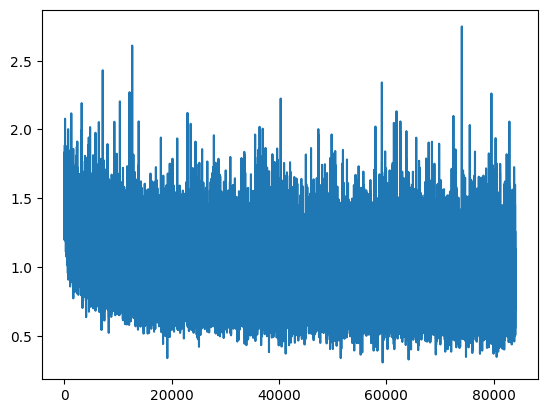

In [22]:
plt.plot(train_losses)

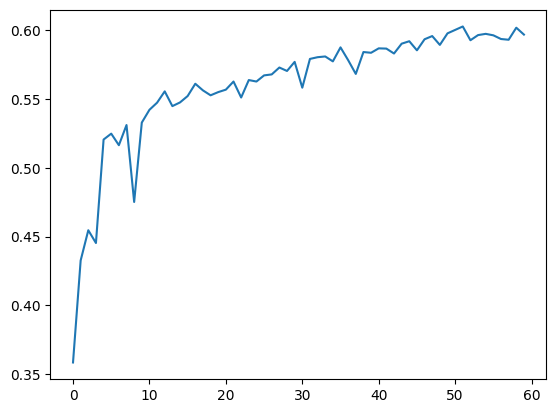

In [23]:
plt.plot(test_accuracy)

In [24]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3342/5600 (0.5968)
{'acc_detail': tensor([0.7550, 0.6757, 0.6079, 0.3486], device='cuda:0'),
 'acc_unweighted': tensor(0.5968, device='cuda:0'),
 'acc_weighted': tensor(0.5968, device='cuda:0'),
 'f1s_detail': tensor([0.6475, 0.6161, 0.6623, 0.4255], device='cuda:0'),
 'f1s_unweighted': tensor(0.5878, device='cuda:0'),
 'f1s_weighted': tensor(0.5878, device='cuda:0'),
 'precision_detail': tensor([0.5668, 0.5661, 0.7274, 0.5459], device='cuda:0'),
 'recall_detail': tensor([0.7550, 0.6757, 0.6079, 0.3486], device='cuda:0'),
 'rocauc': tensor(0.8486, device='cuda:0'),
 'rocauc_detail': tensor([0.8741, 0.8573, 0.8818, 0.7811], device='cuda:0'),
 'uar': tensor(0.5968, device='cuda:0'),
 'wap': tensor(0.6015, device='cuda:0')}


tensor([[1057,  113,   55,  175],
        [ 115,  946,  182,  157],
        [ 151,  324,  851,   74],
        [ 542,  288,   82,  488]], device='cuda:0')

In [25]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13ser_best_52epoch.pt
Correct: 3375/5600 (0.6027)
{'acc_detail': tensor([0.6771, 0.6250, 0.6829, 0.4257], device='cuda:0'),
 'acc_unweighted': tensor(0.6027, device='cuda:0'),
 'acc_weighted': tensor(0.6027, device='cuda:0'),
 'f1s_detail': tensor([0.6462, 0.6102, 0.6730, 0.4662], device='cuda:0'),
 'f1s_unweighted': tensor(0.5989, device='cuda:0'),
 'f1s_weighted': tensor(0.5989, device='cuda:0'),
 'precision_detail': tensor([0.6180, 0.5960, 0.6634, 0.5151], device='cuda:0'),
 'recall_detail': tensor([0.6771, 0.6250, 0.6829, 0.4257], device='cuda:0'),
 'rocauc': tensor(0.8476, device='cuda:0'),
 'rocauc_detail': tensor([0.8718, 0.8546, 0.8801, 0.7840], device='cuda:0'),
 'uar': tensor(0.6027, device='cuda:0'),
 'wap': tensor(0.5981, device='cuda:0')}


tensor([[948,  97,  94, 261],
        [ 70, 875, 253, 202],
        [ 82, 264, 956,  98],
        [434, 232, 138, 596]], device='cuda:0')

In [26]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                   | 0.0005714285714285715/40 [00:00<8:42:02, 783.06s/it]

Train Epoch: 61 [0/22400 (0%)]	Loss: 0.763395
Mem before-during-after: 63180800 5354140160 66797568


  0%|                                                                    | 0.023428571428571413/40 [00:19<9:54:35, 892.42s/it]

Train Epoch: 61 [640/22400 (3%)]	Loss: 0.710928
Mem before-during-after: 67269632 5355855872 66797568


  0%|                                                                   | 0.046285714285714215/40 [00:37<10:15:15, 923.95s/it]

Train Epoch: 61 [1280/22400 (6%)]	Loss: 0.905505
Mem before-during-after: 66797568 5356815360 67689472


  0%|                                                                    | 0.06914285714285702/40 [00:56<10:59:49, 991.45s/it]

Train Epoch: 61 [1920/22400 (9%)]	Loss: 0.960627
Mem before-during-after: 66821120 5358505984 66797568


  0%|▏                                                                   | 0.09199999999999982/40 [01:14<10:06:04, 911.20s/it]

Train Epoch: 61 [2560/22400 (11%)]	Loss: 1.157454
Mem before-during-after: 67089408 5354586624 67584000


  0%|▏                                                                   | 0.11485714285714262/40 [01:34<10:07:23, 913.71s/it]

Train Epoch: 61 [3200/22400 (14%)]	Loss: 0.764158
Mem before-during-after: 67220480 5355200512 66797568


  0%|▏                                                                  | 0.13771428571428573/40 [01:53<11:37:47, 1050.30s/it]

Train Epoch: 61 [3840/22400 (17%)]	Loss: 0.698820
Mem before-during-after: 67548160 5358666240 66797568


  0%|▎                                                                    | 0.1605714285714291/40 [02:13<10:03:25, 908.79s/it]

Train Epoch: 61 [4480/22400 (20%)]	Loss: 0.629412
Mem before-during-after: 67220480 5355806720 66797568


  0%|▎                                                                    | 0.18342857142857244/40 [02:31<9:48:50, 887.33s/it]

Train Epoch: 61 [5120/22400 (23%)]	Loss: 1.251722
Mem before-during-after: 67689472 5354400256 66797568


  1%|▎                                                                    | 0.2062857142857158/40 [02:50<10:30:21, 950.43s/it]

Train Epoch: 61 [5760/22400 (26%)]	Loss: 0.611650
Mem before-during-after: 67269632 5354428928 66797568


  1%|▍                                                                    | 0.22914285714285915/40 [03:09<9:46:25, 884.71s/it]

Train Epoch: 61 [6400/22400 (29%)]	Loss: 0.764904
Mem before-during-after: 67689472 5354400256 66797568


  1%|▍                                                                   | 0.2520000000000024/40 [03:28<11:11:15, 1013.28s/it]

Train Epoch: 61 [7040/22400 (31%)]	Loss: 0.973335
Mem before-during-after: 67249152 5358780928 67424256


  1%|▍                                                                    | 0.27485714285714463/40 [03:47<9:52:09, 894.38s/it]

Train Epoch: 61 [7680/22400 (34%)]	Loss: 0.973108
Mem before-during-after: 67689472 5354400256 66797568


  1%|▌                                                                   | 0.2977142857142869/40 [04:07<11:09:37, 1011.97s/it]

Train Epoch: 61 [8320/22400 (37%)]	Loss: 0.979937
Mem before-during-after: 66821120 5353978368 67220480


  1%|▌                                                                    | 0.3205714285714291/40 [04:27<10:52:27, 986.58s/it]

Train Epoch: 61 [8960/22400 (40%)]	Loss: 0.477557
Mem before-during-after: 67643392 5356232704 67643392


  1%|▌                                                                    | 0.3257142857142861/40 [04:31<10:42:09, 971.16s/it]

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

In [ ]:
filtviz.visualize_filters(filter_domain='freq')

In [ ]:
filtviz.visualize_one_window(n_out=10)

In [ ]:
filtviz.visualize_one_window(n_out=50)

In [ ]:
filtviz.visualize_window_params()

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
start_epoch = 151
n_epoch = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
start_epoch = 201
n_epoch = 300

optimizer = optim.RAdam(model.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_esd4/esd4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)